In [1]:
from tqdm import tqdm
from pathlib import Path
import pickle
import os
import open3d as o3d # 0.14 has ray casting
import point_cloud_utils as pcu # !pip install pypcu
import csv
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from PIL import Image

def boxpts_to_o3dbox(box_pts):
    boxpts = o3d.utility.Vector3dVector(box_pts)
    o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(boxpts)
    o3dbox.color = np.array([1,0,0])
    return o3dbox

def cylindrical2cart(points):
    r, azimuth, z = points[:,0], points[:,1], points[:,2]
    x = r*np.cos(azimuth)
    y = r*np.sin(azimuth)
    return np.concatenate((x[:,np.newaxis],y[:,np.newaxis],z[:,np.newaxis]), axis=1)


def generate_ncoords_by_azimuth_bins(nbins=16, min_dist=5, max_dist=70, z_mu=0.8, z_sigma=0.3):
    azbin_size = 2*np.pi/nbins
    azbin_edges = [-np.pi+i*azbin_size for i in range(nbins+1)]

    cyl = []
    for i in range(nbins):
        rand_dist = np.random.uniform(min_dist,max_dist)
        az_bin = [azbin_edges[i], azbin_edges[i+1]]
        sampled_az = np.random.normal(np.mean(az_bin), azbin_size/4)
        cyl.append([rand_dist, sampled_az])

    z = np.random.normal(loc=z_mu, scale=z_sigma, size=[len(cyl)])
    return cylindrical2cart(np.hstack([np.array(cyl), z[...,np.newaxis]]))


def convert_to_o3dpcd(points, color=None):
    if type(points) == list:
        pcds = []
        for pointcloud in points:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pointcloud[:,:3])
            pcds.append(pcd)
        return pcds
    else:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[:,:3])
        if color:
            pcd.paint_uniform_color(color)
        return pcd

def get_scaling_factor(pts, min_car_width=1.55, max_car_width=2.15, min_car_height=0.8):
    bounds = get_minmax(pts)
    dims = get_lwh(bounds)    
    
    valid_scaling = False
    while(not valid_scaling):
        car_width = np.random.uniform(min_car_width, max_car_width)
        scaling_factor = car_width/dims[1]
        scaled_pts = scaling_factor * pts
        scaled_bounds = get_minmax(scaled_pts)
        scaled_dims = get_lwh(scaled_bounds)
        if scaled_dims[2] > min_car_height:
            valid_scaling = True
    
    return scaling_factor    
    
    
def get_minmax(pts):
    return {'max_x':max(pts[:,0]), 'min_x':min(pts[:,0]),
            'max_y':max(pts[:,1]), 'min_y':min(pts[:,1]),
            'max_z':max(pts[:,2]), 'min_z':min(pts[:,2])}

def get_lwh(minmax):
    l1 = minmax['max_x'] - minmax['min_x']
    l2 = minmax['max_y'] - minmax['min_y']
    return np.array([max(l1,l2),min(l1,l2), minmax['max_z'] - minmax['min_z']]) # l,w,h

def get_gt_for_zero_yaw(pts, openpcdet_format=False, o3d_format=False):
    bounds = get_minmax(pts)     
    dims = get_lwh(bounds)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2])   

    # return 3d box points for o3d box construction
    bbox3d = np.array([
        [bounds['max_x'], bounds['max_y'], bounds['max_z']],
        [bounds['max_x'], bounds['min_y'], bounds['max_z']],
        [bounds['min_x'], bounds['max_y'], bounds['max_z']],
        [bounds['min_x'], bounds['min_y'], bounds['max_z']],
        [bounds['max_x'], bounds['max_y'], bounds['min_z']],
        [bounds['max_x'], bounds['min_y'], bounds['min_z']],
        [bounds['min_x'], bounds['max_y'], bounds['min_z']],
        [bounds['min_x'], bounds['min_y'], bounds['min_z']]
    ])
    if o3d_format:
        o3dvec_bbox = o3d.utility.Vector3dVector(bbox3d)
        o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(o3dvec_bbox)
        o3dbox.color = np.array([1,0,0])
        return {'bbox':o3dbox, 'center':center, 'dims':dims} 
    else:
        return {'bbox':bbox3d, 'center':center, 'dims':dims} 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [43]:
scales_list = []
for i, info in enumerate(infos):    
    
    vmask = info['annos']['name'] == 'Vehicle'    
    car_label = info['annos']['gt_boxes_lidar'][vmask]   
    if len(car_label) > 0:
        valid_carwidth = (car_label[:,4] > 1.5) & (car_label[:,4] < 3)
        valid_carlength = (car_label[:,3] > 2.4) & (car_label[:,3] < 7)
        valid_mask = valid_carwidth & valid_carlength
        car_label = car_label[valid_mask]
        scales_list.append(car_label)
        
scales = np.vstack(scales_list)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


In [2]:
import pickle

infos_path = '/SEE-MTDA/data/waymo/infos_openpcdetv0.3.0/waymo_infos_train.pkl'

with open(infos_path, 'rb') as f:
    infos = pickle.load(f)

In [44]:
waymo_lidar_height = 2.4
frames = {}

fnum = 0
for i, info in enumerate(infos):    
    
    vmask = info['annos']['name'] == 'Vehicle'    
    car_label = info['annos']['gt_boxes_lidar'][vmask]     
    
    if len(car_label) > 0:
        frames[fnum] = {}
        frames[fnum]['car'] = {}
        frames[fnum]['sign'] = {}
        
        # Waymo annotates forklifts etc as two parts, the arm and body. We ignore the arm.
        valid_carwidth = car_label[:,4] > 1.5
        car_label = car_label[valid_carwidth]
        
        car_label[:,2] -= waymo_lidar_height    
        frames[fnum]['car']['label'] = car_label
        frames[fnum]['car']['num_pts'] = info['annos']['num_points_in_gt'][vmask]
        frames[fnum]['car']['num_obj'] = len(car_label)
    
        smask = info['annos']['name'] == 'Sign'
        sign_label = info['annos']['gt_boxes_lidar'][smask]   

        if len(sign_label) > 0:            
            sign_label[:,2] -= waymo_lidar_height
            frames[fnum]['sign']['label'] = sign_label
            frames[fnum]['sign']['num_pts'] = info['annos']['num_points_in_gt'][smask]
            frames[fnum]['sign']['num_obj'] = len(sign_label)
        fnum += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


31


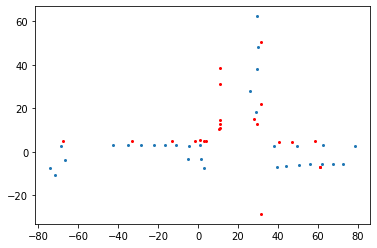

In [6]:
fnum = 396
print(frames[fnum]['car']['num_obj'])

plt.scatter(frames[fnum]['car']['label'][:,0], frames[fnum]['car']['label'][:,1], s=4)
plt.scatter(frames[fnum]['sign']['label'][:,0], frames[fnum]['sign']['label'][:,1], s=4, c='red')

In [10]:
fnum = 396
scene_boxes = [boxpts_to_o3dbox(opd_to_boxpts(frames[fnum]['car']['label'][i])) for i in range(len(frames[fnum]['car']['label']))]
o3d.visualization.draw_geometries(scene_boxes)

In [101]:
from pathlib import Path

def get_car_model(idx, model_filelist):
    if idx == -1:
        valid_model = False
        while(not valid_model):            
            model_idx = np.random.randint(0,len(model_filelist))
            obj_file = Path(data_dir) / model_id / 'models/model_normalized.obj'
            if obj_file.exists():
                return str(obj_file)
    else:
        obj_file = Path(model_filelist[idx] + '/models/model_normalized.obj')
        if not obj_file.exists():
            raise f"{str(obj_file)} does not exist"            
        else:
            return str(obj_file)
        
        
def get_random_car(model_filelist):
    """
    Returns a random model that is randomly scaled and rotated
    """
    obj_file = get_car_model(-1, model_filelist)
    
    obj = load_shapenet(obj_file)
    model_v = np.asarray(obj['mesh'].vertices)
    
    print(obj_file)
    alpha = get_scaling_factor(model_v)
    scaled_pts = alpha * model_v
    gtbox = get_gt_for_zero_yaw(scaled_pts)
    
    obj_data = {'bbox': gtbox['bbox'],
                'vertices': scaled_pts,
                'faces': obj['mesh'].triangles,
                'centre': gtbox['center'],
                'dims': gtbox['dims'],
                'model_id': obj_file.split('/')[-3]}
    return obj_data

car = get_random_car(models)

/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [4.52249196 1.84603086 1.32224429]


In [104]:
def get_tmesh_with_box_labels(box_label, model_filelist):
    car = get_random_car(model_filelist)
    centroid = box_label[:3]
    yaw = box_label[-1]
    rmat = np.array([[np.cos(yaw), np.sin(yaw), 0],
                      [-np.sin(yaw), np.cos(yaw), 0],
                      [0, 0, 1]])
    tmesh = o3d.geometry.TriangleMesh()
    tmesh.vertices = o3d.utility.Vector3dVector(car['vertices'] @ rmat.T + centroid)
    tmesh.triangles = o3d.utility.Vector3iVector(car['faces'])
    
    ret = {'bbox': car['bbox'] @ rmat.T + centroid, 
           'mesh': tmesh, 
           'model_id': car['model_id'],
           'label': list(centroid) + list(car['dims']) + list([yaw]),
           'waymo_num_pts': int(box_label[-1])} 
    return ret

scene_cars = [get_tmesh_with_box_labels(frames[fnum]['car']['label'][i], models) for i in range(len(frames[fnum]['car']['label']))]

/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [5.00783643 2.04414307 1.46414481]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [5.04802656 2.06054823 1.47589523]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [4.08468752 1.66732396 1.19424309]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [3.8653455  1.57779099 1.1301139 ]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [5.11799161 2.08910718 1.49635096]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [4.5344858  1.85092661 1.32575094]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/029583

In [ ]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])
o3d.visualization.draw_geometries([sc['mesh'] for sc in scene_cars] + [origin])

In [63]:
def populate_scene(scene_cars, sign_labels, random_poles_pct=0.3):
    scene = o3d.t.geometry.RaycastingScene()
    
    num_rand_poles = int(len(scene_cars)*random_poles_pct)
    
    for i, sc in enumerate(scene_cars):
        tmesh = o3d.t.geometry.TriangleMesh.from_legacy(sc['mesh'])
        scene.add_triangles(tmesh)
        
        if i < num_rand_poles:
            # Obstacles that are close to the cars
            car_centre = sc['label'][:3]
            car_height = sc['label'][5]
            pole_radius = np.random.uniform(0.03,0.2)
            pole_height = np.random.uniform(1,4,1)

            box_min = np.min(sc['bbox'], axis=0)[:2]
            box_max = np.max(sc['bbox'], axis=0)[:2]
            xyall_choice = np.random.choice([1,2,3])
            if np.random.choice([True, False]):
                if xyall_choice == 1:                    
                    pole_xy = np.array([box_max[0], car_centre[1]]) + np.random.uniform(0,0.5)
                elif xyall_choice == 2: 
                    pole_xy = np.array([car_centre[0], box_max[1]]) + np.random.uniform(0,0.5)
                else:
                    pole_xy = box_max + np.random.uniform(0,1,2)
            else:
                pole_xy = box_min - np.random.uniform(0,1,2)        
            pole_centre = np.concatenate([pole_xy, np.array(car_centre[2] + pole_height/2 - car_height/2)])
            cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height.item()).translate(pole_centre)
            scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
    
    # Add the waymo labelled signs as cylinders
    for i, sign in enumerate(sign_labels):
        pole_height = np.random.uniform(1,4,1)
        pole_centre = sign[:3]
        pole_centre[2] = -2.4 + pole_height/2
        pole_radius = np.random.uniform(0.03,0.1)        
        cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height).translate(pole_centre)
        scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
                
    return scene

def cast_rays_at_point(scene, point, fov_deg=100, aspect_ratio=2, height_px=640):
    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=fov_deg, # simulates a vertical fov of lidar
    center=point, # point where camera is looking at
    eye=[0,0,0], # position of the camera
    up=[0, 0, 1], # up vector
    width_px=aspect_ratio*height_px, # image width
    height_px=height_px, # image height
    )
    
    ans = scene.cast_rays(rays)
    hit = ans['t_hit'].isfinite()
    points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))
    return points.numpy()
    
    
def raycast_object(car, scene):
    centre = car['label'][:3]
    ray_pts = cast_rays_at_point(scene, centre)
    o3dbox = boxpts_to_o3dbox(car['bbox'])
    
    ret = {'ray_pts': convert_to_o3dpcd(ray_pts),
           'obj_pts': convert_to_o3dpcd(ray_pts).crop(o3dbox),
           'bbox': o3dbox}
    return ret

scene = populate_scene(scene_cars, frames[fnum]['sign']['label'])
res = raycast_object(scene_cars[0], scene)

In [64]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])
o3d.visualization.draw_geometries([res['ray_pts'], res['bbox'], origin])

In [300]:
o3d.visualization.draw_geometries([res['obj_pts'], res['bbox'], origin])

In [180]:
sum([frames[i]['car']['num_obj'] for i in range(len(frames))])

4712401

# Export scenes

In [9]:
from pathlib import Path
import time

def load_shapenet(obj_file, num_pts=16384):

    v,f,n = pcu.load_mesh_vfn(obj_file)
    
    # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
    # Detection datasets define car length as x, width as y, and height as z. Forward is +x
    v[:,2] *= -1
    
    # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
    v = v[:,[2,0,1]]     
    
    # dense random sampling
    fi, bc = pcu.sample_mesh_random(v, f, num_pts)
    pts = pcu.interpolate_barycentric_coords(f, fi, bc, v)
    
    # ShapeNet is centered but it's slightly off 0,0,0
    bounds = get_minmax(pts)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2]) 
    obj = {}
    obj['model_id'] = obj_file.split('/')[-3]
    obj['sampled_pts'] = pts - center
    tmesh = o3d.geometry.TriangleMesh()
    tmesh.vertices = o3d.utility.Vector3dVector(v - center)
    tmesh.triangles = o3d.utility.Vector3iVector(f)
    obj['mesh'] = tmesh
    obj['dims'] = np.array([bounds['max_x']-bounds['min_x'],bounds['max_y']-bounds['min_y'],bounds['max_z']-bounds['min_z']])
    
    return obj

def get_scaling_factor(obj, min_car_width=1.55, max_car_width=2.15, min_car_height=0.6):
    dims = obj['dims']    
#     print(f'{model_id} - origdims = {dims}')
    valid_scaling = False
    while(not valid_scaling):
        car_width = np.random.uniform(min_car_width, max_car_width)
        scaling_factor = car_width/dims[1]
        scaled_pts = scaling_factor * np.asarray(obj['mesh'].vertices)
        scaled_bounds = get_minmax(scaled_pts)
        scaled_dims = get_lwh(scaled_bounds)
        if scaled_dims[2] > min_car_height:
            valid_scaling = True
    
    return scaling_factor    
    

def sample_car_model(data_dir, sampled_db, unseen_list):
    # Random sample. We pop unseen/seen after seeing all models once
    if len(unseen_list) > 0:
        db_idx = np.random.randint(0,len(unseen_list))
        model_id = unseen_list[db_idx]
        sampled_db.setdefault(model_id, 0)
        unseen_list.remove(model_id)
        
#         print(f'sampling db_idx: {db_idx}, model_id: {model_id} from {len(unseen_list)} models')
    else:
        # Get the least sampled model
        model_id = min(sampled_db, key=sampled_db.get)
#         print(f'sampling model_id: {model_id} with {sampled_db[model_id]} counts')
    
    sampled_db[model_id] += 1
    obj_file = Path(data_dir) / model_id / 'models/model_normalized.obj'    
    
    assert obj_file.exists(), f"{str(obj_file)} does not exist"    
    return str(obj_file)
        
        
def get_car_object(data_dir, sampled_db, unseen_list):
    """
    Returns a random model that is randomly scaled and rotated
    """
    obj_file = sample_car_model(data_dir, sampled_db, unseen_list)
    model_id = obj_file.split('/')[-3]

    obj = load_shapenet(obj_file)
    model_v = np.asarray(obj['mesh'].vertices)
    
    alpha = get_scaling_factor(obj)
    scaled_pts = alpha * model_v
    gtbox = get_gt_for_zero_yaw(scaled_pts)
    
    obj_data = {'bbox': gtbox['bbox'],
                'vertices': scaled_pts,
                'faces': obj['mesh'].triangles,
                'centre': gtbox['center'],
                'dims': gtbox['dims'],
                'model_id': model_id}
    return obj_data

def get_tmeshes_with_box_labels(frame_cars, data_dir, sampled_db, unseen_list):
    if 'label' not in frame_cars:
        return []
    
    scene_cars = []
    for box_label in frame_cars['label']:

        car = get_car_object(data_dir, sampled_db, unseen_list)
        centroid = box_label[:3]
        yaw = box_label[-1]
        rmat = np.array([[np.cos(yaw), np.sin(yaw), 0],
                          [-np.sin(yaw), np.cos(yaw), 0],
                          [0, 0, 1]])
        tmesh = o3d.geometry.TriangleMesh()
        tmesh.vertices = o3d.utility.Vector3dVector(car['vertices'] @ rmat.T + centroid)
        tmesh.triangles = o3d.utility.Vector3iVector(car['faces'])

        ret = {'bbox': car['bbox'] @ rmat + centroid, 
               'mesh': tmesh, 
               'model_id': car['model_id'],
               'label': list(centroid) + list(car['dims']) + list([yaw]),
               'waymo_num_pts': int(box_label[-1])} 
        scene_cars.append(ret)
    return scene_cars

def opd_to_boxpts(box):
    """
    Takes an array containing [x,y,z,l,w,h,r], and returns an [8, 3] matrix that 
    represents the [x, y, z] for each 8 corners of the box.
    
    Note: Openpcdet __getitem__ gt_boxes are in the format [x,y,z,l,w,h,r,alpha]
    where alpha is "observation angle of object, ranging [-pi..pi]"
    """
    # To return
    corner_boxes = np.zeros((8, 3))

    translation = box[0:3]
    l, w, h = box[3], box[4], box[5] # waymo, nusc, kitti is all l,w,h after OpenPCDet processing
    rotation = box[6]

    # Create a bounding box outline
    bounding_box = np.array([[l/2, w/2, h/2],
                             [l/2, -w/2, h/2],
                             [-l/2, w/2, h/2],
                             [-l/2, -w/2, h/2],
                             [l/2, w/2, -h/2],
                             [l/2, -w/2, -h/2],
                             [-l/2, w/2, -h/2],
                             [-l/2, -w/2, -h/2]])

    # Standard 3x3 rotation matrix around the Z axis
    rotation_matrix = np.array([
        [np.cos(rotation), np.sin(rotation), 0.0],
        [-np.sin(rotation), np.cos(rotation), 0.0],
        [0.0, 0.0, 1.0]])
    vcbox = bounding_box @ rotation_matrix
    vcbox += box[:3]
    
    return vcbox

In [4]:
def populate_scene(scene_cars, signs, random_poles_pct=0.3):
    scene = o3d.t.geometry.RaycastingScene()
    
    num_rand_poles = int(len(scene_cars)*random_poles_pct)
    
    for i, sc in enumerate(scene_cars):
        tmesh = o3d.t.geometry.TriangleMesh.from_legacy(sc['mesh'])
        scene.add_triangles(tmesh)
        
        if i < num_rand_poles:
            # Obstacles that are close to the cars
            car_centre = sc['label'][:3]
            car_height = sc['label'][5]
            pole_radius = np.random.uniform(0.03,0.2)
            pole_height = np.random.uniform(1,4,1)

            box_min = np.min(sc['bbox'], axis=0)[:2]
            box_max = np.max(sc['bbox'], axis=0)[:2]
            xyall_choice = np.random.choice([1,2,3])
            if np.random.choice([True, False]):
                if xyall_choice == 1:                    
                    pole_xy = np.array([box_max[0], car_centre[1]]) + np.random.uniform(0,0.5)
                elif xyall_choice == 2:
                    pole_xy = np.array([car_centre[0], box_max[1]]) + np.random.uniform(0,0.5)
                else:
                    pole_xy = box_max + np.random.uniform(0,1,2)
            else:
                pole_xy = box_min - np.random.uniform(0,1,2)        
            pole_centre = np.concatenate([pole_xy, np.array(car_centre[2] + pole_height/2 - car_height/2)])
            cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height.item()).translate(pole_centre)
            scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
    
    # Add the waymo labelled signs as cylinders
    if 'label' in signs:
        sign_labels = signs['label']
        for i, sign in enumerate(sign_labels):
            pole_height = np.random.uniform(1,4,1)
            pole_centre = sign[:3]
            pole_centre[2] = -2.4 + pole_height/2
            pole_radius = np.random.uniform(0.03,0.1)        
            cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height).translate(pole_centre)
            scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
                
    return scene

def cast_rays_at_point(scene, point, fov_deg=100, aspect_ratio=2, height_px=640):
    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=fov_deg, # simulates a vertical fov of lidar
    center=point, # point where camera is looking at
    eye=[0,0,0], # position of the camera
    up=[0, 0, 1], # up vector
    width_px=aspect_ratio*height_px, # image width
    height_px=height_px, # image height
    )
    
    ans = scene.cast_rays(rays)
    hit = ans['t_hit'].isfinite()
    points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))
    return points.numpy()
    
    
def raycast_object(car, scene, npoints):
    centre = car['label'][:3]    
    
    fov_deg = np.random.normal(120, 30)
    ray_pts = cast_rays_at_point(scene, centre, fov_deg=fov_deg, aspect_ratio=2, height_px=640)
    o3dbox = boxpts_to_o3dbox(car['bbox'])
    
    ret = {'ray_pts': convert_to_o3dpcd(ray_pts),
           'obj_pts': convert_to_o3dpcd(ray_pts).crop(o3dbox),
           'complete': car['mesh'].sample_points_uniformly(npoints),
           'bbox_pts': car['bbox'],
           'model_id': car['model_id'],
           'label': car['label'],
           'fov_deg':fov_deg}
    return ret

In [3]:
waymo_lidar_height = 2.4
frames = []

infos_path = '/SEE-MTDA/data/waymo/infos_openpcdetv0.3.0/waymo_infos_train.pkl'

with open(infos_path, 'rb') as f:
    infos = pickle.load(f)

for i, info in enumerate(infos):    
    
    vmask = info['annos']['name'] == 'Vehicle'    
    car_label = info['annos']['gt_boxes_lidar'][vmask]     
    
    if len(car_label) > 0:
        frame = {}
        frame['car'] = {}
        frame['sign'] = {}
        
        # Waymo annotates forklifts etc as two parts, the arm and body. We ignore the arm.
        valid_carwidth = car_label[:,4] > 1.5
        car_label = car_label[valid_carwidth]
        
        car_label[:,2] -= waymo_lidar_height    
        frame['car']['label'] = car_label
        frame['car']['num_pts'] = info['annos']['num_points_in_gt'][vmask]
        frame['car']['num_obj'] = len(car_label)
    
        smask = info['annos']['name'] == 'Sign'
        sign_label = info['annos']['gt_boxes_lidar'][smask]   

        if len(sign_label) > 0:            
            sign_label[:,2] -= waymo_lidar_height
            frame['sign']['label'] = sign_label
            frame['sign']['num_pts'] = info['annos']['num_points_in_gt'][smask]
            frame['sign']['num_obj'] = len(sign_label)
        frames.append(frame)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


In [4]:
import pickle
import random

# Specifically for Shapenet.v2
ignore = {}
ignore['non_car'] = ['d353bf0e0dfe3ac29cbc1c09129e1507','c0db588c8c816cd2dc668d3d64c871ae']
ignore['unclean_car'] = ['a75ff576da012340468bac13e007a6e9','52c589e86fd500cd4a42886683bb52d2','65d6433043c40046b82c0841410a924f','e09813b03bdfce83a23218adb697420d','d1acd4916d3d3b57c48db2ed8f5e994c','39b307361b650db073a425eed3ac7a0b', 'dda10fc985eea0868c368040825ed335', '471673f3f062abd473f10e6caaeca56','e2ceb9bf23b498dda7431386d9d22644','3804a264b503d5812e40b8f7ac380eb5','445185842d893b6978fe949fc1419876','95ebb3fd80f885ad676f197a68a5168a','ba89184f58f21ff63343f5fadc4a2136']
ignore['truck_bus'] = ['6aa8f648cc8df63ab2c17ece4015d55','84bc3155bc5c95bfaaafd94b9f216ef6','fd3b75f7f1e9172fb6f657757c95f74e','21999849a6a8aad752470de2774d6099','dfa6c32dec07727ee9d8921ebe6d5b8e','26b7a9c6c7e74829eabc798aaf5f039f', '433481aa8cde9b692e3dd7c278f108dd','cdfe4dc408f4ca84aaafd94b9f216ef6']
ignore['limo'] = ['c9b49f7b355528e5632dc979097a3ec0','b11c0c16e0eed1f4b8671dc42cc45273','eefce52130d223ba2dcbf88f7c685079','db432e9f280ffb1e3dd4bdc1dbab98bd','dd0817b9757b74c75d3a87a5c4dd9ce4','e4b1de221f2d66352638397725e10cf9','9d2b7938d426633b28044fe9244db50a','41d317b520eec9d38d3d01fa03326bb0','5a5b0e1cbb38bdb12d08a76380360b3b','bc9c588a00ae179fa2645d665a7d8fa','ed91b2509171fdc1c48492b454f1615a','17c32e15723ed6e0cd0bf4a0e76b8df5','9fa56c19e4d54cca99c8d14f483ffc82','2f1001870f90e06bc48492b454f1615a','4c53afe560e36d8380ba2a9340bf2d77','e0978173fcfc5203510556e7c3123591','fb8adbcf67d858fc28044fe9244db50a','9dee0ea5da388102e6d91d458fe44a15','7c7e5b4fa56d8ed654b40bc735c6fdf6','7f6031f1738d52546436916a86a90ed7','cc0c058e2eca523051fb05589f6b0d0e','9676e8250cdd90307d5394224a6aa067','282293948b21262769416db9b743e50b','202fbaeffaf49f4b61c6c61410fc904b','b4d258dc5a12f9f7ade7f700b19bcf4a','f1b97d671bb93ad928044fe9244db50a','9d77d4c959974035fab60fc805223a73','5c3fe4057ef12b6886ac29addefc0f11','56dc27e4374cf87132eaaf3b7c9989f6', '501ac8493044eff04d44f5db04bf14b8','55181c34dadb4f032db09455d18fca0']
ignore['invalid_lwratio'] = ['7e7f0637d6798113ddb4014f0e8d0dac', '492a339ce5da3fe8e4b68d3b17c43658', '99fce87e4e80e053374462542bf2aa29', 'f7f7b1b4021be11afaeea7738551d104', 'bfa01c632be2eb06e8a3b392b986583', '7c85e6cf9c4f46e91cc13e432d5756b8', '6b79cfceb6f614527e7afb83f93db294', '52c589e86fd500cd4a42886683bb52d2', 'd1acd4916d3d3b57c48db2ed8f5e994c', '65d6433043c40046b82c0841410a924f', 'f4498022df553505c35f22936e5aea5c', '3c310afdf363201cefe5f291bc2f5fd0', 'c0db588c8c816cd2dc668d3d64c871ae', 'd353bf0e0dfe3ac29cbc1c09129e1507', '9f7b4a82becac9cd5568b8cbf53329df', 'e4d1edc4cda4a6445fb81d6394b59c19','c30bf6d1ae428497c7f3070d3c7b9f30', '3804a264b503d5812e40b8f7ac380eb5', 'cdfe4dc408f4ca84aaafd94b9f216ef6', '55181c34dadb4f032db09455d18fca0', '95a6e03656bdff26f69bc9777f9c3c39', '957a686c3c9f956a3d982653fc5fd75b', '88c884dd867d221984ae8a5736280c', 'ba89184f58f21ff63343f5fadc4a2136', '1c7ddd2735778013ce50f18f6100cef6', 'd05aa55f9e5b4d10afe1d4530f4c6e24', 'a3e7603c0d9ef56280e74058ee862f05', '96ca20dd7caff0bb851f021b9ed69c58', '2df225b8df2633c231141a7d4d06dc13', '781b45d3eb625148248a78e10a40d8eb', '4e488242b665d85f40bc3b36a331b786', '48260abd4ff73f99473f10e6caaeca56', '56d463162ff5352cbd835ce3c63f4d10', '189cffefcdd5cb071a126804ae24042', '36b211593bfa7c2f7f33a9b0659de0d7', '36fe332c1b11696d51a95aaa6caba1d3', '69e99923c3cbcbcca9fe1734a6086750', '346917af7c9659e3814085552234c955', 'ca93e4d0ca75ab1bafe1d4530f4c6e24', '1e987cad6ca8a97a7a24dbc42a104ca8', 'd9049f432296ed36afe1d4530f4c6e24', 'd5c046451e5bd6826a9c18480b4632cb', '3ab98667cabf774e3343f5fadc4a2136', 'dc8765720d8d3828b3cf5236f651a8e6', '5ce9ef613933a245538f2c6e5c51cc7e', 'ac7e674eb67488dcafe1d4530f4c6e24', '5e4a1ac9bdce2766473f10e6caaeca56', '8402d2237afac94a1cf6f8e565096a1e', '791e45f93e9ba58071a126804ae24042', 'f296f3a83e09de75afe1d4530f4c6e24', '307e83044ed81f6c473f10e6caaeca56']
ignore['invalid_objfile'] = ['93ce8e230939dfc230714334794526d4', '9fb1d03b22ecac5835da01f298003d56', '302612708e86efea62d2c237bfbc22ca', '806d740ca8fad5c1473f10e6caaeca56', '2307b51ca7e4a03d30714334794526d4', 'd6ee8e0a0b392f98eb96598da750ef34', 'e6c22be1a39c9b62fb403c87929e1167', '986ed07c18a2e5592a9eb0f146e94477', '407f2811c0fe4e9361c6c61410fc904b', '5bf2d7c2167755a72a9eb0f146e94477', '3ffeec4abd78c945c7c79bdb1d5fe365', 'f5bac2b133a979c573397a92d1662ba5', '3c33f9f8edc558ce77aa0b62eed1492', 'ea3f2971f1c125076c4384c3b17a86ea', '7aa9619e89baaec6d9b8dfa78596b717', '5973afc979049405f63ee8a34069b7c5', '4ddef66f32e1902d3448fdcb67fe08ff', '207e69af994efa9330714334794526d4', '8070747805908ae62a9eb0f146e94477']
ignore['invalid_whratio'] = ['8ee2dfd1460eded9473f10e6caaeca56', 'e2ceb9bf23b498dda7431386d9d22644', '4e488242b665d85f40bc3b36a331b786', '93a813f96365c108f217b9504689397', '9de10b4469cdc435afe1d4530f4c6e24', '863f9284eec4a256e9d8921ebe6d5b8e', 'b9ae3fb6b027dc4294a553cca1043426']
ignore['combined'] = [idx for k,v in ignore.items() for idx in v]

In [5]:
# We don't include trucks, buses or limos for this project
data_dir = '/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343'
model_glob = glob.glob(f'{data_dir}/*')
models = set([model.split('/')[-1] for model in model_glob])
ignore_combined = set(ignore['combined'])
models.difference_update(ignore_combined)
models = list(models)
print(len(models))

3413


In [167]:
# invalid = {}
# invalid['lw_ratio'] = []
# invalid['wh_ratio'] = []

# for model in tqdm(models, total=len(models)):
#     data_dir = Path('/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343')
#     obj = load_shapenet(str(data_dir / model / 'models/model_normalized.obj'))
#     lw_ratio = obj['dims'][0]/obj['dims'][1]
#     wh_ratio = obj['dims'][1]/obj['dims'][2]
#     if lw_ratio > 3.2 or lw_ratio < 1.5:
#         print(f'{model}: lw_ratio={lw_ratio}, dims={obj["dims"]}')
#         invalid['lw_ratio'].append(model)
#     if wh_ratio < 0.75 or wh_ratio > 2.5:
#         print(f'{model}: wh_ratio={wh_ratio}, dims={obj["dims"]}')
#         invalid['wh_ratio'].append(model)

In [ ]:
def generate_dataset(data_dir, frames, models, dataset_name):
    min_pts = 50
    max_pts = 6000
    nviews = 30
    npoints_complete = 16384

    save_dir = Path(f'/SEE-MTDA/data/shapenet/VC/WAYMO_nviews-{nviews}/{dataset_name}')
    save_dir.mkdir(exist_ok=True, parents=True)
    total = nviews * len(models)
    currently_exported = 0
#     t0 = time.time()
    pbar = tqdm(total=total)
    
    sampled_db = {}
    exported_db = {}
    unseen_list = models

    # Shuffle frames because there's 199 frames in one scene
    random.shuffle(frames)
    for fnum, frame in enumerate(frames):

        scene_cars = get_tmeshes_with_box_labels(frame['car'], data_dir, sampled_db, unseen_list)
        scene = populate_scene(scene_cars, frame['sign'])

        # Export each car in the scene and update sampling_db
        for car in scene_cars:
            data = raycast_object(car, scene, npoints_complete)
            model_id = data['model_id']            

            print(f"\n{len(data['obj_pts'].points)} pts - fov_deg: {data['fov_deg']}")
#             print(f'model_id: {model_id} => counts {sampled_db[model_id]}')                
            
            if len(data['obj_pts'].points) > min_pts and len(data['obj_pts'].points) < max_pts:                
                exported_db.setdefault(model_id, 0)
                car_id = exported_db[model_id]

                if car_id >= nviews:
                    continue                
                    
                # Save object
                # Save partial, complete, labels
                partial_dir = save_dir / 'partial' / model_id
                partial_dir.mkdir(exist_ok=True, parents=True)

                complete_dir = save_dir / 'complete' / model_id
                complete_dir.mkdir(exist_ok=True, parents=True)

                label_dir = save_dir / 'label' / model_id
                label_dir.mkdir(exist_ok=True, parents=True)

                o3d.io.write_point_cloud(str(partial_dir / f'{car_id:03d}.pcd'), data['obj_pts'])
                o3d.io.write_point_cloud(str(complete_dir / f'{car_id:03d}.pcd'), data['complete'])
                with open(str(label_dir / f'{car_id:03d}.pkl'), 'wb') as f:
                    label = {'bbox_pts': data['bbox_pts'], 
                             'gtbox': data['label'],
                             'pc_id': f'{model_id}_{car_id:03d}',
                             'raycasting': data['fov_deg']}
                    pickle.dump(label, f)

                currently_exported += 1
                exported_db[model_id] += 1
                
#                 print(f'model_id: {model_id} => num exported {exported_db[model_id]}')                
                print(f'{currently_exported}/{total} objects exported')
#                 avg_time = (time.time() - t0)/currently_exported
#                 print(f'{avg_time:0.3f}s/it, {(avg_time * total - (time.time()-t0))/60:0.4}min est. time remaining')
                pbar.update(1)
                
                if currently_exported >= total:
                    print(f'{currently_exported} objects exported')                    
                    return
            else:
                counts = sampled_db[model_id]
                sampled_db[model_id] = max(counts - 1, 0)
                if sampled_db[model_id] == 0:
                    print(f'adding {model_id} back to unseen')
                    unseen_list.append(model_id)
                    
#                 print(f'model_id: {model_id} => counts {sampled_db[model_id]}')                
    pbar.close()
generate_dataset(data_dir, frames, models[int(3413*0.8):int(3413*0.9)], dataset_name='train')

  0%|                                                    | 0/156337 [00:00<?, ?it/s]


696 pts - fov_deg: 98.75274545980231
1/10230 objects exported
Avg 5.964s per export - 1.017e+03min estimated time remaining

26 pts - fov_deg: 131.05934766502264
adding 690609438d922525ff1370452e3a0154 back to unseen

250 pts - fov_deg: 123.97204110199911
2/10230 objects exported
Avg 3.041s per export - 518.3min estimated time remaining

80 pts - fov_deg: 102.58987312930016
3/10230 objects exported
Avg 2.047s per export - 348.9min estimated time remaining

642 pts - fov_deg: 96.04309885180545
4/10230 objects exported
Avg 1.566s per export - 267.0min estimated time remaining

921 pts - fov_deg: 93.69549104266639
5/10230 objects exported
Avg 1.266s per export - 215.7min estimated time remaining

39 pts - fov_deg: 139.4723180896248
adding a476444d87bc7aeb1699b1ed8dbb7ad7 back to unseen


  0%|                                        | 1/156337 [00:06<284:18:10,  6.55s/it]


10 pts - fov_deg: 153.9631193450481
adding 719487aa97fd9af513345bcbe0ee623d back to unseen

9709 pts - fov_deg: 113.94127520509957
adding 238c6d6da1c8ce2970097c1b40e1ea6 back to unseen

59 pts - fov_deg: 119.69358379482068
6/10230 objects exported
Avg 1.108s per export - 188.8min estimated time remaining

2620 pts - fov_deg: 92.3547593942625
7/10230 objects exported
Avg 1.728s per export - 294.4min estimated time remaining

4 pts - fov_deg: 162.1046086451959
adding 3b2e74068fee2458dd1e15301c83686f back to unseen

39 pts - fov_deg: 125.98047935864297
adding a90b6f926a6307ab31b57ba89dcc78c8 back to unseen

9761 pts - fov_deg: 63.235471481641014
adding f578a26ffc6771b21767453ad70570c6 back to unseen

798 pts - fov_deg: 89.029821998091
8/10230 objects exported
Avg 1.552s per export - 264.5min estimated time remaining

672 pts - fov_deg: 104.77988513113408
9/10230 objects exported
Avg 1.389s per export - 236.5min estimated time remaining

0 pts - fov_deg: 172.82215823565681
adding 97831a75

  0%|                                        | 2/156337 [00:13<286:27:24,  6.60s/it]


5 pts - fov_deg: 163.11575035248256
adding 22428fd70b02b83ffc567bb1bd08c1ae back to unseen

472 pts - fov_deg: 100.06739680475528
15/10230 objects exported
Avg 0.887s per export - 151.0min estimated time remaining

233 pts - fov_deg: 133.40492804064507
16/10230 objects exported
Avg 0.835s per export - 142.1min estimated time remaining

1 pts - fov_deg: 173.2014585958624
adding e98955e5d46a492c036e20efe5e5ca8 back to unseen

106 pts - fov_deg: 119.44508331464193
17/10230 objects exported
Avg 1.653s per export - 281.4min estimated time remaining

4 pts - fov_deg: 133.6475624096939
adding bf52cda8de7e5eff36dfef0450f0ee37 back to unseen

618 pts - fov_deg: 90.49723131911239
18/10230 objects exported
Avg 1.580s per export - 268.9min estimated time remaining

116 pts - fov_deg: 102.71340836677233
19/10230 objects exported
Avg 1.507s per export - 256.5min estimated time remaining

573 pts - fov_deg: 112.3879515794027
20/10230 objects exported
Avg 1.444s per export - 245.7min estimated time r

  0%|                                        | 3/156337 [00:35<485:24:40, 11.18s/it]


50 pts - fov_deg: 121.98821996978631
adding 56332360ecedaf4fb095dfb45b5ad0ce back to unseen

55 pts - fov_deg: 146.28538433753528
41/10230 objects exported
Avg 1.024s per export - 173.9min estimated time remaining

265 pts - fov_deg: 122.1604383129001
42/10230 objects exported
Avg 1.002s per export - 170.1min estimated time remaining

87 pts - fov_deg: 121.45444216727424
43/10230 objects exported
Avg 0.980s per export - 166.5min estimated time remaining

5415 pts - fov_deg: 126.34116741285592
44/10230 objects exported
Avg 0.961s per export - 163.1min estimated time remaining

3063 pts - fov_deg: 73.564835791724
45/10230 objects exported
Avg 0.944s per export - 160.2min estimated time remaining

3942 pts - fov_deg: 100.2773783589218
46/10230 objects exported
Avg 0.925s per export - 157.0min estimated time remaining

43 pts - fov_deg: 162.70886739644357
adding 53502c15c30d06496e4e9b7d32a4f90d back to unseen

44 pts - fov_deg: 142.92108567199418
adding f49155170c175dff176be984cf2a7f4e ba

  0%|                                        | 4/156337 [00:43<450:31:36, 10.37s/it]


13 pts - fov_deg: 115.54956430173377
adding 787ba4e958f1bbe88ec77d0d80815cf8 back to unseen

25 pts - fov_deg: 120.38233179941959
adding c92ef17bef6471f72a9eb0f146e94477 back to unseen

91 pts - fov_deg: 119.21474731521276
54/10230 objects exported
Avg 1.036s per export - 175.7min estimated time remaining

123 pts - fov_deg: 104.52360554667364
55/10230 objects exported
Avg 1.021s per export - 173.2min estimated time remaining

23 pts - fov_deg: 148.06726404488464
adding a70703613b83063d27c34dcc9b552d03 back to unseen

127 pts - fov_deg: 108.11423522386995
56/10230 objects exported
Avg 1.008s per export - 171.0min estimated time remaining

205 pts - fov_deg: 121.73040915178996
57/10230 objects exported
Avg 0.992s per export - 168.2min estimated time remaining

216 pts - fov_deg: 121.50925073994821
58/10230 objects exported
Avg 0.978s per export - 165.8min estimated time remaining

196 pts - fov_deg: 88.87265737325038
59/10230 objects exported
Avg 0.963s per export - 163.3min estimated 

  0%|                                        | 5/156337 [00:59<522:38:24, 12.04s/it]


91 pts - fov_deg: 139.8837298010816
74/10230 objects exported
Avg 0.806s per export - 136.4min estimated time remaining

10 pts - fov_deg: 146.84728792790477
adding 235392f8419bb5006a34aa94ca8a3355 back to unseen

51 pts - fov_deg: 175.70734059159588
75/10230 objects exported
Avg 0.852s per export - 144.1min estimated time remaining

277 pts - fov_deg: 86.13859509491222
76/10230 objects exported
Avg 0.841s per export - 142.4min estimated time remaining

48 pts - fov_deg: 136.79984163546976
adding 8976e05f72b43a742a9eb0f146e94477 back to unseen

159 pts - fov_deg: 108.9743174940988
77/10230 objects exported
Avg 0.833s per export - 141.0min estimated time remaining

48 pts - fov_deg: 119.35512251846382
adding bca97563f170ff4ad2bcce019eeaafbe back to unseen

16721 pts - fov_deg: 43.8129182318997
adding 4618489fc34c3367323a23bddac1281c back to unseen

61 pts - fov_deg: 162.5815905749358
78/10230 objects exported
Avg 0.826s per export - 139.8min estimated time remaining

224 pts - fov_deg:

  0%|                                        | 6/156337 [01:04<436:22:43, 10.05s/it]


20991 pts - fov_deg: 100.98231784794177
adding 7c35cd27ae8d673bb1bb46d2556ba67d back to unseen

1443 pts - fov_deg: 116.82407219138705
80/10230 objects exported
Avg 0.813s per export - 137.6min estimated time remaining

370 pts - fov_deg: 126.0985043892362
81/10230 objects exported
Avg 0.949s per export - 160.5min estimated time remaining

499 pts - fov_deg: 132.5692633038197
82/10230 objects exported
Avg 0.941s per export - 159.1min estimated time remaining

72 pts - fov_deg: 116.27436535788156
83/10230 objects exported
Avg 0.930s per export - 157.3min estimated time remaining

68 pts - fov_deg: 136.3248966594079
84/10230 objects exported
Avg 0.920s per export - 155.6min estimated time remaining

0 pts - fov_deg: 179.18739975355555
adding c2467fec08734fc81e1473be174fcabe back to unseen

0 pts - fov_deg: 177.65398553615822
adding 56332360ecedaf4fb095dfb45b5ad0ce back to unseen

629 pts - fov_deg: 82.40614331184722
85/10230 objects exported
Avg 0.917s per export - 155.0min estimated ti

  0%|                                        | 7/156337 [01:21<518:11:58, 11.93s/it]


312 pts - fov_deg: 130.19253400466755
100/10230 objects exported
Avg 0.814s per export - 137.4min estimated time remaining

210 pts - fov_deg: 110.91977535451939
101/10230 objects exported
Avg 0.940s per export - 158.7min estimated time remaining

50 pts - fov_deg: 104.99550011373177
adding 477ffb061f40e10e148f8c864a546424 back to unseen

80 pts - fov_deg: 119.91485677371563
102/10230 objects exported
Avg 0.934s per export - 157.7min estimated time remaining

14 pts - fov_deg: 142.38687004146365
adding d6e27c6523a3f2b58b8cd97e9d1c6a86 back to unseen

1900 pts - fov_deg: 150.29847559652026
103/10230 objects exported
Avg 0.928s per export - 156.7min estimated time remaining

249 pts - fov_deg: 138.97811464474444
104/10230 objects exported
Avg 0.920s per export - 155.3min estimated time remaining

410 pts - fov_deg: 113.43426519911885
105/10230 objects exported
Avg 0.913s per export - 154.1min estimated time remaining

1137 pts - fov_deg: 117.62338627892895
106/10230 objects exported
Avg

  0%|                                        | 8/156337 [01:41<623:55:41, 14.37s/it]


10 pts - fov_deg: 137.50610545389557
adding 1ae9732840a315afab2c2809513f396e back to unseen

317 pts - fov_deg: 109.95510375705602
124/10230 objects exported
Avg 0.856s per export - 144.2min estimated time remaining

835 pts - fov_deg: 88.80919222343078
125/10230 objects exported
Avg 0.850s per export - 143.1min estimated time remaining

35 pts - fov_deg: 106.87846405313513
adding db216ae493f303f35b4953d8add91f back to unseen

171 pts - fov_deg: 123.08097291608489
126/10230 objects exported
Avg 0.844s per export - 142.2min estimated time remaining

339 pts - fov_deg: 98.24148231960785
127/10230 objects exported
Avg 0.838s per export - 141.2min estimated time remaining

1098 pts - fov_deg: 116.32100248688813
128/10230 objects exported
Avg 0.832s per export - 140.2min estimated time remaining

526 pts - fov_deg: 103.19094177226044
129/10230 objects exported
Avg 0.827s per export - 139.2min estimated time remaining

7531 pts - fov_deg: 77.60446202801793
adding c92ef17bef6471f72a9eb0f146e

  0%|                                        | 9/156337 [01:46<508:36:48, 11.71s/it]


120 pts - fov_deg: 129.17558300535939
131/10230 objects exported
Avg 0.816s per export - 137.3min estimated time remaining

142 pts - fov_deg: 155.3681566000509
132/10230 objects exported
Avg 0.810s per export - 136.4min estimated time remaining

175 pts - fov_deg: 103.72936054169142
133/10230 objects exported
Avg 1.028s per export - 173.1min estimated time remaining

122213 pts - fov_deg: 69.4932134316966
adding 58a500adc776ffd5a9655fa3e976d18a back to unseen

0 pts - fov_deg: 177.90255945883783
adding f06af3b73004c92ec7193c87bbfa9088 back to unseen

0 pts - fov_deg: 176.25345906416
adding 97831a753d80d66dfd24692312e9de8c back to unseen

3 pts - fov_deg: 106.68255119789964
adding 5ea6bb423b1600141d225d751745cd28 back to unseen

249 pts - fov_deg: 119.13993091143517
134/10230 objects exported
Avg 1.026s per export - 172.6min estimated time remaining

407 pts - fov_deg: 136.76094410333883
135/10230 objects exported
Avg 1.019s per export - 171.4min estimated time remaining

323 pts - fo


275 pts - fov_deg: 114.59569245288402
173/10230 objects exported
Avg 0.841s per export - 141.0min estimated time remaining

478 pts - fov_deg: 82.15533406898675
174/10230 objects exported
Avg 0.837s per export - 140.3min estimated time remaining


  0%|                                       | 10/156337 [02:25<861:48:30, 19.85s/it]


16 pts - fov_deg: 147.0532237262656
adding cd67376cac9f989151008e496c6cfd2e back to unseen

550 pts - fov_deg: 78.38260802329245
175/10230 objects exported
Avg 0.912s per export - 152.9min estimated time remaining

44 pts - fov_deg: 130.33548651167226
adding f2b28cd6e6eaa9679393793f9cf3dbea back to unseen

370 pts - fov_deg: 127.83784899404928
176/10230 objects exported
Avg 0.908s per export - 152.1min estimated time remaining

619 pts - fov_deg: 76.77885295558491
177/10230 objects exported
Avg 0.903s per export - 151.3min estimated time remaining

387 pts - fov_deg: 130.10425041157714
178/10230 objects exported
Avg 0.899s per export - 150.5min estimated time remaining

243 pts - fov_deg: 97.35076967247434
179/10230 objects exported
Avg 0.894s per export - 149.8min estimated time remaining

50 pts - fov_deg: 145.0242299574899
adding 58a500adc776ffd5a9655fa3e976d18a back to unseen

298 pts - fov_deg: 103.64370318617526
180/10230 objects exported
Avg 0.890s per export - 149.1min estimat

  0%|                                       | 11/156337 [02:42<820:48:00, 18.90s/it]


53 pts - fov_deg: 116.29230978845673
195/10230 objects exported
Avg 0.833s per export - 139.4min estimated time remaining

13 pts - fov_deg: 164.78427220256782
adding 719487aa97fd9af513345bcbe0ee623d back to unseen

346 pts - fov_deg: 113.67760077653924
196/10230 objects exported
Avg 0.841s per export - 140.7min estimated time remaining

4737 pts - fov_deg: 75.43085049148077
197/10230 objects exported
Avg 0.838s per export - 140.0min estimated time remaining


  0%|                                       | 12/156337 [02:45<609:47:53, 14.04s/it]


1361 pts - fov_deg: 96.44690295865661
198/10230 objects exported
Avg 0.834s per export - 139.4min estimated time remaining

91 pts - fov_deg: 121.77812719363394
199/10230 objects exported
Avg 0.830s per export - 138.7min estimated time remaining

0 pts - fov_deg: 179.01084419897754
adding d569a1b7066ce775b738b317b28286f9 back to unseen

365 pts - fov_deg: 87.74932929957794
200/10230 objects exported
Avg 0.904s per export - 151.1min estimated time remaining

1160 pts - fov_deg: 93.1156163595965
201/10230 objects exported
Avg 0.900s per export - 150.4min estimated time remaining

440 pts - fov_deg: 90.95460895788736
202/10230 objects exported
Avg 0.896s per export - 149.8min estimated time remaining

240 pts - fov_deg: 118.12493050622994
203/10230 objects exported
Avg 0.892s per export - 149.1min estimated time remaining

3 pts - fov_deg: 116.1463074017807
adding 481c55b1fa36f6c7d834dead2eb68d68 back to unseen

61 pts - fov_deg: 139.3575038406319
204/10230 objects exported
Avg 0.889s pe

  0%|                                       | 13/156337 [03:06<700:34:28, 16.13s/it]


3197 pts - fov_deg: 108.92294054761587
227/10230 objects exported
Avg 0.820s per export - 136.7min estimated time remaining

273 pts - fov_deg: 90.4273933086908
228/10230 objects exported
Avg 0.852s per export - 142.1min estimated time remaining

84 pts - fov_deg: 120.36410270001107
229/10230 objects exported
Avg 0.849s per export - 141.5min estimated time remaining

243 pts - fov_deg: 91.2455290473849
230/10230 objects exported
Avg 0.846s per export - 140.9min estimated time remaining

216 pts - fov_deg: 115.94197815144457
231/10230 objects exported
Avg 0.842s per export - 140.3min estimated time remaining

94 pts - fov_deg: 126.67994047755656
232/10230 objects exported
Avg 0.839s per export - 139.8min estimated time remaining

146 pts - fov_deg: 144.13526549174875
233/10230 objects exported
Avg 0.835s per export - 139.2min estimated time remaining

0 pts - fov_deg: 176.06474374268353
adding dbe0b25edb8508babcf922304761e55e back to unseen

24 pts - fov_deg: 126.98382023886712
adding 

  0%|                                       | 14/156337 [03:15<615:32:35, 14.18s/it]


41 pts - fov_deg: 81.57168194883407
adding 4cabd6d81c0a9e8c6436916a86a90ed7 back to unseen

0 pts - fov_deg: 177.11767272031278
adding df72f352c7fedcfad9951d9ecda74409 back to unseen

1381 pts - fov_deg: 85.59755446876159
245/10230 objects exported
Avg 0.858s per export - 142.7min estimated time remaining

79 pts - fov_deg: 115.03773242196183
246/10230 objects exported
Avg 0.854s per export - 142.2min estimated time remaining

337 pts - fov_deg: 95.25384100445113
247/10230 objects exported
Avg 0.851s per export - 141.6min estimated time remaining

336 pts - fov_deg: 80.61880838022532
248/10230 objects exported
Avg 0.848s per export - 141.1min estimated time remaining

59 pts - fov_deg: 123.35509191746016
249/10230 objects exported
Avg 0.845s per export - 140.6min estimated time remaining

350 pts - fov_deg: 105.088419906785
250/10230 objects exported
Avg 0.842s per export - 140.0min estimated time remaining

144 pts - fov_deg: 140.06956116785508
251/10230 objects exported
Avg 0.839s p

  0%|                                       | 15/156337 [03:32<650:37:34, 14.98s/it]


52 pts - fov_deg: 119.36843996001221
272/10230 objects exported
Avg 0.782s per export - 129.8min estimated time remaining

373 pts - fov_deg: 112.56330806450758
273/10230 objects exported
Avg 0.909s per export - 150.8min estimated time remaining

69 pts - fov_deg: 137.44267608706932
274/10230 objects exported
Avg 0.906s per export - 150.3min estimated time remaining

2 pts - fov_deg: 166.50460889700858
adding 53502c15c30d06496e4e9b7d32a4f90d back to unseen

482 pts - fov_deg: 137.10187788669384
275/10230 objects exported
Avg 0.903s per export - 149.8min estimated time remaining

2096 pts - fov_deg: 96.11329600759973
276/10230 objects exported
Avg 0.900s per export - 149.3min estimated time remaining

12 pts - fov_deg: 146.06453803377215
adding d56104e27f9d5f55725a7749daae1afa back to unseen

30 pts - fov_deg: 131.41252345612833
adding 476a54545e873ddf6cfecb6c9c824fc6 back to unseen

12 pts - fov_deg: 111.25661778724564
adding 88a814d2107f882d3d30c6f269d07627 back to unseen

99 pts - f


35 pts - fov_deg: 152.49673993109997

9 pts - fov_deg: 160.7424646202865

447 pts - fov_deg: 105.41632567786301
315/10230 objects exported
Avg 0.821s per export - 135.7min estimated time remaining

5016 pts - fov_deg: 90.73690091973964
316/10230 objects exported
Avg 0.819s per export - 135.4min estimated time remaining

83 pts - fov_deg: 134.53526836433363
317/10230 objects exported
Avg 0.817s per export - 135.0min estimated time remaining

424 pts - fov_deg: 112.69857720769538
318/10230 objects exported
Avg 0.815s per export - 134.6min estimated time remaining

768 pts - fov_deg: 78.09091793685832
319/10230 objects exported
Avg 0.813s per export - 134.3min estimated time remaining

12 pts - fov_deg: 165.44232687502267

146 pts - fov_deg: 128.6347904233353
320/10230 objects exported
Avg 0.811s per export - 134.0min estimated time remaining

1439 pts - fov_deg: 91.41318253320142
321/10230 objects exported
Avg 0.809s per export - 133.6min estimated time remaining

61 pts - fov_deg: 121.

  0%|                                      | 16/156337 [04:20<1079:09:55, 24.85s/it]


151 pts - fov_deg: 103.8846757282867
325/10230 objects exported
Avg 0.801s per export - 132.3min estimated time remaining

399 pts - fov_deg: 104.22177382026523
326/10230 objects exported
Avg 0.799s per export - 131.9min estimated time remaining

22 pts - fov_deg: 146.985335628447
adding 2a771048127cf0b85dca6305fb9f97ca back to unseen

9 pts - fov_deg: 152.9454743615512
adding 4618489fc34c3367323a23bddac1281c back to unseen

24 pts - fov_deg: 211.56847694204401
adding 39201299cf83ec2577763486d77d1cb back to unseen

956 pts - fov_deg: 105.61271706687694
327/10230 objects exported
Avg 0.811s per export - 133.8min estimated time remaining

7226 pts - fov_deg: 85.49024405695526
adding d56104e27f9d5f55725a7749daae1afa back to unseen

30 pts - fov_deg: 130.8347627308114
adding 144d0880f61d813ef7b860bd772a37 back to unseen

364 pts - fov_deg: 131.7375690828969
328/10230 objects exported
Avg 0.809s per export - 133.5min estimated time remaining

4090 pts - fov_deg: 82.37572644894442
329/10230

  0%|                                       | 17/156337 [04:25<821:26:01, 18.92s/it]


2080 pts - fov_deg: 91.74466903938611
331/10230 objects exported
Avg 0.802s per export - 132.4min estimated time remaining

45 pts - fov_deg: 140.17277910364436
adding 144d0880f61d813ef7b860bd772a37 back to unseen

3 pts - fov_deg: 197.0968792598106
adding 476a54545e873ddf6cfecb6c9c824fc6 back to unseen

14646 pts - fov_deg: 84.41138642421217
adding 93942ab3fc970415c596a26318046886 back to unseen

18 pts - fov_deg: 155.25056144596346
adding 18d2959d79af059e476502dcb0dc5465 back to unseen

10527 pts - fov_deg: 113.24762779033419
adding 913b747502e92aa34d1780ed2b3fe073 back to unseen

55 pts - fov_deg: 97.6640956836668
332/10230 objects exported
Avg 0.819s per export - 135.1min estimated time remaining

1496 pts - fov_deg: 94.24115525117317
333/10230 objects exported
Avg 0.817s per export - 134.8min estimated time remaining

493 pts - fov_deg: 92.74313523089705
334/10230 objects exported
Avg 0.815s per export - 134.4min estimated time remaining

1001 pts - fov_deg: 80.64377715075457
335

  0%|                                       | 18/156337 [04:32<669:06:09, 15.41s/it]


838 pts - fov_deg: 122.76610713779218
337/10230 objects exported
Avg 0.809s per export - 133.5min estimated time remaining

155 pts - fov_deg: 157.47956097288588
338/10230 objects exported
Avg 0.807s per export - 133.1min estimated time remaining

177 pts - fov_deg: 127.12336471845704
339/10230 objects exported
Avg 0.819s per export - 135.1min estimated time remaining

0 pts - fov_deg: 178.45224601810318
adding 481c55b1fa36f6c7d834dead2eb68d68 back to unseen

73 pts - fov_deg: 140.108514406664
340/10230 objects exported
Avg 0.817s per export - 134.7min estimated time remaining

1487 pts - fov_deg: 62.03586984170274
341/10230 objects exported
Avg 0.815s per export - 134.4min estimated time remaining

14 pts - fov_deg: 153.61732377577115
adding 7a0f252961e5bffad95840a0da458be0 back to unseen

99 pts - fov_deg: 118.40536284562342
342/10230 objects exported
Avg 0.813s per export - 134.0min estimated time remaining

27469 pts - fov_deg: 22.42711038122141
adding 99f9ab439e890e79aff8ec395bcd

  0%|                                       | 19/156337 [04:38<544:47:09, 12.55s/it]


228 pts - fov_deg: 117.12267453284115
345/10230 objects exported
Avg 0.807s per export - 133.0min estimated time remaining

165 pts - fov_deg: 114.18606494372426
346/10230 objects exported
Avg 0.805s per export - 132.7min estimated time remaining

573 pts - fov_deg: 88.70600400301288
347/10230 objects exported
Avg 0.803s per export - 132.3min estimated time remaining

525 pts - fov_deg: 89.67799836679323
348/10230 objects exported
Avg 0.869s per export - 143.1min estimated time remaining

570 pts - fov_deg: 97.85773678256318
349/10230 objects exported
Avg 0.867s per export - 142.7min estimated time remaining

1220 pts - fov_deg: 95.51304041300307
350/10230 objects exported
Avg 0.865s per export - 142.4min estimated time remaining

156 pts - fov_deg: 133.53402326302106
351/10230 objects exported
Avg 0.862s per export - 142.0min estimated time remaining

387 pts - fov_deg: 104.53822885472398
352/10230 objects exported
Avg 0.860s per export - 141.6min estimated time remaining

25 pts - f

  0%|                                       | 20/156337 [05:11<812:55:31, 18.72s/it]


9 pts - fov_deg: 110.81218021170693

298 pts - fov_deg: 88.49258877609958
394/10230 objects exported
Avg 0.830s per export - 136.1min estimated time remaining

6 pts - fov_deg: 159.9248163100264
adding 373cf6c8f79376482d7d789814cae761 back to unseen

18 pts - fov_deg: 148.54974528317751

191 pts - fov_deg: 95.35499345967226
395/10230 objects exported
Avg 0.829s per export - 135.9min estimated time remaining

767 pts - fov_deg: 93.06827456109973
396/10230 objects exported
Avg 0.828s per export - 135.6min estimated time remaining

234 pts - fov_deg: 118.22983783577536
397/10230 objects exported
Avg 0.826s per export - 135.3min estimated time remaining

2428 pts - fov_deg: 114.5839542634896
398/10230 objects exported
Avg 0.824s per export - 135.0min estimated time remaining

33 pts - fov_deg: 214.76350956832698

1754 pts - fov_deg: 84.9752758504177
399/10230 objects exported
Avg 0.822s per export - 134.8min estimated time remaining

256 pts - fov_deg: 93.06911275349998
400/10230 objects 

  0%|                                       | 21/156337 [05:31<820:59:00, 18.91s/it]


87 pts - fov_deg: 128.17269182532596
417/10230 objects exported
Avg 0.794s per export - 129.9min estimated time remaining

531 pts - fov_deg: 122.47126794819074
418/10230 objects exported
Avg 0.792s per export - 129.6min estimated time remaining

58 pts - fov_deg: 133.63005196398476
419/10230 objects exported
Avg 0.832s per export - 136.0min estimated time remaining

13 pts - fov_deg: 166.20739679021221

83 pts - fov_deg: 128.02525847368082
420/10230 objects exported
Avg 0.830s per export - 135.7min estimated time remaining

34 pts - fov_deg: 134.0414376367848

190 pts - fov_deg: 120.00951152617192
421/10230 objects exported
Avg 0.828s per export - 135.4min estimated time remaining

2144 pts - fov_deg: 68.4896868122393
422/10230 objects exported
Avg 0.827s per export - 135.1min estimated time remaining

11 pts - fov_deg: 147.52297885523456

261 pts - fov_deg: 144.81721817879966
423/10230 objects exported
Avg 0.825s per export - 134.9min estimated time remaining

809 pts - fov_deg: 72.

  0%|                                       | 22/156337 [05:51<846:52:31, 19.50s/it]


2262 pts - fov_deg: 131.7423451834382
444/10230 objects exported
Avg 0.793s per export - 129.3min estimated time remaining

19 pts - fov_deg: 126.49227295365537

108 pts - fov_deg: 60.81914191756156
445/10230 objects exported
Avg 0.848s per export - 138.3min estimated time remaining

9 pts - fov_deg: 131.1288790345862

6737 pts - fov_deg: 131.45262205181209

838 pts - fov_deg: 108.31070061215966
446/10230 objects exported
Avg 0.847s per export - 138.1min estimated time remaining

28 pts - fov_deg: 135.57881952145902

93 pts - fov_deg: 89.25831742756827
447/10230 objects exported
Avg 0.845s per export - 137.8min estimated time remaining

20 pts - fov_deg: 146.44224458931143

2 pts - fov_deg: 145.74580550680963

908 pts - fov_deg: 116.5189527303778
448/10230 objects exported
Avg 0.844s per export - 137.6min estimated time remaining

67 pts - fov_deg: 151.27220074311435
449/10230 objects exported
Avg 0.842s per export - 137.3min estimated time remaining

4 pts - fov_deg: 210.503148792348

  0%|                                      | 23/156337 [06:25<1033:44:45, 23.81s/it]


627 pts - fov_deg: 102.89014690760243
482/10230 objects exported
Avg 0.801s per export - 130.1min estimated time remaining

1 pts - fov_deg: 149.7105936406134

15875 pts - fov_deg: 95.19915419673707

53 pts - fov_deg: 96.33856792191101
483/10230 objects exported
Avg 0.829s per export - 134.7min estimated time remaining

2861 pts - fov_deg: 56.691909704117364
484/10230 objects exported
Avg 0.828s per export - 134.5min estimated time remaining

35638 pts - fov_deg: 123.40852667414465

359 pts - fov_deg: 146.47266218196333
485/10230 objects exported
Avg 0.827s per export - 134.3min estimated time remaining

431 pts - fov_deg: 111.88071049461327
486/10230 objects exported
Avg 0.826s per export - 134.1min estimated time remaining

3540 pts - fov_deg: 112.48149672926368
487/10230 objects exported
Avg 0.824s per export - 133.9min estimated time remaining

1302 pts - fov_deg: 118.74819491279808
488/10230 objects exported
Avg 0.823s per export - 133.7min estimated time remaining

29108 pts - f

  0%|                                       | 24/156337 [06:46<998:21:49, 22.99s/it]


553 pts - fov_deg: 94.50860870142718
505/10230 objects exported
Avg 0.806s per export - 130.6min estimated time remaining

3 pts - fov_deg: 203.30582562236742

3 pts - fov_deg: 136.61272354599157

27 pts - fov_deg: 113.00658912999948

101 pts - fov_deg: 110.60610634692583
506/10230 objects exported
Avg 0.820s per export - 132.9min estimated time remaining

676 pts - fov_deg: 98.1242644272763
507/10230 objects exported
Avg 0.818s per export - 132.6min estimated time remaining

7 pts - fov_deg: 151.43355557880648

375 pts - fov_deg: 120.05607625557458
508/10230 objects exported
Avg 0.817s per export - 132.4min estimated time remaining

271 pts - fov_deg: 68.16382916298379
509/10230 objects exported
Avg 0.816s per export - 132.1min estimated time remaining

107 pts - fov_deg: 120.92273781639587
510/10230 objects exported
Avg 0.814s per export - 131.9min estimated time remaining

421 pts - fov_deg: 84.77409129359003
511/10230 objects exported
Avg 0.813s per export - 131.7min estimated tim

  0%|                                       | 25/156337 [06:56<826:55:33, 19.04s/it]


3 pts - fov_deg: 170.15106709244276

10 pts - fov_deg: 169.52147463021527

57 pts - fov_deg: 127.9588897524596
521/10230 objects exported
Avg 0.800s per export - 129.5min estimated time remaining

202 pts - fov_deg: 104.09579260826277
522/10230 objects exported
Avg 0.817s per export - 132.2min estimated time remaining

93 pts - fov_deg: 160.72976055712698
523/10230 objects exported
Avg 0.816s per export - 132.0min estimated time remaining

232 pts - fov_deg: 129.79847655164573
524/10230 objects exported
Avg 0.814s per export - 131.7min estimated time remaining

4490 pts - fov_deg: 102.93893185738165
525/10230 objects exported
Avg 0.813s per export - 131.5min estimated time remaining

2280 pts - fov_deg: 116.75683447659154
526/10230 objects exported
Avg 0.812s per export - 131.3min estimated time remaining

415 pts - fov_deg: 151.9434226206578
527/10230 objects exported
Avg 0.810s per export - 131.1min estimated time remaining

764 pts - fov_deg: 130.5518366932477
528/10230 objects exp

  0%|                                       | 26/156337 [07:10<752:10:47, 17.32s/it]


341 pts - fov_deg: 139.46363300195102
543/10230 objects exported
Avg 0.792s per export - 127.9min estimated time remaining

44 pts - fov_deg: 127.92696028873087

229 pts - fov_deg: 114.02380434570252
544/10230 objects exported
Avg 0.800s per export - 129.1min estimated time remaining

1219 pts - fov_deg: 78.78417833950004
545/10230 objects exported
Avg 0.798s per export - 128.9min estimated time remaining

161 pts - fov_deg: 87.8818904495073
546/10230 objects exported
Avg 0.797s per export - 128.7min estimated time remaining

9323 pts - fov_deg: 91.78921441288122

106 pts - fov_deg: 121.60817732156721
547/10230 objects exported
Avg 0.796s per export - 128.5min estimated time remaining

146 pts - fov_deg: 105.74252829509338
548/10230 objects exported
Avg 0.795s per export - 128.3min estimated time remaining

5194 pts - fov_deg: 90.04089422328171
549/10230 objects exported
Avg 0.794s per export - 128.1min estimated time remaining

60 pts - fov_deg: 115.78274633072945
550/10230 objects e

  0%|                                       | 27/156337 [07:16<612:01:11, 14.10s/it]


316 pts - fov_deg: 72.58971934788997
553/10230 objects exported
Avg 0.790s per export - 127.4min estimated time remaining

40 pts - fov_deg: 116.66693232152105

685 pts - fov_deg: 142.79961296722448
554/10230 objects exported
Avg 0.816s per export - 131.6min estimated time remaining

9 pts - fov_deg: 156.50595049313515

4390 pts - fov_deg: 97.37534702600642
555/10230 objects exported
Avg 0.815s per export - 131.4min estimated time remaining

415 pts - fov_deg: 112.75347273338512
556/10230 objects exported
Avg 0.814s per export - 131.2min estimated time remaining

241 pts - fov_deg: 117.26875964935589
557/10230 objects exported
Avg 0.813s per export - 131.0min estimated time remaining

78 pts - fov_deg: 112.18066871928114
558/10230 objects exported
Avg 0.812s per export - 130.8min estimated time remaining

62726 pts - fov_deg: 72.88559390932669

23 pts - fov_deg: 133.02097362117485

38210 pts - fov_deg: 90.90404690237841

63 pts - fov_deg: 126.09549493049725
559/10230 objects exported


  0%|                                       | 28/156337 [07:38<708:29:58, 16.32s/it]


6889 pts - fov_deg: 119.45809022425748

108 pts - fov_deg: 170.15789665331386
579/10230 objects exported
Avg 0.791s per export - 127.3min estimated time remaining

37 pts - fov_deg: 109.25741780158643

91 pts - fov_deg: 123.8723725757399
580/10230 objects exported
Avg 0.824s per export - 132.5min estimated time remaining

1 pts - fov_deg: 171.22257610698404

164 pts - fov_deg: 110.28774283956093
581/10230 objects exported
Avg 0.823s per export - 132.3min estimated time remaining

2 pts - fov_deg: 173.1440365325287

52 pts - fov_deg: 124.27150930544713
582/10230 objects exported
Avg 0.822s per export - 132.2min estimated time remaining

0 pts - fov_deg: 99.66466420200535

630 pts - fov_deg: 88.40723623286206
583/10230 objects exported
Avg 0.821s per export - 132.0min estimated time remaining

71 pts - fov_deg: 125.13652094693303
584/10230 objects exported
Avg 0.820s per export - 131.8min estimated time remaining

3 pts - fov_deg: 163.87183068963117

451 pts - fov_deg: 106.4024986352783

  0%|                                       | 29/156337 [08:02<815:09:29, 18.77s/it]


853 pts - fov_deg: 99.214157938049
611/10230 objects exported
Avg 0.790s per export - 126.6min estimated time remaining

112 pts - fov_deg: 98.27547541460541
612/10230 objects exported
Avg 0.789s per export - 126.4min estimated time remaining

21 pts - fov_deg: 151.5032882461715

330 pts - fov_deg: 101.67056710224786
613/10230 objects exported
Avg 0.817s per export - 131.0min estimated time remaining

165 pts - fov_deg: 97.60752131949693
614/10230 objects exported
Avg 0.816s per export - 130.8min estimated time remaining

563 pts - fov_deg: 64.50795713220563
615/10230 objects exported
Avg 0.815s per export - 130.7min estimated time remaining

98 pts - fov_deg: 127.31046930865277
616/10230 objects exported
Avg 0.814s per export - 130.5min estimated time remaining

99 pts - fov_deg: 103.16929349667548
617/10230 objects exported
Avg 0.813s per export - 130.3min estimated time remaining

306 pts - fov_deg: 105.75337142632017
618/10230 objects exported
Avg 0.812s per export - 130.1min esti

  0%|                                       | 30/156337 [08:29<920:12:20, 21.19s/it]


1056 pts - fov_deg: 109.49586774993831
642/10230 objects exported
Avg 0.794s per export - 126.8min estimated time remaining

1006 pts - fov_deg: 115.1281366938281
643/10230 objects exported
Avg 0.796s per export - 127.1min estimated time remaining

0 pts - fov_deg: 183.81777673649455


  0%|                                       | 31/156337 [08:31<673:23:13, 15.51s/it]


33318 pts - fov_deg: 56.167596813969446

76 pts - fov_deg: 139.97650399386927
644/10230 objects exported
Avg 0.795s per export - 127.0min estimated time remaining

97 pts - fov_deg: 108.09750050913757
645/10230 objects exported
Avg 0.801s per export - 127.9min estimated time remaining

709 pts - fov_deg: 118.09103568790913
646/10230 objects exported
Avg 0.800s per export - 127.7min estimated time remaining

86 pts - fov_deg: 148.45043856349142
647/10230 objects exported
Avg 0.799s per export - 127.6min estimated time remaining

4 pts - fov_deg: 188.10756193516585

24909 pts - fov_deg: 92.32005810947781

236 pts - fov_deg: 93.46933084529758
648/10230 objects exported
Avg 0.798s per export - 127.4min estimated time remaining

2 pts - fov_deg: 193.1307999933996

140 pts - fov_deg: 106.70786921660364
649/10230 objects exported
Avg 0.797s per export - 127.3min estimated time remaining

11 pts - fov_deg: 160.07337633487035

79 pts - fov_deg: 114.21035753893922
650/10230 objects exported
Avg

  0%|                                       | 32/156337 [08:37<548:05:58, 12.62s/it]


406 pts - fov_deg: 77.4301245647531
651/10230 objects exported
Avg 0.795s per export - 126.9min estimated time remaining

663 pts - fov_deg: 102.8217087815197
652/10230 objects exported
Avg 0.794s per export - 126.8min estimated time remaining


  0%|                                       | 33/156337 [08:37<388:40:57,  8.95s/it]


60 pts - fov_deg: 118.374971194038
653/10230 objects exported
Avg 0.793s per export - 126.6min estimated time remaining

11 pts - fov_deg: 145.6204598295382

1612 pts - fov_deg: 116.63535946185326
654/10230 objects exported
Avg 0.804s per export - 128.4min estimated time remaining

194 pts - fov_deg: 116.2923973152961
655/10230 objects exported
Avg 0.803s per export - 128.2min estimated time remaining

1212 pts - fov_deg: 108.79657986126756
656/10230 objects exported
Avg 0.802s per export - 128.0min estimated time remaining

138 pts - fov_deg: 143.56950123085582
657/10230 objects exported
Avg 0.801s per export - 127.8min estimated time remaining

1087 pts - fov_deg: 118.99127178126027
658/10230 objects exported
Avg 0.800s per export - 127.6min estimated time remaining

10 pts - fov_deg: 147.6513665184836

13561 pts - fov_deg: 73.95884767713679

1128 pts - fov_deg: 141.13284741838265
659/10230 objects exported
Avg 0.799s per export - 127.5min estimated time remaining

57 pts - fov_deg:

  0%|                                       | 34/156337 [08:47<396:02:28,  9.12s/it]


74 pts - fov_deg: 146.70428965437097
665/10230 objects exported
Avg 0.793s per export - 126.4min estimated time remaining

111 pts - fov_deg: 91.7504069849204
666/10230 objects exported
Avg 0.792s per export - 126.3min estimated time remaining

22 pts - fov_deg: 158.769522214893

83 pts - fov_deg: 102.05457635647817
667/10230 objects exported
Avg 0.815s per export - 129.8min estimated time remaining

15480 pts - fov_deg: 123.51377936805804

60 pts - fov_deg: 109.83858810753483
668/10230 objects exported
Avg 0.814s per export - 129.7min estimated time remaining

161 pts - fov_deg: 161.54956773664026
669/10230 objects exported
Avg 0.813s per export - 129.5min estimated time remaining

40 pts - fov_deg: 135.30417922403075

120 pts - fov_deg: 99.55496747231649
670/10230 objects exported
Avg 0.812s per export - 129.4min estimated time remaining

745 pts - fov_deg: 105.86209125488178
671/10230 objects exported
Avg 0.811s per export - 129.2min estimated time remaining

6 pts - fov_deg: 135.2

  0%|                                       | 35/156337 [09:08<554:55:10, 12.78s/it]


245 pts - fov_deg: 101.03139775972042
688/10230 objects exported
Avg 0.798s per export - 126.9min estimated time remaining

0 pts - fov_deg: 80.59266737112799

7 pts - fov_deg: 110.1153234396391

11957 pts - fov_deg: 53.05101552296793

49 pts - fov_deg: 130.12900426867122

16 pts - fov_deg: 143.1398291202004

59 pts - fov_deg: 130.86489423313765
689/10230 objects exported
Avg 0.832s per export - 132.2min estimated time remaining

59 pts - fov_deg: 121.76272947510505
690/10230 objects exported
Avg 0.831s per export - 132.1min estimated time remaining

55 pts - fov_deg: 145.81369473039913
691/10230 objects exported
Avg 0.830s per export - 131.9min estimated time remaining

1312 pts - fov_deg: 142.8277989565193
692/10230 objects exported
Avg 0.829s per export - 131.7min estimated time remaining

720 pts - fov_deg: 82.15104504887458
693/10230 objects exported
Avg 0.828s per export - 131.6min estimated time remaining

15 pts - fov_deg: 144.84944206162317

33419 pts - fov_deg: 88.6732827064

  0%|                                       | 36/156337 [09:39<790:05:54, 18.20s/it]


3340 pts - fov_deg: 109.12786671418472
722/10230 objects exported
Avg 0.803s per export - 127.2min estimated time remaining

0 pts - fov_deg: 163.3287615027074

428 pts - fov_deg: 89.59091090249748
723/10230 objects exported
Avg 0.806s per export - 127.7min estimated time remaining

142 pts - fov_deg: 107.4530965021026
724/10230 objects exported
Avg 0.805s per export - 127.6min estimated time remaining

155 pts - fov_deg: 110.9125559420879
725/10230 objects exported
Avg 0.804s per export - 127.4min estimated time remaining

3 pts - fov_deg: 118.5854695232573

123 pts - fov_deg: 100.04939664129057
726/10230 objects exported
Avg 0.803s per export - 127.2min estimated time remaining


  0%|                                       | 37/156337 [09:43<598:39:22, 13.79s/it]


66 pts - fov_deg: 157.98423460336852
727/10230 objects exported
Avg 0.802s per export - 127.1min estimated time remaining

46 pts - fov_deg: 135.68307912978383

219 pts - fov_deg: 129.79557216692817
728/10230 objects exported
Avg 0.817s per export - 129.4min estimated time remaining

59 pts - fov_deg: 131.79576778715193
729/10230 objects exported
Avg 0.816s per export - 129.3min estimated time remaining

141 pts - fov_deg: 139.43527006363996
730/10230 objects exported
Avg 0.815s per export - 129.1min estimated time remaining

13568 pts - fov_deg: 50.5497151118994

3354 pts - fov_deg: 140.95341456929808
731/10230 objects exported
Avg 0.816s per export - 129.2min estimated time remaining

448028 pts - fov_deg: 10.80566833763362

6546 pts - fov_deg: 107.39434586454783

55 pts - fov_deg: 123.67592809933592
732/10230 objects exported
Avg 0.817s per export - 129.4min estimated time remaining

652 pts - fov_deg: 94.90188860485387
733/10230 objects exported
Avg 0.816s per export - 129.2min es

  0%|                                       | 38/156337 [10:02<675:38:15, 15.56s/it]


1093 pts - fov_deg: 75.62002764413992
747/10230 objects exported
Avg 0.807s per export - 127.6min estimated time remaining

20 pts - fov_deg: 153.65714897489687

374 pts - fov_deg: 76.09148964307414
748/10230 objects exported
Avg 0.817s per export - 129.1min estimated time remaining

317 pts - fov_deg: 109.62348121424657
749/10230 objects exported
Avg 0.816s per export - 128.9min estimated time remaining

752 pts - fov_deg: 105.03514112125426
750/10230 objects exported
Avg 0.815s per export - 128.8min estimated time remaining

62 pts - fov_deg: 107.85856987754144
751/10230 objects exported
Avg 0.814s per export - 128.6min estimated time remaining

74 pts - fov_deg: 116.57265835045972
752/10230 objects exported
Avg 0.814s per export - 128.5min estimated time remaining

333 pts - fov_deg: 120.63527194203358
753/10230 objects exported
Avg 0.813s per export - 128.4min estimated time remaining

840 pts - fov_deg: 115.9399698588997
754/10230 objects exported
Avg 0.812s per export - 128.2min

  0%|                                       | 39/156337 [10:14<620:37:27, 14.29s/it]


115438 pts - fov_deg: 75.6561411008309

26 pts - fov_deg: 153.5899925990405

132 pts - fov_deg: 114.19158289353018
760/10230 objects exported
Avg 0.826s per export - 130.4min estimated time remaining

37 pts - fov_deg: 154.2888691074578

6 pts - fov_deg: 140.09883838323444

1175 pts - fov_deg: 113.84739151981589
761/10230 objects exported
Avg 0.826s per export - 130.3min estimated time remaining

2383 pts - fov_deg: 108.05207754513138
762/10230 objects exported
Avg 0.825s per export - 130.2min estimated time remaining

342 pts - fov_deg: 123.86266340873512
763/10230 objects exported
Avg 0.825s per export - 130.1min estimated time remaining

178 pts - fov_deg: 143.69624329238064
764/10230 objects exported
Avg 0.824s per export - 130.0min estimated time remaining

11 pts - fov_deg: 186.0735810866003

24 pts - fov_deg: 155.39456594296757

14 pts - fov_deg: 184.06769488079283

84 pts - fov_deg: 144.4773783516829
765/10230 objects exported
Avg 0.823s per export - 129.9min estimated time re

  0%|                                       | 40/156337 [10:32<675:41:16, 15.56s/it]


216 pts - fov_deg: 142.84966305251012
776/10230 objects exported
Avg 0.815s per export - 128.5min estimated time remaining

261 pts - fov_deg: 127.84255204331976
777/10230 objects exported
Avg 0.826s per export - 130.2min estimated time remaining

556 pts - fov_deg: 101.82763182899163
778/10230 objects exported
Avg 0.826s per export - 130.1min estimated time remaining

266 pts - fov_deg: 120.57686156687403
779/10230 objects exported
Avg 0.825s per export - 129.9min estimated time remaining

1861 pts - fov_deg: 137.3097730077909
780/10230 objects exported
Avg 0.824s per export - 129.8min estimated time remaining

0 pts - fov_deg: 177.83684184229332

5 pts - fov_deg: 153.0932011380085

9159 pts - fov_deg: 118.91299458241407

137368 pts - fov_deg: 117.00323925460634

48 pts - fov_deg: 125.37745984655378

344 pts - fov_deg: 109.52362680588935
781/10230 objects exported
Avg 0.825s per export - 129.9min estimated time remaining

160 pts - fov_deg: 131.1892888464392
782/10230 objects exporte

  0%|                                       | 41/156337 [10:46<657:19:23, 15.14s/it]


614 pts - fov_deg: 123.90030482166523
786/10230 objects exported
Avg 0.823s per export - 129.6min estimated time remaining

177 pts - fov_deg: 100.25988803724661
787/10230 objects exported
Avg 0.852s per export - 134.1min estimated time remaining

67 pts - fov_deg: 79.7876561349826
788/10230 objects exported
Avg 0.851s per export - 133.9min estimated time remaining

2 pts - fov_deg: 162.56812061821196

276 pts - fov_deg: 117.980151105409
789/10230 objects exported
Avg 0.850s per export - 133.8min estimated time remaining

8 pts - fov_deg: 126.55825772164859

11 pts - fov_deg: 139.70247790756264

18 pts - fov_deg: 130.0024412279443

14 pts - fov_deg: 166.24632594812164

343 pts - fov_deg: 72.26504312682695
790/10230 objects exported
Avg 0.850s per export - 133.7min estimated time remaining

85 pts - fov_deg: 127.11866601496565
791/10230 objects exported
Avg 0.849s per export - 133.5min estimated time remaining

310 pts - fov_deg: 80.66601473062002
792/10230 objects exported
Avg 0.848s 

  0%|                                       | 42/156337 [11:14<825:11:38, 19.01s/it]


0 pts - fov_deg: 178.19328720016162

153 pts - fov_deg: 112.07454002282938
818/10230 objects exported
Avg 0.825s per export - 129.4min estimated time remaining

200 pts - fov_deg: 107.29252096966398
819/10230 objects exported
Avg 0.824s per export - 129.3min estimated time remaining

41 pts - fov_deg: 141.76366288325463

0 pts - fov_deg: 182.17061291382566

538 pts - fov_deg: 70.19594229528606
820/10230 objects exported
Avg 0.841s per export - 131.9min estimated time remaining

15 pts - fov_deg: 120.45747278193393

47 pts - fov_deg: 162.25757614738345

452 pts - fov_deg: 94.03383537483157
821/10230 objects exported
Avg 0.841s per export - 131.8min estimated time remaining

676 pts - fov_deg: 82.64170319491649
822/10230 objects exported
Avg 0.840s per export - 131.7min estimated time remaining

57 pts - fov_deg: 136.170699972389
823/10230 objects exported
Avg 0.839s per export - 131.5min estimated time remaining

625 pts - fov_deg: 102.3995957210747
824/10230 objects exported
Avg 0.838

  0%|                                       | 43/156337 [11:32<804:50:00, 18.54s/it]


244 pts - fov_deg: 106.97576766877542
837/10230 objects exported
Avg 0.827s per export - 129.5min estimated time remaining

173 pts - fov_deg: 105.40427255073676
838/10230 objects exported
Avg 0.826s per export - 129.3min estimated time remaining

257 pts - fov_deg: 119.13193831097257
839/10230 objects exported
Avg 0.825s per export - 129.2min estimated time remaining

72 pts - fov_deg: 149.77314956596337
840/10230 objects exported
Avg 0.832s per export - 130.2min estimated time remaining

205 pts - fov_deg: 125.05983148820825
841/10230 objects exported
Avg 0.832s per export - 130.1min estimated time remaining

599 pts - fov_deg: 142.36470361934923
842/10230 objects exported
Avg 0.831s per export - 130.0min estimated time remaining

255 pts - fov_deg: 102.62429024348502
843/10230 objects exported
Avg 0.830s per export - 129.8min estimated time remaining

563 pts - fov_deg: 131.29285557424885
844/10230 objects exported
Avg 0.829s per export - 129.7min estimated time remaining

40 pts -

  0%|                                       | 44/156337 [11:40<665:26:33, 15.33s/it]


146 pts - fov_deg: 127.32599462585961
846/10230 objects exported
Avg 0.828s per export - 129.4min estimated time remaining

20 pts - fov_deg: 133.49329946512407

2692 pts - fov_deg: 136.29919821733915
847/10230 objects exported
Avg 0.827s per export - 129.3min estimated time remaining

880 pts - fov_deg: 84.69414237914324
848/10230 objects exported
Avg 0.832s per export - 130.1min estimated time remaining

12 pts - fov_deg: 134.24702637808196

448 pts - fov_deg: 108.02721669641532
849/10230 objects exported
Avg 0.831s per export - 130.0min estimated time remaining

906 pts - fov_deg: 78.24815891940426
850/10230 objects exported
Avg 0.831s per export - 129.9min estimated time remaining

14690 pts - fov_deg: 54.93435293719517

6469 pts - fov_deg: 89.16854341256635

394 pts - fov_deg: 124.24498670688416
851/10230 objects exported
Avg 0.830s per export - 129.8min estimated time remaining

873 pts - fov_deg: 136.03595299478272
852/10230 objects exported
Avg 0.829s per export - 129.6min est

  0%|                                       | 45/156337 [11:47<554:36:47, 12.77s/it]


129 pts - fov_deg: 116.65769216561365
855/10230 objects exported
Avg 0.827s per export - 129.2min estimated time remaining

452 pts - fov_deg: 138.61340425361985
856/10230 objects exported
Avg 0.826s per export - 129.1min estimated time remaining

56 pts - fov_deg: 126.67470755344706
857/10230 objects exported
Avg 0.838s per export - 130.9min estimated time remaining

72178 pts - fov_deg: 114.32990717850186

74 pts - fov_deg: 168.486641680391
858/10230 objects exported
Avg 0.838s per export - 130.8min estimated time remaining

319 pts - fov_deg: 101.03787183068297
859/10230 objects exported
Avg 0.837s per export - 130.7min estimated time remaining

394 pts - fov_deg: 129.49088330973223
860/10230 objects exported
Avg 0.836s per export - 130.6min estimated time remaining

355 pts - fov_deg: 117.56724988898378
861/10230 objects exported
Avg 0.835s per export - 130.4min estimated time remaining

134 pts - fov_deg: 125.2465103553594
862/10230 objects exported
Avg 0.835s per export - 130.3m

  0%|                                       | 46/156337 [12:02<590:53:44, 13.61s/it]


17 pts - fov_deg: 149.15104038372291

36 pts - fov_deg: 147.3474884620635

89 pts - fov_deg: 132.93465866120675
875/10230 objects exported
Avg 0.837s per export - 130.6min estimated time remaining

4 pts - fov_deg: 189.49008575894936

17 pts - fov_deg: 116.31141898041312

147 pts - fov_deg: 121.40680557774478
876/10230 objects exported
Avg 0.837s per export - 130.4min estimated time remaining

40 pts - fov_deg: 146.0651173561639

50 pts - fov_deg: 123.4938367629247

255 pts - fov_deg: 131.18009694651022
877/10230 objects exported
Avg 0.836s per export - 130.3min estimated time remaining

149 pts - fov_deg: 119.16299640686756
878/10230 objects exported
Avg 0.835s per export - 130.2min estimated time remaining

61 pts - fov_deg: 158.69183894332872
879/10230 objects exported
Avg 0.834s per export - 130.0min estimated time remaining

54 pts - fov_deg: 119.30154309215871
880/10230 objects exported
Avg 0.834s per export - 129.9min estimated time remaining

431 pts - fov_deg: 104.95858168213

  0%|                                       | 47/156337 [12:14<571:26:53, 13.16s/it]


299 pts - fov_deg: 103.6084895612878
891/10230 objects exported
Avg 0.824s per export - 128.3min estimated time remaining

1171 pts - fov_deg: 97.06954023224476
892/10230 objects exported
Avg 0.824s per export - 128.2min estimated time remaining

63 pts - fov_deg: 122.55061126597059
893/10230 objects exported
Avg 0.823s per export - 128.0min estimated time remaining

5812 pts - fov_deg: 130.78493321271057
894/10230 objects exported
Avg 0.835s per export - 129.9min estimated time remaining

341 pts - fov_deg: 101.01661868995633
895/10230 objects exported
Avg 0.834s per export - 129.8min estimated time remaining

752 pts - fov_deg: 89.92033035092118
896/10230 objects exported
Avg 0.833s per export - 129.6min estimated time remaining

322 pts - fov_deg: 105.8037848444084
897/10230 objects exported
Avg 0.833s per export - 129.5min estimated time remaining

3749 pts - fov_deg: 56.27094149145721
898/10230 objects exported
Avg 0.832s per export - 129.4min estimated time remaining

3 pts - fo

  0%|                                       | 48/156337 [12:31<618:21:58, 14.24s/it]


3026 pts - fov_deg: 89.04090555512786
912/10230 objects exported
Avg 0.824s per export - 128.0min estimated time remaining

200 pts - fov_deg: 165.43025040551458
913/10230 objects exported
Avg 0.823s per export - 127.8min estimated time remaining

183 pts - fov_deg: 103.0252508385387
914/10230 objects exported
Avg 0.844s per export - 131.1min estimated time remaining

412 pts - fov_deg: 140.92757664337915
915/10230 objects exported
Avg 0.844s per export - 131.0min estimated time remaining

44 pts - fov_deg: 156.70386457131755

47 pts - fov_deg: 165.7183860432617

1043 pts - fov_deg: 68.85006381613523
916/10230 objects exported
Avg 0.843s per export - 130.9min estimated time remaining

136 pts - fov_deg: 138.33959648004176
917/10230 objects exported
Avg 0.842s per export - 130.7min estimated time remaining

296 pts - fov_deg: 105.27874440206293
918/10230 objects exported
Avg 0.841s per export - 130.6min estimated time remaining

142 pts - fov_deg: 102.10657712667188
919/10230 objects e

  0%|                                       | 49/156337 [12:56<760:52:06, 17.53s/it]


26 pts - fov_deg: 152.82958928711219

52 pts - fov_deg: 164.82816521203176
942/10230 objects exported
Avg 0.825s per export - 127.6min estimated time remaining

348 pts - fov_deg: 103.83671591114233
943/10230 objects exported
Avg 0.842s per export - 130.3min estimated time remaining

220 pts - fov_deg: 102.66638942623203
944/10230 objects exported
Avg 0.841s per export - 130.2min estimated time remaining

59 pts - fov_deg: 119.12193006906983
945/10230 objects exported
Avg 0.840s per export - 130.1min estimated time remaining

82 pts - fov_deg: 123.52857576982629
946/10230 objects exported
Avg 0.840s per export - 129.9min estimated time remaining

597 pts - fov_deg: 77.17340125234402
947/10230 objects exported
Avg 0.839s per export - 129.8min estimated time remaining

24 pts - fov_deg: 140.53881379166728

86 pts - fov_deg: 96.57838858168058
948/10230 objects exported
Avg 0.838s per export - 129.7min estimated time remaining

369 pts - fov_deg: 115.42071502537654
949/10230 objects expor

  0%|                                       | 50/156337 [13:18<815:26:33, 18.78s/it]


652 pts - fov_deg: 96.00321247469071
977/10230 objects exported
Avg 0.817s per export - 126.0min estimated time remaining

1351 pts - fov_deg: 43.54208700625237
978/10230 objects exported
Avg 0.830s per export - 128.1min estimated time remaining

598 pts - fov_deg: 76.28593451028644
979/10230 objects exported
Avg 0.830s per export - 127.9min estimated time remaining

1216 pts - fov_deg: 114.99073249844675
980/10230 objects exported
Avg 0.829s per export - 127.8min estimated time remaining

408 pts - fov_deg: 116.62195605130208
981/10230 objects exported
Avg 0.828s per export - 127.7min estimated time remaining

18870 pts - fov_deg: 54.27147337582174

95 pts - fov_deg: 135.18344313738956
982/10230 objects exported
Avg 0.828s per export - 127.6min estimated time remaining

885 pts - fov_deg: 131.4188464461431
983/10230 objects exported
Avg 0.827s per export - 127.5min estimated time remaining

322 pts - fov_deg: 122.78050378739474
984/10230 objects exported
Avg 0.827s per export - 127.4

  0%|                                       | 51/156337 [13:35<796:39:55, 18.35s/it]


75 pts - fov_deg: 98.94058518757907
997/10230 objects exported
Avg 0.818s per export - 125.9min estimated time remaining

12 pts - fov_deg: 159.97095294270324

818 pts - fov_deg: 72.63757195323808
998/10230 objects exported
Avg 0.822s per export - 126.5min estimated time remaining

4 pts - fov_deg: 183.9247088974476

1591 pts - fov_deg: 122.7454652693095
999/10230 objects exported
Avg 0.822s per export - 126.4min estimated time remaining

997 pts - fov_deg: 104.6286974903618
1000/10230 objects exported
Avg 0.821s per export - 126.3min estimated time remaining

606 pts - fov_deg: 114.77556411938619
1001/10230 objects exported
Avg 0.820s per export - 126.2min estimated time remaining

231 pts - fov_deg: 93.16973338664354
1002/10230 objects exported
Avg 0.820s per export - 126.0min estimated time remaining

12 pts - fov_deg: 139.01509186581686


  0%|                                       | 52/156337 [13:41<629:44:14, 14.51s/it]


2509 pts - fov_deg: 105.29991550141088
1003/10230 objects exported
Avg 0.819s per export - 125.9min estimated time remaining

34260 pts - fov_deg: 91.77249975057555

1879 pts - fov_deg: 94.07983763054243
1004/10230 objects exported
Avg 0.828s per export - 127.3min estimated time remaining

605 pts - fov_deg: 96.19063420422735
1005/10230 objects exported
Avg 0.827s per export - 127.2min estimated time remaining

129 pts - fov_deg: 129.55112342964742
1006/10230 objects exported
Avg 0.827s per export - 127.1min estimated time remaining

482 pts - fov_deg: 92.10436628438171
1007/10230 objects exported
Avg 0.826s per export - 127.0min estimated time remaining

28 pts - fov_deg: 152.4173057493529

18 pts - fov_deg: 166.24343224746644

396 pts - fov_deg: 78.44597621589992
1008/10230 objects exported
Avg 0.825s per export - 126.9min estimated time remaining

4589 pts - fov_deg: 108.47942218400968
1009/10230 objects exported
Avg 0.825s per export - 126.8min estimated time remaining

39 pts - f

  0%|                                       | 53/156337 [13:53<601:46:23, 13.86s/it]


3732 pts - fov_deg: 121.20388408223637
1015/10230 objects exported
Avg 0.821s per export - 126.1min estimated time remaining

106376 pts - fov_deg: 93.53188103500116

32311 pts - fov_deg: 88.60413814910628

232 pts - fov_deg: 130.20542072058188
1016/10230 objects exported
Avg 0.835s per export - 128.3min estimated time remaining

76699 pts - fov_deg: 80.9295673270257

170 pts - fov_deg: 121.12042005760752
1017/10230 objects exported
Avg 0.835s per export - 128.2min estimated time remaining

3866 pts - fov_deg: 118.25084687517479
1018/10230 objects exported
Avg 0.835s per export - 128.2min estimated time remaining

0 pts - fov_deg: 94.60235089243028

111 pts - fov_deg: 111.90326468788933
1019/10230 objects exported
Avg 0.835s per export - 128.2min estimated time remaining

870 pts - fov_deg: 127.50423869413082
1020/10230 objects exported
Avg 0.834s per export - 128.1min estimated time remaining

20748 pts - fov_deg: 110.36089156818524

117 pts - fov_deg: 71.31993575116707
1021/10230 ob

  0%|                                       | 54/156337 [14:17<728:57:59, 16.79s/it]


6 pts - fov_deg: 176.2868996723704

0 pts - fov_deg: 173.18215008917593

104 pts - fov_deg: 142.95812931969357
1030/10230 objects exported
Avg 0.849s per export - 130.2min estimated time remaining

5 pts - fov_deg: 188.74526261332926

7396 pts - fov_deg: 131.88868114622957

14 pts - fov_deg: 133.9759730626031

13720 pts - fov_deg: 56.31450932980315

382 pts - fov_deg: 76.11500368101491
1031/10230 objects exported
Avg 0.850s per export - 130.3min estimated time remaining

24 pts - fov_deg: 223.5134933575402

36 pts - fov_deg: 140.14274917431746

89 pts - fov_deg: 161.91183719372705
1032/10230 objects exported
Avg 0.849s per export - 130.2min estimated time remaining

752529 pts - fov_deg: 45.26943726626121

223 pts - fov_deg: 116.77988747356164
1033/10230 objects exported
Avg 0.850s per export - 130.3min estimated time remaining

165 pts - fov_deg: 148.45452207513114
1034/10230 objects exported
Avg 0.850s per export - 130.2min estimated time remaining

4873 pts - fov_deg: 133.867847251

  0%|                                       | 55/156337 [14:44<872:00:37, 20.09s/it]


959 pts - fov_deg: 117.1929625358239
1054/10230 objects exported
Avg 0.840s per export - 128.4min estimated time remaining

247 pts - fov_deg: 140.91794848414904
1055/10230 objects exported
Avg 0.862s per export - 131.8min estimated time remaining

580 pts - fov_deg: 66.99642792491875
1056/10230 objects exported
Avg 0.861s per export - 131.7min estimated time remaining

538 pts - fov_deg: 93.60921899574089
1057/10230 objects exported
Avg 0.861s per export - 131.6min estimated time remaining

35 pts - fov_deg: 128.85621958548717

659 pts - fov_deg: 97.38911991716586
1058/10230 objects exported
Avg 0.860s per export - 131.5min estimated time remaining

166 pts - fov_deg: 95.51400072660402
1059/10230 objects exported
Avg 0.860s per export - 131.4min estimated time remaining

3594 pts - fov_deg: 83.08595977791703
1060/10230 objects exported
Avg 0.859s per export - 131.3min estimated time remaining

99 pts - fov_deg: 96.98384100306734
1061/10230 objects exported
Avg 0.858s per export - 131

  0%|                                      | 56/156337 [15:17<1035:52:14, 23.86s/it]


39 pts - fov_deg: 91.92680961939638

566 pts - fov_deg: 83.6229084019068
1093/10230 objects exported
Avg 0.846s per export - 128.9min estimated time remaining

63 pts - fov_deg: 128.8898236850123
1094/10230 objects exported
Avg 0.846s per export - 128.8min estimated time remaining

185 pts - fov_deg: 134.835009015297
1095/10230 objects exported
Avg 0.845s per export - 128.7min estimated time remaining

160 pts - fov_deg: 107.04402128922499
1096/10230 objects exported
Avg 0.844s per export - 128.5min estimated time remaining

100 pts - fov_deg: 124.69279577144663
1097/10230 objects exported
Avg 0.844s per export - 128.4min estimated time remaining

208 pts - fov_deg: 118.03091305813177
1098/10230 objects exported
Avg 0.843s per export - 128.3min estimated time remaining

28 pts - fov_deg: 136.73068262305708

1343 pts - fov_deg: 107.13232007391626
1099/10230 objects exported
Avg 0.842s per export - 128.2min estimated time remaining

1414 pts - fov_deg: 78.57739575421624
1100/10230 objec

  0%|                                       | 57/156337 [15:27<855:31:17, 19.71s/it]


3398 pts - fov_deg: 99.44972485021346
1108/10230 objects exported
Avg 0.837s per export - 127.3min estimated time remaining

374 pts - fov_deg: 143.06554024023484
1109/10230 objects exported
Avg 0.836s per export - 127.2min estimated time remaining

7796 pts - fov_deg: 104.22323194332238

17 pts - fov_deg: 140.67766541474228

80 pts - fov_deg: 116.88197661430257
1110/10230 objects exported
Avg 0.845s per export - 128.5min estimated time remaining

19 pts - fov_deg: 170.002875806163

0 pts - fov_deg: 182.22182846992618

0 pts - fov_deg: 181.4659096925655

5875 pts - fov_deg: 102.85241534099018
1111/10230 objects exported
Avg 0.845s per export - 128.4min estimated time remaining

735 pts - fov_deg: 114.28345990665109
1112/10230 objects exported
Avg 0.844s per export - 128.3min estimated time remaining

45 pts - fov_deg: 142.22183254424868

116 pts - fov_deg: 117.43215452638162
1113/10230 objects exported
Avg 0.844s per export - 128.2min estimated time remaining

129 pts - fov_deg: 99.76

  0%|                                       | 58/156337 [15:39<758:19:24, 17.47s/it]


33 pts - fov_deg: 124.65108576195952

707 pts - fov_deg: 75.9010185459141
1121/10230 objects exported
Avg 0.859s per export - 130.4min estimated time remaining

3603 pts - fov_deg: 81.83862744080439
1122/10230 objects exported
Avg 0.858s per export - 130.3min estimated time remaining

527 pts - fov_deg: 124.99696136007623
1123/10230 objects exported
Avg 0.858s per export - 130.2min estimated time remaining

355 pts - fov_deg: 74.77009544700977
1124/10230 objects exported
Avg 0.857s per export - 130.1min estimated time remaining

703 pts - fov_deg: 118.10174652029758
1125/10230 objects exported
Avg 0.857s per export - 130.0min estimated time remaining

75 pts - fov_deg: 142.04326593428505
1126/10230 objects exported
Avg 0.856s per export - 129.9min estimated time remaining

1465 pts - fov_deg: 60.68787732101744
1127/10230 objects exported
Avg 0.856s per export - 129.9min estimated time remaining

265 pts - fov_deg: 103.07174402477739
1128/10230 objects exported
Avg 0.855s per export - 

  0%|                                      | 59/156337 [16:22<1087:40:33, 25.06s/it]


2 pts - fov_deg: 120.10652695513703


  0%|                                       | 60/156337 [16:23<767:48:07, 17.69s/it]


60 pts - fov_deg: 134.9937706624723
1158/10230 objects exported
Avg 0.849s per export - 128.4min estimated time remaining

55 pts - fov_deg: 136.79945293027754
1159/10230 objects exported
Avg 0.848s per export - 128.3min estimated time remaining

175 pts - fov_deg: 97.07121290737786
1160/10230 objects exported
Avg 0.861s per export - 130.2min estimated time remaining

1684 pts - fov_deg: 126.46092732822443
1161/10230 objects exported
Avg 0.860s per export - 130.1min estimated time remaining

92 pts - fov_deg: 121.03876737835625
1162/10230 objects exported
Avg 0.860s per export - 130.0min estimated time remaining

4 pts - fov_deg: 165.17872017012203

62 pts - fov_deg: 129.53821916633174
1163/10230 objects exported
Avg 0.859s per export - 129.9min estimated time remaining

101 pts - fov_deg: 110.47279344855431
1164/10230 objects exported
Avg 0.859s per export - 129.8min estimated time remaining

1577 pts - fov_deg: 78.98926647223038
1165/10230 objects exported
Avg 0.858s per export - 12

  0%|                                       | 61/156337 [16:44<818:08:38, 18.85s/it]


12012 pts - fov_deg: 64.4564204923986

332 pts - fov_deg: 124.96006480049209
1187/10230 objects exported
Avg 0.852s per export - 128.4min estimated time remaining

2315 pts - fov_deg: 78.89458032908155
1188/10230 objects exported
Avg 0.851s per export - 128.3min estimated time remaining

1962 pts - fov_deg: 137.7184722566409
1189/10230 objects exported
Avg 0.851s per export - 128.2min estimated time remaining

2 pts - fov_deg: 161.22284420226265

49 pts - fov_deg: 133.9819644309123

492 pts - fov_deg: 120.96981064343909
1190/10230 objects exported
Avg 0.850s per export - 128.1min estimated time remaining

18 pts - fov_deg: 125.42494201461476

1 pts - fov_deg: 182.47783711014796

36 pts - fov_deg: 159.51280461362873

47 pts - fov_deg: 120.73734156552486

30 pts - fov_deg: 149.46102264638662

1253 pts - fov_deg: 136.07245762756835
1191/10230 objects exported
Avg 0.850s per export - 128.0min estimated time remaining

67 pts - fov_deg: 139.8827460160892
1192/10230 objects exported
Avg 0.8

  0%|                                       | 62/156337 [16:53<681:55:53, 15.71s/it]


327 pts - fov_deg: 85.51755057621057
1197/10230 objects exported
Avg 0.846s per export - 127.4min estimated time remaining

517 pts - fov_deg: 140.68898454135507
1198/10230 objects exported
Avg 0.851s per export - 128.1min estimated time remaining

479 pts - fov_deg: 127.314744586498
1199/10230 objects exported
Avg 0.850s per export - 128.0min estimated time remaining

38 pts - fov_deg: 89.86134555872573

566 pts - fov_deg: 116.18710805354881
1200/10230 objects exported
Avg 0.850s per export - 127.9min estimated time remaining

43188 pts - fov_deg: 75.77654049372461

4 pts - fov_deg: 167.13912630630506

33 pts - fov_deg: 165.03607862717215

10208 pts - fov_deg: 94.14103555743282

1 pts - fov_deg: 190.1539208375746

112 pts - fov_deg: 157.1882211067205
1201/10230 objects exported
Avg 0.850s per export - 127.9min estimated time remaining

361 pts - fov_deg: 108.68762302809714
1202/10230 objects exported
Avg 0.849s per export - 127.8min estimated time remaining

78 pts - fov_deg: 160.622

  0%|                                       | 63/156337 [17:01<584:56:12, 13.47s/it]


56484 pts - fov_deg: 68.51379943147685

0 pts - fov_deg: 177.11877473021957

115 pts - fov_deg: 86.49371418248474
1206/10230 objects exported
Avg 0.864s per export - 129.9min estimated time remaining

0 pts - fov_deg: 185.55265702209772

1 pts - fov_deg: 188.45069922680494

365 pts - fov_deg: 98.77680983614844
1207/10230 objects exported
Avg 0.863s per export - 129.8min estimated time remaining

204 pts - fov_deg: 108.26949160104272
1208/10230 objects exported
Avg 0.863s per export - 129.7min estimated time remaining

15 pts - fov_deg: 147.13132261991623

25 pts - fov_deg: 146.46636813916615

70 pts - fov_deg: 123.24087792696469
1209/10230 objects exported
Avg 0.862s per export - 129.6min estimated time remaining

6 pts - fov_deg: 163.5725516548715

48 pts - fov_deg: 123.89080795842912

100 pts - fov_deg: 137.21757518990105
1210/10230 objects exported
Avg 0.862s per export - 129.5min estimated time remaining

193 pts - fov_deg: 93.68978935591062
1211/10230 objects exported
Avg 0.861s 

  0%|                                       | 64/156337 [17:26<741:20:31, 17.08s/it]


20223 pts - fov_deg: 50.77850595970406

1118 pts - fov_deg: 140.49073022801065
1234/10230 objects exported
Avg 0.860s per export - 129.0min estimated time remaining

0 pts - fov_deg: 94.29409351706758

271 pts - fov_deg: 106.9784787473796
1235/10230 objects exported
Avg 0.860s per export - 129.0min estimated time remaining

75 pts - fov_deg: 63.75068835218521
1236/10230 objects exported
Avg 0.860s per export - 128.9min estimated time remaining

105 pts - fov_deg: 143.7652939796684
1237/10230 objects exported
Avg 0.859s per export - 128.8min estimated time remaining

2229 pts - fov_deg: 85.1283611840108
1238/10230 objects exported
Avg 0.859s per export - 128.7min estimated time remaining

919 pts - fov_deg: 107.6724697819475
1239/10230 objects exported
Avg 0.858s per export - 128.6min estimated time remaining

0 pts - fov_deg: 163.28727586897685

25 pts - fov_deg: 108.78660588842409

3354 pts - fov_deg: 110.1443507744206
1240/10230 objects exported
Avg 0.858s per export - 128.5min esti

  0%|                                       | 65/156337 [17:47<790:07:06, 18.20s/it]


1356 pts - fov_deg: 110.78155821965493
1260/10230 objects exported
Avg 0.847s per export - 126.7min estimated time remaining

116 pts - fov_deg: 110.17212426746903
1261/10230 objects exported
Avg 0.847s per export - 126.6min estimated time remaining

102 pts - fov_deg: 134.20882948483404
1262/10230 objects exported
Avg 0.860s per export - 128.5min estimated time remaining

2491 pts - fov_deg: 105.67790043138538
1263/10230 objects exported
Avg 0.859s per export - 128.4min estimated time remaining

655 pts - fov_deg: 101.15383232740513
1264/10230 objects exported
Avg 0.859s per export - 128.3min estimated time remaining

3 pts - fov_deg: 163.15507635149575

6587 pts - fov_deg: 146.9774149454908

2402 pts - fov_deg: 131.42772949119953
1265/10230 objects exported
Avg 0.858s per export - 128.2min estimated time remaining

10 pts - fov_deg: 139.17660850815747

2 pts - fov_deg: 188.41508865254093

0 pts - fov_deg: 129.08343587872943

576 pts - fov_deg: 121.34963795514201
1266/10230 objects e

  0%|                                       | 66/156337 [18:17<936:44:55, 21.58s/it]


15 pts - fov_deg: 130.12735571715925

48 pts - fov_deg: 127.06989735436379

124 pts - fov_deg: 120.76354786234313
1283/10230 objects exported
Avg 0.876s per export - 130.7min estimated time remaining

197 pts - fov_deg: 136.25391375178566
1284/10230 objects exported
Avg 0.876s per export - 130.6min estimated time remaining

164 pts - fov_deg: 115.03059103997441
1285/10230 objects exported
Avg 0.875s per export - 130.5min estimated time remaining

1 pts - fov_deg: 175.89211350213873

1642 pts - fov_deg: 87.15068577000775
1286/10230 objects exported
Avg 0.875s per export - 130.4min estimated time remaining

150 pts - fov_deg: 139.0323073380464
1287/10230 objects exported
Avg 0.874s per export - 130.3min estimated time remaining

143 pts - fov_deg: 100.41152439800355
1288/10230 objects exported
Avg 0.874s per export - 130.2min estimated time remaining

35 pts - fov_deg: 133.23234722563464

1261 pts - fov_deg: 117.81496379205679
1289/10230 objects exported
Avg 0.873s per export - 130.1min

  0%|                                      | 67/156337 [18:52<1114:43:21, 25.68s/it]


5 pts - fov_deg: 150.77274599610303

666 pts - fov_deg: 122.53095112871699
1325/10230 objects exported
Avg 0.855s per export - 126.9min estimated time remaining

1404 pts - fov_deg: 62.3325213710276
1326/10230 objects exported
Avg 0.866s per export - 128.6min estimated time remaining

4 pts - fov_deg: 168.0239347728482

138 pts - fov_deg: 121.96586542589573
1327/10230 objects exported
Avg 0.866s per export - 128.5min estimated time remaining

96 pts - fov_deg: 106.19118975391876
1328/10230 objects exported
Avg 0.865s per export - 128.4min estimated time remaining

1263 pts - fov_deg: 92.99521823155467
1329/10230 objects exported
Avg 0.865s per export - 128.3min estimated time remaining

2710 pts - fov_deg: 82.6201858366127
1330/10230 objects exported
Avg 0.864s per export - 128.2min estimated time remaining

49 pts - fov_deg: 148.5716890188481

357 pts - fov_deg: 107.57322925372607
1331/10230 objects exported
Avg 0.864s per export - 128.1min estimated time remaining

121 pts - fov_deg

  0%|                                      | 68/156337 [19:13<1054:12:11, 24.29s/it]


4057 pts - fov_deg: 111.70701922236097
1351/10230 objects exported
Avg 0.854s per export - 126.3min estimated time remaining

21 pts - fov_deg: 123.78875883936928

117 pts - fov_deg: 106.49581648016915
1352/10230 objects exported
Avg 0.862s per export - 127.6min estimated time remaining

4 pts - fov_deg: 115.4880980089179

19 pts - fov_deg: 148.25334730002177

101 pts - fov_deg: 134.3729256186651
1353/10230 objects exported
Avg 0.862s per export - 127.6min estimated time remaining

89 pts - fov_deg: 182.60397945107118
1354/10230 objects exported
Avg 0.862s per export - 127.5min estimated time remaining

1016 pts - fov_deg: 119.25295510096528
1355/10230 objects exported
Avg 0.861s per export - 127.4min estimated time remaining

775 pts - fov_deg: 78.36259266260983
1356/10230 objects exported
Avg 0.861s per export - 127.3min estimated time remaining

212 pts - fov_deg: 133.46020471065103
1357/10230 objects exported
Avg 0.861s per export - 127.3min estimated time remaining

261 pts - fov

  0%|                                       | 69/156337 [19:30<963:38:28, 22.20s/it]


68637 pts - fov_deg: 69.60208730757103

2 pts - fov_deg: 159.86995937033427

129 pts - fov_deg: 142.88142541363194
1368/10230 objects exported
Avg 0.870s per export - 128.5min estimated time remaining

9 pts - fov_deg: 142.46029650043948

4436 pts - fov_deg: 163.88212709234335
1369/10230 objects exported
Avg 0.869s per export - 128.4min estimated time remaining

67444 pts - fov_deg: 81.611940640431

694 pts - fov_deg: 125.54584839431442
1370/10230 objects exported
Avg 0.869s per export - 128.4min estimated time remaining

3319 pts - fov_deg: 89.79892790664012
1371/10230 objects exported
Avg 0.869s per export - 128.3min estimated time remaining

264 pts - fov_deg: 106.29025236370487
1372/10230 objects exported
Avg 0.868s per export - 128.2min estimated time remaining

556 pts - fov_deg: 111.09791815750705
1373/10230 objects exported
Avg 0.868s per export - 128.1min estimated time remaining

197 pts - fov_deg: 102.3224711827456
1374/10230 objects exported
Avg 0.868s per export - 128.0mi

  0%|                                      | 70/156337 [20:02<1084:28:27, 24.98s/it]


64 pts - fov_deg: 104.31866961142374
1391/10230 objects exported
Avg 0.864s per export - 127.3min estimated time remaining

189 pts - fov_deg: 144.4211889932389
1392/10230 objects exported
Avg 0.871s per export - 128.2min estimated time remaining

370 pts - fov_deg: 118.25159361123245
1393/10230 objects exported
Avg 0.870s per export - 128.1min estimated time remaining

1933 pts - fov_deg: 74.66720158803521
1394/10230 objects exported
Avg 0.869s per export - 128.0min estimated time remaining

569 pts - fov_deg: 126.19543571203216
1395/10230 objects exported
Avg 0.869s per export - 128.0min estimated time remaining

7410 pts - fov_deg: 100.64107140001016

590 pts - fov_deg: 95.6232411863512
1396/10230 objects exported
Avg 0.869s per export - 127.9min estimated time remaining

55 pts - fov_deg: 158.93784372748615
1397/10230 objects exported
Avg 0.868s per export - 127.8min estimated time remaining

132 pts - fov_deg: 116.73989918864245
1398/10230 objects exported
Avg 0.867s per export -

  0%|                                       | 71/156337 [20:13<912:15:29, 21.02s/it]


44 pts - fov_deg: 141.78378074804888

26 pts - fov_deg: 134.36691966438082

68 pts - fov_deg: 151.97411811104217
1408/10230 objects exported
Avg 0.866s per export - 127.3min estimated time remaining

216 pts - fov_deg: 93.23877959137971
1409/10230 objects exported
Avg 0.865s per export - 127.2min estimated time remaining

605 pts - fov_deg: 153.8083732666322
1410/10230 objects exported
Avg 0.865s per export - 127.1min estimated time remaining

218 pts - fov_deg: 96.78304346493339
1411/10230 objects exported
Avg 0.864s per export - 127.0min estimated time remaining

42 pts - fov_deg: 137.3022322281846

797 pts - fov_deg: 98.81453029156377
1412/10230 objects exported
Avg 0.864s per export - 126.9min estimated time remaining

2117 pts - fov_deg: 90.7779936509219
1413/10230 objects exported
Avg 0.863s per export - 126.8min estimated time remaining

257 pts - fov_deg: 97.4447402637303
1414/10230 objects exported
Avg 0.863s per export - 126.7min estimated time remaining

32 pts - fov_deg: 1

  0%|                                       | 72/156337 [20:19<713:46:47, 16.44s/it]


36 pts - fov_deg: 150.41908306428627

18 pts - fov_deg: 145.12132335064604

1696 pts - fov_deg: 82.47919238686418
1415/10230 objects exported
Avg 0.864s per export - 126.9min estimated time remaining

47 pts - fov_deg: 115.81173388630333

314 pts - fov_deg: 110.86775694704059
1416/10230 objects exported
Avg 0.863s per export - 126.8min estimated time remaining


  0%|                                       | 73/156337 [20:22<533:32:50, 12.29s/it]


339 pts - fov_deg: 94.06144475543229
1417/10230 objects exported
Avg 0.863s per export - 126.7min estimated time remaining

1692 pts - fov_deg: 122.43588305115352
1418/10230 objects exported
Avg 0.868s per export - 127.5min estimated time remaining

1542 pts - fov_deg: 139.85197641641776
1419/10230 objects exported
Avg 0.868s per export - 127.5min estimated time remaining

297 pts - fov_deg: 75.22870553891266
1420/10230 objects exported
Avg 0.867s per export - 127.4min estimated time remaining

34 pts - fov_deg: 159.77568957155765

465 pts - fov_deg: 100.3125328038787
1421/10230 objects exported
Avg 0.867s per export - 127.3min estimated time remaining

199 pts - fov_deg: 121.393355005239
1422/10230 objects exported
Avg 0.866s per export - 127.2min estimated time remaining

76 pts - fov_deg: 154.37336243487962
1423/10230 objects exported
Avg 0.866s per export - 127.1min estimated time remaining

518 pts - fov_deg: 101.7520364982661
1424/10230 objects exported
Avg 0.866s per export - 1

  0%|                                       | 74/156337 [20:35<538:52:04, 12.41s/it]


97 pts - fov_deg: 102.22164047322329
1438/10230 objects exported
Avg 0.859s per export - 125.9min estimated time remaining

60 pts - fov_deg: 105.28727121506981
1439/10230 objects exported
Avg 0.881s per export - 129.0min estimated time remaining

121 pts - fov_deg: 83.3485603391551
1440/10230 objects exported
Avg 0.880s per export - 129.0min estimated time remaining

39598 pts - fov_deg: 92.2597831763191

409 pts - fov_deg: 134.91417931984844
1441/10230 objects exported
Avg 0.880s per export - 128.9min estimated time remaining

4 pts - fov_deg: 148.44869853919494

376 pts - fov_deg: 63.73809180247014
1442/10230 objects exported
Avg 0.879s per export - 128.8min estimated time remaining

12 pts - fov_deg: 133.3280879929217

210 pts - fov_deg: 80.23096966325762
1443/10230 objects exported
Avg 0.879s per export - 128.7min estimated time remaining

890 pts - fov_deg: 126.57653228094249
1444/10230 objects exported
Avg 0.879s per export - 128.6min estimated time remaining

74 pts - fov_deg:

  0%|                                       | 75/156337 [21:17<934:58:25, 21.54s/it]


233 pts - fov_deg: 132.0645546936675
1486/10230 objects exported
Avg 0.860s per export - 125.3min estimated time remaining

225 pts - fov_deg: 93.16162030278636
1487/10230 objects exported
Avg 0.859s per export - 125.2min estimated time remaining

97 pts - fov_deg: 109.7979153203961
1488/10230 objects exported
Avg 0.861s per export - 125.4min estimated time remaining

409 pts - fov_deg: 115.33747644765289
1489/10230 objects exported
Avg 0.860s per export - 125.3min estimated time remaining

11 pts - fov_deg: 161.11225761064048


  0%|                                       | 76/156337 [21:21<697:01:27, 16.06s/it]


142 pts - fov_deg: 129.89820691047316
1490/10230 objects exported
Avg 0.860s per export - 125.2min estimated time remaining

7866 pts - fov_deg: 99.22220917395903

1257 pts - fov_deg: 107.10459497812207
1491/10230 objects exported
Avg 0.859s per export - 125.2min estimated time remaining

120 pts - fov_deg: 138.20453572120715
1492/10230 objects exported
Avg 0.873s per export - 127.2min estimated time remaining

706 pts - fov_deg: 83.48138267812791
1493/10230 objects exported
Avg 0.873s per export - 127.1min estimated time remaining

113 pts - fov_deg: 120.18896490088272
1494/10230 objects exported
Avg 0.873s per export - 127.0min estimated time remaining

187 pts - fov_deg: 102.44338055287847
1495/10230 objects exported
Avg 0.872s per export - 127.0min estimated time remaining

33 pts - fov_deg: 136.30661771615863

7 pts - fov_deg: 150.09359529060197

498 pts - fov_deg: 103.04722864349914
1496/10230 objects exported
Avg 0.872s per export - 126.9min estimated time remaining

52 pts - f

  0%|                                       | 77/156337 [21:51<888:03:22, 20.46s/it]


695 pts - fov_deg: 109.67248833316178
1528/10230 objects exported
Avg 0.859s per export - 124.5min estimated time remaining

22 pts - fov_deg: 167.01787798089794

166 pts - fov_deg: 124.0920249260749
1529/10230 objects exported
Avg 0.861s per export - 124.8min estimated time remaining

2340 pts - fov_deg: 78.85039582288354
1530/10230 objects exported
Avg 0.860s per export - 124.8min estimated time remaining

6 pts - fov_deg: 167.05323111284855

3065 pts - fov_deg: 62.15131286674893
1531/10230 objects exported
Avg 0.860s per export - 124.7min estimated time remaining

389 pts - fov_deg: 79.6266732907645
1532/10230 objects exported
Avg 0.859s per export - 124.6min estimated time remaining

336 pts - fov_deg: 67.73112895935151
1533/10230 objects exported
Avg 0.859s per export - 124.5min estimated time remaining

712 pts - fov_deg: 52.33951786132562
1534/10230 objects exported
Avg 0.858s per export - 124.4min estimated time remaining

1326 pts - fov_deg: 65.39318838330976
1535/10230 objec

  0%|                                       | 78/156337 [21:56<687:51:48, 15.85s/it]


307 pts - fov_deg: 168.2180448619348
1536/10230 objects exported
Avg 0.857s per export - 124.2min estimated time remaining

18660 pts - fov_deg: 117.166311451978

144190 pts - fov_deg: 110.564895028049

8782 pts - fov_deg: 114.82463223415205

1621 pts - fov_deg: 81.54481632217623
1537/10230 objects exported
Avg 0.860s per export - 124.6min estimated time remaining

268 pts - fov_deg: 141.96290945579943
1538/10230 objects exported
Avg 0.860s per export - 124.5min estimated time remaining

14173 pts - fov_deg: 96.28388355118838

912 pts - fov_deg: 116.19372299691057
1539/10230 objects exported
Avg 0.859s per export - 124.5min estimated time remaining

1619 pts - fov_deg: 127.19528634972971
1540/10230 objects exported
Avg 0.859s per export - 124.4min estimated time remaining

234 pts - fov_deg: 138.82263390960674
1541/10230 objects exported
Avg 0.858s per export - 124.3min estimated time remaining


  0%|                                       | 79/156337 [22:03<561:07:51, 12.93s/it]


138 pts - fov_deg: 127.60694217130144
1542/10230 objects exported
Avg 0.858s per export - 124.3min estimated time remaining

172 pts - fov_deg: 117.36564638094057
1543/10230 objects exported
Avg 0.860s per export - 124.5min estimated time remaining

71 pts - fov_deg: 102.8688440505741
1544/10230 objects exported
Avg 0.859s per export - 124.4min estimated time remaining

863 pts - fov_deg: 137.49184857188428
1545/10230 objects exported
Avg 0.859s per export - 124.3min estimated time remaining

569 pts - fov_deg: 127.05540674788371
1546/10230 objects exported
Avg 0.858s per export - 124.2min estimated time remaining

151 pts - fov_deg: 112.12979818514734
1547/10230 objects exported
Avg 0.858s per export - 124.1min estimated time remaining

8881 pts - fov_deg: 109.70913464906909

12 pts - fov_deg: 139.1798293595727


  0%|                                       | 80/156337 [22:07<445:56:58, 10.27s/it]


1585 pts - fov_deg: 108.20868609504382
1548/10230 objects exported
Avg 0.857s per export - 124.1min estimated time remaining

1720 pts - fov_deg: 127.3881062152185
1549/10230 objects exported
Avg 0.857s per export - 124.0min estimated time remaining

1 pts - fov_deg: 172.24066509562826

23 pts - fov_deg: 155.84250597116844

7723 pts - fov_deg: 134.62987820446014

2 pts - fov_deg: 162.30661281151873

116 pts - fov_deg: 108.40962981764457
1550/10230 objects exported
Avg 0.863s per export - 124.8min estimated time remaining

140 pts - fov_deg: 98.46956074981813
1551/10230 objects exported
Avg 0.862s per export - 124.7min estimated time remaining

2371 pts - fov_deg: 125.8909431903734
1552/10230 objects exported
Avg 0.862s per export - 124.6min estimated time remaining

1723 pts - fov_deg: 137.52328948646806
1553/10230 objects exported
Avg 0.861s per export - 124.6min estimated time remaining

24 pts - fov_deg: 92.12013229558826

45147 pts - fov_deg: 97.59767628340715

17916 pts - fov_deg

  0%|                                       | 81/156337 [22:20<481:48:49, 11.10s/it]


8479 pts - fov_deg: 101.881940247103

11 pts - fov_deg: 121.36415498104873

40 pts - fov_deg: 92.21120095495098

1510 pts - fov_deg: 91.8254421895499
1561/10230 objects exported
Avg 0.867s per export - 125.3min estimated time remaining

681 pts - fov_deg: 66.63886654594413
1562/10230 objects exported
Avg 0.867s per export - 125.2min estimated time remaining

12737 pts - fov_deg: 72.33151706962549

47 pts - fov_deg: 137.8501929031559

0 pts - fov_deg: 173.36614521165748

3481 pts - fov_deg: 73.99630218966914
1563/10230 objects exported
Avg 0.867s per export - 125.2min estimated time remaining

1416 pts - fov_deg: 130.1506514852614
1564/10230 objects exported
Avg 0.866s per export - 125.1min estimated time remaining

1400 pts - fov_deg: 109.77756959277356
1565/10230 objects exported
Avg 0.866s per export - 125.0min estimated time remaining

0 pts - fov_deg: 180.32419882799303

20 pts - fov_deg: 126.17593276352994

48 pts - fov_deg: 147.23011398007094

350 pts - fov_deg: 88.4993404020287

  0%|                                       | 82/156337 [22:38<576:41:39, 13.29s/it]


2 pts - fov_deg: 124.52414696843394

3 pts - fov_deg: 156.79242460689022

9 pts - fov_deg: 153.26131365303382

0 pts - fov_deg: 165.6239689691763

461 pts - fov_deg: 117.15485033925094
1577/10230 objects exported
Avg 0.863s per export - 124.5min estimated time remaining

2 pts - fov_deg: 136.76998949983982

23 pts - fov_deg: 142.89186980559106

376 pts - fov_deg: 77.1660209462598
1578/10230 objects exported
Avg 0.863s per export - 124.4min estimated time remaining

97 pts - fov_deg: 112.9730978408726
1579/10230 objects exported
Avg 0.863s per export - 124.4min estimated time remaining


  0%|                                       | 83/156337 [22:41<447:08:13, 10.30s/it]


1087 pts - fov_deg: 101.68060792303834
1580/10230 objects exported
Avg 0.862s per export - 124.3min estimated time remaining

48 pts - fov_deg: 131.0772565458696

4648 pts - fov_deg: 116.11394585880453
1581/10230 objects exported
Avg 0.863s per export - 124.3min estimated time remaining

3293 pts - fov_deg: 101.5905839625816
1582/10230 objects exported
Avg 0.862s per export - 124.3min estimated time remaining

7 pts - fov_deg: 192.64121379639568


  0%|                                       | 84/156337 [22:44<341:25:54,  7.87s/it]


702 pts - fov_deg: 95.21788588403699
1583/10230 objects exported
Avg 0.862s per export - 124.2min estimated time remaining

854 pts - fov_deg: 76.50888781472716
1584/10230 objects exported
Avg 0.861s per export - 124.1min estimated time remaining

196 pts - fov_deg: 131.39719069495126
1585/10230 objects exported
Avg 0.861s per export - 124.0min estimated time remaining

60 pts - fov_deg: 172.30780817842535
1586/10230 objects exported
Avg 0.867s per export - 124.9min estimated time remaining

1108 pts - fov_deg: 117.64146375710473
1587/10230 objects exported
Avg 0.866s per export - 124.8min estimated time remaining

138 pts - fov_deg: 148.18247029586988
1588/10230 objects exported
Avg 0.866s per export - 124.7min estimated time remaining

89 pts - fov_deg: 118.01833204374432
1589/10230 objects exported
Avg 0.865s per export - 124.6min estimated time remaining

781 pts - fov_deg: 145.27783434087752
1590/10230 objects exported
Avg 0.865s per export - 124.5min estimated time remaining

21

  0%|                                       | 85/156337 [22:57<411:03:26,  9.47s/it]


116 pts - fov_deg: 119.5832715707112
1606/10230 objects exported
Avg 0.858s per export - 123.3min estimated time remaining

91 pts - fov_deg: 109.20887259985209
1607/10230 objects exported
Avg 0.894s per export - 128.5min estimated time remaining

26 pts - fov_deg: 139.03916171233564

93 pts - fov_deg: 115.02003896411622
1608/10230 objects exported
Avg 0.894s per export - 128.4min estimated time remaining

353 pts - fov_deg: 112.18680311505297
1609/10230 objects exported
Avg 0.893s per export - 128.4min estimated time remaining

593 pts - fov_deg: 119.14877705186635
1610/10230 objects exported
Avg 0.893s per export - 128.3min estimated time remaining

91 pts - fov_deg: 119.28123607320641
1611/10230 objects exported
Avg 0.892s per export - 128.2min estimated time remaining

562 pts - fov_deg: 36.48979279119783
1612/10230 objects exported
Avg 0.892s per export - 128.1min estimated time remaining

291 pts - fov_deg: 123.01137591972358
1613/10230 objects exported
Avg 0.892s per export - 1


32 pts - fov_deg: 107.17798173538368

37 pts - fov_deg: 151.32538145726107

32 pts - fov_deg: 98.55744661918331

31 pts - fov_deg: 150.70360037568906

13 pts - fov_deg: 146.11572340776277

560 pts - fov_deg: 85.61604558534722
1656/10230 objects exported
Avg 0.879s per export - 125.6min estimated time remaining

0 pts - fov_deg: 175.12395912245447

27 pts - fov_deg: 127.2471448267652

317 pts - fov_deg: 75.85314778723333
1657/10230 objects exported
Avg 0.879s per export - 125.6min estimated time remaining

1 pts - fov_deg: 171.10535385779096

56 pts - fov_deg: 100.97952064331781
1658/10230 objects exported
Avg 0.879s per export - 125.5min estimated time remaining

0 pts - fov_deg: 114.43215030387356

1 pts - fov_deg: 168.11395428590816

1357 pts - fov_deg: 134.78600421015028
1659/10230 objects exported
Avg 0.878s per export - 125.5min estimated time remaining

53 pts - fov_deg: 121.39640288226373
1660/10230 objects exported
Avg 0.878s per export - 125.4min estimated time remaining

497

  0%|                                      | 86/156337 [24:18<1350:32:35, 31.12s/it]


722 pts - fov_deg: 141.40702518858015
1667/10230 objects exported
Avg 0.875s per export - 124.9min estimated time remaining

21 pts - fov_deg: 141.27541290124833

276 pts - fov_deg: 90.6147633101685
1668/10230 objects exported
Avg 0.882s per export - 125.8min estimated time remaining

11 pts - fov_deg: 197.57949615606145

120 pts - fov_deg: 103.47564027680521
1669/10230 objects exported
Avg 0.881s per export - 125.7min estimated time remaining

195 pts - fov_deg: 98.01626204113597
1670/10230 objects exported
Avg 0.881s per export - 125.7min estimated time remaining

986 pts - fov_deg: 91.89161252467709
1671/10230 objects exported
Avg 0.880s per export - 125.6min estimated time remaining

0 pts - fov_deg: 174.01770629687252

102 pts - fov_deg: 109.48651136886669
1672/10230 objects exported
Avg 0.880s per export - 125.5min estimated time remaining

369 pts - fov_deg: 107.06869678931837
1673/10230 objects exported
Avg 0.880s per export - 125.4min estimated time remaining

192 pts - fov_d

  0%|                                      | 87/156337 [24:34<1142:06:02, 26.31s/it]


6100 pts - fov_deg: 145.65439887705276

304 pts - fov_deg: 89.95492144605517
1685/10230 objects exported
Avg 0.878s per export - 125.0min estimated time remaining

1540 pts - fov_deg: 138.02228637142258
1686/10230 objects exported
Avg 0.877s per export - 124.9min estimated time remaining

0 pts - fov_deg: 178.20941326783486

1014 pts - fov_deg: 102.29426893869483
1687/10230 objects exported
Avg 0.877s per export - 124.8min estimated time remaining

2640 pts - fov_deg: 114.31933458596167
1688/10230 objects exported
Avg 0.876s per export - 124.8min estimated time remaining

2212 pts - fov_deg: 125.17518372088107
1689/10230 objects exported
Avg 0.876s per export - 124.7min estimated time remaining

2107 pts - fov_deg: 91.8015257671191
1690/10230 objects exported
Avg 0.876s per export - 124.6min estimated time remaining

432 pts - fov_deg: 91.83755639557745
1691/10230 objects exported
Avg 0.875s per export - 124.5min estimated time remaining


  0%|                                       | 88/156337 [24:39<875:53:09, 20.18s/it]


509 pts - fov_deg: 143.15785991256863
1692/10230 objects exported
Avg 0.875s per export - 124.5min estimated time remaining

41 pts - fov_deg: 141.46776254344067

955 pts - fov_deg: 100.50332529268206
1693/10230 objects exported
Avg 0.874s per export - 124.4min estimated time remaining

631 pts - fov_deg: 127.65577372084095
1694/10230 objects exported
Avg 0.903s per export - 128.4min estimated time remaining

25 pts - fov_deg: 143.0763545305257

19 pts - fov_deg: 111.30807801048879

1327 pts - fov_deg: 155.20180350721895
1695/10230 objects exported
Avg 0.902s per export - 128.4min estimated time remaining

5 pts - fov_deg: 91.90520525590398

148 pts - fov_deg: 97.86576650455308
1696/10230 objects exported
Avg 0.902s per export - 128.3min estimated time remaining

0 pts - fov_deg: 181.74335511802352

1 pts - fov_deg: 163.80934622532195

177 pts - fov_deg: 70.59796891926601
1697/10230 objects exported
Avg 0.902s per export - 128.2min estimated time remaining

17 pts - fov_deg: 115.63888


425 pts - fov_deg: 81.79629544128058
1740/10230 objects exported
Avg 0.891s per export - 126.1min estimated time remaining

43 pts - fov_deg: 86.10681329603858

130 pts - fov_deg: 93.1228915010023
1741/10230 objects exported
Avg 0.891s per export - 126.1min estimated time remaining

9 pts - fov_deg: 135.02688861047028

200 pts - fov_deg: 110.51156559727623
1742/10230 objects exported
Avg 0.891s per export - 126.0min estimated time remaining

55 pts - fov_deg: 124.0498729402099


  0%|                                      | 89/156337 [25:51<1551:09:12, 35.74s/it]

1743/10230 objects exported
Avg 0.890s per export - 125.9min estimated time remaining

25 pts - fov_deg: 112.37563667580784

3481 pts - fov_deg: 53.632740284093856
1744/10230 objects exported
Avg 0.898s per export - 127.0min estimated time remaining

172 pts - fov_deg: 143.48091483809193
1745/10230 objects exported
Avg 0.898s per export - 127.0min estimated time remaining

1 pts - fov_deg: 167.99199270448418

643 pts - fov_deg: 128.4595997244081
1746/10230 objects exported
Avg 0.897s per export - 126.9min estimated time remaining

725 pts - fov_deg: 139.54667646845695
1747/10230 objects exported
Avg 0.897s per export - 126.8min estimated time remaining

94 pts - fov_deg: 133.4775154278472
1748/10230 objects exported
Avg 0.897s per export - 126.7min estimated time remaining

2892 pts - fov_deg: 148.52123665176933
1749/10230 objects exported
Avg 0.896s per export - 126.7min estimated time remaining

1364 pts - fov_deg: 89.5359865844983
1750/10230 objects exported
Avg 0.896s per export - 

  0%|                                      | 90/156337 [26:11<1337:17:40, 30.81s/it]


3159 pts - fov_deg: 128.6316235501289
1767/10230 objects exported
Avg 0.889s per export - 125.4min estimated time remaining

0 pts - fov_deg: 175.852266837755

13 pts - fov_deg: 149.1375194739498

12304 pts - fov_deg: 109.22659995785018

47 pts - fov_deg: 127.96537753809255

662 pts - fov_deg: 99.4009338975409
1768/10230 objects exported
Avg 0.895s per export - 126.3min estimated time remaining

173 pts - fov_deg: 158.9449925790188
1769/10230 objects exported
Avg 0.895s per export - 126.2min estimated time remaining

197 pts - fov_deg: 124.09798449572094
1770/10230 objects exported
Avg 0.895s per export - 126.1min estimated time remaining

663 pts - fov_deg: 106.5272573100278
1771/10230 objects exported
Avg 0.894s per export - 126.1min estimated time remaining

2308 pts - fov_deg: 103.19401962879594
1772/10230 objects exported
Avg 0.894s per export - 126.0min estimated time remaining

449 pts - fov_deg: 104.01375223366266
1773/10230 objects exported
Avg 0.893s per export - 125.9min es

  0%|                                      | 91/156337 [26:29<1177:54:25, 27.14s/it]


448 pts - fov_deg: 123.9149292073921
1790/10230 objects exported
Avg 0.888s per export - 124.9min estimated time remaining


  0%|                                       | 92/156337 [26:31<846:01:57, 19.49s/it]


157 pts - fov_deg: 105.91338851752379
1791/10230 objects exported
Avg 0.889s per export - 125.0min estimated time remaining

178 pts - fov_deg: 124.34146620441912
1792/10230 objects exported
Avg 0.888s per export - 124.9min estimated time remaining

284 pts - fov_deg: 98.54088339903495
1793/10230 objects exported
Avg 0.888s per export - 124.8min estimated time remaining

71 pts - fov_deg: 94.03187121408124
1794/10230 objects exported
Avg 0.894s per export - 125.7min estimated time remaining

46840 pts - fov_deg: 68.24108534868293

0 pts - fov_deg: 111.68399217285688

457 pts - fov_deg: 127.88716093964517
1795/10230 objects exported
Avg 0.894s per export - 125.7min estimated time remaining

18 pts - fov_deg: 127.02796046484497

71 pts - fov_deg: 102.38084838987508
1796/10230 objects exported
Avg 0.894s per export - 125.6min estimated time remaining

262 pts - fov_deg: 115.0647764145389
1797/10230 objects exported
Avg 0.893s per export - 125.6min estimated time remaining

0 pts - fov_de

  0%|                                       | 93/156337 [26:48<819:34:19, 18.88s/it]


72 pts - fov_deg: 152.0366133457531
1808/10230 objects exported
Avg 0.890s per export - 124.9min estimated time remaining

45 pts - fov_deg: 136.00143478656767

8 pts - fov_deg: 154.10202290991504

4 pts - fov_deg: 169.46298988621527

10965 pts - fov_deg: 83.88260619661483

1224 pts - fov_deg: 61.483160075907186
1809/10230 objects exported
Avg 0.898s per export - 126.1min estimated time remaining

385 pts - fov_deg: 111.46565348260994
1810/10230 objects exported
Avg 0.898s per export - 126.0min estimated time remaining

11 pts - fov_deg: 156.81330213719514

137 pts - fov_deg: 93.47171076661823
1811/10230 objects exported
Avg 0.897s per export - 125.9min estimated time remaining

467 pts - fov_deg: 132.01504349196495
1812/10230 objects exported
Avg 0.897s per export - 125.8min estimated time remaining

47 pts - fov_deg: 113.02482450995629

12 pts - fov_deg: 159.81992730381938

151 pts - fov_deg: 87.3268940956371
1813/10230 objects exported
Avg 0.897s per export - 125.8min estimated tim

  0%|                                       | 94/156337 [27:07<818:56:09, 18.87s/it]


2023 pts - fov_deg: 101.56303607603705
1831/10230 objects exported
Avg 0.889s per export - 124.5min estimated time remaining

45 pts - fov_deg: 163.70986100938293

920 pts - fov_deg: 81.73557203440123
1832/10230 objects exported
Avg 0.895s per export - 125.2min estimated time remaining

188 pts - fov_deg: 100.956546265009
1833/10230 objects exported
Avg 0.894s per export - 125.1min estimated time remaining

3784 pts - fov_deg: 102.43768782947701
1834/10230 objects exported
Avg 0.894s per export - 125.1min estimated time remaining

15 pts - fov_deg: 143.1290672731755

39 pts - fov_deg: 153.8482137911264

19 pts - fov_deg: 131.21618248411468

5789 pts - fov_deg: 103.84995602439577
1835/10230 objects exported
Avg 0.894s per export - 125.0min estimated time remaining

13630 pts - fov_deg: 62.57307744974259

6781 pts - fov_deg: 47.72772362000633

54 pts - fov_deg: 136.12587863019618
1836/10230 objects exported
Avg 0.893s per export - 125.0min estimated time remaining

1494 pts - fov_deg: 1

  0%|                                       | 95/156337 [27:21<746:08:26, 17.19s/it]


816 pts - fov_deg: 121.3883975688898
1842/10230 objects exported
Avg 0.891s per export - 124.5min estimated time remaining

13 pts - fov_deg: 125.19839542092514

446 pts - fov_deg: 146.60759897872222
1843/10230 objects exported
Avg 0.891s per export - 124.5min estimated time remaining

3 pts - fov_deg: 158.13072763647946

47 pts - fov_deg: 144.9815153631402

830 pts - fov_deg: 83.50447341225089
1844/10230 objects exported
Avg 0.894s per export - 124.9min estimated time remaining

63849 pts - fov_deg: 105.9629034231047

3 pts - fov_deg: 166.13786169135636

4539 pts - fov_deg: 119.85430044860121
1845/10230 objects exported
Avg 0.894s per export - 124.9min estimated time remaining

7 pts - fov_deg: 169.53208413372485

262 pts - fov_deg: 152.94246030504954
1846/10230 objects exported
Avg 0.893s per export - 124.8min estimated time remaining

473 pts - fov_deg: 124.44521089097496
1847/10230 objects exported
Avg 0.893s per export - 124.8min estimated time remaining

1000 pts - fov_deg: 129.

  0%|                                       | 96/156337 [27:30<646:38:22, 14.90s/it]


0 pts - fov_deg: 174.58350769073704

14 pts - fov_deg: 102.33462650245741

127 pts - fov_deg: 128.74473336974356
1852/10230 objects exported
Avg 0.899s per export - 125.5min estimated time remaining

585 pts - fov_deg: 72.43291954445144
1853/10230 objects exported
Avg 0.898s per export - 125.4min estimated time remaining

0 pts - fov_deg: 78.93388904289046

20 pts - fov_deg: 140.28024601715515

5 pts - fov_deg: 201.69859473235525

1 pts - fov_deg: 168.64467701704996

518 pts - fov_deg: 110.18146343355112
1854/10230 objects exported
Avg 0.898s per export - 125.3min estimated time remaining

180 pts - fov_deg: 89.84792039190941
1855/10230 objects exported
Avg 0.897s per export - 125.3min estimated time remaining

169 pts - fov_deg: 111.68482871679011
1856/10230 objects exported
Avg 0.897s per export - 125.2min estimated time remaining

6 pts - fov_deg: 187.91604878333575

978 pts - fov_deg: 143.92628091918846
1857/10230 objects exported
Avg 0.897s per export - 125.1min estimated time re

  0%|                                       | 97/156337 [27:46<662:03:40, 15.25s/it]


1901 pts - fov_deg: 89.92152067192477
1866/10230 objects exported
Avg 0.893s per export - 124.5min estimated time remaining

559 pts - fov_deg: 60.06154842480612
1867/10230 objects exported
Avg 0.893s per export - 124.4min estimated time remaining

110 pts - fov_deg: 114.59058202893208
1868/10230 objects exported
Avg 0.901s per export - 125.6min estimated time remaining

352 pts - fov_deg: 117.68737798404076
1869/10230 objects exported
Avg 0.901s per export - 125.6min estimated time remaining

49 pts - fov_deg: 138.0981180952882

32 pts - fov_deg: 135.90542098744183

235 pts - fov_deg: 126.41030977720281
1870/10230 objects exported
Avg 0.901s per export - 125.5min estimated time remaining

675 pts - fov_deg: 97.77495671685392
1871/10230 objects exported
Avg 0.900s per export - 125.4min estimated time remaining

50 pts - fov_deg: 120.10496858246975

377 pts - fov_deg: 130.92745017423428
1872/10230 objects exported
Avg 0.900s per export - 125.4min estimated time remaining

240 pts - fov

  0%|                                       | 98/156337 [28:07<739:17:24, 17.03s/it]


11 pts - fov_deg: 97.31512901799366

431 pts - fov_deg: 106.59534485287564
1890/10230 objects exported
Avg 0.898s per export - 124.8min estimated time remaining

708 pts - fov_deg: 143.1120928245299
1891/10230 objects exported
Avg 0.898s per export - 124.8min estimated time remaining

1063 pts - fov_deg: 111.57715658296848
1892/10230 objects exported
Avg 0.897s per export - 124.7min estimated time remaining

31 pts - fov_deg: 125.00813273345685

17 pts - fov_deg: 148.73917072625358

258 pts - fov_deg: 101.09371661031264
1893/10230 objects exported
Avg 0.897s per export - 124.7min estimated time remaining

215 pts - fov_deg: 111.5420357785679
1894/10230 objects exported
Avg 0.897s per export - 124.6min estimated time remaining

96 pts - fov_deg: 99.65208171952438
1895/10230 objects exported
Avg 0.896s per export - 124.5min estimated time remaining

2423 pts - fov_deg: 99.59276918636128
1896/10230 objects exported
Avg 0.896s per export - 124.5min estimated time remaining

134 pts - fov_

  0%|                                       | 99/156337 [28:21<700:29:37, 16.14s/it]


2 pts - fov_deg: 163.4141748312856

72 pts - fov_deg: 114.14274898166315
1907/10230 objects exported
Avg 0.893s per export - 123.8min estimated time remaining

0 pts - fov_deg: 153.49069898066034

19 pts - fov_deg: 151.57308599894225

143 pts - fov_deg: 114.42263024001323
1908/10230 objects exported
Avg 0.897s per export - 124.4min estimated time remaining

447297 pts - fov_deg: 27.94359505761227

365 pts - fov_deg: 86.3430412699145
1909/10230 objects exported
Avg 0.897s per export - 124.4min estimated time remaining

1248 pts - fov_deg: 115.31330626435175
1910/10230 objects exported
Avg 0.896s per export - 124.3min estimated time remaining

10412 pts - fov_deg: 103.24641011233692

5570 pts - fov_deg: 98.1656123718821
1911/10230 objects exported
Avg 0.896s per export - 124.2min estimated time remaining

6 pts - fov_deg: 173.86910596286353

33 pts - fov_deg: 113.99547163969815

1648 pts - fov_deg: 135.98819984955085
1912/10230 objects exported
Avg 0.896s per export - 124.2min estimated

  0%|                                      | 100/156337 [28:33<642:41:49, 14.81s/it]


406 pts - fov_deg: 72.51117785455745
1916/10230 objects exported
Avg 0.894s per export - 123.9min estimated time remaining

1204 pts - fov_deg: 111.46975940178774
1917/10230 objects exported
Avg 0.894s per export - 123.9min estimated time remaining

1249 pts - fov_deg: 55.94017258348187
1918/10230 objects exported
Avg 0.908s per export - 125.7min estimated time remaining

146 pts - fov_deg: 105.7020457189173
1919/10230 objects exported
Avg 0.907s per export - 125.7min estimated time remaining

42 pts - fov_deg: 156.71849061590567

122 pts - fov_deg: 82.6140439599558
1920/10230 objects exported
Avg 0.907s per export - 125.6min estimated time remaining

454 pts - fov_deg: 120.59246783915128
1921/10230 objects exported
Avg 0.907s per export - 125.6min estimated time remaining

68 pts - fov_deg: 110.89524515213644
1922/10230 objects exported
Avg 0.906s per export - 125.5min estimated time remaining

10 pts - fov_deg: 157.48590494537027

37 pts - fov_deg: 122.66259060497063

92 pts - fov_d

  0%|                                      | 101/156337 [29:11<939:00:10, 21.64s/it]


3 pts - fov_deg: 157.03116634799846

570 pts - fov_deg: 133.33412017759048
1955/10230 objects exported
Avg 0.899s per export - 124.0min estimated time remaining

1299 pts - fov_deg: 125.93285142626206
1956/10230 objects exported
Avg 0.899s per export - 123.9min estimated time remaining

701 pts - fov_deg: 118.48389710570095
1957/10230 objects exported
Avg 0.898s per export - 123.9min estimated time remaining

1024 pts - fov_deg: 92.94608875889783
1958/10230 objects exported
Avg 0.898s per export - 123.8min estimated time remaining

2130 pts - fov_deg: 152.41321621632778
1959/10230 objects exported
Avg 0.897s per export - 123.7min estimated time remaining

24 pts - fov_deg: 162.50091622442463

9 pts - fov_deg: 152.55962398943882

37 pts - fov_deg: 116.16331697041439

24 pts - fov_deg: 164.0431145108575

387 pts - fov_deg: 127.3160565953685
1960/10230 objects exported
Avg 0.897s per export - 123.7min estimated time remaining


  0%|                                      | 102/156337 [29:18<753:47:16, 17.37s/it]


2931 pts - fov_deg: 79.80664262813548
1961/10230 objects exported
Avg 0.897s per export - 123.6min estimated time remaining


  0%|                                      | 103/156337 [29:20<551:01:41, 12.70s/it]


25 pts - fov_deg: 164.11127422457602

23 pts - fov_deg: 147.2262690567544


  0%|                                      | 104/156337 [29:20<391:11:50,  9.01s/it]


446 pts - fov_deg: 118.69596486608523
1962/10230 objects exported
Avg 0.898s per export - 123.7min estimated time remaining

14 pts - fov_deg: 155.60822149176437

2 pts - fov_deg: 165.57801358372978

93 pts - fov_deg: 90.93221969086628
1963/10230 objects exported
Avg 0.909s per export - 125.2min estimated time remaining

99 pts - fov_deg: 162.9884108003955
1964/10230 objects exported
Avg 0.908s per export - 125.1min estimated time remaining

87 pts - fov_deg: 114.1794281509814
1965/10230 objects exported
Avg 0.908s per export - 125.0min estimated time remaining

74 pts - fov_deg: 133.92808150714194
1966/10230 objects exported
Avg 0.907s per export - 125.0min estimated time remaining

217 pts - fov_deg: 94.86420346380032
1967/10230 objects exported
Avg 0.907s per export - 124.9min estimated time remaining

19 pts - fov_deg: 145.12431931596515

356 pts - fov_deg: 61.04803180642223
1968/10230 objects exported
Avg 0.907s per export - 124.9min estimated time remaining

2 pts - fov_deg: 161

  0%|                                      | 105/156337 [29:49<643:45:55, 14.83s/it]


168 pts - fov_deg: 104.52972537801425
1995/10230 objects exported
Avg 0.897s per export - 123.1min estimated time remaining

457 pts - fov_deg: 89.59119563296224
1996/10230 objects exported
Avg 0.904s per export - 124.0min estimated time remaining

468 pts - fov_deg: 64.87892264350512
1997/10230 objects exported
Avg 0.903s per export - 123.9min estimated time remaining

832 pts - fov_deg: 77.45321643891367
1998/10230 objects exported
Avg 0.903s per export - 123.9min estimated time remaining

15 pts - fov_deg: 150.4393613234639

211 pts - fov_deg: 91.72581092657
1999/10230 objects exported
Avg 0.902s per export - 123.8min estimated time remaining

169 pts - fov_deg: 81.90896440324656
2000/10230 objects exported
Avg 0.902s per export - 123.7min estimated time remaining

114 pts - fov_deg: 118.10270550763578
2001/10230 objects exported
Avg 0.902s per export - 123.7min estimated time remaining

89 pts - fov_deg: 111.5486902226771
2002/10230 objects exported
Avg 0.901s per export - 123.6mi

  0%|                                      | 106/156337 [30:05<665:06:10, 15.33s/it]


2455 pts - fov_deg: 72.88307150471383
2010/10230 objects exported
Avg 0.898s per export - 123.1min estimated time remaining

2752 pts - fov_deg: 64.99372222778014
2011/10230 objects exported
Avg 0.898s per export - 123.0min estimated time remaining

194 pts - fov_deg: 114.2324534766559
2012/10230 objects exported
Avg 0.898s per export - 122.9min estimated time remaining

289 pts - fov_deg: 112.07701315237125
2013/10230 objects exported
Avg 0.901s per export - 123.4min estimated time remaining

732 pts - fov_deg: 82.16606369191285
2014/10230 objects exported
Avg 0.901s per export - 123.3min estimated time remaining

36 pts - fov_deg: 198.12342119355807

65062 pts - fov_deg: 86.33919159254775

163 pts - fov_deg: 104.87196048902966
2015/10230 objects exported
Avg 0.900s per export - 123.3min estimated time remaining

194 pts - fov_deg: 112.65795855925217
2016/10230 objects exported
Avg 0.900s per export - 123.2min estimated time remaining

26 pts - fov_deg: 136.83231931032628

402 pts - 

  0%|                                      | 107/156337 [30:16<603:08:05, 13.90s/it]


186 pts - fov_deg: 95.65175725805264
2024/10230 objects exported
Avg 0.897s per export - 122.7min estimated time remaining

243 pts - fov_deg: 131.50715407714566
2025/10230 objects exported
Avg 0.897s per export - 122.7min estimated time remaining

268 pts - fov_deg: 147.0087328112296
2026/10230 objects exported
Avg 0.897s per export - 122.6min estimated time remaining

205 pts - fov_deg: 102.02832171529448
2027/10230 objects exported
Avg 0.905s per export - 123.7min estimated time remaining

85 pts - fov_deg: 101.92439687963392
2028/10230 objects exported
Avg 0.905s per export - 123.7min estimated time remaining

52 pts - fov_deg: 125.39609709048933
2029/10230 objects exported
Avg 0.904s per export - 123.6min estimated time remaining

2339 pts - fov_deg: 97.01497216580718
2030/10230 objects exported
Avg 0.904s per export - 123.5min estimated time remaining

279 pts - fov_deg: 63.58238164967135
2031/10230 objects exported
Avg 0.903s per export - 123.5min estimated time remaining

159 

  0%|                                      | 108/156337 [30:39<719:13:57, 16.57s/it]


286 pts - fov_deg: 112.53291631837847
2053/10230 objects exported
Avg 0.896s per export - 122.1min estimated time remaining

0 pts - fov_deg: 168.70761186162386

102 pts - fov_deg: 159.6673039397187
2054/10230 objects exported
Avg 0.907s per export - 123.6min estimated time remaining

344 pts - fov_deg: 83.38790383736153
2055/10230 objects exported
Avg 0.907s per export - 123.5min estimated time remaining

105 pts - fov_deg: 117.65301071959536
2056/10230 objects exported
Avg 0.906s per export - 123.5min estimated time remaining

393 pts - fov_deg: 126.21081893461098
2057/10230 objects exported
Avg 0.906s per export - 123.4min estimated time remaining

5404 pts - fov_deg: 122.68937321403276
2058/10230 objects exported
Avg 0.906s per export - 123.4min estimated time remaining

213 pts - fov_deg: 99.29310499253282
2059/10230 objects exported
Avg 0.905s per export - 123.3min estimated time remaining

48 pts - fov_deg: 125.54092230287073

959 pts - fov_deg: 94.6065330393586
2060/10230 obje

  0%|                                      | 109/156337 [31:14<961:00:07, 22.14s/it]


130 pts - fov_deg: 91.86263005882086
2090/10230 objects exported
Avg 0.897s per export - 121.7min estimated time remaining

1 pts - fov_deg: 176.7725235159133

695 pts - fov_deg: 68.83346279763545
2091/10230 objects exported
Avg 0.899s per export - 121.9min estimated time remaining

258 pts - fov_deg: 83.07028286604998
2092/10230 objects exported
Avg 0.898s per export - 121.8min estimated time remaining

97 pts - fov_deg: 128.3167208772042
2093/10230 objects exported
Avg 0.898s per export - 121.8min estimated time remaining

209 pts - fov_deg: 112.21605373584264
2094/10230 objects exported
Avg 0.898s per export - 121.7min estimated time remaining

19999 pts - fov_deg: 91.14323590945689

100 pts - fov_deg: 132.46348822115007
2095/10230 objects exported
Avg 0.897s per export - 121.7min estimated time remaining

9 pts - fov_deg: 152.04783781863995

149 pts - fov_deg: 96.48106228094467
2096/10230 objects exported
Avg 0.897s per export - 121.6min estimated time remaining

414 pts - fov_deg

  0%|                                      | 110/156337 [31:20<755:21:17, 17.41s/it]


203 pts - fov_deg: 140.6849685971023
2098/10230 objects exported
Avg 0.896s per export - 121.5min estimated time remaining

163 pts - fov_deg: 127.72487706151306
2099/10230 objects exported
Avg 0.896s per export - 121.4min estimated time remaining

512 pts - fov_deg: 96.70702732417682
2100/10230 objects exported
Avg 0.896s per export - 121.4min estimated time remaining

70 pts - fov_deg: 113.22609757983625
2101/10230 objects exported
Avg 0.898s per export - 121.7min estimated time remaining

242 pts - fov_deg: 146.7872051078893
2102/10230 objects exported
Avg 0.898s per export - 121.6min estimated time remaining

165 pts - fov_deg: 133.46256998559124
2103/10230 objects exported
Avg 0.897s per export - 121.5min estimated time remaining

2 pts - fov_deg: 69.58576933692676

532 pts - fov_deg: 88.73027869518971
2104/10230 objects exported
Avg 0.897s per export - 121.5min estimated time remaining

60 pts - fov_deg: 167.80636890303347
2105/10230 objects exported
Avg 0.896s per export - 121.

  0%|                                      | 111/156337 [31:28<625:41:59, 14.42s/it]


15 pts - fov_deg: 160.12795463224393

506 pts - fov_deg: 90.72225494209263
2111/10230 objects exported
Avg 0.894s per export - 121.0min estimated time remaining

197 pts - fov_deg: 111.04817540051448
2112/10230 objects exported
Avg 0.899s per export - 121.6min estimated time remaining

0 pts - fov_deg: 153.72731588994213

13 pts - fov_deg: 142.61960605514764

91 pts - fov_deg: 145.27919729479208
2113/10230 objects exported
Avg 0.898s per export - 121.5min estimated time remaining

406 pts - fov_deg: 100.59425767363928
2114/10230 objects exported
Avg 0.898s per export - 121.5min estimated time remaining

36 pts - fov_deg: 130.0611864439955

28008 pts - fov_deg: 87.7031064641015

133 pts - fov_deg: 89.70717149315959
2115/10230 objects exported
Avg 0.898s per export - 121.4min estimated time remaining

98 pts - fov_deg: 83.14489151345106
2116/10230 objects exported
Avg 0.897s per export - 121.4min estimated time remaining

31 pts - fov_deg: 124.50845844874263

213 pts - fov_deg: 95.55164

  0%|                                      | 112/156337 [31:40<602:54:04, 13.89s/it]


456 pts - fov_deg: 96.82196394244379
2125/10230 objects exported
Avg 0.894s per export - 120.8min estimated time remaining

346 pts - fov_deg: 85.45825535592927
2126/10230 objects exported
Avg 0.894s per export - 120.8min estimated time remaining

16 pts - fov_deg: 121.75730417106986

52 pts - fov_deg: 121.8087236041297
2127/10230 objects exported
Avg 0.897s per export - 121.2min estimated time remaining

540 pts - fov_deg: 115.66781320265548
2128/10230 objects exported
Avg 0.897s per export - 121.1min estimated time remaining

717 pts - fov_deg: 81.11142619223799
2129/10230 objects exported
Avg 0.896s per export - 121.0min estimated time remaining

3027 pts - fov_deg: 133.89758882318398
2130/10230 objects exported
Avg 0.896s per export - 121.0min estimated time remaining

0 pts - fov_deg: 175.2898385464901

30057 pts - fov_deg: 114.29643570921897

50 pts - fov_deg: 132.39004530564642

565 pts - fov_deg: 96.50106391306163
2131/10230 objects exported
Avg 0.896s per export - 121.0min es

  0%|                                      | 113/156337 [31:50<552:23:06, 12.73s/it]


13213 pts - fov_deg: 137.0110370576979

45 pts - fov_deg: 100.38018566771665

30 pts - fov_deg: 131.86532289744835

1516 pts - fov_deg: 143.91998773186825
2136/10230 objects exported
Avg 0.908s per export - 122.5min estimated time remaining

46 pts - fov_deg: 131.70983957421265

2126 pts - fov_deg: 126.54835331483005
2137/10230 objects exported
Avg 0.908s per export - 122.4min estimated time remaining

14883 pts - fov_deg: 11.648832051480696

89 pts - fov_deg: 142.26298088729294
2138/10230 objects exported
Avg 0.908s per export - 122.4min estimated time remaining

28 pts - fov_deg: 124.93578961346581

31 pts - fov_deg: 130.41447727830007

1093 pts - fov_deg: 124.07895268724029
2139/10230 objects exported
Avg 0.908s per export - 122.4min estimated time remaining

507 pts - fov_deg: 110.17060428137871
2140/10230 objects exported
Avg 0.907s per export - 122.3min estimated time remaining

189432 pts - fov_deg: 106.75328026798712

811 pts - fov_deg: 140.16460895071063
2141/10230 objects ex

  0%|                                      | 114/156337 [32:36<982:52:53, 22.65s/it]


44 pts - fov_deg: 142.9802326486914

166 pts - fov_deg: 108.42699260546843
2166/10230 objects exported
Avg 0.910s per export - 122.4min estimated time remaining

377 pts - fov_deg: 218.40554783686855
2167/10230 objects exported
Avg 0.910s per export - 122.3min estimated time remaining

324 pts - fov_deg: 114.63476888196448
2168/10230 objects exported
Avg 0.910s per export - 122.2min estimated time remaining

425 pts - fov_deg: 140.00000712595934
2169/10230 objects exported
Avg 0.909s per export - 122.2min estimated time remaining

790 pts - fov_deg: 132.81934622383628
2170/10230 objects exported
Avg 0.909s per export - 122.1min estimated time remaining

49 pts - fov_deg: 131.34557061806962

108 pts - fov_deg: 160.6479509040799
2171/10230 objects exported
Avg 0.909s per export - 122.1min estimated time remaining

284 pts - fov_deg: 142.26418345622167
2172/10230 objects exported
Avg 0.908s per export - 122.0min estimated time remaining

2210 pts - fov_deg: 110.44405399359951
2173/10230 

  0%|                                      | 115/156337 [32:55<936:21:34, 21.58s/it]


611 pts - fov_deg: 119.53672455345372
2185/10230 objects exported
Avg 0.904s per export - 121.2min estimated time remaining

3 pts - fov_deg: 161.79954310194336

661 pts - fov_deg: 120.82710002716077
2186/10230 objects exported
Avg 0.906s per export - 121.5min estimated time remaining

188 pts - fov_deg: 90.93832031291679
2187/10230 objects exported
Avg 0.906s per export - 121.4min estimated time remaining

13 pts - fov_deg: 153.62418636327172

29 pts - fov_deg: 111.16102647031326

119 pts - fov_deg: 131.1561190129743
2188/10230 objects exported
Avg 0.905s per export - 121.3min estimated time remaining


  0%|                                      | 116/156337 [33:00<725:06:48, 16.71s/it]


63 pts - fov_deg: 132.9985906646488
2189/10230 objects exported
Avg 0.905s per export - 121.3min estimated time remaining

385 pts - fov_deg: 115.34788670029903
2190/10230 objects exported
Avg 0.905s per export - 121.2min estimated time remaining

286 pts - fov_deg: 80.2148491130526
2191/10230 objects exported
Avg 0.912s per export - 122.2min estimated time remaining

279 pts - fov_deg: 117.07877136611205
2192/10230 objects exported
Avg 0.912s per export - 122.1min estimated time remaining

1 pts - fov_deg: 146.58133169257735

13 pts - fov_deg: 165.98219110901314

5 pts - fov_deg: 130.73355052118646

70 pts - fov_deg: 140.98157242487235
2193/10230 objects exported
Avg 0.912s per export - 122.1min estimated time remaining

4 pts - fov_deg: 168.47120971428018

2 pts - fov_deg: 171.989181661911

46 pts - fov_deg: 84.04993265924733

48 pts - fov_deg: 94.52132439674153

541 pts - fov_deg: 126.41776644168594
2194/10230 objects exported
Avg 0.912s per export - 122.1min estimated time remaini

  0%|                                      | 117/156337 [33:25<823:45:30, 18.98s/it]


855 pts - fov_deg: 129.8010737719543
2218/10230 objects exported
Avg 0.904s per export - 120.7min estimated time remaining

1133 pts - fov_deg: 119.05862501173242
2219/10230 objects exported
Avg 0.908s per export - 121.2min estimated time remaining

700 pts - fov_deg: 142.03474734906683
2220/10230 objects exported
Avg 0.907s per export - 121.1min estimated time remaining

59 pts - fov_deg: 120.36043644843504
2221/10230 objects exported
Avg 0.907s per export - 121.1min estimated time remaining

216 pts - fov_deg: 110.52018440579944
2222/10230 objects exported
Avg 0.907s per export - 121.0min estimated time remaining

4 pts - fov_deg: 170.42973672047773

62 pts - fov_deg: 142.98825824716442
2223/10230 objects exported
Avg 0.906s per export - 120.9min estimated time remaining

7078 pts - fov_deg: 65.9446175355338

529 pts - fov_deg: 132.0434899308746
2224/10230 objects exported
Avg 0.906s per export - 120.9min estimated time remaining

21 pts - fov_deg: 148.15507256677716

147 pts - fov_

  0%|                                      | 118/156337 [33:36<728:16:10, 16.78s/it]


708 pts - fov_deg: 116.47197287991584
2232/10230 objects exported
Avg 0.904s per export - 120.5min estimated time remaining

2 pts - fov_deg: 176.14432907495126

193 pts - fov_deg: 120.34415193217986
2233/10230 objects exported
Avg 0.909s per export - 121.2min estimated time remaining

192 pts - fov_deg: 128.86634172886713
2234/10230 objects exported
Avg 0.909s per export - 121.1min estimated time remaining

33 pts - fov_deg: 145.47947693666902

35 pts - fov_deg: 102.58026204792061

47 pts - fov_deg: 99.47114920862305

126 pts - fov_deg: 121.42658662697143
2235/10230 objects exported
Avg 0.908s per export - 121.0min estimated time remaining

1413 pts - fov_deg: 94.13333275187505
2236/10230 objects exported
Avg 0.908s per export - 121.0min estimated time remaining

35 pts - fov_deg: 110.7408534774726

93 pts - fov_deg: 139.93896472338207
2237/10230 objects exported
Avg 0.908s per export - 120.9min estimated time remaining

100 pts - fov_deg: 101.09650912243876
2238/10230 objects export

  0%|                                      | 119/156337 [33:52<711:48:26, 16.40s/it]


2 pts - fov_deg: 112.24037571306448

129 pts - fov_deg: 125.97078177662732
2252/10230 objects exported
Avg 0.909s per export - 120.8min estimated time remaining

7555 pts - fov_deg: 69.22221947326064

2 pts - fov_deg: 135.8175842532913

912 pts - fov_deg: 93.7748774313146
2253/10230 objects exported
Avg 0.908s per export - 120.8min estimated time remaining

4 pts - fov_deg: 160.86555901939354

25 pts - fov_deg: 144.14604503009838

773 pts - fov_deg: 72.2456929281501
2254/10230 objects exported
Avg 0.908s per export - 120.7min estimated time remaining

459 pts - fov_deg: 101.6645316652046
2255/10230 objects exported
Avg 0.908s per export - 120.7min estimated time remaining

305 pts - fov_deg: 131.06419509271177
2256/10230 objects exported
Avg 0.907s per export - 120.6min estimated time remaining

4 pts - fov_deg: 162.74451676658475

16 pts - fov_deg: 145.30471583467582

230 pts - fov_deg: 101.05091847454207
2257/10230 objects exported
Avg 0.907s per export - 120.5min estimated time rem

  0%|                                      | 120/156337 [34:09<723:46:05, 16.68s/it]


0 pts - fov_deg: 102.71034263429021

66 pts - fov_deg: 122.12146802561618
2267/10230 objects exported
Avg 0.904s per export - 120.0min estimated time remaining

194 pts - fov_deg: 119.4679255970589
2268/10230 objects exported
Avg 0.904s per export - 119.9min estimated time remaining

107 pts - fov_deg: 148.27976215429817
2269/10230 objects exported
Avg 0.909s per export - 120.7min estimated time remaining

21 pts - fov_deg: 141.43236736937317

173 pts - fov_deg: 93.28570693524281
2270/10230 objects exported
Avg 0.909s per export - 120.6min estimated time remaining

787 pts - fov_deg: 131.43805796619452
2271/10230 objects exported
Avg 0.909s per export - 120.6min estimated time remaining

265 pts - fov_deg: 127.6846512360078
2272/10230 objects exported
Avg 0.908s per export - 120.5min estimated time remaining

53 pts - fov_deg: 131.27552771503156
2273/10230 objects exported
Avg 0.908s per export - 120.4min estimated time remaining

11 pts - fov_deg: 134.4689617069919

13649 pts - fov_d

  0%|                                      | 121/156337 [34:28<747:00:51, 17.21s/it]


732 pts - fov_deg: 45.93609637460082
2283/10230 objects exported
Avg 0.906s per export - 120.0min estimated time remaining

232 pts - fov_deg: 110.07916930541886
2284/10230 objects exported
Avg 0.912s per export - 120.8min estimated time remaining

1389 pts - fov_deg: 140.873685900179
2285/10230 objects exported
Avg 0.912s per export - 120.7min estimated time remaining

422 pts - fov_deg: 89.3496479325307
2286/10230 objects exported
Avg 0.911s per export - 120.6min estimated time remaining

43 pts - fov_deg: 123.53986411839256

0 pts - fov_deg: 175.0987334795531

89 pts - fov_deg: 111.32375172486351
2287/10230 objects exported
Avg 0.911s per export - 120.6min estimated time remaining

195 pts - fov_deg: 73.15914593869778
2288/10230 objects exported
Avg 0.911s per export - 120.5min estimated time remaining

1173 pts - fov_deg: 78.96884625006606
2289/10230 objects exported
Avg 0.910s per export - 120.5min estimated time remaining

470 pts - fov_deg: 91.51813175444602
2290/10230 objects 

  0%|                                      | 122/156337 [34:46<764:01:26, 17.61s/it]


798 pts - fov_deg: 72.86372820805724
2306/10230 objects exported
Avg 0.905s per export - 119.5min estimated time remaining

28 pts - fov_deg: 143.0252240694998

4624 pts - fov_deg: 93.97350251048947
2307/10230 objects exported
Avg 0.906s per export - 119.7min estimated time remaining

2214 pts - fov_deg: 92.5717515333273
2308/10230 objects exported
Avg 0.906s per export - 119.6min estimated time remaining

6 pts - fov_deg: 158.79031058793714

3703 pts - fov_deg: 131.50397636541487
2309/10230 objects exported
Avg 0.906s per export - 119.5min estimated time remaining

23458 pts - fov_deg: 93.69614085661006

75 pts - fov_deg: 150.47414380674599
2310/10230 objects exported
Avg 0.905s per export - 119.5min estimated time remaining


  0%|                                      | 123/156337 [34:51<593:33:37, 13.68s/it]


550 pts - fov_deg: 80.93319432121595
2311/10230 objects exported
Avg 0.905s per export - 119.4min estimated time remaining

41 pts - fov_deg: 138.46119547725453

64 pts - fov_deg: 114.20928987662121
2312/10230 objects exported
Avg 0.905s per export - 119.4min estimated time remaining

18 pts - fov_deg: 148.77094463468796

86 pts - fov_deg: 117.15440951198264
2313/10230 objects exported
Avg 0.909s per export - 119.9min estimated time remaining

7 pts - fov_deg: 162.4202673513266

164 pts - fov_deg: 132.81406408153651
2314/10230 objects exported
Avg 0.908s per export - 119.8min estimated time remaining

209 pts - fov_deg: 102.65276257150107
2315/10230 objects exported
Avg 0.908s per export - 119.8min estimated time remaining

27 pts - fov_deg: 144.27567350085562

32 pts - fov_deg: 89.881972545297

40 pts - fov_deg: 116.09938467727821

2890 pts - fov_deg: 89.31475833722095
2316/10230 objects exported
Avg 0.908s per export - 119.7min estimated time remaining

937 pts - fov_deg: 67.7758302

  0%|                                      | 124/156337 [35:03<577:37:34, 13.31s/it]


2 pts - fov_deg: 158.70995882675157

1177 pts - fov_deg: 84.1849109754622
2327/10230 objects exported
Avg 0.911s per export - 119.9min estimated time remaining

69 pts - fov_deg: 141.9196541149816
2328/10230 objects exported
Avg 0.910s per export - 119.9min estimated time remaining

23 pts - fov_deg: 115.44128450581742

1506 pts - fov_deg: 93.68081726258647
2329/10230 objects exported
Avg 0.910s per export - 119.8min estimated time remaining

2684 pts - fov_deg: 129.30508805724844
2330/10230 objects exported
Avg 0.910s per export - 119.8min estimated time remaining

424 pts - fov_deg: 92.20072313794853
2331/10230 objects exported
Avg 0.910s per export - 119.7min estimated time remaining

179 pts - fov_deg: 119.21072434399267
2332/10230 objects exported
Avg 0.909s per export - 119.7min estimated time remaining

63 pts - fov_deg: 133.5938116234667
2333/10230 objects exported
Avg 0.909s per export - 119.6min estimated time remaining

756 pts - fov_deg: 78.44851634142589
2334/10230 object

  0%|                                      | 125/156337 [35:24<678:19:22, 15.63s/it]


17437 pts - fov_deg: 106.72197577841408

45 pts - fov_deg: 126.97447058266923

14102 pts - fov_deg: 97.69559331501881

2 pts - fov_deg: 189.01665280130945

224 pts - fov_deg: 119.08169222769523
2350/10230 objects exported
Avg 0.913s per export - 119.9min estimated time remaining

48 pts - fov_deg: 111.87220567624621

115936 pts - fov_deg: 91.73706268720724

629 pts - fov_deg: 62.084470571977164
2351/10230 objects exported
Avg 0.913s per export - 119.9min estimated time remaining

15 pts - fov_deg: 95.84166088532015

262 pts - fov_deg: 103.68193807761781
2352/10230 objects exported
Avg 0.913s per export - 119.8min estimated time remaining

2889 pts - fov_deg: 132.55471175738242
2353/10230 objects exported
Avg 0.912s per export - 119.8min estimated time remaining

593 pts - fov_deg: 137.50487105219116
2354/10230 objects exported
Avg 0.912s per export - 119.7min estimated time remaining

21 pts - fov_deg: 119.50717358979864

18 pts - fov_deg: 151.74363993523622

0 pts - fov_deg: 131.5635

  0%|                                      | 126/156337 [35:55<879:04:14, 20.26s/it]


4762 pts - fov_deg: 110.34140936995587
2374/10230 objects exported
Avg 0.908s per export - 118.9min estimated time remaining

105 pts - fov_deg: 108.80151627267381
2375/10230 objects exported
Avg 0.910s per export - 119.2min estimated time remaining

386 pts - fov_deg: 101.67125244896619
2376/10230 objects exported
Avg 0.910s per export - 119.1min estimated time remaining

330 pts - fov_deg: 127.10229236802586
2377/10230 objects exported
Avg 0.910s per export - 119.1min estimated time remaining

0 pts - fov_deg: 180.62469075777955

24 pts - fov_deg: 162.4882080337207

97 pts - fov_deg: 119.11580826002097
2378/10230 objects exported
Avg 0.909s per export - 119.0min estimated time remaining

415 pts - fov_deg: 55.35652333106606
2379/10230 objects exported
Avg 0.909s per export - 119.0min estimated time remaining

158 pts - fov_deg: 111.00961305482113
2380/10230 objects exported
Avg 0.909s per export - 118.9min estimated time remaining

31 pts - fov_deg: 136.08850619687428

127 pts - fov

  0%|                                      | 127/156337 [36:03<717:57:18, 16.55s/it]


66 pts - fov_deg: 110.60139023055885
2385/10230 objects exported
Avg 0.907s per export - 118.6min estimated time remaining

8 pts - fov_deg: 148.59789879840406

1094 pts - fov_deg: 111.89566556731147
2386/10230 objects exported
Avg 0.911s per export - 119.1min estimated time remaining

28 pts - fov_deg: 165.26317859264617

413 pts - fov_deg: 110.9468662539782
2387/10230 objects exported
Avg 0.911s per export - 119.0min estimated time remaining

166 pts - fov_deg: 133.0426181863488
2388/10230 objects exported
Avg 0.910s per export - 119.0min estimated time remaining

76 pts - fov_deg: 107.63616834638188
2389/10230 objects exported
Avg 0.910s per export - 118.9min estimated time remaining

93 pts - fov_deg: 147.5659328801699
2390/10230 objects exported
Avg 0.910s per export - 118.9min estimated time remaining

483 pts - fov_deg: 132.39659851586669
2391/10230 objects exported
Avg 0.909s per export - 118.8min estimated time remaining

30229 pts - fov_deg: 63.45873822158821

423 pts - fov_

  0%|                                      | 128/156337 [36:15<655:21:43, 15.10s/it]


89 pts - fov_deg: 108.32050441308868
2402/10230 objects exported
Avg 0.906s per export - 118.2min estimated time remaining

13284 pts - fov_deg: 69.05922057127098

48 pts - fov_deg: 76.30836527734402

38 pts - fov_deg: 133.69719327246798

63 pts - fov_deg: 96.89465400132552
2403/10230 objects exported
Avg 0.912s per export - 119.0min estimated time remaining

35640 pts - fov_deg: 90.30335170376577

731 pts - fov_deg: 101.33385599207288
2404/10230 objects exported
Avg 0.912s per export - 119.0min estimated time remaining

1622 pts - fov_deg: 43.71560240251412
2405/10230 objects exported
Avg 0.912s per export - 118.9min estimated time remaining

101 pts - fov_deg: 120.44938404226093
2406/10230 objects exported
Avg 0.912s per export - 118.9min estimated time remaining

2195 pts - fov_deg: 134.28145933441138
2407/10230 objects exported
Avg 0.911s per export - 118.8min estimated time remaining

56 pts - fov_deg: 126.74682908165863
2408/10230 objects exported
Avg 0.911s per export - 118.8mi

  0%|                                      | 129/156337 [36:39<768:27:57, 17.71s/it]


22 pts - fov_deg: 126.35202354349418

5813 pts - fov_deg: 112.57473052307905
2430/10230 objects exported
Avg 0.905s per export - 117.7min estimated time remaining

553 pts - fov_deg: 140.36915341391625
2431/10230 objects exported
Avg 0.908s per export - 118.0min estimated time remaining

5 pts - fov_deg: 167.401991559567

132 pts - fov_deg: 87.14114404305934
2432/10230 objects exported
Avg 0.907s per export - 117.9min estimated time remaining

497 pts - fov_deg: 103.65404216123663
2433/10230 objects exported
Avg 0.907s per export - 117.9min estimated time remaining

16777 pts - fov_deg: 47.33576525366597

12019 pts - fov_deg: 114.80414102044072

253 pts - fov_deg: 130.24855404522714
2434/10230 objects exported
Avg 0.907s per export - 117.9min estimated time remaining

1878 pts - fov_deg: 90.66958134618659
2435/10230 objects exported
Avg 0.907s per export - 117.8min estimated time remaining

16678 pts - fov_deg: 122.63382027302474

251 pts - fov_deg: 143.61738225056203
2436/10230 objec

  0%|                                      | 130/156337 [36:48<662:35:32, 15.27s/it]


145 pts - fov_deg: 133.309802059754
2443/10230 objects exported
Avg 0.904s per export - 117.3min estimated time remaining

96 pts - fov_deg: 110.61705994962773
2444/10230 objects exported
Avg 0.904s per export - 117.3min estimated time remaining

897 pts - fov_deg: 106.57568879292128
2445/10230 objects exported
Avg 0.905s per export - 117.4min estimated time remaining

341 pts - fov_deg: 133.53537946517017
2446/10230 objects exported
Avg 0.904s per export - 117.3min estimated time remaining

239 pts - fov_deg: 102.39306470741117
2447/10230 objects exported
Avg 0.904s per export - 117.3min estimated time remaining

1481 pts - fov_deg: 109.00757260235926
2448/10230 objects exported
Avg 0.904s per export - 117.2min estimated time remaining

37 pts - fov_deg: 135.00617839676616

1184 pts - fov_deg: 88.5408385868098
2449/10230 objects exported
Avg 0.903s per export - 117.2min estimated time remaining

419 pts - fov_deg: 95.36875850237335
2450/10230 objects exported
Avg 0.903s per export - 

  0%|                                      | 131/156337 [36:53<518:51:50, 11.96s/it]


85 pts - fov_deg: 138.69890514370883
2453/10230 objects exported
Avg 0.902s per export - 116.9min estimated time remaining

55 pts - fov_deg: 105.7117511977988
2454/10230 objects exported
Avg 0.902s per export - 116.9min estimated time remaining

33 pts - fov_deg: 152.800039046892

77 pts - fov_deg: 116.01228235065317
2455/10230 objects exported
Avg 0.905s per export - 117.3min estimated time remaining

2039 pts - fov_deg: 145.41635159068608
2456/10230 objects exported
Avg 0.905s per export - 117.2min estimated time remaining

70 pts - fov_deg: 148.29576602215462
2457/10230 objects exported
Avg 0.904s per export - 117.2min estimated time remaining

140 pts - fov_deg: 97.65904783704407
2458/10230 objects exported
Avg 0.904s per export - 117.1min estimated time remaining

42 pts - fov_deg: 142.79510035039112

3 pts - fov_deg: 165.9086109447669

44 pts - fov_deg: 115.38015035369808

225 pts - fov_deg: 96.201276801342
2459/10230 objects exported
Avg 0.904s per export - 117.1min estimated 

  0%|                                      | 132/156337 [37:04<511:55:36, 11.80s/it]


447 pts - fov_deg: 81.75446454554798
2468/10230 objects exported
Avg 0.901s per export - 116.6min estimated time remaining

19 pts - fov_deg: 153.29407713998276

8 pts - fov_deg: 151.73319224957658

22 pts - fov_deg: 153.26930629652995

884 pts - fov_deg: 117.72937450762137
2469/10230 objects exported
Avg 0.910s per export - 117.6min estimated time remaining

2310 pts - fov_deg: 203.42135214809903
2470/10230 objects exported
Avg 0.909s per export - 117.6min estimated time remaining

3434 pts - fov_deg: 79.93832623480372
2471/10230 objects exported
Avg 0.909s per export - 117.5min estimated time remaining

10 pts - fov_deg: 164.61096041386685

52 pts - fov_deg: 149.42700891758554
2472/10230 objects exported
Avg 0.909s per export - 117.5min estimated time remaining

635 pts - fov_deg: 148.63027049629628
2473/10230 objects exported
Avg 0.908s per export - 117.4min estimated time remaining

108495 pts - fov_deg: 107.26401761747972

67 pts - fov_deg: 138.73223275522855
2474/10230 objects e

  0%|                                      | 133/156337 [37:34<749:32:00, 17.27s/it]


44 pts - fov_deg: 135.22293102938104

10 pts - fov_deg: 167.6891659195534

82 pts - fov_deg: 112.19077190822249
2495/10230 objects exported
Avg 0.906s per export - 116.8min estimated time remaining

429 pts - fov_deg: 83.86599885685507
2496/10230 objects exported
Avg 0.906s per export - 116.8min estimated time remaining

5 pts - fov_deg: 153.54636878453763

21 pts - fov_deg: 140.7047082807495

14 pts - fov_deg: 136.84564822319737

60 pts - fov_deg: 118.99236190390596
2497/10230 objects exported
Avg 0.906s per export - 116.7min estimated time remaining

163 pts - fov_deg: 116.0653178967673
2498/10230 objects exported
Avg 0.905s per export - 116.7min estimated time remaining


  0%|                                      | 134/156337 [37:41<616:55:29, 14.22s/it]


112 pts - fov_deg: 115.23754123374174
2499/10230 objects exported
Avg 0.905s per export - 116.6min estimated time remaining

4 pts - fov_deg: 118.58188884712796

276 pts - fov_deg: 104.24855612994091
2500/10230 objects exported
Avg 0.905s per export - 116.6min estimated time remaining

0 pts - fov_deg: 181.6192271915706

124 pts - fov_deg: 125.10190372244433
2501/10230 objects exported
Avg 0.906s per export - 116.7min estimated time remaining

12 pts - fov_deg: 152.77285075141552

123 pts - fov_deg: 97.59821610831447
2502/10230 objects exported
Avg 0.906s per export - 116.7min estimated time remaining

516 pts - fov_deg: 137.84475554865082
2503/10230 objects exported
Avg 0.906s per export - 116.6min estimated time remaining

0 pts - fov_deg: 181.5023311394101

72 pts - fov_deg: 109.36358954454532
2504/10230 objects exported
Avg 0.905s per export - 116.6min estimated time remaining

91 pts - fov_deg: 109.53349759045808
2505/10230 objects exported
Avg 0.905s per export - 116.5min estima

  0%|                                      | 135/156337 [37:47<503:25:35, 11.60s/it]


842 pts - fov_deg: 122.05293939821557
2507/10230 objects exported
Avg 0.904s per export - 116.4min estimated time remaining

134 pts - fov_deg: 117.48786298148518
2508/10230 objects exported
Avg 0.907s per export - 116.7min estimated time remaining

1592 pts - fov_deg: 68.2801915344176
2509/10230 objects exported
Avg 0.906s per export - 116.6min estimated time remaining

38 pts - fov_deg: 139.22247838606015

1072 pts - fov_deg: 149.18864338288148
2510/10230 objects exported
Avg 0.906s per export - 116.6min estimated time remaining

10 pts - fov_deg: 169.05892611025266

99 pts - fov_deg: 143.75236469989164
2511/10230 objects exported
Avg 0.906s per export - 116.5min estimated time remaining

9 pts - fov_deg: 162.94140276270326

760 pts - fov_deg: 128.65317765269873
2512/10230 objects exported
Avg 0.906s per export - 116.5min estimated time remaining

3556 pts - fov_deg: 62.89355973250173
2513/10230 objects exported
Avg 0.905s per export - 116.4min estimated time remaining

0 pts - fov_

  0%|                                      | 136/156337 [37:55<462:16:13, 10.65s/it]


32 pts - fov_deg: 126.97362855219201

207 pts - fov_deg: 100.35986064343612
2516/10230 objects exported
Avg 0.904s per export - 116.3min estimated time remaining

139 pts - fov_deg: 107.46498328580083
2517/10230 objects exported
Avg 0.911s per export - 117.1min estimated time remaining

2701 pts - fov_deg: 86.34923950173683
2518/10230 objects exported
Avg 0.911s per export - 117.1min estimated time remaining

402 pts - fov_deg: 95.05904878215694
2519/10230 objects exported
Avg 0.911s per export - 117.0min estimated time remaining

3 pts - fov_deg: 184.51938872357715

25 pts - fov_deg: 83.24380970292455

1476 pts - fov_deg: 101.73007591732198
2520/10230 objects exported
Avg 0.911s per export - 117.0min estimated time remaining

14287 pts - fov_deg: 76.31775450344307

148 pts - fov_deg: 131.5401339022777
2521/10230 objects exported
Avg 0.911s per export - 117.0min estimated time remaining

75 pts - fov_deg: 96.10910150607029
2522/10230 objects exported
Avg 0.910s per export - 117.0min e

  0%|                                      | 137/156337 [38:25<710:06:58, 16.37s/it]


2 pts - fov_deg: 174.63163917137757

8887 pts - fov_deg: 106.17393321154297

3989 pts - fov_deg: 106.16180964222025
2535/10230 objects exported
Avg 0.914s per export - 117.2min estimated time remaining

441 pts - fov_deg: 63.34870983587146
2536/10230 objects exported
Avg 0.913s per export - 117.1min estimated time remaining

62 pts - fov_deg: 150.82085657609503
2537/10230 objects exported
Avg 0.913s per export - 117.1min estimated time remaining

1251 pts - fov_deg: 109.37192122048296
2538/10230 objects exported
Avg 0.913s per export - 117.0min estimated time remaining

9807 pts - fov_deg: 85.02513360326724

2450 pts - fov_deg: 125.42808075001093
2539/10230 objects exported
Avg 0.912s per export - 117.0min estimated time remaining

6 pts - fov_deg: 157.32473261953163

75 pts - fov_deg: 136.73772855223297
2540/10230 objects exported
Avg 0.912s per export - 116.9min estimated time remaining

1540 pts - fov_deg: 135.76424112154288
2541/10230 objects exported
Avg 0.912s per export - 116.9

  0%|                                      | 138/156337 [38:39<678:47:59, 15.64s/it]


3325 pts - fov_deg: 115.206898362206
2550/10230 objects exported
Avg 0.909s per export - 116.4min estimated time remaining

16347 pts - fov_deg: 95.74920441581456

12 pts - fov_deg: 143.61090382238322

20 pts - fov_deg: 149.56610385901809

58 pts - fov_deg: 165.8002297899445
2551/10230 objects exported
Avg 0.920s per export - 117.7min estimated time remaining

3199 pts - fov_deg: 82.84968224551557
2552/10230 objects exported
Avg 0.919s per export - 117.6min estimated time remaining

323 pts - fov_deg: 59.47319739974268
2553/10230 objects exported
Avg 0.919s per export - 117.6min estimated time remaining

226 pts - fov_deg: 117.24630547760742
2554/10230 objects exported
Avg 0.919s per export - 117.5min estimated time remaining

73 pts - fov_deg: 83.96666805806046
2555/10230 objects exported
Avg 0.918s per export - 117.5min estimated time remaining

1 pts - fov_deg: 117.59266206812549

60 pts - fov_deg: 100.21561415886605
2556/10230 objects exported
Avg 0.918s per export - 117.4min esti

  0%|                                      | 139/156337 [39:13<921:34:47, 21.24s/it]


10 pts - fov_deg: 160.69088012729114

14931 pts - fov_deg: 96.62065148759194

2127 pts - fov_deg: 128.1028159737548
2594/10230 objects exported
Avg 0.914s per export - 116.3min estimated time remaining

355 pts - fov_deg: 101.36553594326278
2595/10230 objects exported
Avg 0.914s per export - 116.3min estimated time remaining

25 pts - fov_deg: 154.50389871637782

1 pts - fov_deg: 141.5645625611328

249 pts - fov_deg: 111.0080472404463
2596/10230 objects exported
Avg 0.913s per export - 116.2min estimated time remaining

44 pts - fov_deg: 130.93567374968006

251 pts - fov_deg: 138.35597967039786
2597/10230 objects exported
Avg 0.913s per export - 116.2min estimated time remaining

79 pts - fov_deg: 145.08660722939254
2598/10230 objects exported
Avg 0.913s per export - 116.1min estimated time remaining

52 pts - fov_deg: 114.77622048274904
2599/10230 objects exported
Avg 0.913s per export - 116.1min estimated time remaining

530 pts - fov_deg: 111.56278166138351
2600/10230 objects expor

  0%|                                      | 140/156337 [39:38<971:16:48, 22.39s/it]


850 pts - fov_deg: 95.3696593461287
2625/10230 objects exported
Avg 0.906s per export - 114.9min estimated time remaining

41 pts - fov_deg: 130.1093938840183

187 pts - fov_deg: 121.45197142162333
2626/10230 objects exported
Avg 0.912s per export - 115.6min estimated time remaining

44 pts - fov_deg: 113.42246641689978

5638 pts - fov_deg: 79.77846080096646
2627/10230 objects exported
Avg 0.912s per export - 115.5min estimated time remaining

533 pts - fov_deg: 129.51637027229756
2628/10230 objects exported
Avg 0.911s per export - 115.5min estimated time remaining

4 pts - fov_deg: 164.8497221379726

5 pts - fov_deg: 128.7163352553887

164 pts - fov_deg: 118.92399955957839
2629/10230 objects exported
Avg 0.911s per export - 115.4min estimated time remaining

0 pts - fov_deg: 125.6596652944689

15 pts - fov_deg: 146.2212671980996

96 pts - fov_deg: 116.19448167419361
2630/10230 objects exported
Avg 0.911s per export - 115.4min estimated time remaining

3 pts - fov_deg: 145.96706383214

  0%|                                      | 141/156337 [39:57<932:15:48, 21.49s/it]


106 pts - fov_deg: 116.14863896963172
2640/10230 objects exported
Avg 0.908s per export - 114.9min estimated time remaining

109 pts - fov_deg: 122.24882189471187
2641/10230 objects exported
Avg 0.917s per export - 116.0min estimated time remaining

195 pts - fov_deg: 144.71356814381213
2642/10230 objects exported
Avg 0.917s per export - 116.0min estimated time remaining

302 pts - fov_deg: 126.73718056069065
2643/10230 objects exported
Avg 0.917s per export - 115.9min estimated time remaining

110 pts - fov_deg: 121.52272358889444
2644/10230 objects exported
Avg 0.916s per export - 115.8min estimated time remaining

120 pts - fov_deg: 101.0747756754768
2645/10230 objects exported
Avg 0.916s per export - 115.8min estimated time remaining

36119 pts - fov_deg: 101.358876922597

279 pts - fov_deg: 119.28278391144885
2646/10230 objects exported
Avg 0.916s per export - 115.8min estimated time remaining

1057 pts - fov_deg: 98.64441428723578
2647/10230 objects exported
Avg 0.915s per expor

  0%|                                     | 142/156337 [40:31<1092:49:47, 25.19s/it]


27 pts - fov_deg: 152.60188495586488

976 pts - fov_deg: 81.06639130679659
2682/10230 objects exported
Avg 0.907s per export - 114.1min estimated time remaining

953 pts - fov_deg: 84.81405054021369
2683/10230 objects exported
Avg 0.911s per export - 114.6min estimated time remaining

180 pts - fov_deg: 121.20340072371754
2684/10230 objects exported
Avg 0.911s per export - 114.5min estimated time remaining

115 pts - fov_deg: 109.9568027166433
2685/10230 objects exported
Avg 0.911s per export - 114.5min estimated time remaining

10 pts - fov_deg: 150.0538776962178

5534 pts - fov_deg: 88.16515357774213
2686/10230 objects exported
Avg 0.910s per export - 114.4min estimated time remaining

413 pts - fov_deg: 67.45171079291919
2687/10230 objects exported
Avg 0.910s per export - 114.4min estimated time remaining

137 pts - fov_deg: 100.08837968012216
2688/10230 objects exported
Avg 0.910s per export - 114.3min estimated time remaining

197 pts - fov_deg: 116.50309219714863
2689/10230 obje

  0%|                                      | 143/156337 [40:46<961:46:19, 22.17s/it]


31 pts - fov_deg: 147.392287714935

7582 pts - fov_deg: 95.61329305401215

164 pts - fov_deg: 112.9551119951751
2700/10230 objects exported
Avg 0.906s per export - 113.7min estimated time remaining

83 pts - fov_deg: 155.73948714145845
2701/10230 objects exported
Avg 0.911s per export - 114.3min estimated time remaining

98 pts - fov_deg: 130.2055888807744
2702/10230 objects exported
Avg 0.911s per export - 114.3min estimated time remaining

434 pts - fov_deg: 139.3459051426179
2703/10230 objects exported
Avg 0.910s per export - 114.2min estimated time remaining

80191 pts - fov_deg: 89.61127993574003

103 pts - fov_deg: 110.69509746598091
2704/10230 objects exported
Avg 0.910s per export - 114.2min estimated time remaining

1588 pts - fov_deg: 70.02298933614878
2705/10230 objects exported
Avg 0.910s per export - 114.1min estimated time remaining

344 pts - fov_deg: 96.30870029503416
2706/10230 objects exported
Avg 0.910s per export - 114.1min estimated time remaining

249 pts - fov_d

  0%|                                      | 144/156337 [41:05<921:54:11, 21.25s/it]


80 pts - fov_deg: 104.6711650671073
2727/10230 objects exported
Avg 0.904s per export - 113.1min estimated time remaining

4570 pts - fov_deg: 99.63185704489476
2728/10230 objects exported
Avg 0.912s per export - 114.0min estimated time remaining

2 pts - fov_deg: 122.10364430399137

163 pts - fov_deg: 120.96450698219692
2729/10230 objects exported
Avg 0.912s per export - 114.0min estimated time remaining

5 pts - fov_deg: 159.39595743952532

65 pts - fov_deg: 105.99263621716577
2730/10230 objects exported
Avg 0.911s per export - 113.9min estimated time remaining

698 pts - fov_deg: 60.96357671081101
2731/10230 objects exported
Avg 0.911s per export - 113.9min estimated time remaining

4 pts - fov_deg: 121.12413014305064

0 pts - fov_deg: 164.74573984137402

107 pts - fov_deg: 97.62516528770867
2732/10230 objects exported
Avg 0.911s per export - 113.8min estimated time remaining

4 pts - fov_deg: 202.3588892593553

21390 pts - fov_deg: 96.85392564530044

3 pts - fov_deg: 162.351442914

  0%|                                     | 145/156337 [41:34<1015:05:51, 23.40s/it]


368 pts - fov_deg: 126.90607783152784
2752/10230 objects exported
Avg 0.906s per export - 113.0min estimated time remaining

3214 pts - fov_deg: 146.0592419715493
2753/10230 objects exported
Avg 0.906s per export - 112.9min estimated time remaining

810 pts - fov_deg: 160.31835703519303
2754/10230 objects exported
Avg 0.911s per export - 113.5min estimated time remaining

125 pts - fov_deg: 86.38857706619851
2755/10230 objects exported
Avg 0.911s per export - 113.4min estimated time remaining

77 pts - fov_deg: 141.79983336780813
2756/10230 objects exported
Avg 0.910s per export - 113.4min estimated time remaining

393 pts - fov_deg: 120.99503832169448
2757/10230 objects exported
Avg 0.910s per export - 113.3min estimated time remaining

16902 pts - fov_deg: 121.7511396068058

576 pts - fov_deg: 63.70637461046356
2758/10230 objects exported
Avg 0.910s per export - 113.3min estimated time remaining

38 pts - fov_deg: 144.8998809227491

37 pts - fov_deg: 121.9088804697157

318 pts - fov

  0%|                                      | 146/156337 [41:55<990:14:44, 22.82s/it]


40 pts - fov_deg: 156.13231451901925

27483 pts - fov_deg: 129.80730440128124

40 pts - fov_deg: 99.5597589500796

22 pts - fov_deg: 140.0199468014887

21784 pts - fov_deg: 122.96117355803857

298 pts - fov_deg: 146.00446834524553
2768/10230 objects exported
Avg 0.915s per export - 113.8min estimated time remaining

23 pts - fov_deg: 172.42396052554238

17 pts - fov_deg: 150.47644860349575

665 pts - fov_deg: 105.03515370474946
2769/10230 objects exported
Avg 0.915s per export - 113.8min estimated time remaining

41 pts - fov_deg: 142.4577091310974

22 pts - fov_deg: 153.05868822730707

3 pts - fov_deg: 155.9721943341408

36 pts - fov_deg: 153.12509019769772

443 pts - fov_deg: 100.79705415621834
2770/10230 objects exported
Avg 0.916s per export - 113.9min estimated time remaining

109 pts - fov_deg: 111.27962422407661
2771/10230 objects exported
Avg 0.916s per export - 113.8min estimated time remaining

635 pts - fov_deg: 122.87338322953784
2772/10230 objects exported
Avg 0.915s per 

  0%|                                     | 147/156337 [42:27<1109:50:29, 25.58s/it]


435 pts - fov_deg: 101.3122618662355
2789/10230 objects exported
Avg 0.914s per export - 113.3min estimated time remaining

117 pts - fov_deg: 149.68071871851657
2790/10230 objects exported
Avg 0.918s per export - 113.8min estimated time remaining

2 pts - fov_deg: 179.47554589830207

104 pts - fov_deg: 108.21703315939503
2791/10230 objects exported
Avg 0.917s per export - 113.7min estimated time remaining

772 pts - fov_deg: 161.5321748083923
2792/10230 objects exported
Avg 0.917s per export - 113.7min estimated time remaining

18 pts - fov_deg: 147.65245930168913

19 pts - fov_deg: 141.87506684868563

3898 pts - fov_deg: 116.9796347709809
2793/10230 objects exported
Avg 0.917s per export - 113.7min estimated time remaining

14 pts - fov_deg: 149.64164495859154

3154 pts - fov_deg: 106.68606665113029
2794/10230 objects exported
Avg 0.917s per export - 113.6min estimated time remaining

758 pts - fov_deg: 104.98718398637283
2795/10230 objects exported
Avg 0.916s per export - 113.6min 

  0%|                                      | 148/156337 [42:44<996:19:30, 22.96s/it]


0 pts - fov_deg: 131.77344020081836

374 pts - fov_deg: 111.83766293327756
2810/10230 objects exported
Avg 0.919s per export - 113.7min estimated time remaining

234 pts - fov_deg: 115.29934876130693
2811/10230 objects exported
Avg 0.919s per export - 113.6min estimated time remaining

74 pts - fov_deg: 98.56606284905965
2812/10230 objects exported
Avg 0.919s per export - 113.6min estimated time remaining

214 pts - fov_deg: 139.2879683142683
2813/10230 objects exported
Avg 0.918s per export - 113.5min estimated time remaining

144922 pts - fov_deg: 82.68325882210141

85 pts - fov_deg: 106.76039850591351
2814/10230 objects exported
Avg 0.918s per export - 113.5min estimated time remaining

34 pts - fov_deg: 143.89197373141906

73 pts - fov_deg: 126.76905264878273
2815/10230 objects exported
Avg 0.918s per export - 113.4min estimated time remaining

33 pts - fov_deg: 157.47212660781148

12 pts - fov_deg: 155.72169586009022

320 pts - fov_deg: 132.96765362979892
2816/10230 objects expor

  0%|                                     | 149/156337 [43:09<1019:05:17, 23.49s/it]


99 pts - fov_deg: 97.16893844833322
2837/10230 objects exported
Avg 0.913s per export - 112.5min estimated time remaining

35 pts - fov_deg: 121.99588651195496

6396 pts - fov_deg: 80.16111433846521

85 pts - fov_deg: 130.257050076123
2838/10230 objects exported
Avg 0.914s per export - 112.6min estimated time remaining

42 pts - fov_deg: 149.02002264487763

31 pts - fov_deg: 126.03515656567036

1273 pts - fov_deg: 114.76370369499779
2839/10230 objects exported
Avg 0.914s per export - 112.6min estimated time remaining

1392 pts - fov_deg: 136.99941422576592
2840/10230 objects exported
Avg 0.914s per export - 112.5min estimated time remaining

46708 pts - fov_deg: 66.56581856439442


  0%|                                      | 150/156337 [43:15<785:31:14, 18.11s/it]


31 pts - fov_deg: 140.66596943648833

6 pts - fov_deg: 154.06428638512617

17 pts - fov_deg: 84.58776179702238

72 pts - fov_deg: 117.58180720262436
2841/10230 objects exported
Avg 0.917s per export - 113.0min estimated time remaining

230 pts - fov_deg: 158.3311945805827
2842/10230 objects exported
Avg 0.917s per export - 112.9min estimated time remaining

174 pts - fov_deg: 70.2610023419818
2843/10230 objects exported
Avg 0.917s per export - 112.9min estimated time remaining

309 pts - fov_deg: 138.08834586292468
2844/10230 objects exported
Avg 0.917s per export - 112.8min estimated time remaining

247 pts - fov_deg: 142.89935450534747
2845/10230 objects exported
Avg 0.916s per export - 112.8min estimated time remaining

347 pts - fov_deg: 136.18908464429387
2846/10230 objects exported
Avg 0.916s per export - 112.7min estimated time remaining

460 pts - fov_deg: 97.35824353844767
2847/10230 objects exported
Avg 0.916s per export - 112.7min estimated time remaining

541 pts - fov_deg

  0%|                                      | 151/156337 [43:30<751:36:31, 17.32s/it]


1963 pts - fov_deg: 103.69176187482245
2861/10230 objects exported
Avg 0.912s per export - 112.1min estimated time remaining

46 pts - fov_deg: 115.52716466444171

61 pts - fov_deg: 155.88769996783887
2862/10230 objects exported
Avg 0.919s per export - 112.8min estimated time remaining

564 pts - fov_deg: 140.20328234038783
2863/10230 objects exported
Avg 0.919s per export - 112.8min estimated time remaining

736 pts - fov_deg: 44.71533967371185
2864/10230 objects exported
Avg 0.918s per export - 112.8min estimated time remaining

956 pts - fov_deg: 113.6709666822359
2865/10230 objects exported
Avg 0.918s per export - 112.7min estimated time remaining

97 pts - fov_deg: 144.41704887080783
2866/10230 objects exported
Avg 0.918s per export - 112.7min estimated time remaining

637 pts - fov_deg: 140.5456493851961
2867/10230 objects exported
Avg 0.918s per export - 112.6min estimated time remaining

103 pts - fov_deg: 131.93351964746046
2868/10230 objects exported
Avg 0.917s per export - 

  0%|                                      | 152/156337 [43:58<893:09:40, 20.59s/it]


59 pts - fov_deg: 128.1344769713437
2894/10230 objects exported
Avg 0.912s per export - 111.5min estimated time remaining

47 pts - fov_deg: 106.89486220992526

202 pts - fov_deg: 100.49378412985266
2895/10230 objects exported
Avg 0.915s per export - 111.8min estimated time remaining

7 pts - fov_deg: 144.1594036440133

470 pts - fov_deg: 106.03370672167155
2896/10230 objects exported
Avg 0.914s per export - 111.8min estimated time remaining

1560 pts - fov_deg: 105.59235494495016
2897/10230 objects exported
Avg 0.914s per export - 111.7min estimated time remaining

260 pts - fov_deg: 97.27149626467117
2898/10230 objects exported
Avg 0.914s per export - 111.7min estimated time remaining

1310 pts - fov_deg: 102.34164396542722
2899/10230 objects exported
Avg 0.914s per export - 111.6min estimated time remaining

386 pts - fov_deg: 124.73720322753593
2900/10230 objects exported
Avg 0.913s per export - 111.6min estimated time remaining

978 pts - fov_deg: 145.21671743466337
2901/10230 ob

  0%|                                      | 153/156337 [44:10<779:52:24, 17.98s/it]


153 pts - fov_deg: 120.19286023690412
2915/10230 objects exported
Avg 0.909s per export - 110.9min estimated time remaining

31 pts - fov_deg: 116.22064466214572

235 pts - fov_deg: 116.85909198495354
2916/10230 objects exported
Avg 0.910s per export - 110.9min estimated time remaining

33 pts - fov_deg: 121.45672563369259

1140 pts - fov_deg: 124.27297858572135
2917/10230 objects exported
Avg 0.910s per export - 110.9min estimated time remaining

371 pts - fov_deg: 113.21534232623978
2918/10230 objects exported
Avg 0.909s per export - 110.8min estimated time remaining

493 pts - fov_deg: 94.05809282901491
2919/10230 objects exported
Avg 0.909s per export - 110.8min estimated time remaining

165 pts - fov_deg: 121.01322464200284
2920/10230 objects exported
Avg 0.909s per export - 110.7min estimated time remaining


  0%|                                      | 154/156337 [44:13<587:15:38, 13.54s/it]


0 pts - fov_deg: 180.03869388652964

0 pts - fov_deg: 182.79643624075615

301 pts - fov_deg: 83.6586397791449
2921/10230 objects exported
Avg 0.910s per export - 110.9min estimated time remaining

3073 pts - fov_deg: 72.36701914447829
2922/10230 objects exported
Avg 0.910s per export - 110.8min estimated time remaining

301045 pts - fov_deg: 67.42295736329561

2558 pts - fov_deg: 39.33032153697704
2923/10230 objects exported
Avg 0.910s per export - 110.8min estimated time remaining

123 pts - fov_deg: 138.69471336392567
2924/10230 objects exported
Avg 0.910s per export - 110.8min estimated time remaining

86 pts - fov_deg: 118.23593911143044
2925/10230 objects exported
Avg 0.909s per export - 110.7min estimated time remaining

334 pts - fov_deg: 112.13537548575678
2926/10230 objects exported
Avg 0.909s per export - 110.7min estimated time remaining

10 pts - fov_deg: 69.81201760086512

2302 pts - fov_deg: 113.24783730687273
2927/10230 objects exported
Avg 0.909s per export - 110.6min 

  0%|                                      | 155/156337 [44:20<497:54:35, 11.48s/it]


239 pts - fov_deg: 124.12529385367534
2929/10230 objects exported
Avg 0.908s per export - 110.5min estimated time remaining

350 pts - fov_deg: 137.26982734060624
2930/10230 objects exported
Avg 0.908s per export - 110.5min estimated time remaining

51 pts - fov_deg: 115.76203219503482
2931/10230 objects exported
Avg 0.911s per export - 110.8min estimated time remaining

39 pts - fov_deg: 133.27009201860187

7 pts - fov_deg: 157.89044243893554

65 pts - fov_deg: 98.12805190551222
2932/10230 objects exported
Avg 0.911s per export - 110.8min estimated time remaining

14 pts - fov_deg: 140.57478674023503

32 pts - fov_deg: 126.27090929284874

130 pts - fov_deg: 118.76351477486084
2933/10230 objects exported
Avg 0.910s per export - 110.7min estimated time remaining

227 pts - fov_deg: 133.21199930347788
2934/10230 objects exported
Avg 0.910s per export - 110.7min estimated time remaining

135 pts - fov_deg: 135.1403774247089
2935/10230 objects exported
Avg 0.910s per export - 110.6min est

  0%|                                      | 156/156337 [44:33<512:39:31, 11.82s/it]


910 pts - fov_deg: 92.15615003247868
2943/10230 objects exported
Avg 0.908s per export - 110.3min estimated time remaining

1418 pts - fov_deg: 125.92953644378947
2944/10230 objects exported
Avg 0.908s per export - 110.3min estimated time remaining

35 pts - fov_deg: 152.2572994118048

22 pts - fov_deg: 151.91329282380931

15 pts - fov_deg: 120.12872006430787

419 pts - fov_deg: 97.09426892863851
2945/10230 objects exported
Avg 0.913s per export - 110.9min estimated time remaining

18 pts - fov_deg: 135.88737837751924

23 pts - fov_deg: 123.06180605248548

6 pts - fov_deg: 161.39463237746585

53 pts - fov_deg: 142.27561261944237
2946/10230 objects exported
Avg 0.913s per export - 110.9min estimated time remaining

444 pts - fov_deg: 87.73177526550802
2947/10230 objects exported
Avg 0.913s per export - 110.8min estimated time remaining

89 pts - fov_deg: 117.10710172152992
2948/10230 objects exported
Avg 0.913s per export - 110.8min estimated time remaining

53 pts - fov_deg: 147.34089

  0%|                                      | 157/156337 [44:52<614:57:00, 14.17s/it]


63 pts - fov_deg: 111.47485900549887
2966/10230 objects exported
Avg 0.908s per export - 109.9min estimated time remaining

39 pts - fov_deg: 135.87895545612616

926 pts - fov_deg: 76.48549406137033
2967/10230 objects exported
Avg 0.908s per export - 109.9min estimated time remaining

52 pts - fov_deg: 70.57095500536622
2968/10230 objects exported
Avg 0.920s per export - 111.3min estimated time remaining

244 pts - fov_deg: 58.21865949861213
2969/10230 objects exported
Avg 0.920s per export - 111.3min estimated time remaining

69 pts - fov_deg: 116.96753580850992
2970/10230 objects exported
Avg 0.919s per export - 111.2min estimated time remaining

50 pts - fov_deg: 118.20988323402314

3274 pts - fov_deg: 41.69656004749132
2971/10230 objects exported
Avg 0.919s per export - 111.2min estimated time remaining

42 pts - fov_deg: 133.48202358705743

212 pts - fov_deg: 98.24072604877821
2972/10230 objects exported
Avg 0.919s per export - 111.2min estimated time remaining

784 pts - fov_deg

  0%|                                     | 158/156337 [45:45<1116:07:37, 25.73s/it]


16 pts - fov_deg: 116.51302356343807

235 pts - fov_deg: 124.21939710587581
3012/10230 objects exported
Avg 0.912s per export - 109.7min estimated time remaining

20 pts - fov_deg: 152.23644779011784

9 pts - fov_deg: 152.35314698018504

9923 pts - fov_deg: 57.19103312617503

104 pts - fov_deg: 84.14056948578059
3013/10230 objects exported
Avg 0.915s per export - 110.1min estimated time remaining

7944 pts - fov_deg: 119.0094491971802

155 pts - fov_deg: 108.79751564212631
3014/10230 objects exported
Avg 0.915s per export - 110.0min estimated time remaining

10607 pts - fov_deg: 52.82959167637263

23 pts - fov_deg: 143.81861483896884

58 pts - fov_deg: 120.82713339358823
3015/10230 objects exported
Avg 0.915s per export - 110.0min estimated time remaining

22440 pts - fov_deg: 48.72833159064915

1022 pts - fov_deg: 117.99349347554218
3016/10230 objects exported
Avg 0.915s per export - 110.0min estimated time remaining

75 pts - fov_deg: 114.73563124615215
3017/10230 objects exported
A

  0%|                                      | 159/156337 [46:00<972:05:28, 22.41s/it]


18 pts - fov_deg: 118.55742468046218

76 pts - fov_deg: 128.91167373444978
3024/10230 objects exported
Avg 0.913s per export - 109.6min estimated time remaining

36 pts - fov_deg: 137.73961419582454

150 pts - fov_deg: 109.10293906353603
3025/10230 objects exported
Avg 0.919s per export - 110.3min estimated time remaining

16 pts - fov_deg: 153.66475025074186

122 pts - fov_deg: 124.48270753013861
3026/10230 objects exported
Avg 0.919s per export - 110.3min estimated time remaining

191 pts - fov_deg: 98.5265986261473
3027/10230 objects exported
Avg 0.918s per export - 110.3min estimated time remaining

653 pts - fov_deg: 110.93405675131825
3028/10230 objects exported
Avg 0.918s per export - 110.2min estimated time remaining

18 pts - fov_deg: 153.9697988404062

378 pts - fov_deg: 90.30004315199085
3029/10230 objects exported
Avg 0.918s per export - 110.2min estimated time remaining

256 pts - fov_deg: 91.55772303626291
3030/10230 objects exported
Avg 0.918s per export - 110.1min esti

  0%|                                     | 160/156337 [46:27<1031:57:45, 23.79s/it]


2 pts - fov_deg: 164.0838011067484

157 pts - fov_deg: 91.3287150488169
3057/10230 objects exported
Avg 0.916s per export - 109.6min estimated time remaining

92 pts - fov_deg: 108.44938087821484
3058/10230 objects exported
Avg 0.916s per export - 109.5min estimated time remaining

639 pts - fov_deg: 60.63667304269934
3059/10230 objects exported
Avg 0.916s per export - 109.5min estimated time remaining

83 pts - fov_deg: 132.14650682363117
3060/10230 objects exported
Avg 0.916s per export - 109.4min estimated time remaining

183 pts - fov_deg: 87.42528465007962
3061/10230 objects exported
Avg 0.915s per export - 109.4min estimated time remaining

119 pts - fov_deg: 124.04660279719616
3062/10230 objects exported
Avg 0.915s per export - 109.3min estimated time remaining

2 pts - fov_deg: 161.2770509212545

16493 pts - fov_deg: 60.30633015750149

17 pts - fov_deg: 151.1166063979677

341 pts - fov_deg: 131.89945989896276
3063/10230 objects exported
Avg 0.915s per export - 109.3min estimat

  0%|                                      | 161/156337 [46:44<945:20:31, 21.79s/it]


63 pts - fov_deg: 129.81425028903763
3079/10230 objects exported
Avg 0.911s per export - 108.5min estimated time remaining

50 pts - fov_deg: 82.5891179065167

337 pts - fov_deg: 113.60108211231545
3080/10230 objects exported
Avg 0.910s per export - 108.5min estimated time remaining

16 pts - fov_deg: 153.44614355680068

24 pts - fov_deg: 118.29555175459546

58 pts - fov_deg: 106.82356830402455
3081/10230 objects exported
Avg 0.913s per export - 108.8min estimated time remaining

83 pts - fov_deg: 111.31042559886387
3082/10230 objects exported
Avg 0.913s per export - 108.7min estimated time remaining

99 pts - fov_deg: 117.35237840377671
3083/10230 objects exported
Avg 0.912s per export - 108.7min estimated time remaining

1381 pts - fov_deg: 72.32198075989174
3084/10230 objects exported
Avg 0.912s per export - 108.6min estimated time remaining

2829 pts - fov_deg: 34.65280401934437
3085/10230 objects exported
Avg 0.912s per export - 108.6min estimated time remaining

96 pts - fov_deg

  0%|                                      | 162/156337 [46:53<787:48:26, 18.16s/it]


179 pts - fov_deg: 112.83949849278686
3093/10230 objects exported
Avg 0.910s per export - 108.2min estimated time remaining

211 pts - fov_deg: 71.04914938849437
3094/10230 objects exported
Avg 0.910s per export - 108.2min estimated time remaining

22 pts - fov_deg: 147.1431808972239

3027 pts - fov_deg: 125.21121727974904
3095/10230 objects exported
Avg 0.914s per export - 108.7min estimated time remaining

3030 pts - fov_deg: 121.26944093683214
3096/10230 objects exported
Avg 0.914s per export - 108.6min estimated time remaining

32 pts - fov_deg: 135.69363464884782

119 pts - fov_deg: 104.27366326303033
3097/10230 objects exported
Avg 0.913s per export - 108.6min estimated time remaining

46 pts - fov_deg: 149.72275705829395

1175 pts - fov_deg: 69.8599455462468
3098/10230 objects exported
Avg 0.913s per export - 108.6min estimated time remaining

29 pts - fov_deg: 136.72746370823523

96 pts - fov_deg: 112.88723352839904
3099/10230 objects exported
Avg 0.913s per export - 108.5min 

  0%|                                      | 163/156337 [47:13<811:06:21, 18.70s/it]


463 pts - fov_deg: 114.15088947596888
3122/10230 objects exported
Avg 0.908s per export - 107.5min estimated time remaining

7 pts - fov_deg: 105.51038438930172

7 pts - fov_deg: 152.95750529458383

8 pts - fov_deg: 124.04767258098293

99 pts - fov_deg: 104.1878209785134
3123/10230 objects exported
Avg 0.915s per export - 108.4min estimated time remaining

11059 pts - fov_deg: 96.99993118548564

290 pts - fov_deg: 128.41051109000279
3124/10230 objects exported
Avg 0.915s per export - 108.3min estimated time remaining

100 pts - fov_deg: 94.69754436991576
3125/10230 objects exported
Avg 0.914s per export - 108.3min estimated time remaining

190 pts - fov_deg: 87.66646042385577
3126/10230 objects exported
Avg 0.914s per export - 108.2min estimated time remaining

0 pts - fov_deg: 109.9637548545564

35 pts - fov_deg: 145.88160507799012

35 pts - fov_deg: 127.05280202119488

18 pts - fov_deg: 139.23643589101025

10283 pts - fov_deg: 95.29381131946425

117954 pts - fov_deg: 99.649564733447

  0%|                                      | 164/156337 [47:45<978:47:56, 22.56s/it]


12 pts - fov_deg: 153.7802618988711

0 pts - fov_deg: 156.78059878023598

240 pts - fov_deg: 137.73544799987948
3153/10230 objects exported
Avg 0.911s per export - 107.4min estimated time remaining

323 pts - fov_deg: 127.02960430257853
3154/10230 objects exported
Avg 0.911s per export - 107.4min estimated time remaining

79 pts - fov_deg: 146.86698124847388
3155/10230 objects exported
Avg 0.910s per export - 107.3min estimated time remaining

46 pts - fov_deg: 134.6666027198805

3781 pts - fov_deg: 82.57866249987691
3156/10230 objects exported
Avg 0.910s per export - 107.3min estimated time remaining

1 pts - fov_deg: 128.28951949453753

93 pts - fov_deg: 124.9693653383719
3157/10230 objects exported
Avg 0.910s per export - 107.2min estimated time remaining

132 pts - fov_deg: 161.07220044661594
3158/10230 objects exported
Avg 0.910s per export - 107.2min estimated time remaining

1189 pts - fov_deg: 41.74353245555058
3159/10230 objects exported
Avg 0.909s per export - 107.2min estim

  0%|                                      | 165/156337 [47:52<780:24:19, 17.99s/it]


592 pts - fov_deg: 127.07328810653152
3162/10230 objects exported
Avg 0.909s per export - 107.0min estimated time remaining

2 pts - fov_deg: 144.55706490200367

4 pts - fov_deg: 109.31991267021027

13 pts - fov_deg: 121.72017753323739

168 pts - fov_deg: 147.273088939649
3163/10230 objects exported
Avg 0.915s per export - 107.8min estimated time remaining

84 pts - fov_deg: 141.02919708403175
3164/10230 objects exported
Avg 0.915s per export - 107.7min estimated time remaining

781 pts - fov_deg: 78.04841590629263
3165/10230 objects exported
Avg 0.914s per export - 107.7min estimated time remaining

12 pts - fov_deg: 57.50718616224796

266 pts - fov_deg: 137.908419850676
3166/10230 objects exported
Avg 0.914s per export - 107.6min estimated time remaining

1489 pts - fov_deg: 117.56225150709834
3167/10230 objects exported
Avg 0.914s per export - 107.6min estimated time remaining

112 pts - fov_deg: 143.1419302549975
3168/10230 objects exported
Avg 0.914s per export - 107.6min estimat

  0%|                                      | 166/156337 [48:22<931:23:43, 21.47s/it]


114 pts - fov_deg: 99.3677249363956
3205/10230 objects exported
Avg 0.906s per export - 106.0min estimated time remaining

461 pts - fov_deg: 106.75693378882691
3206/10230 objects exported
Avg 0.905s per export - 106.0min estimated time remaining

7559 pts - fov_deg: 81.62648806587922

12 pts - fov_deg: 106.10655120099047

6 pts - fov_deg: 121.70972054448531

978 pts - fov_deg: 103.36376016180841
3207/10230 objects exported
Avg 0.909s per export - 106.4min estimated time remaining

19 pts - fov_deg: 133.34162586206443

260 pts - fov_deg: 129.69519697597408
3208/10230 objects exported
Avg 0.909s per export - 106.3min estimated time remaining

33 pts - fov_deg: 105.4327369994987

75 pts - fov_deg: 116.20785986294283
3209/10230 objects exported
Avg 0.908s per export - 106.3min estimated time remaining

0 pts - fov_deg: 159.50794845337288

110 pts - fov_deg: 90.84599555785397
3210/10230 objects exported
Avg 0.908s per export - 106.3min estimated time remaining

11 pts - fov_deg: 159.01158

  0%|                                      | 167/156337 [48:37<849:10:42, 19.58s/it]


1454 pts - fov_deg: 110.8592649159896
3221/10230 objects exported
Avg 0.906s per export - 105.8min estimated time remaining

0 pts - fov_deg: 173.84030693538608

1 pts - fov_deg: 171.68602288044517

87 pts - fov_deg: 116.6277076258202
3222/10230 objects exported
Avg 0.908s per export - 106.0min estimated time remaining

184 pts - fov_deg: 136.14092299485887
3223/10230 objects exported
Avg 0.907s per export - 106.0min estimated time remaining

8 pts - fov_deg: 161.09627311456575

53 pts - fov_deg: 99.36287593180533
3224/10230 objects exported
Avg 0.907s per export - 105.9min estimated time remaining

2339 pts - fov_deg: 131.06540839123795
3225/10230 objects exported
Avg 0.907s per export - 105.9min estimated time remaining

8163 pts - fov_deg: 44.55568352229322

401 pts - fov_deg: 80.57243368175813
3226/10230 objects exported
Avg 0.907s per export - 105.8min estimated time remaining

4 pts - fov_deg: 136.65164380388913

15648 pts - fov_deg: 74.04837732875242

53 pts - fov_deg: 137.7428

  0%|                                      | 168/156337 [48:45<700:17:21, 16.14s/it]


61 pts - fov_deg: 132.060999801624
3235/10230 objects exported
Avg 0.904s per export - 105.4min estimated time remaining

423 pts - fov_deg: 129.90927200182736
3236/10230 objects exported
Avg 0.904s per export - 105.4min estimated time remaining

48 pts - fov_deg: 110.32431081544745

65 pts - fov_deg: 112.52393132130092
3237/10230 objects exported
Avg 0.907s per export - 105.7min estimated time remaining

2231 pts - fov_deg: 70.14000079027824
3238/10230 objects exported
Avg 0.907s per export - 105.6min estimated time remaining

116 pts - fov_deg: 201.1868044110555
3239/10230 objects exported
Avg 0.906s per export - 105.6min estimated time remaining

200 pts - fov_deg: 117.99868261778421
3240/10230 objects exported
Avg 0.906s per export - 105.6min estimated time remaining

4 pts - fov_deg: 132.35432583527745

104321 pts - fov_deg: 94.81671558756713

364 pts - fov_deg: 159.5401636828875
3241/10230 objects exported
Avg 0.906s per export - 105.5min estimated time remaining

1873 pts - fov

  0%|                                      | 169/156337 [49:02<703:18:07, 16.21s/it]


1795 pts - fov_deg: 142.30949702700764
3250/10230 objects exported
Avg 0.905s per export - 105.3min estimated time remaining

621 pts - fov_deg: 61.25155407316259
3251/10230 objects exported
Avg 0.906s per export - 105.4min estimated time remaining

2763 pts - fov_deg: 116.65554730541707
3252/10230 objects exported
Avg 0.906s per export - 105.3min estimated time remaining

7 pts - fov_deg: 132.5331784182033

655 pts - fov_deg: 144.41234784262952
3253/10230 objects exported
Avg 0.906s per export - 105.3min estimated time remaining

5 pts - fov_deg: 156.68925863534423

6 pts - fov_deg: 162.22928468646737

124 pts - fov_deg: 142.19754716563352
3254/10230 objects exported
Avg 0.905s per export - 105.3min estimated time remaining

539 pts - fov_deg: 54.192868756180104
3255/10230 objects exported
Avg 0.905s per export - 105.2min estimated time remaining

19 pts - fov_deg: 128.09309129995947

5177 pts - fov_deg: 119.87716625592554
3256/10230 objects exported
Avg 0.905s per export - 105.2min 

  0%|                                      | 170/156337 [49:06<550:44:18, 12.70s/it]


645 pts - fov_deg: 91.6518417826701
3259/10230 objects exported
Avg 0.904s per export - 105.0min estimated time remaining

47 pts - fov_deg: 129.42005108793353

8 pts - fov_deg: 195.97206860900292

77 pts - fov_deg: 90.11330366730549
3260/10230 objects exported
Avg 0.909s per export - 105.6min estimated time remaining

24 pts - fov_deg: 154.69772387071797

1266 pts - fov_deg: 136.45192015328107
3261/10230 objects exported
Avg 0.909s per export - 105.6min estimated time remaining

322 pts - fov_deg: 137.61459023509735
3262/10230 objects exported
Avg 0.909s per export - 105.5min estimated time remaining

129 pts - fov_deg: 125.46656830173336
3263/10230 objects exported
Avg 0.909s per export - 105.5min estimated time remaining

769 pts - fov_deg: 73.58843636382318
3264/10230 objects exported
Avg 0.908s per export - 105.5min estimated time remaining

49 pts - fov_deg: 148.46750112235327

111 pts - fov_deg: 119.01916100029808
3265/10230 objects exported
Avg 0.908s per export - 105.4min est

  0%|                                      | 171/156337 [49:32<719:39:08, 16.59s/it]


3 pts - fov_deg: 172.85461496576096

170 pts - fov_deg: 84.01017591860928
3291/10230 objects exported
Avg 0.903s per export - 104.4min estimated time remaining

13 pts - fov_deg: 112.08012924261487

133 pts - fov_deg: 167.11059328354781
3292/10230 objects exported
Avg 0.907s per export - 104.9min estimated time remaining

86 pts - fov_deg: 102.05778312345178
3293/10230 objects exported
Avg 0.907s per export - 104.9min estimated time remaining

201 pts - fov_deg: 135.27878043232397
3294/10230 objects exported
Avg 0.907s per export - 104.8min estimated time remaining

390 pts - fov_deg: 135.06040864014727
3295/10230 objects exported
Avg 0.907s per export - 104.8min estimated time remaining

43 pts - fov_deg: 120.98819958153362

128 pts - fov_deg: 91.89770841020965
3296/10230 objects exported
Avg 0.906s per export - 104.7min estimated time remaining

3 pts - fov_deg: 139.22360971848818

438 pts - fov_deg: 79.76525379323073
3297/10230 objects exported
Avg 0.906s per export - 104.7min esti

  0%|                                      | 172/156337 [49:51<756:30:03, 17.44s/it]


4 pts - fov_deg: 182.5558626642478

817 pts - fov_deg: 110.1698980862456
3314/10230 objects exported
Avg 0.903s per export - 104.1min estimated time remaining

850 pts - fov_deg: 60.14596568436106
3315/10230 objects exported
Avg 0.907s per export - 104.5min estimated time remaining

351 pts - fov_deg: 124.38755282704129
3316/10230 objects exported
Avg 0.906s per export - 104.4min estimated time remaining

34 pts - fov_deg: 149.23531151421867

2256 pts - fov_deg: 76.80555741935396
3317/10230 objects exported
Avg 0.906s per export - 104.4min estimated time remaining

397 pts - fov_deg: 92.38743095520076
3318/10230 objects exported
Avg 0.906s per export - 104.4min estimated time remaining

180 pts - fov_deg: 119.7498970523322
3319/10230 objects exported
Avg 0.906s per export - 104.3min estimated time remaining

56 pts - fov_deg: 137.36447672070005
3320/10230 objects exported
Avg 0.905s per export - 104.3min estimated time remaining

163 pts - fov_deg: 88.74586543267786
3321/10230 objects

  0%|                                      | 173/156337 [50:09<758:44:36, 17.49s/it]


37480 pts - fov_deg: 77.51662745410107

49 pts - fov_deg: 114.8910051268047

10 pts - fov_deg: 164.6136480437178

18 pts - fov_deg: 142.5454287349752

165 pts - fov_deg: 99.38258802423293
3339/10230 objects exported
Avg 0.902s per export - 103.6min estimated time remaining

17 pts - fov_deg: 184.27495620829643


  0%|                                      | 174/156337 [50:12<568:44:18, 13.11s/it]


32 pts - fov_deg: 138.17314119494927

13 pts - fov_deg: 116.78475329072702

1851 pts - fov_deg: 117.15831062309235
3340/10230 objects exported
Avg 0.902s per export - 103.6min estimated time remaining

128 pts - fov_deg: 140.15841979166603
3341/10230 objects exported
Avg 0.902s per export - 103.5min estimated time remaining

1679 pts - fov_deg: 84.62549891299855
3342/10230 objects exported
Avg 0.903s per export - 103.6min estimated time remaining

307 pts - fov_deg: 68.07959654353826
3343/10230 objects exported
Avg 0.902s per export - 103.6min estimated time remaining

563 pts - fov_deg: 96.43320299445492
3344/10230 objects exported
Avg 0.902s per export - 103.5min estimated time remaining

1705 pts - fov_deg: 62.79635738177515
3345/10230 objects exported
Avg 0.902s per export - 103.5min estimated time remaining

96 pts - fov_deg: 138.10745033008274
3346/10230 objects exported
Avg 0.902s per export - 103.5min estimated time remaining

297 pts - fov_deg: 137.69017835045955
3347/10230 o

  0%|                                      | 175/156337 [50:17<469:19:51, 10.82s/it]


240 pts - fov_deg: 113.22172711213888
3352/10230 objects exported
Avg 0.900s per export - 103.2min estimated time remaining

106 pts - fov_deg: 123.39684621035175
3353/10230 objects exported
Avg 0.906s per export - 103.8min estimated time remaining

7 pts - fov_deg: 158.86771918681484

111 pts - fov_deg: 115.98831649072946
3354/10230 objects exported
Avg 0.905s per export - 103.8min estimated time remaining

2 pts - fov_deg: 163.93945586847263

1820 pts - fov_deg: 35.85336878356772
3355/10230 objects exported
Avg 0.905s per export - 103.7min estimated time remaining

0 pts - fov_deg: 110.46676864347744

981 pts - fov_deg: 62.389675838080834
3356/10230 objects exported
Avg 0.905s per export - 103.7min estimated time remaining

36 pts - fov_deg: 136.43939178388393

95 pts - fov_deg: 93.92725254819695
3357/10230 objects exported
Avg 0.905s per export - 103.7min estimated time remaining

13 pts - fov_deg: 100.80410592259875

0 pts - fov_deg: 179.35884137127715

964 pts - fov_deg: 88.11932

  0%|                                      | 176/156337 [50:40<632:49:55, 14.59s/it]


2053 pts - fov_deg: 97.0154052978527
3380/10230 objects exported
Avg 0.900s per export - 102.7min estimated time remaining

6 pts - fov_deg: 164.5518956229015

23 pts - fov_deg: 135.70928163047637

354 pts - fov_deg: 74.94282740416833
3381/10230 objects exported
Avg 0.901s per export - 102.9min estimated time remaining

123 pts - fov_deg: 141.30854945018365
3382/10230 objects exported
Avg 0.901s per export - 102.8min estimated time remaining

539 pts - fov_deg: 90.20430784647664
3383/10230 objects exported
Avg 0.901s per export - 102.8min estimated time remaining

66 pts - fov_deg: 104.60299475192727
3384/10230 objects exported
Avg 0.901s per export - 102.8min estimated time remaining

82 pts - fov_deg: 129.55475696025036
3385/10230 objects exported
Avg 0.900s per export - 102.7min estimated time remaining

783 pts - fov_deg: 86.83605068461635
3386/10230 objects exported
Avg 0.900s per export - 102.7min estimated time remaining

214 pts - fov_deg: 86.02927179990422
3387/10230 objects 

  0%|                                      | 177/156337 [50:49<555:29:24, 12.81s/it]


38 pts - fov_deg: 138.850357750601

2801 pts - fov_deg: 72.69504335187533
3396/10230 objects exported
Avg 0.898s per export - 102.3min estimated time remaining

3 pts - fov_deg: 169.75602600633258

40236 pts - fov_deg: 99.34269328130793

1115 pts - fov_deg: 69.69432389524685
3397/10230 objects exported
Avg 0.899s per export - 102.4min estimated time remaining

27454 pts - fov_deg: 114.8520674413692

63 pts - fov_deg: 97.29475635110144
3398/10230 objects exported
Avg 0.899s per export - 102.4min estimated time remaining

5334 pts - fov_deg: 87.24486194118182
3399/10230 objects exported
Avg 0.899s per export - 102.4min estimated time remaining

51 pts - fov_deg: 144.64238246642967
3400/10230 objects exported
Avg 0.899s per export - 102.3min estimated time remaining

51 pts - fov_deg: 168.23971349499993
3401/10230 objects exported
Avg 0.899s per export - 102.3min estimated time remaining

11855 pts - fov_deg: 110.57726386985516

348 pts - fov_deg: 142.70335106803645
3402/10230 objects ex

  0%|                                      | 178/156337 [50:57<486:55:43, 11.23s/it]


142 pts - fov_deg: 145.8508291464601
3405/10230 objects exported
Avg 0.898s per export - 102.1min estimated time remaining

614 pts - fov_deg: 118.99260937548013
3406/10230 objects exported
Avg 0.898s per export - 102.1min estimated time remaining

910 pts - fov_deg: 93.35867907296426
3407/10230 objects exported
Avg 0.902s per export - 102.5min estimated time remaining

253 pts - fov_deg: 138.26873240916126
3408/10230 objects exported
Avg 0.902s per export - 102.5min estimated time remaining

7 pts - fov_deg: 158.4120846526813

37 pts - fov_deg: 132.26369391034615

31 pts - fov_deg: 154.06229298736042

20469 pts - fov_deg: 64.52828458638227

2249 pts - fov_deg: 133.44281957962954
3409/10230 objects exported
Avg 0.901s per export - 102.5min estimated time remaining

520 pts - fov_deg: 122.23865019561367
3410/10230 objects exported
Avg 0.901s per export - 102.4min estimated time remaining

23 pts - fov_deg: 137.6884846533348

1674 pts - fov_deg: 112.86399991526969
3411/10230 objects exp

  0%|                                      | 179/156337 [51:16<589:46:35, 13.60s/it]


15333 pts - fov_deg: 47.531489301083326

637 pts - fov_deg: 156.7551219200445
3431/10230 objects exported
Avg 0.897s per export - 101.6min estimated time remaining

33 pts - fov_deg: 136.50577295774184

53 pts - fov_deg: 128.5921669871114
3432/10230 objects exported
Avg 0.900s per export - 102.0min estimated time remaining

4186 pts - fov_deg: 99.75597861031876
3433/10230 objects exported
Avg 0.900s per export - 101.9min estimated time remaining

81 pts - fov_deg: 146.43679356590616
3434/10230 objects exported
Avg 0.899s per export - 101.9min estimated time remaining

19950 pts - fov_deg: 121.63807625118848

131 pts - fov_deg: 122.81296587059613
3435/10230 objects exported
Avg 0.899s per export - 101.8min estimated time remaining

331 pts - fov_deg: 78.75312785561115
3436/10230 objects exported
Avg 0.899s per export - 101.8min estimated time remaining

1 pts - fov_deg: 183.48208972480347

511 pts - fov_deg: 75.80485533110621
3437/10230 objects exported
Avg 0.899s per export - 101.8min

  0%|                                      | 180/156337 [51:34<655:16:31, 15.11s/it]


12052 pts - fov_deg: 108.54112937461954

249 pts - fov_deg: 49.02125308947076
3456/10230 objects exported
Avg 0.896s per export - 101.2min estimated time remaining

17 pts - fov_deg: 149.19602495442223

25 pts - fov_deg: 122.07599968060315

1280 pts - fov_deg: 81.16126168146027
3457/10230 objects exported
Avg 0.896s per export - 101.1min estimated time remaining


  0%|                                      | 181/156337 [51:37<487:47:03, 11.25s/it]


77 pts - fov_deg: 60.41098749732425
3458/10230 objects exported
Avg 0.896s per export - 101.1min estimated time remaining

0 pts - fov_deg: 120.78618862190174


  0%|                                      | 182/156337 [51:37<345:15:09,  7.96s/it]


769 pts - fov_deg: 139.59810499152
3459/10230 objects exported
Avg 0.895s per export - 101.1min estimated time remaining

156 pts - fov_deg: 100.03392839951921
3460/10230 objects exported
Avg 0.897s per export - 101.2min estimated time remaining

5971 pts - fov_deg: 148.813757726283
3461/10230 objects exported
Avg 0.897s per export - 101.2min estimated time remaining

1257 pts - fov_deg: 90.43093469747835
3462/10230 objects exported
Avg 0.896s per export - 101.1min estimated time remaining

48 pts - fov_deg: 131.93276679819164

109 pts - fov_deg: 95.35955751131385
3463/10230 objects exported
Avg 0.896s per export - 101.1min estimated time remaining

48 pts - fov_deg: 101.09082555561709

289 pts - fov_deg: 114.7532498053414
3464/10230 objects exported
Avg 0.896s per export - 101.0min estimated time remaining

22633 pts - fov_deg: 102.90963817581398

121 pts - fov_deg: 126.77026518840756
3465/10230 objects exported
Avg 0.896s per export - 101.0min estimated time remaining

103831 pts - 

  0%|                                      | 183/156337 [51:46<360:25:45,  8.31s/it]


490 pts - fov_deg: 88.92784558448824
3474/10230 objects exported
Avg 0.894s per export - 100.7min estimated time remaining

6597 pts - fov_deg: 79.50814121397444

23 pts - fov_deg: 146.82817337255733

1234 pts - fov_deg: 87.60141407034148
3475/10230 objects exported
Avg 0.895s per export - 100.7min estimated time remaining

377 pts - fov_deg: 82.6364004371887
3476/10230 objects exported
Avg 0.894s per export - 100.7min estimated time remaining

2468 pts - fov_deg: 110.69701993823594
3477/10230 objects exported
Avg 0.894s per export - 100.6min estimated time remaining

228 pts - fov_deg: 84.06441025137177
3478/10230 objects exported
Avg 0.894s per export - 100.6min estimated time remaining

417 pts - fov_deg: 112.65172067921857
3479/10230 objects exported
Avg 0.894s per export - 100.6min estimated time remaining


  0%|                                      | 184/156337 [51:49<285:50:01,  6.59s/it]


806 pts - fov_deg: 88.87728782523833
3480/10230 objects exported
Avg 0.893s per export - 100.5min estimated time remaining

256 pts - fov_deg: 91.5420549684177
3481/10230 objects exported
Avg 0.893s per export - 100.5min estimated time remaining

437 pts - fov_deg: 100.6077061997871
3482/10230 objects exported
Avg 0.900s per export - 101.2min estimated time remaining

44 pts - fov_deg: 131.7514930282901

136 pts - fov_deg: 118.21533393650479
3483/10230 objects exported
Avg 0.900s per export - 101.2min estimated time remaining

0 pts - fov_deg: 178.34230067237317

9 pts - fov_deg: 147.69893089800814

518 pts - fov_deg: 91.59080204610224
3484/10230 objects exported
Avg 0.900s per export - 101.2min estimated time remaining

4 pts - fov_deg: 166.17402357382252

887 pts - fov_deg: 116.2103327661303
3485/10230 objects exported
Avg 0.900s per export - 101.1min estimated time remaining

1 pts - fov_deg: 89.65371274656273

1 pts - fov_deg: 158.42021823885142

996 pts - fov_deg: 90.775475450552

  0%|                                      | 185/156337 [52:21<625:19:49, 14.42s/it]


163 pts - fov_deg: 157.85065658990828
3516/10230 objects exported
Avg 0.894s per export - 99.99min estimated time remaining

38 pts - fov_deg: 91.12190371452299

87 pts - fov_deg: 137.57575068361086
3517/10230 objects exported
Avg 0.894s per export - 100.1min estimated time remaining

136 pts - fov_deg: 96.86473754005368
3518/10230 objects exported
Avg 0.894s per export - 100.0min estimated time remaining

119 pts - fov_deg: 68.35162702471602
3519/10230 objects exported
Avg 0.894s per export - 100.0min estimated time remaining

145 pts - fov_deg: 163.94117614570703
3520/10230 objects exported
Avg 0.894s per export - 99.95min estimated time remaining


  0%|                                      | 186/156337 [52:26<494:52:30, 11.41s/it]


295 pts - fov_deg: 116.18240394059777
3521/10230 objects exported
Avg 0.894s per export - 99.91min estimated time remaining

1217 pts - fov_deg: 101.69225093154695
3522/10230 objects exported
Avg 0.893s per export - 99.87min estimated time remaining

217 pts - fov_deg: 87.7603175388085
3523/10230 objects exported
Avg 0.893s per export - 99.83min estimated time remaining

698 pts - fov_deg: 94.46515475145435
3524/10230 objects exported
Avg 0.893s per export - 99.83min estimated time remaining

42 pts - fov_deg: 131.3571203826624

109 pts - fov_deg: 99.84166128864715
3525/10230 objects exported
Avg 0.893s per export - 99.8min estimated time remaining


  0%|                                      | 187/156337 [52:27<368:31:16,  8.50s/it]


218 pts - fov_deg: 101.42730127933565
3526/10230 objects exported
Avg 0.893s per export - 99.76min estimated time remaining

219 pts - fov_deg: 78.29940129581941
3527/10230 objects exported
Avg 0.894s per export - 99.91min estimated time remaining

3171 pts - fov_deg: 77.03061091804106
3528/10230 objects exported
Avg 0.894s per export - 99.88min estimated time remaining

54 pts - fov_deg: 138.51991416572798
3529/10230 objects exported
Avg 0.894s per export - 99.84min estimated time remaining

113 pts - fov_deg: 128.3642791373578
3530/10230 objects exported
Avg 0.894s per export - 99.8min estimated time remaining

0 pts - fov_deg: 175.64590092381542

30163 pts - fov_deg: 90.16983107050237

138 pts - fov_deg: 136.44918000691422
3531/10230 objects exported
Avg 0.894s per export - 99.77min estimated time remaining

1865 pts - fov_deg: 117.39222871390716
3532/10230 objects exported
Avg 0.893s per export - 99.74min estimated time remaining

41770 pts - fov_deg: 116.17647820823451

52 pts - 

  0%|                                      | 188/156337 [52:36<366:16:19,  8.44s/it]


30 pts - fov_deg: 150.77884024316486

0 pts - fov_deg: 187.0914150975775

154 pts - fov_deg: 130.41015170953932
3538/10230 objects exported
Avg 0.900s per export - 100.4min estimated time remaining

1077 pts - fov_deg: 76.97195482837279
3539/10230 objects exported
Avg 0.900s per export - 100.3min estimated time remaining

32469 pts - fov_deg: 107.90810707690167

12 pts - fov_deg: 162.01214152558765

432 pts - fov_deg: 101.12390185622226
3540/10230 objects exported
Avg 0.900s per export - 100.3min estimated time remaining

32 pts - fov_deg: 120.14540863113591

30 pts - fov_deg: 129.11216839457717

3 pts - fov_deg: 183.83022424228506

5 pts - fov_deg: 163.87754155633007

1 pts - fov_deg: 175.06481926601816

8 pts - fov_deg: 128.17430867057652

111 pts - fov_deg: 104.89295782396103
3541/10230 objects exported
Avg 0.900s per export - 100.3min estimated time remaining

121 pts - fov_deg: 97.84331604988583
3542/10230 objects exported
Avg 0.899s per export - 100.3min estimated time remaining

  0%|                                      | 189/156337 [53:14<758:08:59, 17.48s/it]


250 pts - fov_deg: 95.01458122316275
3573/10230 objects exported
Avg 0.894s per export - 99.2min estimated time remaining

160 pts - fov_deg: 132.5890157032475
3574/10230 objects exported
Avg 0.894s per export - 99.17min estimated time remaining

376 pts - fov_deg: 134.595136126406
3575/10230 objects exported
Avg 0.898s per export - 99.56min estimated time remaining

846 pts - fov_deg: 145.78727252009404
3576/10230 objects exported
Avg 0.897s per export - 99.52min estimated time remaining

1181 pts - fov_deg: 116.58982070882554
3577/10230 objects exported
Avg 0.897s per export - 99.49min estimated time remaining

29 pts - fov_deg: 133.4449041733137

449 pts - fov_deg: 62.876034899564914
3578/10230 objects exported
Avg 0.897s per export - 99.45min estimated time remaining

2445 pts - fov_deg: 76.4424325070541
3579/10230 objects exported
Avg 0.897s per export - 99.42min estimated time remaining

318 pts - fov_deg: 92.24225915595997
3580/10230 objects exported
Avg 0.897s per export - 99.

  0%|                                      | 190/156337 [53:35<803:16:42, 18.52s/it]


38 pts - fov_deg: 139.12882138951556

526 pts - fov_deg: 105.16417523812834
3600/10230 objects exported
Avg 0.893s per export - 98.71min estimated time remaining

24141 pts - fov_deg: 95.78201235651517

47 pts - fov_deg: 130.47516977993246

14887 pts - fov_deg: 62.967120650425755

0 pts - fov_deg: 183.53680547261834

8 pts - fov_deg: 157.41607259022012

18 pts - fov_deg: 157.88095470507392

127 pts - fov_deg: 126.31952790411147
3601/10230 objects exported
Avg 0.895s per export - 98.91min estimated time remaining

39 pts - fov_deg: 136.96458775910492

171 pts - fov_deg: 104.28883236948985
3602/10230 objects exported
Avg 0.895s per export - 98.87min estimated time remaining

21 pts - fov_deg: 113.80382048166081

384 pts - fov_deg: 104.28292383152244
3603/10230 objects exported
Avg 0.895s per export - 98.84min estimated time remaining

171 pts - fov_deg: 114.85945391148252
3604/10230 objects exported
Avg 0.895s per export - 98.8min estimated time remaining

116 pts - fov_deg: 117.9484771

  0%|                                      | 191/156337 [53:45<689:58:37, 15.91s/it]


56 pts - fov_deg: 139.73116322889155
3610/10230 objects exported
Avg 0.894s per export - 98.59min estimated time remaining

99 pts - fov_deg: 134.381707345576
3611/10230 objects exported
Avg 0.896s per export - 98.83min estimated time remaining

33 pts - fov_deg: 116.01636418529515

55590 pts - fov_deg: 135.4110443949201

2104 pts - fov_deg: 106.78863069945145
3612/10230 objects exported
Avg 0.896s per export - 98.8min estimated time remaining

82 pts - fov_deg: 161.57763828693277
3613/10230 objects exported
Avg 0.896s per export - 98.76min estimated time remaining

206 pts - fov_deg: 88.5431370504864
3614/10230 objects exported
Avg 0.895s per export - 98.73min estimated time remaining

4513 pts - fov_deg: 62.06381273003877
3615/10230 objects exported
Avg 0.895s per export - 98.69min estimated time remaining

106 pts - fov_deg: 121.92962062266845
3616/10230 objects exported
Avg 0.895s per export - 98.65min estimated time remaining

21265 pts - fov_deg: 72.01275736931123

395 pts - fov

  0%|                                      | 192/156337 [53:59<667:16:53, 15.38s/it]


884 pts - fov_deg: 29.266439224590542
3629/10230 objects exported
Avg 0.893s per export - 98.22min estimated time remaining

100 pts - fov_deg: 126.64135179321042
3630/10230 objects exported
Avg 0.897s per export - 98.62min estimated time remaining

0 pts - fov_deg: 180.56157328072058

141 pts - fov_deg: 93.12321261651319
3631/10230 objects exported
Avg 0.896s per export - 98.58min estimated time remaining

420 pts - fov_deg: 115.40824327108635
3632/10230 objects exported
Avg 0.896s per export - 98.54min estimated time remaining

0 pts - fov_deg: 156.23670284560893

0 pts - fov_deg: 179.57342957674064

277 pts - fov_deg: 134.54224082360588
3633/10230 objects exported
Avg 0.896s per export - 98.51min estimated time remaining

26 pts - fov_deg: 148.33749776467448

6 pts - fov_deg: 159.08626985558755

124 pts - fov_deg: 108.08605349405713
3634/10230 objects exported
Avg 0.896s per export - 98.48min estimated time remaining

36 pts - fov_deg: 104.22750743250961

7796 pts - fov_deg: 135.09

  0%|                                      | 193/156337 [54:18<706:11:34, 16.28s/it]


7 pts - fov_deg: 139.40399836977795

1290 pts - fov_deg: 72.59929079483456
3649/10230 objects exported
Avg 0.893s per export - 97.94min estimated time remaining

2 pts - fov_deg: 134.6893865768501

59 pts - fov_deg: 154.74421875916067
3650/10230 objects exported
Avg 0.895s per export - 98.15min estimated time remaining

439 pts - fov_deg: 151.1258990560565
3651/10230 objects exported
Avg 0.895s per export - 98.11min estimated time remaining

34 pts - fov_deg: 120.95170968173856

35111 pts - fov_deg: 110.45255469476095

179 pts - fov_deg: 129.34423997831524
3652/10230 objects exported
Avg 0.895s per export - 98.07min estimated time remaining

63 pts - fov_deg: 132.08175085874493
3653/10230 objects exported
Avg 0.894s per export - 98.04min estimated time remaining

582 pts - fov_deg: 115.96179948875076
3654/10230 objects exported
Avg 0.894s per export - 98.0min estimated time remaining

82 pts - fov_deg: 115.2671417255615
3655/10230 objects exported
Avg 0.894s per export - 97.96min esti

  0%|                                      | 194/156337 [54:28<634:10:15, 14.62s/it]


549 pts - fov_deg: 71.48794405394824
3661/10230 objects exported
Avg 0.893s per export - 97.75min estimated time remaining

676 pts - fov_deg: 121.7859343027619
3662/10230 objects exported
Avg 0.893s per export - 97.71min estimated time remaining

75 pts - fov_deg: 96.58108527485905
3663/10230 objects exported
Avg 0.892s per export - 97.68min estimated time remaining

1129 pts - fov_deg: 72.24097114618166
3664/10230 objects exported
Avg 0.895s per export - 97.94min estimated time remaining

43 pts - fov_deg: 128.24061764584093

197 pts - fov_deg: 128.5526388698953
3665/10230 objects exported
Avg 0.895s per export - 97.91min estimated time remaining

731 pts - fov_deg: 125.19379639721896
3666/10230 objects exported
Avg 0.895s per export - 97.88min estimated time remaining

985 pts - fov_deg: 74.90854450783516
3667/10230 objects exported
Avg 0.894s per export - 97.84min estimated time remaining

3037 pts - fov_deg: 97.77338282747367
3668/10230 objects exported
Avg 0.894s per export - 97

  0%|                                      | 195/156337 [54:44<648:45:27, 14.96s/it]


20 pts - fov_deg: 147.63726206591028

238 pts - fov_deg: 111.2313754013865
3680/10230 objects exported
Avg 0.896s per export - 97.8min estimated time remaining

176 pts - fov_deg: 91.76275674019178
3681/10230 objects exported
Avg 0.896s per export - 97.77min estimated time remaining

233 pts - fov_deg: 78.99547595818646
3682/10230 objects exported
Avg 0.895s per export - 97.73min estimated time remaining

78 pts - fov_deg: 111.20626660140101
3683/10230 objects exported
Avg 0.895s per export - 97.69min estimated time remaining

2823 pts - fov_deg: 118.9854710601452
3684/10230 objects exported
Avg 0.895s per export - 97.65min estimated time remaining

72 pts - fov_deg: 157.52179896005964
3685/10230 objects exported
Avg 0.895s per export - 97.61min estimated time remaining

498 pts - fov_deg: 106.10987122797282
3686/10230 objects exported
Avg 0.895s per export - 97.57min estimated time remaining

100 pts - fov_deg: 126.64259033644485
3687/10230 objects exported
Avg 0.894s per export - 97

  0%|                                      | 196/156337 [55:00<657:43:57, 15.16s/it]


331 pts - fov_deg: 108.09919492063675
3708/10230 objects exported
Avg 0.890s per export - 96.74min estimated time remaining

638 pts - fov_deg: 96.20396802623924
3709/10230 objects exported
Avg 0.890s per export - 96.71min estimated time remaining

9 pts - fov_deg: 139.74617567647323

7 pts - fov_deg: 142.19995845647037

67 pts - fov_deg: 126.1746392155482
3710/10230 objects exported
Avg 0.893s per export - 97.05min estimated time remaining

101 pts - fov_deg: 138.1014976105402
3711/10230 objects exported
Avg 0.893s per export - 97.01min estimated time remaining

10 pts - fov_deg: 152.31223175497166

4672 pts - fov_deg: 90.66319569392093
3712/10230 objects exported
Avg 0.893s per export - 96.98min estimated time remaining

4 pts - fov_deg: 154.95384987499358

5 pts - fov_deg: 196.20071644509025

261 pts - fov_deg: 100.84107509831327
3713/10230 objects exported
Avg 0.893s per export - 96.94min estimated time remaining

353 pts - fov_deg: 95.91661104469337
3714/10230 objects exported
Av

  0%|                                      | 197/156337 [55:16<665:47:05, 15.35s/it]


64 pts - fov_deg: 115.87977180983034
3729/10230 objects exported
Avg 0.889s per export - 96.35min estimated time remaining

107 pts - fov_deg: 146.67474761317263
3730/10230 objects exported
Avg 0.889s per export - 96.31min estimated time remaining

121 pts - fov_deg: 101.89950381058028
3731/10230 objects exported
Avg 0.892s per export - 96.57min estimated time remaining

3085 pts - fov_deg: 78.39051827152602
3732/10230 objects exported
Avg 0.891s per export - 96.54min estimated time remaining

144 pts - fov_deg: 89.68688474717655
3733/10230 objects exported
Avg 0.891s per export - 96.5min estimated time remaining

38 pts - fov_deg: 136.9565491704

536 pts - fov_deg: 87.18143243356005
3734/10230 objects exported
Avg 0.891s per export - 96.46min estimated time remaining

146 pts - fov_deg: 134.0072066509733
3735/10230 objects exported
Avg 0.891s per export - 96.42min estimated time remaining

169 pts - fov_deg: 129.96893509336988
3736/10230 objects exported
Avg 0.891s per export - 96.38

  0%|                                      | 198/156337 [55:28<626:21:51, 14.44s/it]


508 pts - fov_deg: 110.4557706126939
3744/10230 objects exported
Avg 0.889s per export - 96.1min estimated time remaining

191 pts - fov_deg: 112.31445396614073
3745/10230 objects exported
Avg 0.889s per export - 96.06min estimated time remaining

2025 pts - fov_deg: 81.34933274224699
3746/10230 objects exported
Avg 0.889s per export - 96.02min estimated time remaining

711 pts - fov_deg: 55.16773513088029
3747/10230 objects exported
Avg 0.889s per export - 96.06min estimated time remaining

2928 pts - fov_deg: 69.90567860940027
3748/10230 objects exported
Avg 0.889s per export - 96.02min estimated time remaining

31 pts - fov_deg: 137.70480722912993

2227 pts - fov_deg: 86.91608586561003
3749/10230 objects exported
Avg 0.889s per export - 95.99min estimated time remaining

1557 pts - fov_deg: 112.75457028379415
3750/10230 objects exported
Avg 0.888s per export - 95.95min estimated time remaining

6 pts - fov_deg: 155.80099746207077

420 pts - fov_deg: 86.35512128853298
3751/10230 obj

  0%|                                      | 199/156337 [55:31<481:54:53, 11.11s/it]


414 pts - fov_deg: 77.75492219785534
3752/10230 objects exported
Avg 0.888s per export - 95.87min estimated time remaining

128 pts - fov_deg: 126.93572620287051
3753/10230 objects exported
Avg 0.890s per export - 96.11min estimated time remaining

171 pts - fov_deg: 160.69639896395432
3754/10230 objects exported
Avg 0.890s per export - 96.07min estimated time remaining

19 pts - fov_deg: 133.00304568769783

1371 pts - fov_deg: 109.07184356902177
3755/10230 objects exported
Avg 0.890s per export - 96.04min estimated time remaining

3306 pts - fov_deg: 98.12211039693197
3756/10230 objects exported
Avg 0.890s per export - 96.0min estimated time remaining

24 pts - fov_deg: 150.64547909706496

1216 pts - fov_deg: 102.5156034590648
3757/10230 objects exported
Avg 0.890s per export - 95.96min estimated time remaining

5332 pts - fov_deg: 54.62824213303932
3758/10230 objects exported
Avg 0.889s per export - 95.93min estimated time remaining

146 pts - fov_deg: 106.55516192097481
3759/10230 

  0%|                                      | 200/156337 [55:43<489:28:35, 11.29s/it]


67 pts - fov_deg: 146.4912750589579
3771/10230 objects exported
Avg 0.887s per export - 95.44min estimated time remaining

901 pts - fov_deg: 138.63802062564858
3772/10230 objects exported
Avg 0.886s per export - 95.41min estimated time remaining

16 pts - fov_deg: 152.00512660980297

1769 pts - fov_deg: 79.33947369025933
3773/10230 objects exported
Avg 0.892s per export - 95.97min estimated time remaining

14 pts - fov_deg: 124.03619497663408

49859 pts - fov_deg: 139.43927381277257

6278 pts - fov_deg: 99.68505287251078

247 pts - fov_deg: 104.30989189431997
3774/10230 objects exported
Avg 0.892s per export - 95.95min estimated time remaining

62 pts - fov_deg: 151.03770543213764
3775/10230 objects exported
Avg 0.892s per export - 95.91min estimated time remaining

155 pts - fov_deg: 72.89866324967085
3776/10230 objects exported
Avg 0.891s per export - 95.88min estimated time remaining

5 pts - fov_deg: 99.42813064460918

1275 pts - fov_deg: 75.49468411649624
3777/10230 objects expo

  0%|                                      | 201/156337 [56:15<759:45:45, 17.52s/it]


785 pts - fov_deg: 83.65817973930953
3813/10230 objects exported
Avg 0.885s per export - 94.68min estimated time remaining

185 pts - fov_deg: 100.24442429355189
3814/10230 objects exported
Avg 0.885s per export - 94.64min estimated time remaining

924 pts - fov_deg: 86.04211061860224
3815/10230 objects exported
Avg 0.887s per export - 94.81min estimated time remaining

211 pts - fov_deg: 135.0914068186235
3816/10230 objects exported
Avg 0.887s per export - 94.77min estimated time remaining

525 pts - fov_deg: 144.0129163289891
3817/10230 objects exported
Avg 0.886s per export - 94.74min estimated time remaining

80 pts - fov_deg: 124.37535875708252
3818/10230 objects exported
Avg 0.886s per export - 94.7min estimated time remaining

0 pts - fov_deg: 187.21858788691765

2 pts - fov_deg: 173.51173432852903

125 pts - fov_deg: 117.90622269468997
3819/10230 objects exported
Avg 0.886s per export - 94.66min estimated time remaining

109 pts - fov_deg: 125.65596124558982
3820/10230 objects

  0%|                                      | 202/156337 [56:24<651:31:43, 15.02s/it]

3832/10230 objects exported
Avg 0.883s per export - 94.18min estimated time remaining

117 pts - fov_deg: 103.31680492048521
3833/10230 objects exported
Avg 0.883s per export - 94.15min estimated time remaining

92 pts - fov_deg: 102.76412859008391
3834/10230 objects exported
Avg 0.887s per export - 94.57min estimated time remaining

469 pts - fov_deg: 97.61937711072125
3835/10230 objects exported
Avg 0.887s per export - 94.54min estimated time remaining

90 pts - fov_deg: 123.2550044498472
3836/10230 objects exported
Avg 0.887s per export - 94.51min estimated time remaining

96 pts - fov_deg: 107.48446484196295
3837/10230 objects exported
Avg 0.887s per export - 94.47min estimated time remaining

23 pts - fov_deg: 153.48323119184664

0 pts - fov_deg: 176.90214658115028

14693 pts - fov_deg: 108.30962639353174

151 pts - fov_deg: 127.25561013717028
3838/10230 objects exported
Avg 0.887s per export - 94.46min estimated time remaining

24 pts - fov_deg: 134.46912896658935

56 pts - fov_d

  0%|                                      | 203/156337 [56:48<763:35:32, 17.61s/it]


451 pts - fov_deg: 59.27298738271943
3860/10230 objects exported
Avg 0.883s per export - 93.74min estimated time remaining

816 pts - fov_deg: 70.34794121667731
3861/10230 objects exported
Avg 0.883s per export - 93.71min estimated time remaining

6135 pts - fov_deg: 77.77735698502585

564 pts - fov_deg: 144.48562584713767
3862/10230 objects exported
Avg 0.884s per export - 93.87min estimated time remaining

407 pts - fov_deg: 110.03769138990972
3863/10230 objects exported
Avg 0.884s per export - 93.83min estimated time remaining

25 pts - fov_deg: 138.12714918640623

661 pts - fov_deg: 85.29229735848696
3864/10230 objects exported
Avg 0.884s per export - 93.8min estimated time remaining

1823 pts - fov_deg: 156.88230393290678
3865/10230 objects exported
Avg 0.884s per export - 93.76min estimated time remaining

174 pts - fov_deg: 123.12392785188183
3866/10230 objects exported
Avg 0.884s per export - 93.73min estimated time remaining

4 pts - fov_deg: 151.52888071808954

16 pts - fov_

  0%|                                      | 204/156337 [56:56<646:58:24, 14.92s/it]


6 pts - fov_deg: 164.16624778570247

40 pts - fov_deg: 143.16226329970078

42 pts - fov_deg: 139.80717467525108

10 pts - fov_deg: 133.0110652085373

53 pts - fov_deg: 117.59106054899402
3873/10230 objects exported
Avg 0.885s per export - 93.74min estimated time remaining

807 pts - fov_deg: 114.96742416443782
3874/10230 objects exported
Avg 0.885s per export - 93.71min estimated time remaining

37247 pts - fov_deg: 70.352952749915

1488 pts - fov_deg: 109.35550666330788
3875/10230 objects exported
Avg 0.884s per export - 93.68min estimated time remaining

118 pts - fov_deg: 73.99713815670768
3876/10230 objects exported
Avg 0.884s per export - 93.64min estimated time remaining

1546 pts - fov_deg: 83.73425035966898
3877/10230 objects exported
Avg 0.884s per export - 93.61min estimated time remaining

8 pts - fov_deg: 159.09755426033763

402 pts - fov_deg: 97.85032069008406
3878/10230 objects exported
Avg 0.884s per export - 93.57min estimated time remaining

65 pts - fov_deg: 121.2480

  0%|                                      | 205/156337 [57:09<615:47:46, 14.20s/it]


73566 pts - fov_deg: 28.956693550171934

45 pts - fov_deg: 147.11925322341358

2336 pts - fov_deg: 73.94735465666207
3888/10230 objects exported
Avg 0.886s per export - 93.62min estimated time remaining

7 pts - fov_deg: 151.1332674178091

120 pts - fov_deg: 102.38000593218544
3889/10230 objects exported
Avg 0.886s per export - 93.58min estimated time remaining

5 pts - fov_deg: 166.11576463497892

195 pts - fov_deg: 47.16995837102169
3890/10230 objects exported
Avg 0.885s per export - 93.55min estimated time remaining

405 pts - fov_deg: 113.52358265156266
3891/10230 objects exported
Avg 0.885s per export - 93.52min estimated time remaining

624 pts - fov_deg: 109.78877952744986
3892/10230 objects exported
Avg 0.885s per export - 93.48min estimated time remaining

48 pts - fov_deg: 125.91635762637107

39 pts - fov_deg: 100.41973074631544

5 pts - fov_deg: 150.60736400477765

740 pts - fov_deg: 68.43518280606409
3893/10230 objects exported
Avg 0.885s per export - 93.46min estimated ti

  0%|                                      | 206/156337 [57:27<666:31:38, 15.37s/it]


74 pts - fov_deg: 137.94236734626958
3909/10230 objects exported
Avg 0.882s per export - 92.92min estimated time remaining

312 pts - fov_deg: 111.13299102919316
3910/10230 objects exported
Avg 0.886s per export - 93.31min estimated time remaining

0 pts - fov_deg: 117.11047631262583

2 pts - fov_deg: 152.32402250523484

49 pts - fov_deg: 116.2870984434422

23 pts - fov_deg: 161.44576590181975

1 pts - fov_deg: 132.12061396236763

22 pts - fov_deg: 138.7273533161201

495 pts - fov_deg: 117.46530597551919
3911/10230 objects exported
Avg 0.886s per export - 93.29min estimated time remaining

47 pts - fov_deg: 130.83585870394458

1 pts - fov_deg: 150.78116947564754

279 pts - fov_deg: 215.02042607382998
3912/10230 objects exported
Avg 0.886s per export - 93.25min estimated time remaining

21 pts - fov_deg: 112.40088685855643

631 pts - fov_deg: 111.63863149764586
3913/10230 objects exported
Avg 0.885s per export - 93.22min estimated time remaining

0 pts - fov_deg: 178.14917786674457

19

  0%|                                      | 207/156337 [57:47<726:16:18, 16.75s/it]


41 pts - fov_deg: 198.0060531195855

4 pts - fov_deg: 140.12724029656647

38 pts - fov_deg: 168.6324512304567

5 pts - fov_deg: 117.60982939120451

119 pts - fov_deg: 125.51851747062184
3935/10230 objects exported
Avg 0.885s per export - 92.81min estimated time remaining

47 pts - fov_deg: 115.85161540534938

101 pts - fov_deg: 92.96195827717031
3936/10230 objects exported
Avg 0.884s per export - 92.78min estimated time remaining

611 pts - fov_deg: 57.20424038288308
3937/10230 objects exported
Avg 0.884s per export - 92.74min estimated time remaining

0 pts - fov_deg: 153.26730464844297

1 pts - fov_deg: 106.96397726953275

593 pts - fov_deg: 71.84413572495424
3938/10230 objects exported
Avg 0.884s per export - 92.71min estimated time remaining

75 pts - fov_deg: 94.07703319788243
3939/10230 objects exported
Avg 0.884s per export - 92.68min estimated time remaining

1282 pts - fov_deg: 143.14139865628098
3940/10230 objects exported
Avg 0.884s per export - 92.64min estimated time rema

  0%|                                      | 208/156337 [58:05<744:11:34, 17.16s/it]


35237 pts - fov_deg: 82.70294502200684

23 pts - fov_deg: 127.1476853251922

1654 pts - fov_deg: 110.26970355785193
3956/10230 objects exported
Avg 0.886s per export - 92.65min estimated time remaining

2621 pts - fov_deg: 133.245496666802
3957/10230 objects exported
Avg 0.886s per export - 92.62min estimated time remaining

27 pts - fov_deg: 124.77636698715071

54 pts - fov_deg: 122.19999085765647
3958/10230 objects exported
Avg 0.886s per export - 92.59min estimated time remaining

20 pts - fov_deg: 149.47271382258174

15 pts - fov_deg: 151.3466751339637

117 pts - fov_deg: 122.19042231698346
3959/10230 objects exported
Avg 0.886s per export - 92.56min estimated time remaining

66 pts - fov_deg: 129.12944104790438
3960/10230 objects exported
Avg 0.885s per export - 92.52min estimated time remaining

55 pts - fov_deg: 134.9412087380847
3961/10230 objects exported
Avg 0.885s per export - 92.49min estimated time remaining

61 pts - fov_deg: 118.52022068835126
3962/10230 objects exporte

  0%|                                      | 209/156337 [58:32<866:13:57, 19.97s/it]


93 pts - fov_deg: 135.55609165132265
3993/10230 objects exported
Avg 0.880s per export - 91.43min estimated time remaining

14 pts - fov_deg: 158.64419193926437

2120 pts - fov_deg: 107.13243217781206
3994/10230 objects exported
Avg 0.881s per export - 91.52min estimated time remaining

6 pts - fov_deg: 138.48027004048396

31 pts - fov_deg: 103.84748514512425

174 pts - fov_deg: 98.6332372741202
3995/10230 objects exported
Avg 0.880s per export - 91.49min estimated time remaining

166 pts - fov_deg: 124.59211461181668
3996/10230 objects exported
Avg 0.880s per export - 91.45min estimated time remaining

354 pts - fov_deg: 75.31046020505258
3997/10230 objects exported
Avg 0.880s per export - 91.41min estimated time remaining

8972 pts - fov_deg: 134.56525209709352

156 pts - fov_deg: 106.04990636375335
3998/10230 objects exported
Avg 0.880s per export - 91.38min estimated time remaining

5 pts - fov_deg: 154.4365146209732

357 pts - fov_deg: 100.36421038565793
3999/10230 objects export

  0%|                                      | 210/156337 [58:37<682:04:27, 15.73s/it]


82 pts - fov_deg: 116.40950646097546
4004/10230 objects exported
Avg 0.879s per export - 91.17min estimated time remaining

263 pts - fov_deg: 99.15178524883063
4005/10230 objects exported
Avg 0.881s per export - 91.45min estimated time remaining

2 pts - fov_deg: 166.13031023677635

52 pts - fov_deg: 128.71547097967857
4006/10230 objects exported
Avg 0.881s per export - 91.42min estimated time remaining

1503 pts - fov_deg: 112.7839380641228
4007/10230 objects exported
Avg 0.881s per export - 91.39min estimated time remaining

121 pts - fov_deg: 154.9273359387435
4008/10230 objects exported
Avg 0.881s per export - 91.36min estimated time remaining

373 pts - fov_deg: 63.583201275273424
4009/10230 objects exported
Avg 0.881s per export - 91.32min estimated time remaining

3117 pts - fov_deg: 118.82664859463824
4010/10230 objects exported
Avg 0.881s per export - 91.29min estimated time remaining

18340 pts - fov_deg: 115.58887762525305

106 pts - fov_deg: 91.29279438290695
4011/10230 o

  0%|                                      | 211/156337 [58:56<720:53:25, 16.62s/it]


141 pts - fov_deg: 118.01104311526854
4029/10230 objects exported
Avg 0.878s per export - 90.72min estimated time remaining

128 pts - fov_deg: 99.10648816113996
4030/10230 objects exported
Avg 0.878s per export - 90.69min estimated time remaining

219 pts - fov_deg: 97.91364348920621
4031/10230 objects exported
Avg 0.879s per export - 90.84min estimated time remaining

7 pts - fov_deg: 142.39996014335483

30 pts - fov_deg: 141.75200716598033

7 pts - fov_deg: 159.88753860802032

288 pts - fov_deg: 156.75948420643795
4032/10230 objects exported
Avg 0.879s per export - 90.81min estimated time remaining

902 pts - fov_deg: 132.03201315304685
4033/10230 objects exported
Avg 0.879s per export - 90.77min estimated time remaining

57 pts - fov_deg: 95.85486388615946
4034/10230 objects exported
Avg 0.879s per export - 90.74min estimated time remaining

167 pts - fov_deg: 107.18270840438568
4035/10230 objects exported
Avg 0.878s per export - 90.7min estimated time remaining

421 pts - fov_deg

  0%|                                      | 212/156337 [59:06<626:08:09, 14.44s/it]


73 pts - fov_deg: 127.01298603200462
4046/10230 objects exported
Avg 0.876s per export - 90.33min estimated time remaining

5 pts - fov_deg: 171.76165029099235

452 pts - fov_deg: 97.11567576792697
4047/10230 objects exported
Avg 0.880s per export - 90.71min estimated time remaining

8 pts - fov_deg: 119.27059408838154

1587 pts - fov_deg: 81.64849915134432
4048/10230 objects exported
Avg 0.880s per export - 90.68min estimated time remaining

146 pts - fov_deg: 115.0273178511111
4049/10230 objects exported
Avg 0.880s per export - 90.65min estimated time remaining

110 pts - fov_deg: 93.64298109497477
4050/10230 objects exported
Avg 0.880s per export - 90.61min estimated time remaining

1 pts - fov_deg: 170.76853780493042

333 pts - fov_deg: 74.99701014520167
4051/10230 objects exported
Avg 0.880s per export - 90.59min estimated time remaining

152 pts - fov_deg: 115.50759071196173
4052/10230 objects exported
Avg 0.879s per export - 90.55min estimated time remaining

90 pts - fov_deg: 

  0%|                                      | 213/156337 [59:27<719:10:49, 16.58s/it]


945 pts - fov_deg: 61.95207475583743
4071/10230 objects exported
Avg 0.876s per export - 89.95min estimated time remaining

46 pts - fov_deg: 188.6840238454215

137 pts - fov_deg: 115.87498145558918
4072/10230 objects exported
Avg 0.876s per export - 89.92min estimated time remaining

26 pts - fov_deg: 146.22658260036164

475 pts - fov_deg: 93.31488663766396
4073/10230 objects exported
Avg 0.877s per export - 90.01min estimated time remaining

462 pts - fov_deg: 113.3744345213907
4074/10230 objects exported
Avg 0.877s per export - 89.98min estimated time remaining

4366 pts - fov_deg: 91.22383521411601
4075/10230 objects exported
Avg 0.877s per export - 89.94min estimated time remaining

70 pts - fov_deg: 148.8656972974974
4076/10230 objects exported
Avg 0.877s per export - 89.91min estimated time remaining

366 pts - fov_deg: 110.66336745095276
4077/10230 objects exported
Avg 0.876s per export - 89.87min estimated time remaining

58 pts - fov_deg: 157.42749550948133
4078/10230 object

  0%|                                      | 214/156337 [59:33<576:59:56, 13.30s/it]


144 pts - fov_deg: 97.30417529343906
4082/10230 objects exported
Avg 0.875s per export - 89.7min estimated time remaining

0 pts - fov_deg: 177.94603856272548

338 pts - fov_deg: 119.40743441380513
4083/10230 objects exported
Avg 0.875s per export - 89.66min estimated time remaining

9542 pts - fov_deg: 88.06931504133337

560 pts - fov_deg: 43.431639405355725
4084/10230 objects exported
Avg 0.879s per export - 90.06min estimated time remaining

171 pts - fov_deg: 101.88988440514709
4085/10230 objects exported
Avg 0.879s per export - 90.02min estimated time remaining

373 pts - fov_deg: 93.31490840984104
4086/10230 objects exported
Avg 0.879s per export - 89.99min estimated time remaining

150 pts - fov_deg: 130.41275478071896
4087/10230 objects exported
Avg 0.879s per export - 89.95min estimated time remaining

435 pts - fov_deg: 115.50019790224502
4088/10230 objects exported
Avg 0.878s per export - 89.92min estimated time remaining

66 pts - fov_deg: 130.18282852698798
4089/10230 obj

  0%|                                      | 215/156337 [59:54<682:10:12, 15.73s/it]


42 pts - fov_deg: 116.08155472082076

4446 pts - fov_deg: 113.29407878601052
4110/10230 objects exported
Avg 0.875s per export - 89.21min estimated time remaining

337 pts - fov_deg: 106.72203753067923
4111/10230 objects exported
Avg 0.874s per export - 89.18min estimated time remaining

125 pts - fov_deg: 106.21388435150892
4112/10230 objects exported
Avg 0.876s per export - 89.36min estimated time remaining

888 pts - fov_deg: 126.13401595260962
4113/10230 objects exported
Avg 0.876s per export - 89.33min estimated time remaining

195 pts - fov_deg: 147.23663682968586
4114/10230 objects exported
Avg 0.876s per export - 89.3min estimated time remaining

193 pts - fov_deg: 130.35820599838834
4115/10230 objects exported
Avg 0.876s per export - 89.27min estimated time remaining

68 pts - fov_deg: 110.04361884049652
4116/10230 objects exported
Avg 0.876s per export - 89.23min estimated time remaining

25 pts - fov_deg: 131.57965842970788

350 pts - fov_deg: 89.48847424205988
4117/10230 o

  0%|                                    | 216/156337 [1:00:07<648:58:16, 14.96s/it]


332 pts - fov_deg: 117.56792991506356
4129/10230 objects exported
Avg 0.874s per export - 88.85min estimated time remaining

1 pts - fov_deg: 158.68692139662159

29293 pts - fov_deg: 73.07307086605151

14160 pts - fov_deg: 117.06222587780637

24 pts - fov_deg: 147.78389978798134

282 pts - fov_deg: 133.94385578956877
4130/10230 objects exported
Avg 0.877s per export - 89.15min estimated time remaining

198 pts - fov_deg: 88.42838122029286
4131/10230 objects exported
Avg 0.877s per export - 89.12min estimated time remaining

179 pts - fov_deg: 101.06240229816501
4132/10230 objects exported
Avg 0.877s per export - 89.09min estimated time remaining

23 pts - fov_deg: 105.43462100985839

462 pts - fov_deg: 110.40965533398752
4133/10230 objects exported
Avg 0.876s per export - 89.06min estimated time remaining

238 pts - fov_deg: 88.48598690855283
4134/10230 objects exported
Avg 0.876s per export - 89.04min estimated time remaining

409 pts - fov_deg: 97.88458258831686
4135/10230 objects e

  0%|                                    | 217/156337 [1:00:29<741:46:43, 17.10s/it]


86 pts - fov_deg: 95.52432378197092
4152/10230 objects exported
Avg 0.874s per export - 88.56min estimated time remaining


  0%|                                    | 218/156337 [1:00:31<540:10:59, 12.46s/it]


61 pts - fov_deg: 114.08724041097214
4153/10230 objects exported
Avg 0.874s per export - 88.56min estimated time remaining

37 pts - fov_deg: 132.3771122785708

339 pts - fov_deg: 78.90606334333143
4154/10230 objects exported
Avg 0.874s per export - 88.53min estimated time remaining

41 pts - fov_deg: 121.34348030599882

56 pts - fov_deg: 106.38378901135158
4155/10230 objects exported
Avg 0.876s per export - 88.72min estimated time remaining

342 pts - fov_deg: 80.13157662231396
4156/10230 objects exported
Avg 0.876s per export - 88.69min estimated time remaining

78 pts - fov_deg: 131.95161246234716
4157/10230 objects exported
Avg 0.876s per export - 88.65min estimated time remaining

297 pts - fov_deg: 89.94698180983565
4158/10230 objects exported
Avg 0.876s per export - 88.62min estimated time remaining

62 pts - fov_deg: 136.64454347216977
4159/10230 objects exported
Avg 0.875s per export - 88.58min estimated time remaining

43 pts - fov_deg: 123.62614934755804

102 pts - fov_deg:

  0%|                                    | 219/156337 [1:00:42<524:04:04, 12.08s/it]


654 pts - fov_deg: 89.26746513010772
4172/10230 objects exported
Avg 0.873s per export - 88.16min estimated time remaining

130 pts - fov_deg: 114.63093148499445
4173/10230 objects exported
Avg 0.877s per export - 88.52min estimated time remaining

1094 pts - fov_deg: 113.11564515200318
4174/10230 objects exported
Avg 0.877s per export - 88.5min estimated time remaining

52171 pts - fov_deg: 115.94749092114897

233 pts - fov_deg: 140.6111481101308
4175/10230 objects exported
Avg 0.877s per export - 88.47min estimated time remaining

5 pts - fov_deg: 158.0580912548968

138 pts - fov_deg: 118.29926619202222
4176/10230 objects exported
Avg 0.877s per export - 88.45min estimated time remaining

64 pts - fov_deg: 89.74879983551867
4177/10230 objects exported
Avg 0.876s per export - 88.42min estimated time remaining

8429 pts - fov_deg: 143.49794569327003

83 pts - fov_deg: 115.66481843923812
4178/10230 objects exported
Avg 0.876s per export - 88.4min estimated time remaining

14 pts - fov_

  0%|                                    | 220/156337 [1:01:09<713:59:13, 16.46s/it]


369 pts - fov_deg: 122.11411911833011
4200/10230 objects exported
Avg 0.874s per export - 87.81min estimated time remaining

59 pts - fov_deg: 133.7035117623821
4201/10230 objects exported
Avg 0.877s per export - 88.16min estimated time remaining

35205 pts - fov_deg: 107.91730425594143

100 pts - fov_deg: 96.69223531022136
4202/10230 objects exported
Avg 0.877s per export - 88.13min estimated time remaining

494 pts - fov_deg: 121.65049697533951
4203/10230 objects exported
Avg 0.877s per export - 88.1min estimated time remaining

6287 pts - fov_deg: 51.98534185597235

413 pts - fov_deg: 82.20153462770561
4204/10230 objects exported
Avg 0.877s per export - 88.08min estimated time remaining

6875 pts - fov_deg: 139.99984371421834

241 pts - fov_deg: 113.80819138049733
4205/10230 objects exported
Avg 0.877s per export - 88.05min estimated time remaining

106 pts - fov_deg: 109.32861330796966
4206/10230 objects exported
Avg 0.877s per export - 88.02min estimated time remaining

36 pts - 

  0%|                                    | 221/156337 [1:01:32<803:14:35, 18.52s/it]


19 pts - fov_deg: 146.54736626980355

10 pts - fov_deg: 171.25785422463892

143 pts - fov_deg: 109.71696454616011
4230/10230 objects exported
Avg 0.875s per export - 87.51min estimated time remaining

69 pts - fov_deg: 117.80391254066298
4231/10230 objects exported
Avg 0.875s per export - 87.48min estimated time remaining

8 pts - fov_deg: 84.50626872515308

109 pts - fov_deg: 155.3971654566522
4232/10230 objects exported
Avg 0.875s per export - 87.44min estimated time remaining

82 pts - fov_deg: 135.69881011334502
4233/10230 objects exported
Avg 0.875s per export - 87.41min estimated time remaining

3 pts - fov_deg: 176.67921943125765

0 pts - fov_deg: 120.27361624646566

5012 pts - fov_deg: 107.24563409218491
4234/10230 objects exported
Avg 0.874s per export - 87.38min estimated time remaining

103 pts - fov_deg: 121.86184835532038
4235/10230 objects exported
Avg 0.874s per export - 87.35min estimated time remaining

70 pts - fov_deg: 151.9293901735868
4236/10230 objects exported
A

  0%|                                    | 222/156337 [1:01:43<701:09:22, 16.17s/it]


128 pts - fov_deg: 145.11640527078453
4246/10230 objects exported
Avg 0.872s per export - 86.99min estimated time remaining

220 pts - fov_deg: 102.69514966706458
4247/10230 objects exported
Avg 0.872s per export - 86.95min estimated time remaining

472 pts - fov_deg: 100.72430117106808
4248/10230 objects exported
Avg 0.872s per export - 86.92min estimated time remaining

304 pts - fov_deg: 96.56491522606302
4249/10230 objects exported
Avg 0.872s per export - 86.95min estimated time remaining

59 pts - fov_deg: 138.51096711013687
4250/10230 objects exported
Avg 0.872s per export - 86.92min estimated time remaining

376 pts - fov_deg: 168.03323922235035
4251/10230 objects exported
Avg 0.872s per export - 86.89min estimated time remaining

26 pts - fov_deg: 200.36190566996993

58 pts - fov_deg: 138.29272331951242
4252/10230 objects exported
Avg 0.872s per export - 86.85min estimated time remaining

44 pts - fov_deg: 129.87409745959857


  0%|                                    | 223/156337 [1:01:46<534:15:02, 12.32s/it]


324 pts - fov_deg: 71.22576880276142
4253/10230 objects exported
Avg 0.872s per export - 86.82min estimated time remaining

282 pts - fov_deg: 105.75402147781068
4254/10230 objects exported
Avg 0.873s per export - 86.94min estimated time remaining

235 pts - fov_deg: 149.80704430456723
4255/10230 objects exported
Avg 0.873s per export - 86.9min estimated time remaining

1979 pts - fov_deg: 78.45924357160017
4256/10230 objects exported
Avg 0.873s per export - 86.87min estimated time remaining

479 pts - fov_deg: 197.676236158661
4257/10230 objects exported
Avg 0.872s per export - 86.84min estimated time remaining

134 pts - fov_deg: 128.81266515228015
4258/10230 objects exported
Avg 0.872s per export - 86.81min estimated time remaining

3 pts - fov_deg: 166.52282040236787

70 pts - fov_deg: 146.00165729495376
4259/10230 objects exported
Avg 0.872s per export - 86.77min estimated time remaining

516 pts - fov_deg: 115.44032062588661
4260/10230 objects exported
Avg 0.872s per export - 86

  0%|                                    | 224/156337 [1:01:54<472:22:17, 10.89s/it]


16 pts - fov_deg: 136.3136876718527

1854 pts - fov_deg: 42.927741873239086
4263/10230 objects exported
Avg 0.871s per export - 86.65min estimated time remaining

26 pts - fov_deg: 151.34146830388852

33797 pts - fov_deg: 89.75836324160456

51 pts - fov_deg: 138.27223851789918
4264/10230 objects exported
Avg 0.872s per export - 86.72min estimated time remaining

1 pts - fov_deg: 153.33698563248996

38 pts - fov_deg: 169.20162201374745

1139 pts - fov_deg: 105.52465083941657
4265/10230 objects exported
Avg 0.872s per export - 86.69min estimated time remaining

110 pts - fov_deg: 124.22238013228512
4266/10230 objects exported
Avg 0.872s per export - 86.66min estimated time remaining

843 pts - fov_deg: 148.5988582852608
4267/10230 objects exported
Avg 0.872s per export - 86.63min estimated time remaining

358 pts - fov_deg: 141.70598834254815
4268/10230 objects exported
Avg 0.871s per export - 86.59min estimated time remaining

251 pts - fov_deg: 143.53879470170952
4269/10230 objects ex

  0%|                                    | 225/156337 [1:01:59<402:53:13,  9.29s/it]


82 pts - fov_deg: 113.00411041945772
4272/10230 objects exported
Avg 0.871s per export - 86.47min estimated time remaining

242 pts - fov_deg: 134.80443441325662
4273/10230 objects exported
Avg 0.871s per export - 86.43min estimated time remaining

1 pts - fov_deg: 160.87030233191362

15874 pts - fov_deg: 48.2384768032278

56 pts - fov_deg: 148.3216346562878
4274/10230 objects exported
Avg 0.874s per export - 86.8min estimated time remaining

20 pts - fov_deg: 193.20752317213265

22 pts - fov_deg: 155.57985711797667

261 pts - fov_deg: 133.46257844073443
4275/10230 objects exported
Avg 0.874s per export - 86.78min estimated time remaining

793 pts - fov_deg: 78.9453161403634
4276/10230 objects exported
Avg 0.874s per export - 86.74min estimated time remaining

2024 pts - fov_deg: 136.7145070192803
4277/10230 objects exported
Avg 0.874s per export - 86.71min estimated time remaining

139 pts - fov_deg: 98.89527687221884
4278/10230 objects exported
Avg 0.874s per export - 86.68min estim

  0%|                                    | 226/156337 [1:02:24<602:41:21, 13.90s/it]


2360 pts - fov_deg: 100.13153145422365
4307/10230 objects exported
Avg 0.869s per export - 85.82min estimated time remaining

131 pts - fov_deg: 108.74126267974873
4308/10230 objects exported
Avg 0.869s per export - 85.79min estimated time remaining

238 pts - fov_deg: 113.52063338614091
4309/10230 objects exported
Avg 0.871s per export - 85.96min estimated time remaining

111 pts - fov_deg: 111.76067794103392
4310/10230 objects exported
Avg 0.871s per export - 85.93min estimated time remaining

50 pts - fov_deg: 120.52269973099764

1287 pts - fov_deg: 71.23229503361065
4311/10230 objects exported
Avg 0.871s per export - 85.9min estimated time remaining

29 pts - fov_deg: 143.431043216939

163 pts - fov_deg: 127.4842302029758
4312/10230 objects exported
Avg 0.871s per export - 85.87min estimated time remaining

3 pts - fov_deg: 104.31129487999861

234 pts - fov_deg: 124.60364688401387
4313/10230 objects exported
Avg 0.870s per export - 85.84min estimated time remaining

19 pts - fov_d

  0%|                                    | 227/156337 [1:02:35<563:29:18, 12.99s/it]


155 pts - fov_deg: 90.82149727350712
4322/10230 objects exported
Avg 0.869s per export - 85.56min estimated time remaining

1477 pts - fov_deg: 88.09911916202282
4323/10230 objects exported
Avg 0.869s per export - 85.53min estimated time remaining

58 pts - fov_deg: 127.62954924621788
4324/10230 objects exported
Avg 0.874s per export - 86.0min estimated time remaining

5 pts - fov_deg: 172.77891814918706

0 pts - fov_deg: 182.797478686053

76 pts - fov_deg: 127.78018349407027
4325/10230 objects exported
Avg 0.874s per export - 85.97min estimated time remaining

519 pts - fov_deg: 106.08707174467712
4326/10230 objects exported
Avg 0.873s per export - 85.94min estimated time remaining

523 pts - fov_deg: 81.23545648405582
4327/10230 objects exported
Avg 0.873s per export - 85.91min estimated time remaining

326 pts - fov_deg: 138.9204076919263
4328/10230 objects exported
Avg 0.873s per export - 85.88min estimated time remaining

463 pts - fov_deg: 84.6496180759308
4329/10230 objects exp

  0%|                                    | 228/156337 [1:03:03<760:09:12, 17.53s/it]


2 pts - fov_deg: 163.1821155677521

8060 pts - fov_deg: 124.19823353397318

53 pts - fov_deg: 142.51596282635725
4362/10230 objects exported
Avg 0.868s per export - 84.91min estimated time remaining

23 pts - fov_deg: 139.78542292395576


  0%|                                    | 229/156337 [1:03:07<578:37:40, 13.34s/it]


205 pts - fov_deg: 105.9745654485094
4363/10230 objects exported
Avg 0.868s per export - 84.88min estimated time remaining

8 pts - fov_deg: 195.3035809418053

270 pts - fov_deg: 97.47975238115342
4364/10230 objects exported
Avg 0.868s per export - 84.84min estimated time remaining


  0%|                                    | 230/156337 [1:03:08<421:04:00,  9.71s/it]


963 pts - fov_deg: 136.06616686780936
4365/10230 objects exported
Avg 0.868s per export - 84.84min estimated time remaining

270 pts - fov_deg: 96.52189119531323
4366/10230 objects exported
Avg 0.868s per export - 84.8min estimated time remaining

46 pts - fov_deg: 124.06495730904501

365 pts - fov_deg: 87.29807214087435
4367/10230 objects exported
Avg 0.871s per export - 85.11min estimated time remaining

279 pts - fov_deg: 52.51264613670553
4368/10230 objects exported
Avg 0.871s per export - 85.08min estimated time remaining

36419 pts - fov_deg: 124.76501910061022

54 pts - fov_deg: 153.03141974927695
4369/10230 objects exported
Avg 0.871s per export - 85.06min estimated time remaining

2395 pts - fov_deg: 79.7034052968435
4370/10230 objects exported
Avg 0.871s per export - 85.02min estimated time remaining

637 pts - fov_deg: 61.370528795696494
4371/10230 objects exported
Avg 0.870s per export - 84.99min estimated time remaining

80986 pts - fov_deg: 54.846086750247565

3810 pts -

  0%|                                    | 231/156337 [1:03:31<592:06:13, 13.65s/it]


1063 pts - fov_deg: 122.16517534377778
4396/10230 objects exported
Avg 0.867s per export - 84.3min estimated time remaining

425 pts - fov_deg: 109.36685301124005
4397/10230 objects exported
Avg 0.869s per export - 84.43min estimated time remaining

21 pts - fov_deg: 149.554323891157

28 pts - fov_deg: 174.74876086517298

599 pts - fov_deg: 80.2211279313849
4398/10230 objects exported
Avg 0.868s per export - 84.41min estimated time remaining

83 pts - fov_deg: 116.50845504308279
4399/10230 objects exported
Avg 0.868s per export - 84.38min estimated time remaining

65 pts - fov_deg: 115.7699575939114
4400/10230 objects exported
Avg 0.868s per export - 84.35min estimated time remaining

628 pts - fov_deg: 96.1021209357867
4401/10230 objects exported
Avg 0.868s per export - 84.32min estimated time remaining

178 pts - fov_deg: 95.85982894553598
4402/10230 objects exported
Avg 0.868s per export - 84.29min estimated time remaining

732 pts - fov_deg: 110.1505954507698
4403/10230 objects ex

  0%|                                    | 232/156337 [1:03:41<552:36:01, 12.74s/it]


8 pts - fov_deg: 139.90362255129722

417 pts - fov_deg: 77.69756651055967
4409/10230 objects exported
Avg 0.869s per export - 84.29min estimated time remaining

0 pts - fov_deg: 172.63041336335647

1376 pts - fov_deg: 146.9209532064022
4410/10230 objects exported
Avg 0.869s per export - 84.26min estimated time remaining

44 pts - fov_deg: 111.51515448731723

234 pts - fov_deg: 110.14452627901372
4411/10230 objects exported
Avg 0.869s per export - 84.24min estimated time remaining

683 pts - fov_deg: 88.11485685733425
4412/10230 objects exported
Avg 0.868s per export - 84.21min estimated time remaining

1697 pts - fov_deg: 87.51574186667756
4413/10230 objects exported
Avg 0.868s per export - 84.18min estimated time remaining

39 pts - fov_deg: 137.37519628750152

147 pts - fov_deg: 99.84678412601345
4414/10230 objects exported
Avg 0.868s per export - 84.15min estimated time remaining

3826 pts - fov_deg: 148.8640851168115
4415/10230 objects exported
Avg 0.868s per export - 84.12min est

  0%|                                    | 233/156337 [1:03:54<553:08:10, 12.76s/it]


79 pts - fov_deg: 123.94939284444841
4422/10230 objects exported
Avg 0.867s per export - 83.94min estimated time remaining

7 pts - fov_deg: 199.50775634246838

526 pts - fov_deg: 78.76825311169085
4423/10230 objects exported
Avg 0.871s per export - 84.33min estimated time remaining

12 pts - fov_deg: 164.40764547281117

44 pts - fov_deg: 152.7162025026541

16 pts - fov_deg: 111.96021112376607

903 pts - fov_deg: 95.3779434662406
4424/10230 objects exported
Avg 0.871s per export - 84.31min estimated time remaining

23 pts - fov_deg: 128.68613862129638

65 pts - fov_deg: 141.90940241771736
4425/10230 objects exported
Avg 0.871s per export - 84.28min estimated time remaining

14 pts - fov_deg: 126.33619885518497

392 pts - fov_deg: 94.85698897470753
4426/10230 objects exported
Avg 0.871s per export - 84.25min estimated time remaining

62 pts - fov_deg: 123.99345199681949
4427/10230 objects exported
Avg 0.871s per export - 84.21min estimated time remaining

1085 pts - fov_deg: 121.955342

  0%|                                    | 234/156337 [1:04:18<699:46:00, 16.14s/it]


466 pts - fov_deg: 74.06219325786387
4454/10230 objects exported
Avg 0.866s per export - 83.4min estimated time remaining

367 pts - fov_deg: 130.21572570224646
4455/10230 objects exported
Avg 0.870s per export - 83.73min estimated time remaining

101 pts - fov_deg: 102.56113332027823
4456/10230 objects exported
Avg 0.870s per export - 83.7min estimated time remaining

285 pts - fov_deg: 138.0947541545928
4457/10230 objects exported
Avg 0.870s per export - 83.67min estimated time remaining

298 pts - fov_deg: 85.11579681238855
4458/10230 objects exported
Avg 0.869s per export - 83.63min estimated time remaining

8 pts - fov_deg: 122.94921460230636

21 pts - fov_deg: 150.95355920132835

5 pts - fov_deg: 153.70321646607695

6 pts - fov_deg: 158.46820341335084

43 pts - fov_deg: 143.58273630520227

157 pts - fov_deg: 102.12142929225423
4459/10230 objects exported
Avg 0.869s per export - 83.61min estimated time remaining

4520 pts - fov_deg: 84.69472437360841
4460/10230 objects exported
A

  0%|                                    | 235/156337 [1:04:39<763:59:11, 17.62s/it]


89 pts - fov_deg: 104.79647099509133
4487/10230 objects exported
Avg 0.865s per export - 82.76min estimated time remaining

123 pts - fov_deg: 127.81352438334238
4488/10230 objects exported
Avg 0.866s per export - 82.9min estimated time remaining

28 pts - fov_deg: 139.48900800002778

3116 pts - fov_deg: 76.43534879648698
4489/10230 objects exported
Avg 0.866s per export - 82.87min estimated time remaining

595 pts - fov_deg: 113.5110792645858
4490/10230 objects exported
Avg 0.866s per export - 82.84min estimated time remaining

1370 pts - fov_deg: 51.69486004809502
4491/10230 objects exported
Avg 0.866s per export - 82.81min estimated time remaining

4 pts - fov_deg: 156.2989109067301

1467 pts - fov_deg: 88.85679025632945
4492/10230 objects exported
Avg 0.866s per export - 82.78min estimated time remaining

34 pts - fov_deg: 116.60282697959593

235 pts - fov_deg: 96.21299923177332
4493/10230 objects exported
Avg 0.865s per export - 82.75min estimated time remaining

144 pts - fov_de

  0%|                                    | 236/156337 [1:04:49<666:02:50, 15.36s/it]


43 pts - fov_deg: 114.95783590389341

74 pts - fov_deg: 141.5417851862192
4502/10230 objects exported
Avg 0.864s per export - 82.49min estimated time remaining

74 pts - fov_deg: 95.55711092691644
4503/10230 objects exported
Avg 0.864s per export - 82.45min estimated time remaining

358 pts - fov_deg: 122.28950480575065
4504/10230 objects exported
Avg 0.867s per export - 82.73min estimated time remaining

460 pts - fov_deg: 114.5105002663084
4505/10230 objects exported
Avg 0.867s per export - 82.69min estimated time remaining

25 pts - fov_deg: 147.40067366372838

181 pts - fov_deg: 142.3732618041908
4506/10230 objects exported
Avg 0.867s per export - 82.67min estimated time remaining

3215 pts - fov_deg: 76.9538346730558
4507/10230 objects exported
Avg 0.866s per export - 82.64min estimated time remaining

22 pts - fov_deg: 119.88558444468045

91 pts - fov_deg: 122.47960740046743
4508/10230 objects exported
Avg 0.866s per export - 82.61min estimated time remaining

653 pts - fov_deg:

  0%|                                    | 237/156337 [1:05:09<722:22:43, 16.66s/it]


233 pts - fov_deg: 128.9673206239521
4525/10230 objects exported
Avg 0.864s per export - 82.15min estimated time remaining

199 pts - fov_deg: 85.70598193740986
4526/10230 objects exported
Avg 0.864s per export - 82.12min estimated time remaining

2237 pts - fov_deg: 122.90050645283863
4527/10230 objects exported
Avg 0.864s per export - 82.09min estimated time remaining

281 pts - fov_deg: 108.21550641953984
4528/10230 objects exported
Avg 0.865s per export - 82.21min estimated time remaining

42 pts - fov_deg: 124.25991237750424

921 pts - fov_deg: 90.51576560511482
4529/10230 objects exported
Avg 0.865s per export - 82.18min estimated time remaining

125 pts - fov_deg: 98.50413121522395
4530/10230 objects exported
Avg 0.865s per export - 82.15min estimated time remaining

461 pts - fov_deg: 86.41194407542096
4531/10230 objects exported
Avg 0.865s per export - 82.12min estimated time remaining

347 pts - fov_deg: 121.88806750031995
4532/10230 objects exported
Avg 0.864s per export - 

  0%|                                    | 238/156337 [1:05:18<618:00:08, 14.25s/it]


271 pts - fov_deg: 98.53693489620554
4537/10230 objects exported
Avg 0.864s per export - 81.94min estimated time remaining

135 pts - fov_deg: 130.84834148031337
4538/10230 objects exported
Avg 0.863s per export - 81.91min estimated time remaining

1 pts - fov_deg: 156.82776889483918

4771 pts - fov_deg: 98.02532022367188
4539/10230 objects exported
Avg 0.865s per export - 82.01min estimated time remaining

6 pts - fov_deg: 162.6054623246549

206 pts - fov_deg: 103.64122225161347
4540/10230 objects exported
Avg 0.865s per export - 81.98min estimated time remaining

235 pts - fov_deg: 120.19190603875136
4541/10230 objects exported
Avg 0.864s per export - 81.95min estimated time remaining

30 pts - fov_deg: 137.5768509624805

10 pts - fov_deg: 162.85469994866278

1 pts - fov_deg: 97.67279133380845

27372 pts - fov_deg: 91.20225234372812

21 pts - fov_deg: 162.8721811918805

236 pts - fov_deg: 139.02759315450928
4542/10230 objects exported
Avg 0.864s per export - 81.93min estimated time 

  0%|                                    | 239/156337 [1:05:26<539:13:40, 12.44s/it]


90 pts - fov_deg: 128.47715512703823
4549/10230 objects exported
Avg 0.863s per export - 81.73min estimated time remaining

3001 pts - fov_deg: 22.866609970262942
4550/10230 objects exported
Avg 0.868s per export - 82.15min estimated time remaining

3611 pts - fov_deg: 51.988737706389884
4551/10230 objects exported
Avg 0.868s per export - 82.12min estimated time remaining

230 pts - fov_deg: 98.8224867939024
4552/10230 objects exported
Avg 0.867s per export - 82.09min estimated time remaining

14 pts - fov_deg: 168.8128560132282

16 pts - fov_deg: 123.30431242468796

1639 pts - fov_deg: 99.62521043691856
4553/10230 objects exported
Avg 0.867s per export - 82.07min estimated time remaining

59 pts - fov_deg: 136.43185051865902
4554/10230 objects exported
Avg 0.867s per export - 82.04min estimated time remaining

440 pts - fov_deg: 120.65655956818352
4555/10230 objects exported
Avg 0.867s per export - 82.01min estimated time remaining

44 pts - fov_deg: 114.92125801551585

7 pts - fov_d

  0%|                                    | 240/156337 [1:06:00<825:02:06, 19.03s/it]


53 pts - fov_deg: 98.87850217293433
4584/10230 objects exported
Avg 0.864s per export - 81.3min estimated time remaining

238 pts - fov_deg: 108.36117926043843
4585/10230 objects exported
Avg 0.864s per export - 81.28min estimated time remaining

160 pts - fov_deg: 99.33252732909479
4586/10230 objects exported
Avg 0.865s per export - 81.36min estimated time remaining

250 pts - fov_deg: 134.37011724124937
4587/10230 objects exported
Avg 0.865s per export - 81.33min estimated time remaining

16801 pts - fov_deg: 107.7520718844086

97 pts - fov_deg: 126.06206975239486
4588/10230 objects exported
Avg 0.865s per export - 81.31min estimated time remaining

3527 pts - fov_deg: 132.34815616208937
4589/10230 objects exported
Avg 0.864s per export - 81.28min estimated time remaining

123 pts - fov_deg: 116.64909264361549
4590/10230 objects exported
Avg 0.864s per export - 81.25min estimated time remaining

509 pts - fov_deg: 138.46960993603975
4591/10230 objects exported
Avg 0.864s per export 

  0%|                                    | 241/156337 [1:06:08<675:57:05, 15.59s/it]


13197 pts - fov_deg: 40.840958328125936

167 pts - fov_deg: 130.14318083869836
4599/10230 objects exported
Avg 0.863s per export - 80.98min estimated time remaining

314 pts - fov_deg: 188.83105853493532
4600/10230 objects exported
Avg 0.865s per export - 81.15min estimated time remaining

429 pts - fov_deg: 107.80956384591188
4601/10230 objects exported
Avg 0.865s per export - 81.12min estimated time remaining

627 pts - fov_deg: 33.68109588051557
4602/10230 objects exported
Avg 0.865s per export - 81.09min estimated time remaining

96 pts - fov_deg: 147.46378564411154
4603/10230 objects exported
Avg 0.864s per export - 81.06min estimated time remaining

127 pts - fov_deg: 131.06746102086578
4604/10230 objects exported
Avg 0.864s per export - 81.04min estimated time remaining

8128 pts - fov_deg: 95.12183261644509

1428 pts - fov_deg: 126.67160205156874
4605/10230 objects exported
Avg 0.864s per export - 81.01min estimated time remaining

67 pts - fov_deg: 138.33139604020076
4606/102

  0%|                                    | 242/156337 [1:06:22<662:08:27, 15.27s/it]


6561 pts - fov_deg: 90.31808971434143

8840 pts - fov_deg: 127.7225906547384

24 pts - fov_deg: 86.05328656524416

64 pts - fov_deg: 109.31854615534971
4621/10230 objects exported
Avg 0.863s per export - 80.68min estimated time remaining

0 pts - fov_deg: 178.11111035749383

46 pts - fov_deg: 125.0378541556731

751 pts - fov_deg: 115.71561549910216
4622/10230 objects exported
Avg 0.863s per export - 80.66min estimated time remaining

0 pts - fov_deg: 158.84714567352222

4860 pts - fov_deg: 137.00352697981108
4623/10230 objects exported
Avg 0.863s per export - 80.63min estimated time remaining

84097 pts - fov_deg: 92.12052625771919

755 pts - fov_deg: 95.1292899687182
4624/10230 objects exported
Avg 0.863s per export - 80.61min estimated time remaining

11 pts - fov_deg: 160.62614625657022


  0%|                                    | 243/156337 [1:06:29<550:25:40, 12.69s/it]


6461 pts - fov_deg: 84.55169724777348

248 pts - fov_deg: 108.51828717159327
4625/10230 objects exported
Avg 0.863s per export - 80.58min estimated time remaining

436 pts - fov_deg: 156.73196985401424
4626/10230 objects exported
Avg 0.864s per export - 80.72min estimated time remaining

690 pts - fov_deg: 138.4519514256544
4627/10230 objects exported
Avg 0.864s per export - 80.69min estimated time remaining

377 pts - fov_deg: 124.53682760010135
4628/10230 objects exported
Avg 0.864s per export - 80.66min estimated time remaining

60 pts - fov_deg: 144.11246658540304
4629/10230 objects exported
Avg 0.864s per export - 80.63min estimated time remaining

37128 pts - fov_deg: 60.66489580827687

67 pts - fov_deg: 134.3767325069436
4630/10230 objects exported
Avg 0.864s per export - 80.61min estimated time remaining

66 pts - fov_deg: 150.9730554702659
4631/10230 objects exported
Avg 0.863s per export - 80.58min estimated time remaining

34 pts - fov_deg: 165.5969130315048

36 pts - fov_d

  0%|                                    | 244/156337 [1:06:40<531:38:02, 12.26s/it]


110 pts - fov_deg: 130.52944096378192
4640/10230 objects exported
Avg 0.862s per export - 80.33min estimated time remaining

296 pts - fov_deg: 94.30494586827777
4641/10230 objects exported
Avg 0.862s per export - 80.3min estimated time remaining

2250 pts - fov_deg: 94.0765965028539
4642/10230 objects exported
Avg 0.866s per export - 80.68min estimated time remaining

217 pts - fov_deg: 94.26389981890935
4643/10230 objects exported
Avg 0.866s per export - 80.65min estimated time remaining

148 pts - fov_deg: 101.27295846244031
4644/10230 objects exported
Avg 0.866s per export - 80.63min estimated time remaining

1348 pts - fov_deg: 75.0565425483354
4645/10230 objects exported
Avg 0.866s per export - 80.6min estimated time remaining

46 pts - fov_deg: 116.95888951406593

89 pts - fov_deg: 115.07499668393389
4646/10230 objects exported
Avg 0.866s per export - 80.58min estimated time remaining

300 pts - fov_deg: 128.18131422495992
4647/10230 objects exported
Avg 0.866s per export - 80.

  0%|                                    | 245/156337 [1:07:12<787:11:50, 18.16s/it]


611 pts - fov_deg: 97.3368497910397
4677/10230 objects exported
Avg 0.862s per export - 79.8min estimated time remaining

23930 pts - fov_deg: 109.86308942522342

646 pts - fov_deg: 97.78752834008235
4678/10230 objects exported
Avg 0.865s per export - 80.02min estimated time remaining

414 pts - fov_deg: 123.5530018142769
4679/10230 objects exported
Avg 0.865s per export - 79.99min estimated time remaining

70 pts - fov_deg: 131.04137712526318
4680/10230 objects exported
Avg 0.864s per export - 79.96min estimated time remaining

91 pts - fov_deg: 121.40175893032377
4681/10230 objects exported
Avg 0.864s per export - 79.93min estimated time remaining

438 pts - fov_deg: 136.84727836866108
4682/10230 objects exported
Avg 0.864s per export - 79.9min estimated time remaining

139 pts - fov_deg: 91.92536232792853
4683/10230 objects exported
Avg 0.864s per export - 79.87min estimated time remaining

102 pts - fov_deg: 117.75895255379092
4684/10230 objects exported
Avg 0.864s per export - 79

  0%|                                    | 246/156337 [1:07:28<756:28:44, 17.45s/it]


46 pts - fov_deg: 118.63513188605697

2774 pts - fov_deg: 146.8324459157809
4700/10230 objects exported
Avg 0.861s per export - 79.39min estimated time remaining

1 pts - fov_deg: 165.0480374499815

124 pts - fov_deg: 148.67428953568606
4701/10230 objects exported
Avg 0.866s per export - 79.78min estimated time remaining

2038 pts - fov_deg: 46.30372600246314
4702/10230 objects exported
Avg 0.866s per export - 79.75min estimated time remaining

110 pts - fov_deg: 98.26583225976412
4703/10230 objects exported
Avg 0.865s per export - 79.72min estimated time remaining

1207 pts - fov_deg: 84.04281596494174
4704/10230 objects exported
Avg 0.865s per export - 79.69min estimated time remaining

111 pts - fov_deg: 101.00956066804069
4705/10230 objects exported
Avg 0.865s per export - 79.66min estimated time remaining

32 pts - fov_deg: 142.0799150064368

36 pts - fov_deg: 113.60341681075465

1542 pts - fov_deg: 119.35814895855756
4706/10230 objects exported
Avg 0.865s per export - 79.64min e

  0%|                                    | 247/156337 [1:08:00<946:07:59, 21.82s/it]


237 pts - fov_deg: 130.6979933356572
4740/10230 objects exported
Avg 0.861s per export - 78.77min estimated time remaining

36 pts - fov_deg: 137.81533026495438

1106 pts - fov_deg: 139.60210563275876
4741/10230 objects exported
Avg 0.865s per export - 79.09min estimated time remaining

20 pts - fov_deg: 110.0963476411658

9 pts - fov_deg: 124.0268867398094

41 pts - fov_deg: 145.16050043887765

15 pts - fov_deg: 128.69828979394057

158 pts - fov_deg: 102.18110343796378
4742/10230 objects exported
Avg 0.864s per export - 79.07min estimated time remaining

111 pts - fov_deg: 76.79989209057993
4743/10230 objects exported
Avg 0.864s per export - 79.04min estimated time remaining

89 pts - fov_deg: 138.85719062887785
4744/10230 objects exported
Avg 0.864s per export - 79.01min estimated time remaining

1383 pts - fov_deg: 57.779781182943054
4745/10230 objects exported
Avg 0.864s per export - 78.98min estimated time remaining

248 pts - fov_deg: 132.23768877415682
4746/10230 objects export

  0%|                                    | 248/156337 [1:08:23<963:14:26, 22.22s/it]


20720 pts - fov_deg: 70.4579871919006

788 pts - fov_deg: 89.3811503409595
4761/10230 objects exported
Avg 0.862s per export - 78.56min estimated time remaining

32 pts - fov_deg: 119.82644679173494

1169 pts - fov_deg: 113.5043408491387
4762/10230 objects exported
Avg 0.862s per export - 78.55min estimated time remaining

131 pts - fov_deg: 114.08365365572479
4763/10230 objects exported
Avg 0.862s per export - 78.52min estimated time remaining

257 pts - fov_deg: 105.71525317598888
4764/10230 objects exported
Avg 0.862s per export - 78.49min estimated time remaining


  0%|                                    | 249/156337 [1:08:24<687:18:59, 15.85s/it]


21 pts - fov_deg: 151.12856066636985

72 pts - fov_deg: 115.23342038435877
4765/10230 objects exported
Avg 0.864s per export - 78.69min estimated time remaining

251 pts - fov_deg: 137.01265296745092
4766/10230 objects exported
Avg 0.864s per export - 78.66min estimated time remaining

27 pts - fov_deg: 123.77430528940263

86 pts - fov_deg: 116.92339535751945
4767/10230 objects exported
Avg 0.864s per export - 78.64min estimated time remaining

468 pts - fov_deg: 86.32231670270639
4768/10230 objects exported
Avg 0.864s per export - 78.61min estimated time remaining

3 pts - fov_deg: 143.54922275276536

4452 pts - fov_deg: 68.3111687343812
4769/10230 objects exported
Avg 0.863s per export - 78.59min estimated time remaining

7685 pts - fov_deg: 53.39419222701383

0 pts - fov_deg: 180.44223619935846

16478 pts - fov_deg: 100.68982288146067

1284 pts - fov_deg: 143.57246699031535
4770/10230 objects exported
Avg 0.863s per export - 78.57min estimated time remaining

0 pts - fov_deg: 182.8

  0%|                                    | 250/156337 [1:08:41<695:44:58, 16.05s/it]


3 pts - fov_deg: 161.64177444152799

13525 pts - fov_deg: 103.88759498109613

50 pts - fov_deg: 138.7268560511434

1316 pts - fov_deg: 118.06788738940854
4782/10230 objects exported
Avg 0.863s per export - 78.35min estimated time remaining

400 pts - fov_deg: 137.95900202286595
4783/10230 objects exported
Avg 0.863s per export - 78.32min estimated time remaining

1727 pts - fov_deg: 100.18779659506157
4784/10230 objects exported
Avg 0.863s per export - 78.29min estimated time remaining

428 pts - fov_deg: 107.37264011047176
4785/10230 objects exported
Avg 0.862s per export - 78.26min estimated time remaining

222 pts - fov_deg: 100.74633994183515
4786/10230 objects exported
Avg 0.862s per export - 78.23min estimated time remaining

89 pts - fov_deg: 110.84635147396249
4787/10230 objects exported
Avg 0.862s per export - 78.2min estimated time remaining


  0%|                                    | 251/156337 [1:08:46<556:16:54, 12.83s/it]


1718 pts - fov_deg: 113.49811682429633
4788/10230 objects exported
Avg 0.862s per export - 78.17min estimated time remaining

6 pts - fov_deg: 158.84696356612307

9 pts - fov_deg: 205.61397892300374

61 pts - fov_deg: 154.07888858352553
4789/10230 objects exported
Avg 0.864s per export - 78.31min estimated time remaining

5 pts - fov_deg: 175.06760850895313

199 pts - fov_deg: 100.02184417455909
4790/10230 objects exported
Avg 0.863s per export - 78.28min estimated time remaining

57 pts - fov_deg: 150.8877383039396
4791/10230 objects exported
Avg 0.863s per export - 78.25min estimated time remaining

79 pts - fov_deg: 155.40320082291308
4792/10230 objects exported
Avg 0.863s per export - 78.23min estimated time remaining

748 pts - fov_deg: 70.69434256601443
4793/10230 objects exported
Avg 0.863s per export - 78.2min estimated time remaining

420 pts - fov_deg: 126.99256122014262
4794/10230 objects exported
Avg 0.863s per export - 78.17min estimated time remaining

1 pts - fov_deg: 1

  0%|                                    | 252/156337 [1:08:57<528:40:57, 12.19s/it]


256 pts - fov_deg: 114.66646415180884
4800/10230 objects exported
Avg 0.862s per export - 78.0min estimated time remaining

441 pts - fov_deg: 63.13885061217543
4801/10230 objects exported
Avg 0.863s per export - 78.04min estimated time remaining

4232 pts - fov_deg: 95.60459340621762
4802/10230 objects exported
Avg 0.862s per export - 78.01min estimated time remaining

162 pts - fov_deg: 122.04840360499574
4803/10230 objects exported
Avg 0.862s per export - 77.99min estimated time remaining

7301 pts - fov_deg: 64.43166992515543

153 pts - fov_deg: 114.63549292474185
4804/10230 objects exported
Avg 0.862s per export - 77.96min estimated time remaining

564 pts - fov_deg: 121.86823122509675
4805/10230 objects exported
Avg 0.862s per export - 77.93min estimated time remaining

57 pts - fov_deg: 104.34468036264371
4806/10230 objects exported
Avg 0.862s per export - 77.9min estimated time remaining


  0%|                                    | 253/156337 [1:09:01<425:05:54,  9.80s/it]


13 pts - fov_deg: 142.95873243467057

141 pts - fov_deg: 159.01312081731345
4807/10230 objects exported
Avg 0.864s per export - 78.05min estimated time remaining

3444 pts - fov_deg: 53.704288813481796
4808/10230 objects exported
Avg 0.863s per export - 78.02min estimated time remaining

134 pts - fov_deg: 65.94481757302866
4809/10230 objects exported
Avg 0.863s per export - 77.99min estimated time remaining

174 pts - fov_deg: 99.16752359619665
4810/10230 objects exported
Avg 0.863s per export - 77.97min estimated time remaining

34 pts - fov_deg: 136.68902547609662

91 pts - fov_deg: 98.11324655303747
4811/10230 objects exported
Avg 0.863s per export - 77.94min estimated time remaining

7838 pts - fov_deg: 108.85282132348627

3269 pts - fov_deg: 97.82138164168904
4812/10230 objects exported
Avg 0.863s per export - 77.92min estimated time remaining

59 pts - fov_deg: 126.7914605967495
4813/10230 objects exported
Avg 0.863s per export - 77.89min estimated time remaining

788 pts - fov

  0%|                                    | 254/156337 [1:09:14<472:49:44, 10.91s/it]


51 pts - fov_deg: 159.14884928235483
4829/10230 objects exported
Avg 0.860s per export - 77.45min estimated time remaining

0 pts - fov_deg: 183.5412712227378

224 pts - fov_deg: 123.08033904057727
4830/10230 objects exported
Avg 0.861s per export - 77.47min estimated time remaining

40792 pts - fov_deg: 70.30246286018925

369 pts - fov_deg: 128.0745443810951
4831/10230 objects exported
Avg 0.861s per export - 77.44min estimated time remaining

432 pts - fov_deg: 90.00779741114519
4832/10230 objects exported
Avg 0.861s per export - 77.42min estimated time remaining

103 pts - fov_deg: 121.63568871491997
4833/10230 objects exported
Avg 0.860s per export - 77.39min estimated time remaining

7 pts - fov_deg: 151.61124868288073

24 pts - fov_deg: 149.22387498760736

256 pts - fov_deg: 65.27891079657238
4834/10230 objects exported
Avg 0.860s per export - 77.36min estimated time remaining

2023 pts - fov_deg: 81.2425134007407
4835/10230 objects exported
Avg 0.860s per export - 77.33min esti

  0%|                                    | 255/156337 [1:09:18<376:35:24,  8.69s/it]


106 pts - fov_deg: 158.52654891829877
4837/10230 objects exported
Avg 0.860s per export - 77.27min estimated time remaining

195 pts - fov_deg: 122.31216510922245
4838/10230 objects exported
Avg 0.860s per export - 77.27min estimated time remaining

2509 pts - fov_deg: 134.88126446437946
4839/10230 objects exported
Avg 0.860s per export - 77.24min estimated time remaining

2782 pts - fov_deg: 102.61223195983565
4840/10230 objects exported
Avg 0.860s per export - 77.21min estimated time remaining

1877 pts - fov_deg: 81.01695457211133
4841/10230 objects exported
Avg 0.859s per export - 77.18min estimated time remaining


  0%|                                    | 256/156337 [1:09:20<286:53:39,  6.62s/it]


79 pts - fov_deg: 132.4029399421897
4842/10230 objects exported
Avg 0.859s per export - 77.16min estimated time remaining

367 pts - fov_deg: 105.45372222930186
4843/10230 objects exported
Avg 0.859s per export - 77.13min estimated time remaining

1208 pts - fov_deg: 110.24605127758646
4844/10230 objects exported
Avg 0.863s per export - 77.43min estimated time remaining

80 pts - fov_deg: 71.55933253192745
4845/10230 objects exported
Avg 0.862s per export - 77.4min estimated time remaining

2827 pts - fov_deg: 127.90831174209445
4846/10230 objects exported
Avg 0.862s per export - 77.38min estimated time remaining

701 pts - fov_deg: 109.67064387396167
4847/10230 objects exported
Avg 0.862s per export - 77.35min estimated time remaining

22 pts - fov_deg: 116.59378965529137

1 pts - fov_deg: 153.30113825626745

632 pts - fov_deg: 143.793221596396
4848/10230 objects exported
Avg 0.862s per export - 77.33min estimated time remaining

78 pts - fov_deg: 157.92087218154586
4849/10230 object

  0%|                                    | 257/156337 [1:09:47<554:36:45, 12.79s/it]


254 pts - fov_deg: 75.81525379503941
4870/10230 objects exported
Avg 0.860s per export - 76.81min estimated time remaining

427 pts - fov_deg: 101.0407715626425
4871/10230 objects exported
Avg 0.862s per export - 76.96min estimated time remaining

93 pts - fov_deg: 111.16416790856617
4872/10230 objects exported
Avg 0.861s per export - 76.93min estimated time remaining

183 pts - fov_deg: 115.57151156605457
4873/10230 objects exported
Avg 0.861s per export - 76.9min estimated time remaining

4 pts - fov_deg: 163.19667914988102

38 pts - fov_deg: 117.7614297103369

5520 pts - fov_deg: 117.61750493201095
4874/10230 objects exported
Avg 0.861s per export - 76.87min estimated time remaining

144 pts - fov_deg: 115.14199979784071
4875/10230 objects exported
Avg 0.861s per export - 76.84min estimated time remaining

36 pts - fov_deg: 129.37158581984897

60 pts - fov_deg: 129.74965125651792
4876/10230 objects exported
Avg 0.861s per export - 76.82min estimated time remaining

88 pts - fov_deg

  0%|                                    | 258/156337 [1:09:58<534:08:09, 12.32s/it]


198 pts - fov_deg: 95.81513178707566
4883/10230 objects exported
Avg 0.860s per export - 76.63min estimated time remaining

393 pts - fov_deg: 101.43278094106874
4884/10230 objects exported
Avg 0.861s per export - 76.69min estimated time remaining

112 pts - fov_deg: 104.74269672517441
4885/10230 objects exported
Avg 0.861s per export - 76.66min estimated time remaining

17 pts - fov_deg: 122.77058260903539

148 pts - fov_deg: 99.772442298017
4886/10230 objects exported
Avg 0.860s per export - 76.63min estimated time remaining

156 pts - fov_deg: 132.87399499264308
4887/10230 objects exported
Avg 0.860s per export - 76.6min estimated time remaining

39 pts - fov_deg: 151.7419782977581

739 pts - fov_deg: 147.89093558175898
4888/10230 objects exported
Avg 0.860s per export - 76.58min estimated time remaining

403 pts - fov_deg: 138.86853982275994
4889/10230 objects exported
Avg 0.860s per export - 76.55min estimated time remaining

975 pts - fov_deg: 146.4890407368174
4890/10230 object

  0%|                                    | 259/156337 [1:10:04<451:21:54, 10.41s/it]


437 pts - fov_deg: 95.13835498632245
4892/10230 objects exported
Avg 0.859s per export - 76.47min estimated time remaining

387 pts - fov_deg: 150.7923514759604
4893/10230 objects exported
Avg 0.859s per export - 76.44min estimated time remaining

286 pts - fov_deg: 140.6032274296807
4894/10230 objects exported
Avg 0.861s per export - 76.54min estimated time remaining

801 pts - fov_deg: 104.25684595180111
4895/10230 objects exported
Avg 0.860s per export - 76.51min estimated time remaining

23 pts - fov_deg: 157.8355050060822

448 pts - fov_deg: 125.4272782393647
4896/10230 objects exported
Avg 0.860s per export - 76.48min estimated time remaining

1 pts - fov_deg: 157.17788324227183

28 pts - fov_deg: 154.7244131531944

330 pts - fov_deg: 137.04711453749715
4897/10230 objects exported
Avg 0.860s per export - 76.46min estimated time remaining

292 pts - fov_deg: 103.28351214284959
4898/10230 objects exported
Avg 0.860s per export - 76.43min estimated time remaining

635 pts - fov_deg

  0%|                                    | 260/156337 [1:10:14<445:09:09, 10.27s/it]


364820 pts - fov_deg: 12.096702948703793

691 pts - fov_deg: 88.75605704484428
4907/10230 objects exported
Avg 0.859s per export - 76.2min estimated time remaining

58 pts - fov_deg: 118.13204488534241
4908/10230 objects exported
Avg 0.859s per export - 76.17min estimated time remaining

13 pts - fov_deg: 62.607916097938116

244 pts - fov_deg: 115.92356595407048
4909/10230 objects exported
Avg 0.862s per export - 76.44min estimated time remaining

31 pts - fov_deg: 126.23269312455763

1296 pts - fov_deg: 74.38472618957188
4910/10230 objects exported
Avg 0.862s per export - 76.42min estimated time remaining

0 pts - fov_deg: 176.28050112105075

2 pts - fov_deg: 152.29357429132355

17 pts - fov_deg: 134.0216093585064

47 pts - fov_deg: 90.51531331398331

149 pts - fov_deg: 102.0864790181916
4911/10230 objects exported
Avg 0.862s per export - 76.4min estimated time remaining

1879 pts - fov_deg: 127.00554181912452
4912/10230 objects exported
Avg 0.862s per export - 76.37min estimated tim

  0%|                                    | 261/156337 [1:10:40<644:01:35, 14.85s/it]


18 pts - fov_deg: 124.2192020669374

58 pts - fov_deg: 111.2080349449882
4934/10230 objects exported
Avg 0.860s per export - 75.93min estimated time remaining

4 pts - fov_deg: 164.30332552915092

2567 pts - fov_deg: 94.05581357500398
4935/10230 objects exported
Avg 0.860s per export - 75.91min estimated time remaining

4795 pts - fov_deg: 91.60372358366533
4936/10230 objects exported
Avg 0.860s per export - 75.88min estimated time remaining

4 pts - fov_deg: 197.6868947555831

228 pts - fov_deg: 111.99448905864197
4937/10230 objects exported
Avg 0.860s per export - 75.85min estimated time remaining

208 pts - fov_deg: 122.04226858980856
4938/10230 objects exported
Avg 0.860s per export - 75.82min estimated time remaining

2 pts - fov_deg: 190.74196573492333

161 pts - fov_deg: 135.24831615081195
4939/10230 objects exported
Avg 0.860s per export - 75.8min estimated time remaining

440 pts - fov_deg: 85.94067216699224
4940/10230 objects exported
Avg 0.859s per export - 75.77min estimat

  0%|                                    | 262/156337 [1:10:45<520:15:34, 12.00s/it]


136 pts - fov_deg: 110.59267442446895
4942/10230 objects exported
Avg 0.859s per export - 75.71min estimated time remaining

395 pts - fov_deg: 94.86470265688953
4943/10230 objects exported
Avg 0.859s per export - 75.68min estimated time remaining

51 pts - fov_deg: 126.11849666686707
4944/10230 objects exported
Avg 0.860s per export - 75.73min estimated time remaining

376 pts - fov_deg: 146.59068640866144
4945/10230 objects exported
Avg 0.859s per export - 75.7min estimated time remaining

11 pts - fov_deg: 101.99656171115157

9 pts - fov_deg: 167.2698606527064

111 pts - fov_deg: 107.18484155013839
4946/10230 objects exported
Avg 0.859s per export - 75.67min estimated time remaining

61 pts - fov_deg: 142.97162629707276
4947/10230 objects exported
Avg 0.859s per export - 75.64min estimated time remaining

50 pts - fov_deg: 139.77308353917775

126 pts - fov_deg: 167.10213231353046
4948/10230 objects exported
Avg 0.859s per export - 75.62min estimated time remaining

196 pts - fov_de

  0%|                                    | 263/156337 [1:10:50<430:43:44,  9.94s/it]


476 pts - fov_deg: 84.23539611684348
4953/10230 objects exported
Avg 0.858s per export - 75.48min estimated time remaining

36 pts - fov_deg: 112.41092566759895

128 pts - fov_deg: 129.64087119687545
4954/10230 objects exported
Avg 0.860s per export - 75.63min estimated time remaining

334 pts - fov_deg: 130.68248927308784
4955/10230 objects exported
Avg 0.860s per export - 75.6min estimated time remaining

790 pts - fov_deg: 114.3806617407092
4956/10230 objects exported
Avg 0.860s per export - 75.58min estimated time remaining

19 pts - fov_deg: 139.4387172848855

10694 pts - fov_deg: 130.03772887735954

77 pts - fov_deg: 133.45724613317196
4957/10230 objects exported
Avg 0.860s per export - 75.55min estimated time remaining

46 pts - fov_deg: 126.05736842564558

700 pts - fov_deg: 93.6395983041657
4958/10230 objects exported
Avg 0.860s per export - 75.53min estimated time remaining

168 pts - fov_deg: 109.36833206076977
4959/10230 objects exported
Avg 0.859s per export - 75.51min es

  0%|                                    | 264/156337 [1:11:04<478:22:51, 11.03s/it]


95909 pts - fov_deg: 93.19016626041548

3001 pts - fov_deg: 105.90071722797042
4969/10230 objects exported
Avg 0.858s per export - 75.25min estimated time remaining

131 pts - fov_deg: 107.25910064848173
4970/10230 objects exported
Avg 0.864s per export - 75.75min estimated time remaining

75 pts - fov_deg: 108.1204115507858
4971/10230 objects exported
Avg 0.864s per export - 75.73min estimated time remaining

185 pts - fov_deg: 133.2658718243647
4972/10230 objects exported
Avg 0.864s per export - 75.71min estimated time remaining

102298 pts - fov_deg: 96.99483070617069

325 pts - fov_deg: 214.21637683250233
4973/10230 objects exported
Avg 0.864s per export - 75.69min estimated time remaining

6440 pts - fov_deg: 126.52204586956817

491 pts - fov_deg: 123.59318446292441
4974/10230 objects exported
Avg 0.864s per export - 75.67min estimated time remaining

7 pts - fov_deg: 165.25846038805742

16803 pts - fov_deg: 99.59808883674269

61 pts - fov_deg: 64.04122513837063
4975/10230 object

  0%|                                   | 265/156337 [1:11:56<1015:59:39, 23.44s/it]


598 pts - fov_deg: 84.89783945180407
5025/10230 objects exported
Avg 0.859s per export - 74.52min estimated time remaining

2687 pts - fov_deg: 94.98885597165913
5026/10230 objects exported
Avg 0.862s per export - 74.74min estimated time remaining

14 pts - fov_deg: 118.27910217041337

411 pts - fov_deg: 117.445245353067
5027/10230 objects exported
Avg 0.862s per export - 74.72min estimated time remaining

23 pts - fov_deg: 144.47871628389996

61 pts - fov_deg: 122.37193939368669
5028/10230 objects exported
Avg 0.861s per export - 74.69min estimated time remaining

413 pts - fov_deg: 72.1400511730426
5029/10230 objects exported
Avg 0.861s per export - 74.66min estimated time remaining

58 pts - fov_deg: 110.53700701844969
5030/10230 objects exported
Avg 0.861s per export - 74.64min estimated time remaining

0 pts - fov_deg: 124.66403838412782

258 pts - fov_deg: 87.97101924270038
5031/10230 objects exported
Avg 0.861s per export - 74.61min estimated time remaining

8 pts - fov_deg: 14

  0%|                                    | 266/156337 [1:12:16<971:47:09, 22.42s/it]


20950 pts - fov_deg: 109.41172073520083

666 pts - fov_deg: 104.2610456054535
5051/10230 objects exported
Avg 0.860s per export - 74.26min estimated time remaining

23 pts - fov_deg: 166.36587238172893

105 pts - fov_deg: 136.3950368521045
5052/10230 objects exported
Avg 0.860s per export - 74.23min estimated time remaining

346 pts - fov_deg: 113.09560293774874
5053/10230 objects exported
Avg 0.860s per export - 74.21min estimated time remaining

295 pts - fov_deg: 139.99313952034493
5054/10230 objects exported
Avg 0.860s per export - 74.18min estimated time remaining

29 pts - fov_deg: 123.95142073089917

84 pts - fov_deg: 118.5900931300489
5055/10230 objects exported
Avg 0.860s per export - 74.15min estimated time remaining

0 pts - fov_deg: 165.79838541331242

161 pts - fov_deg: 128.3691100551567
5056/10230 objects exported
Avg 0.860s per export - 74.13min estimated time remaining

51523 pts - fov_deg: 120.6632365943159

696 pts - fov_deg: 82.3714188881091
5057/10230 objects expor

  0%|                                    | 267/156337 [1:12:28<840:57:04, 19.40s/it]


134 pts - fov_deg: 138.73556720129568
5066/10230 objects exported
Avg 0.858s per export - 73.88min estimated time remaining

2186 pts - fov_deg: 92.2117594547651
5067/10230 objects exported
Avg 0.859s per export - 73.89min estimated time remaining

53 pts - fov_deg: 140.5654503520244
5068/10230 objects exported
Avg 0.859s per export - 73.86min estimated time remaining

7505 pts - fov_deg: 52.9291364920479


  0%|                                    | 268/156337 [1:12:31<620:18:09, 14.31s/it]


45 pts - fov_deg: 135.29254269762973

452 pts - fov_deg: 119.92082418679384
5069/10230 objects exported
Avg 0.858s per export - 73.84min estimated time remaining

721 pts - fov_deg: 137.94899895860118
5070/10230 objects exported
Avg 0.858s per export - 73.81min estimated time remaining

79 pts - fov_deg: 114.87692206128014
5071/10230 objects exported
Avg 0.858s per export - 73.78min estimated time remaining

27 pts - fov_deg: 115.09891848649848

4321 pts - fov_deg: 96.81127619044518
5072/10230 objects exported
Avg 0.860s per export - 73.92min estimated time remaining

2993 pts - fov_deg: 56.74038566656071
5073/10230 objects exported
Avg 0.860s per export - 73.89min estimated time remaining

729 pts - fov_deg: 50.18300528797779
5074/10230 objects exported
Avg 0.860s per export - 73.87min estimated time remaining

82 pts - fov_deg: 156.7009653596778
5075/10230 objects exported
Avg 0.859s per export - 73.85min estimated time remaining

76 pts - fov_deg: 121.37801842400523
5076/10230 obje

  0%|                                    | 269/156337 [1:12:43<598:08:21, 13.80s/it]


3388 pts - fov_deg: 141.19750276107652
5086/10230 objects exported
Avg 0.858s per export - 73.56min estimated time remaining

0 pts - fov_deg: 126.03558607268059

5415 pts - fov_deg: 92.03258749255512
5087/10230 objects exported
Avg 0.859s per export - 73.63min estimated time remaining

42 pts - fov_deg: 119.64505719907592

18 pts - fov_deg: 157.1859609673628

456 pts - fov_deg: 120.41575559450416
5088/10230 objects exported
Avg 0.859s per export - 73.61min estimated time remaining

204 pts - fov_deg: 116.8296142276757
5089/10230 objects exported
Avg 0.859s per export - 73.58min estimated time remaining

69 pts - fov_deg: 113.59109577158125
5090/10230 objects exported
Avg 0.859s per export - 73.55min estimated time remaining

110 pts - fov_deg: 116.46077849592149
5091/10230 objects exported
Avg 0.858s per export - 73.52min estimated time remaining

7 pts - fov_deg: 149.36220000787145

64 pts - fov_deg: 139.05251860259833
5092/10230 objects exported
Avg 0.858s per export - 73.5min esti

  0%|                                    | 270/156337 [1:12:50<502:56:53, 11.60s/it]


6 pts - fov_deg: 136.78464616474122

3 pts - fov_deg: 150.0180202369063

37 pts - fov_deg: 113.11440837736474

2024 pts - fov_deg: 81.29380261475464
5093/10230 objects exported
Avg 0.863s per export - 73.87min estimated time remaining

1297 pts - fov_deg: 105.06322671924585
5094/10230 objects exported
Avg 0.863s per export - 73.84min estimated time remaining

22 pts - fov_deg: 132.0068371375421

940 pts - fov_deg: 66.65186554464637
5095/10230 objects exported
Avg 0.863s per export - 73.82min estimated time remaining

227 pts - fov_deg: 111.24346313029749
5096/10230 objects exported
Avg 0.862s per export - 73.79min estimated time remaining

1663 pts - fov_deg: 96.12015405766773
5097/10230 objects exported
Avg 0.862s per export - 73.77min estimated time remaining

0 pts - fov_deg: 186.51028857033108

188 pts - fov_deg: 127.98630425419188
5098/10230 objects exported
Avg 0.862s per export - 73.75min estimated time remaining

5399 pts - fov_deg: 67.36198739008265
5099/10230 objects exporte

  0%|                                    | 271/156337 [1:13:23<777:04:09, 17.92s/it]


1515 pts - fov_deg: 81.61094754742378
5134/10230 objects exported
Avg 0.858s per export - 72.84min estimated time remaining

10 pts - fov_deg: 161.6670220190568

22216 pts - fov_deg: 104.76394718985252

21 pts - fov_deg: 141.07566835511955

13 pts - fov_deg: 101.12691518300093

660 pts - fov_deg: 148.03858331238436
5135/10230 objects exported
Avg 0.860s per export - 73.01min estimated time remaining

145 pts - fov_deg: 129.35300757922485
5136/10230 objects exported
Avg 0.860s per export - 72.98min estimated time remaining

0 pts - fov_deg: 176.30747189257693

295 pts - fov_deg: 115.69908693688423
5137/10230 objects exported
Avg 0.860s per export - 72.96min estimated time remaining

819 pts - fov_deg: 46.75884953987021
5138/10230 objects exported
Avg 0.859s per export - 72.94min estimated time remaining

2117 pts - fov_deg: 136.7438548997144
5139/10230 objects exported
Avg 0.859s per export - 72.91min estimated time remaining

26 pts - fov_deg: 149.06390134925687

118 pts - fov_deg: 75

  0%|                                    | 272/156337 [1:13:40<769:22:03, 17.75s/it]


1814 pts - fov_deg: 91.52063629910128
5152/10230 objects exported
Avg 0.858s per export - 72.62min estimated time remaining

123 pts - fov_deg: 114.08901474120437
5153/10230 objects exported
Avg 0.859s per export - 72.69min estimated time remaining

0 pts - fov_deg: 176.45683098522488

23 pts - fov_deg: 134.0982330025289

193 pts - fov_deg: 55.463958664306034
5154/10230 objects exported
Avg 0.859s per export - 72.67min estimated time remaining

126 pts - fov_deg: 100.81420135137914
5155/10230 objects exported
Avg 0.859s per export - 72.64min estimated time remaining

19 pts - fov_deg: 159.00263822751003

1808 pts - fov_deg: 86.8951785887663
5156/10230 objects exported
Avg 0.859s per export - 72.62min estimated time remaining

167 pts - fov_deg: 142.66382390241986
5157/10230 objects exported
Avg 0.859s per export - 72.59min estimated time remaining

246 pts - fov_deg: 103.96481166600866
5158/10230 objects exported
Avg 0.858s per export - 72.56min estimated time remaining

951 pts - fov

  0%|                                    | 273/156337 [1:13:48<637:50:45, 14.71s/it]


96 pts - fov_deg: 134.1988909830931
5164/10230 objects exported
Avg 0.857s per export - 72.4min estimated time remaining

418 pts - fov_deg: 116.1837927294464
5165/10230 objects exported
Avg 0.857s per export - 72.37min estimated time remaining

211 pts - fov_deg: 141.23968626006666
5166/10230 objects exported
Avg 0.860s per export - 72.56min estimated time remaining

106 pts - fov_deg: 91.5064030574597
5167/10230 objects exported
Avg 0.860s per export - 72.54min estimated time remaining

12 pts - fov_deg: 130.5519180646022

25 pts - fov_deg: 141.03739446269498

4192 pts - fov_deg: 114.06542114789832
5168/10230 objects exported
Avg 0.860s per export - 72.52min estimated time remaining

21 pts - fov_deg: 106.62883262490864

1365 pts - fov_deg: 143.8420719265223
5169/10230 objects exported
Avg 0.860s per export - 72.5min estimated time remaining

82 pts - fov_deg: 139.09144309397396
5170/10230 objects exported
Avg 0.859s per export - 72.47min estimated time remaining

48 pts - fov_deg: 

  0%|                                    | 274/156337 [1:14:08<713:18:04, 16.45s/it]


2258 pts - fov_deg: 46.03304850817378
5192/10230 objects exported
Avg 0.857s per export - 71.94min estimated time remaining

35 pts - fov_deg: 174.93699043739645

43 pts - fov_deg: 134.11354948523825

138 pts - fov_deg: 129.12367841762958
5193/10230 objects exported
Avg 0.860s per export - 72.17min estimated time remaining

1368 pts - fov_deg: 104.36572178458306
5194/10230 objects exported
Avg 0.859s per export - 72.14min estimated time remaining

5 pts - fov_deg: 162.22336843322597

526 pts - fov_deg: 105.18818319103563
5195/10230 objects exported
Avg 0.859s per export - 72.11min estimated time remaining

41 pts - fov_deg: 145.71847343523834

984 pts - fov_deg: 124.03979297530712
5196/10230 objects exported
Avg 0.859s per export - 72.09min estimated time remaining

136 pts - fov_deg: 102.02137597136311
5197/10230 objects exported
Avg 0.859s per export - 72.06min estimated time remaining

32 pts - fov_deg: 136.14375571256966

231 pts - fov_deg: 110.75816049028144
5198/10230 objects ex

  0%|                                    | 275/156337 [1:14:26<734:51:34, 16.95s/it]


160 pts - fov_deg: 93.85096171892636
5216/10230 objects exported
Avg 0.856s per export - 71.56min estimated time remaining

9894 pts - fov_deg: 96.49520626704778

39 pts - fov_deg: 73.60369424045295

396 pts - fov_deg: 103.02010185508051
5217/10230 objects exported
Avg 0.860s per export - 71.82min estimated time remaining

39 pts - fov_deg: 113.75668914628866

295 pts - fov_deg: 130.38486931344173
5218/10230 objects exported
Avg 0.859s per export - 71.79min estimated time remaining

50131 pts - fov_deg: 131.39425185325683

1003 pts - fov_deg: 116.59417313496601
5219/10230 objects exported
Avg 0.859s per export - 71.77min estimated time remaining

1588 pts - fov_deg: 97.46284640523778
5220/10230 objects exported
Avg 0.859s per export - 71.75min estimated time remaining

98 pts - fov_deg: 111.0173607552637
5221/10230 objects exported
Avg 0.859s per export - 71.73min estimated time remaining

94 pts - fov_deg: 105.10169791636184
5222/10230 objects exported
Avg 0.859s per export - 71.7min

  0%|                                    | 276/156337 [1:14:54<880:28:46, 20.31s/it]


13 pts - fov_deg: 135.51256962494583

49 pts - fov_deg: 104.7051687642771

58 pts - fov_deg: 149.0254808157055
5242/10230 objects exported
Avg 0.860s per export - 71.53min estimated time remaining

4 pts - fov_deg: 198.32082844490742

9 pts - fov_deg: 119.53165976279881

1959 pts - fov_deg: 52.37515221087274
5243/10230 objects exported
Avg 0.860s per export - 71.51min estimated time remaining

24 pts - fov_deg: 135.96511222949565

10586 pts - fov_deg: 83.38344401770769

59 pts - fov_deg: 132.83162299471127
5244/10230 objects exported
Avg 0.860s per export - 71.49min estimated time remaining

260 pts - fov_deg: 98.3022989879742
5245/10230 objects exported
Avg 0.860s per export - 71.46min estimated time remaining

1678 pts - fov_deg: 61.11503072744939
5246/10230 objects exported
Avg 0.860s per export - 71.44min estimated time remaining

212 pts - fov_deg: 88.37161838962683
5247/10230 objects exported
Avg 0.860s per export - 71.41min estimated time remaining

17 pts - fov_deg: 160.919402

  0%|                                    | 277/156337 [1:15:15<881:52:37, 20.34s/it]


0 pts - fov_deg: 171.52126597036835

256 pts - fov_deg: 93.92827828247263
5262/10230 objects exported
Avg 0.863s per export - 71.5min estimated time remaining

2 pts - fov_deg: 131.6183280526998

172 pts - fov_deg: 139.6017855962749
5263/10230 objects exported
Avg 0.863s per export - 71.48min estimated time remaining

73647 pts - fov_deg: 114.9217624119778

44 pts - fov_deg: 167.3183074325886

183 pts - fov_deg: 171.37385617058436
5264/10230 objects exported
Avg 0.863s per export - 71.46min estimated time remaining

2357 pts - fov_deg: 79.96301743294927
5265/10230 objects exported
Avg 0.863s per export - 71.44min estimated time remaining

27 pts - fov_deg: 140.7129943977275

51132 pts - fov_deg: 58.35175593786465

241 pts - fov_deg: 94.42041294826276
5266/10230 objects exported
Avg 0.863s per export - 71.43min estimated time remaining

328 pts - fov_deg: 110.08750164856829
5267/10230 objects exported
Avg 0.863s per export - 71.4min estimated time remaining

5679 pts - fov_deg: 107.387

  0%|                                   | 278/156337 [1:16:04<1263:06:42, 29.14s/it]


6450 pts - fov_deg: 89.28255432154661

105 pts - fov_deg: 127.80098479290885
5314/10230 objects exported
Avg 0.859s per export - 70.38min estimated time remaining


  0%|                                    | 279/156337 [1:16:05<892:25:23, 20.59s/it]


330 pts - fov_deg: 133.5964247985784
5315/10230 objects exported
Avg 0.859s per export - 70.37min estimated time remaining

730 pts - fov_deg: 98.27006271475767
5316/10230 objects exported
Avg 0.860s per export - 70.46min estimated time remaining

2853 pts - fov_deg: 90.25976588119659
5317/10230 objects exported
Avg 0.860s per export - 70.44min estimated time remaining

176 pts - fov_deg: 108.62564173346746
5318/10230 objects exported
Avg 0.860s per export - 70.41min estimated time remaining

45 pts - fov_deg: 133.4699306552637

52 pts - fov_deg: 145.21542578429887
5319/10230 objects exported
Avg 0.860s per export - 70.39min estimated time remaining

399 pts - fov_deg: 114.02875646078422
5320/10230 objects exported
Avg 0.860s per export - 70.36min estimated time remaining

213 pts - fov_deg: 106.16083663158612
5321/10230 objects exported
Avg 0.860s per export - 70.34min estimated time remaining

143 pts - fov_deg: 151.553033926245
5322/10230 objects exported
Avg 0.860s per export - 70

  0%|                                    | 280/156337 [1:16:17<781:33:44, 18.03s/it]


658515 pts - fov_deg: 44.18611935149717

1248 pts - fov_deg: 75.20137377442225
5328/10230 objects exported
Avg 0.860s per export - 70.22min estimated time remaining

41 pts - fov_deg: 135.43495973960265

260 pts - fov_deg: 112.85582545487158
5329/10230 objects exported
Avg 0.859s per export - 70.2min estimated time remaining


  0%|                                    | 281/156337 [1:16:19<573:21:37, 13.23s/it]


89 pts - fov_deg: 113.94335456579466
5330/10230 objects exported
Avg 0.859s per export - 70.17min estimated time remaining

0 pts - fov_deg: 160.4649952727067

8724 pts - fov_deg: 62.88973019553764

521 pts - fov_deg: 82.24928563331895
5331/10230 objects exported
Avg 0.862s per export - 70.4min estimated time remaining

59 pts - fov_deg: 129.69316793467647
5332/10230 objects exported
Avg 0.862s per export - 70.38min estimated time remaining

1432 pts - fov_deg: 118.80032412498684
5333/10230 objects exported
Avg 0.862s per export - 70.36min estimated time remaining

835 pts - fov_deg: 137.24894672197485
5334/10230 objects exported
Avg 0.862s per export - 70.33min estimated time remaining

272 pts - fov_deg: 155.39035806879596
5335/10230 objects exported
Avg 0.862s per export - 70.3min estimated time remaining

14 pts - fov_deg: 104.65823176490211

0 pts - fov_deg: 154.53624821391173

343 pts - fov_deg: 146.7911727543405
5336/10230 objects exported
Avg 0.862s per export - 70.28min estim

  0%|                                    | 282/156337 [1:16:43<706:10:24, 16.29s/it]


362 pts - fov_deg: 83.65806614068376
5352/10230 objects exported
Avg 0.860s per export - 69.92min estimated time remaining

19 pts - fov_deg: 147.03102644678324

348 pts - fov_deg: 126.39410263142177
5353/10230 objects exported
Avg 0.864s per export - 70.23min estimated time remaining

28 pts - fov_deg: 146.07324549794745

15228 pts - fov_deg: 97.34987727737479

390 pts - fov_deg: 118.08007547595889
5354/10230 objects exported
Avg 0.864s per export - 70.21min estimated time remaining

7 pts - fov_deg: 124.73994410639696

719 pts - fov_deg: 100.59317756895209
5355/10230 objects exported
Avg 0.864s per export - 70.19min estimated time remaining

17 pts - fov_deg: 135.45367145938522

239 pts - fov_deg: 130.25009755019823
5356/10230 objects exported
Avg 0.864s per export - 70.16min estimated time remaining

38 pts - fov_deg: 158.50179482854924

8 pts - fov_deg: 169.45954703685058

252 pts - fov_deg: 136.82081265912214
5357/10230 objects exported
Avg 0.864s per export - 70.14min estimated 

  0%|                                    | 283/156337 [1:17:14<904:52:58, 20.87s/it]


374 pts - fov_deg: 121.14944048406582
5379/10230 objects exported
Avg 0.862s per export - 69.66min estimated time remaining

3 pts - fov_deg: 176.303796228095

6 pts - fov_deg: 157.04873022526192

77 pts - fov_deg: 121.91076447490093
5380/10230 objects exported
Avg 0.864s per export - 69.81min estimated time remaining

3 pts - fov_deg: 139.62759086723418

8 pts - fov_deg: 212.16341114088317

775 pts - fov_deg: 102.83192057751447
5381/10230 objects exported
Avg 0.864s per export - 69.79min estimated time remaining

2009 pts - fov_deg: 117.15433515411107
5382/10230 objects exported
Avg 0.863s per export - 69.76min estimated time remaining

8 pts - fov_deg: 157.8927543319492

522 pts - fov_deg: 96.21303560981328
5383/10230 objects exported
Avg 0.863s per export - 69.74min estimated time remaining

13 pts - fov_deg: 151.1254925506613

32 pts - fov_deg: 116.48248727352897

4757 pts - fov_deg: 55.36296783177829
5384/10230 objects exported
Avg 0.863s per export - 69.72min estimated time rema

  0%|                                    | 284/156337 [1:17:30<842:23:16, 19.43s/it]


314 pts - fov_deg: 112.23010105065133
5388/10230 objects exported
Avg 0.863s per export - 69.66min estimated time remaining

7 pts - fov_deg: 142.09592900015227

156 pts - fov_deg: 56.29274407957823
5389/10230 objects exported
Avg 0.866s per export - 69.89min estimated time remaining

2 pts - fov_deg: 171.49447869461892

9130 pts - fov_deg: 95.31177253604803

361 pts - fov_deg: 102.02299034276948
5390/10230 objects exported
Avg 0.866s per export - 69.87min estimated time remaining

212 pts - fov_deg: 98.8132775771589
5391/10230 objects exported
Avg 0.866s per export - 69.85min estimated time remaining

202 pts - fov_deg: 91.54261328665103
5392/10230 objects exported
Avg 0.866s per export - 69.82min estimated time remaining

902 pts - fov_deg: 160.67175553606077
5393/10230 objects exported
Avg 0.866s per export - 69.8min estimated time remaining

5248 pts - fov_deg: 130.60095651954543
5394/10230 objects exported
Avg 0.866s per export - 69.77min estimated time remaining

2399 pts - fov_

  0%|                                    | 285/156337 [1:17:54<900:45:06, 20.78s/it]


33 pts - fov_deg: 101.7103902547183

24 pts - fov_deg: 199.9143517434914

1 pts - fov_deg: 184.2342560546382

137 pts - fov_deg: 117.86835690407456
5412/10230 objects exported
Avg 0.867s per export - 69.62min estimated time remaining

4307 pts - fov_deg: 22.23882578308698
5413/10230 objects exported
Avg 0.867s per export - 69.6min estimated time remaining

6 pts - fov_deg: 146.800393297352

82 pts - fov_deg: 120.9275714862331
5414/10230 objects exported
Avg 0.867s per export - 69.57min estimated time remaining

204 pts - fov_deg: 100.2536627952746
5415/10230 objects exported
Avg 0.867s per export - 69.55min estimated time remaining

0 pts - fov_deg: 182.94168795281246

980 pts - fov_deg: 77.54285967625768
5416/10230 objects exported
Avg 0.866s per export - 69.52min estimated time remaining

4 pts - fov_deg: 152.32221011702813

240 pts - fov_deg: 126.32144616334494
5417/10230 objects exported
Avg 0.866s per export - 69.5min estimated time remaining

181 pts - fov_deg: 122.1768646686633

  0%|                                    | 286/156337 [1:18:16<913:52:33, 21.08s/it]


68 pts - fov_deg: 99.32684930863415
5441/10230 objects exported
Avg 0.863s per export - 68.89min estimated time remaining

2797 pts - fov_deg: 88.15888915540867
5442/10230 objects exported
Avg 0.867s per export - 69.2min estimated time remaining

11765 pts - fov_deg: 122.36021555856487

351 pts - fov_deg: 127.1619456638216
5443/10230 objects exported
Avg 0.867s per export - 69.18min estimated time remaining

176 pts - fov_deg: 132.6829573226347
5444/10230 objects exported
Avg 0.867s per export - 69.15min estimated time remaining

73 pts - fov_deg: 114.8299759665751
5445/10230 objects exported
Avg 0.867s per export - 69.13min estimated time remaining

428 pts - fov_deg: 89.43443416620595
5446/10230 objects exported
Avg 0.867s per export - 69.11min estimated time remaining

549 pts - fov_deg: 121.18945383148899
5447/10230 objects exported
Avg 0.867s per export - 69.08min estimated time remaining

1408 pts - fov_deg: 114.92841681460442
5448/10230 objects exported
Avg 0.866s per export - 

  0%|                                   | 287/156337 [1:18:48<1052:48:24, 24.29s/it]


129 pts - fov_deg: 120.05529758799385
5480/10230 objects exported
Avg 0.863s per export - 68.3min estimated time remaining

306 pts - fov_deg: 144.86850226338217
5481/10230 objects exported
Avg 0.863s per export - 68.28min estimated time remaining

4208 pts - fov_deg: 68.01714656575749
5482/10230 objects exported
Avg 0.864s per export - 68.36min estimated time remaining

546 pts - fov_deg: 92.77760656009556
5483/10230 objects exported
Avg 0.864s per export - 68.34min estimated time remaining

15791 pts - fov_deg: 91.43815558624897

4266 pts - fov_deg: 116.70411229411155
5484/10230 objects exported
Avg 0.864s per export - 68.31min estimated time remaining

8408 pts - fov_deg: 43.36997456142525

105 pts - fov_deg: 103.80749345326433
5485/10230 objects exported
Avg 0.864s per export - 68.29min estimated time remaining

398 pts - fov_deg: 115.20285984830421
5486/10230 objects exported
Avg 0.863s per export - 68.27min estimated time remaining

1927 pts - fov_deg: 156.0113343464052
5487/102

  0%|                                    | 288/156337 [1:18:57<864:52:38, 19.95s/it]


111 pts - fov_deg: 119.13855301374822
5494/10230 objects exported
Avg 0.862s per export - 68.07min estimated time remaining

430 pts - fov_deg: 96.65696685671001
5495/10230 objects exported
Avg 0.864s per export - 68.2min estimated time remaining

41 pts - fov_deg: 107.71952861798985

106 pts - fov_deg: 89.71891735298047
5496/10230 objects exported
Avg 0.864s per export - 68.18min estimated time remaining

221 pts - fov_deg: 95.82451631846062
5497/10230 objects exported
Avg 0.864s per export - 68.15min estimated time remaining

11 pts - fov_deg: 130.95873248892943

16 pts - fov_deg: 123.49328645884954

172 pts - fov_deg: 131.00655033841997
5498/10230 objects exported
Avg 0.864s per export - 68.13min estimated time remaining

99 pts - fov_deg: 160.02478549863417
5499/10230 objects exported
Avg 0.864s per export - 68.1min estimated time remaining

5104 pts - fov_deg: 112.83781178517044
5500/10230 objects exported
Avg 0.864s per export - 68.08min estimated time remaining

1320 pts - fov_

  0%|                                    | 289/156337 [1:19:12<791:00:18, 18.25s/it]


6 pts - fov_deg: 146.79242551445046

31 pts - fov_deg: 161.27296134740462

75 pts - fov_deg: 103.98573578141435
5517/10230 objects exported
Avg 0.861s per export - 67.66min estimated time remaining

86 pts - fov_deg: 138.7163082753978
5518/10230 objects exported
Avg 0.863s per export - 67.78min estimated time remaining

305 pts - fov_deg: 128.538812436215
5519/10230 objects exported
Avg 0.863s per export - 67.76min estimated time remaining

338 pts - fov_deg: 141.95909712355459
5520/10230 objects exported
Avg 0.863s per export - 67.73min estimated time remaining

1673 pts - fov_deg: 69.8124488872738
5521/10230 objects exported
Avg 0.863s per export - 67.71min estimated time remaining

48 pts - fov_deg: 95.34840386986778

70 pts - fov_deg: 91.51414775071056
5522/10230 objects exported
Avg 0.863s per export - 67.68min estimated time remaining

2 pts - fov_deg: 169.07270678468132

40 pts - fov_deg: 130.3253226203374

13744 pts - fov_deg: 134.04010283791047

398 pts - fov_deg: 136.3822138

  0%|                                    | 290/156337 [1:19:25<724:10:15, 16.71s/it]


3354 pts - fov_deg: 109.03622370477775
5539/10230 objects exported
Avg 0.860s per export - 67.26min estimated time remaining

3 pts - fov_deg: 149.74946966346886

14 pts - fov_deg: 150.70050609281805

209 pts - fov_deg: 101.13380994409032
5540/10230 objects exported
Avg 0.861s per export - 67.31min estimated time remaining

1057 pts - fov_deg: 112.1476291861824
5541/10230 objects exported
Avg 0.861s per export - 67.28min estimated time remaining

290 pts - fov_deg: 78.63688642983348
5542/10230 objects exported
Avg 0.861s per export - 67.26min estimated time remaining

297 pts - fov_deg: 132.96814592655141
5543/10230 objects exported
Avg 0.861s per export - 67.23min estimated time remaining

7 pts - fov_deg: 160.3720736263269

2 pts - fov_deg: 169.20571974363043

8 pts - fov_deg: 163.16707454828304

458 pts - fov_deg: 111.8455519947231
5544/10230 objects exported
Avg 0.861s per export - 67.21min estimated time remaining


  0%|                                    | 291/156337 [1:19:31<580:44:20, 13.40s/it]


1770 pts - fov_deg: 103.23356632268761
5545/10230 objects exported
Avg 0.860s per export - 67.19min estimated time remaining

60 pts - fov_deg: 129.26883902871106
5546/10230 objects exported
Avg 0.860s per export - 67.16min estimated time remaining

15 pts - fov_deg: 98.33640589243949

183 pts - fov_deg: 53.83855603703353
5547/10230 objects exported
Avg 0.865s per export - 67.5min estimated time remaining

3 pts - fov_deg: 151.7777525159376

16 pts - fov_deg: 121.44707492753172

326 pts - fov_deg: 121.86070730738372
5548/10230 objects exported
Avg 0.865s per export - 67.47min estimated time remaining

100 pts - fov_deg: 118.59439433301195
5549/10230 objects exported
Avg 0.865s per export - 67.45min estimated time remaining

244 pts - fov_deg: 91.82713394612009
5550/10230 objects exported
Avg 0.864s per export - 67.42min estimated time remaining

26 pts - fov_deg: 68.14485992093077

1061 pts - fov_deg: 98.51428189626283
5551/10230 objects exported
Avg 0.864s per export - 67.4min estima

  0%|                                    | 292/156337 [1:20:02<819:01:58, 18.90s/it]


279 pts - fov_deg: 127.72585649571032
5573/10230 objects exported
Avg 0.862s per export - 66.89min estimated time remaining

4 pts - fov_deg: 119.2794675343941

39 pts - fov_deg: 122.73166025700792

579 pts - fov_deg: 142.82745635285497
5574/10230 objects exported
Avg 0.865s per export - 67.14min estimated time remaining

89 pts - fov_deg: 155.0089645760778
5575/10230 objects exported
Avg 0.865s per export - 67.11min estimated time remaining

434 pts - fov_deg: 90.53603267236056
5576/10230 objects exported
Avg 0.865s per export - 67.09min estimated time remaining

43 pts - fov_deg: 108.44805101819735

41 pts - fov_deg: 107.11060199249756

156 pts - fov_deg: 86.66113281556692
5577/10230 objects exported
Avg 0.865s per export - 67.07min estimated time remaining

13 pts - fov_deg: 148.46835928087003

2223 pts - fov_deg: 113.20235824131957
5578/10230 objects exported
Avg 0.865s per export - 67.05min estimated time remaining

20 pts - fov_deg: 162.7526445300819

13965 pts - fov_deg: 132.07

  0%|                                    | 293/156337 [1:20:32<956:55:00, 22.08s/it]


25898 pts - fov_deg: 105.08133710685371

145 pts - fov_deg: 109.34012219161761
5607/10230 objects exported
Avg 0.862s per export - 66.41min estimated time remaining

90 pts - fov_deg: 129.73751449566666
5608/10230 objects exported
Avg 0.865s per export - 66.6min estimated time remaining

0 pts - fov_deg: 110.41227276716275

0 pts - fov_deg: 174.84733117577528

6397 pts - fov_deg: 137.56543172361543

0 pts - fov_deg: 110.7004021521658

9 pts - fov_deg: 144.37708458656977

951 pts - fov_deg: 111.39110002489264
5609/10230 objects exported
Avg 0.865s per export - 66.59min estimated time remaining

0 pts - fov_deg: 98.12374451906614

254 pts - fov_deg: 101.66667489345389
5610/10230 objects exported
Avg 0.864s per export - 66.57min estimated time remaining

61 pts - fov_deg: 88.20692449893512
5611/10230 objects exported
Avg 0.864s per export - 66.54min estimated time remaining

145 pts - fov_deg: 148.6463595669942
5612/10230 objects exported
Avg 0.864s per export - 66.52min estimated time r

  0%|                                    | 294/156337 [1:20:56<991:05:56, 22.87s/it]


6170 pts - fov_deg: 98.01248088686036

0 pts - fov_deg: 158.7786081889841

602 pts - fov_deg: 120.07075954064034
5634/10230 objects exported
Avg 0.864s per export - 66.18min estimated time remaining

8 pts - fov_deg: 162.3779948844036

21893 pts - fov_deg: 134.59936734834918

110 pts - fov_deg: 116.63569153070253
5635/10230 objects exported
Avg 0.864s per export - 66.16min estimated time remaining

2069 pts - fov_deg: 123.6796995713768
5636/10230 objects exported
Avg 0.864s per export - 66.14min estimated time remaining

296 pts - fov_deg: 136.68241648414042
5637/10230 objects exported
Avg 0.864s per export - 66.11min estimated time remaining

512 pts - fov_deg: 114.4074049374923
5638/10230 objects exported
Avg 0.864s per export - 66.09min estimated time remaining

76 pts - fov_deg: 111.4493469868945
5639/10230 objects exported
Avg 0.863s per export - 66.07min estimated time remaining

24 pts - fov_deg: 156.7104286517318

1826 pts - fov_deg: 124.34253326529536
5640/10230 objects expor

  0%|                                    | 295/156337 [1:21:12<901:14:37, 20.79s/it]


743 pts - fov_deg: 114.09070047378812
5657/10230 objects exported
Avg 0.861s per export - 65.65min estimated time remaining

330 pts - fov_deg: 69.18684590750286
5658/10230 objects exported
Avg 0.863s per export - 65.77min estimated time remaining

93 pts - fov_deg: 95.51653372563732
5659/10230 objects exported
Avg 0.863s per export - 65.75min estimated time remaining

36 pts - fov_deg: 128.9028779839614

423 pts - fov_deg: 150.0947424484625
5660/10230 objects exported
Avg 0.863s per export - 65.73min estimated time remaining

83 pts - fov_deg: 126.82634623234934
5661/10230 objects exported
Avg 0.863s per export - 65.7min estimated time remaining

3423 pts - fov_deg: 61.940845119950424
5662/10230 objects exported
Avg 0.863s per export - 65.68min estimated time remaining

279 pts - fov_deg: 81.84475709743913
5663/10230 objects exported
Avg 0.863s per export - 65.65min estimated time remaining

73 pts - fov_deg: 129.400856234118
5664/10230 objects exported
Avg 0.862s per export - 65.63m

  0%|                                    | 296/156337 [1:21:26<812:40:58, 18.75s/it]


4 pts - fov_deg: 145.40542816579764

6344 pts - fov_deg: 64.94119383682377

118 pts - fov_deg: 99.62219382527765
5681/10230 objects exported
Avg 0.863s per export - 65.41min estimated time remaining

11 pts - fov_deg: 170.45119077691854

401 pts - fov_deg: 93.46057466210388
5682/10230 objects exported
Avg 0.863s per export - 65.38min estimated time remaining

69 pts - fov_deg: 158.99031419443946
5683/10230 objects exported
Avg 0.862s per export - 65.36min estimated time remaining

339 pts - fov_deg: 116.56273881177368
5684/10230 objects exported
Avg 0.862s per export - 65.33min estimated time remaining

50 pts - fov_deg: 129.17191119535568

377 pts - fov_deg: 79.3419233616057
5685/10230 objects exported
Avg 0.862s per export - 65.31min estimated time remaining

286 pts - fov_deg: 78.75451470065704
5686/10230 objects exported
Avg 0.862s per export - 65.29min estimated time remaining

1819 pts - fov_deg: 72.89069116170063
5687/10230 objects exported
Avg 0.862s per export - 65.26min esti

  0%|                                    | 297/156337 [1:21:44<794:34:45, 18.33s/it]


323 pts - fov_deg: 70.33291820472532
5700/10230 objects exported
Avg 0.860s per export - 64.96min estimated time remaining

377 pts - fov_deg: 134.12168330251293
5701/10230 objects exported
Avg 0.860s per export - 64.93min estimated time remaining

241 pts - fov_deg: 127.98739208432254
5702/10230 objects exported
Avg 0.860s per export - 64.91min estimated time remaining

1589 pts - fov_deg: 144.62770641538384
5703/10230 objects exported
Avg 0.863s per export - 65.09min estimated time remaining

62476 pts - fov_deg: 68.45180299610581

854 pts - fov_deg: 53.7591896340315
5704/10230 objects exported
Avg 0.863s per export - 65.08min estimated time remaining

476 pts - fov_deg: 81.66058161739456
5705/10230 objects exported
Avg 0.863s per export - 65.06min estimated time remaining

259 pts - fov_deg: 127.77935494587155
5706/10230 objects exported
Avg 0.863s per export - 65.04min estimated time remaining

1001 pts - fov_deg: 109.82969997032852
5707/10230 objects exported
Avg 0.862s per expor

  0%|                                    | 298/156337 [1:22:10<897:12:24, 20.70s/it]


266 pts - fov_deg: 131.1353063949961
5731/10230 objects exported
Avg 0.860s per export - 64.51min estimated time remaining

36 pts - fov_deg: 154.91524109672594

4469 pts - fov_deg: 62.90975760083993
5732/10230 objects exported
Avg 0.862s per export - 64.61min estimated time remaining

5378 pts - fov_deg: 113.88432426275942
5733/10230 objects exported
Avg 0.862s per export - 64.58min estimated time remaining

608 pts - fov_deg: 72.1142224428022
5734/10230 objects exported
Avg 0.862s per export - 64.56min estimated time remaining

2558 pts - fov_deg: 65.11257478784194
5735/10230 objects exported
Avg 0.861s per export - 64.54min estimated time remaining

251 pts - fov_deg: 98.28650598216217
5736/10230 objects exported
Avg 0.861s per export - 64.51min estimated time remaining

107 pts - fov_deg: 111.72233280308983
5737/10230 objects exported
Avg 0.861s per export - 64.49min estimated time remaining

1695 pts - fov_deg: 108.1883696614815
5738/10230 objects exported
Avg 0.861s per export -

  0%|                                    | 299/156337 [1:22:24<804:01:29, 18.55s/it]


5942 pts - fov_deg: 110.33709088421678
5749/10230 objects exported
Avg 0.860s per export - 64.22min estimated time remaining

1615 pts - fov_deg: 77.09676160638926
5750/10230 objects exported
Avg 0.860s per export - 64.2min estimated time remaining

1503 pts - fov_deg: 111.9302202749686
5751/10230 objects exported
Avg 0.860s per export - 64.23min estimated time remaining

31 pts - fov_deg: 126.77155971351569

4 pts - fov_deg: 173.35306627830022

1991 pts - fov_deg: 126.71408950705603
5752/10230 objects exported
Avg 0.860s per export - 64.21min estimated time remaining

258 pts - fov_deg: 121.21226812672957
5753/10230 objects exported
Avg 0.860s per export - 64.19min estimated time remaining

468 pts - fov_deg: 104.62353070583029
5754/10230 objects exported
Avg 0.860s per export - 64.16min estimated time remaining

229 pts - fov_deg: 145.43340327162176
5755/10230 objects exported
Avg 0.860s per export - 64.14min estimated time remaining

0 pts - fov_deg: 122.19087584198785

1059 pts - 

  0%|                                    | 300/156337 [1:22:29<629:09:43, 14.52s/it]


124 pts - fov_deg: 133.92619149039868
5757/10230 objects exported
Avg 0.860s per export - 64.09min estimated time remaining

666 pts - fov_deg: 87.62833436243956
5758/10230 objects exported
Avg 0.861s per export - 64.14min estimated time remaining

18 pts - fov_deg: 133.35053442501135

17 pts - fov_deg: 145.21227510308503

35 pts - fov_deg: 125.49479530347288

63 pts - fov_deg: 125.17556508809128
5759/10230 objects exported
Avg 0.860s per export - 64.12min estimated time remaining

90 pts - fov_deg: 147.48879293728703
5760/10230 objects exported
Avg 0.860s per export - 64.1min estimated time remaining

22845 pts - fov_deg: 102.10046868506306

264 pts - fov_deg: 109.39390861051186
5761/10230 objects exported
Avg 0.860s per export - 64.07min estimated time remaining

36 pts - fov_deg: 114.3279817291689

143 pts - fov_deg: 105.29743365733208
5762/10230 objects exported
Avg 0.860s per export - 64.05min estimated time remaining

16 pts - fov_deg: 103.800932899317


  0%|                                    | 301/156337 [1:22:36<530:36:44, 12.24s/it]


193 pts - fov_deg: 142.17869990482038
5763/10230 objects exported
Avg 0.860s per export - 64.03min estimated time remaining

1 pts - fov_deg: 189.1259186775591

69 pts - fov_deg: 137.59752021814234
5764/10230 objects exported
Avg 0.865s per export - 64.39min estimated time remaining

25 pts - fov_deg: 151.39745358585316

8 pts - fov_deg: 159.35189724770623

20 pts - fov_deg: 144.66018508373747

107 pts - fov_deg: 119.98601474122184
5765/10230 objects exported
Avg 0.865s per export - 64.37min estimated time remaining

40 pts - fov_deg: 133.3888720597293

471 pts - fov_deg: 150.5093466442594
5766/10230 objects exported
Avg 0.865s per export - 64.35min estimated time remaining

80 pts - fov_deg: 129.46224432896707
5767/10230 objects exported
Avg 0.865s per export - 64.33min estimated time remaining

99 pts - fov_deg: 122.61695243633689
5768/10230 objects exported
Avg 0.865s per export - 64.31min estimated time remaining

3108 pts - fov_deg: 44.8906341692484
5769/10230 objects exported
Av

  0%|                                    | 302/156337 [1:23:21<963:22:08, 22.23s/it]


74 pts - fov_deg: 138.4247244676865
5806/10230 objects exported
Avg 0.861s per export - 63.52min estimated time remaining

13 pts - fov_deg: 157.38168670535055

695 pts - fov_deg: 135.65667266103623
5807/10230 objects exported
Avg 0.862s per export - 63.53min estimated time remaining

1 pts - fov_deg: 141.26571787246186

248 pts - fov_deg: 103.93469705976192
5808/10230 objects exported
Avg 0.862s per export - 63.51min estimated time remaining


  0%|                                    | 303/156337 [1:23:24<717:10:40, 16.55s/it]


470 pts - fov_deg: 94.1977399569459
5809/10230 objects exported
Avg 0.862s per export - 63.48min estimated time remaining

18 pts - fov_deg: 169.0841661881759

342 pts - fov_deg: 130.29001891020104
5810/10230 objects exported
Avg 0.861s per export - 63.46min estimated time remaining

1605 pts - fov_deg: 74.21596333611409
5811/10230 objects exported
Avg 0.864s per export - 63.6min estimated time remaining

631 pts - fov_deg: 107.44214176115844
5812/10230 objects exported
Avg 0.863s per export - 63.58min estimated time remaining

79 pts - fov_deg: 113.65172289482264
5813/10230 objects exported
Avg 0.863s per export - 63.56min estimated time remaining

81 pts - fov_deg: 98.59736951484531
5814/10230 objects exported
Avg 0.863s per export - 63.54min estimated time remaining

830 pts - fov_deg: 130.3367570750477
5815/10230 objects exported
Avg 0.863s per export - 63.51min estimated time remaining

36 pts - fov_deg: 127.84197843798925

100 pts - fov_deg: 193.8287900921079
5816/10230 objects 

  0%|                                    | 304/156337 [1:23:45<768:24:48, 17.73s/it]


183624 pts - fov_deg: 99.30227764483465

1361 pts - fov_deg: 112.52963332425561
5838/10230 objects exported
Avg 0.862s per export - 63.08min estimated time remaining

38 pts - fov_deg: 125.55035475710146

72 pts - fov_deg: 119.28259580028487
5839/10230 objects exported
Avg 0.862s per export - 63.06min estimated time remaining

629 pts - fov_deg: 101.42028075156512
5840/10230 objects exported
Avg 0.862s per export - 63.04min estimated time remaining

139 pts - fov_deg: 96.36358051842248
5841/10230 objects exported
Avg 0.861s per export - 63.02min estimated time remaining

987 pts - fov_deg: 73.02262218393
5842/10230 objects exported
Avg 0.861s per export - 62.99min estimated time remaining

21 pts - fov_deg: 100.93230510419559

139172 pts - fov_deg: 68.6084643035239

270 pts - fov_deg: 99.14986468727803
5843/10230 objects exported
Avg 0.861s per export - 62.97min estimated time remaining

143 pts - fov_deg: 138.3129136767118
5844/10230 objects exported
Avg 0.861s per export - 62.95min 

  0%|                                    | 305/156337 [1:23:53<643:53:46, 14.86s/it]


375 pts - fov_deg: 104.41650520349837
5852/10230 objects exported
Avg 0.860s per export - 62.76min estimated time remaining

440 pts - fov_deg: 109.79096445611691
5853/10230 objects exported
Avg 0.863s per export - 62.95min estimated time remaining

47 pts - fov_deg: 118.66222337705521

0 pts - fov_deg: 108.64020077933199

152 pts - fov_deg: 106.29124138306547
5854/10230 objects exported
Avg 0.863s per export - 62.93min estimated time remaining

69 pts - fov_deg: 121.44056595619651
5855/10230 objects exported
Avg 0.863s per export - 62.91min estimated time remaining

488 pts - fov_deg: 124.39246676102849
5856/10230 objects exported
Avg 0.863s per export - 62.88min estimated time remaining

0 pts - fov_deg: 171.59622205216743

490 pts - fov_deg: 94.44859515812571
5857/10230 objects exported
Avg 0.863s per export - 62.86min estimated time remaining

8 pts - fov_deg: 196.89287250754614

54 pts - fov_deg: 157.80205957332282
5858/10230 objects exported
Avg 0.862s per export - 62.84min esti

  0%|                                    | 306/156337 [1:24:18<770:58:44, 17.79s/it]


7 pts - fov_deg: 150.64905508735154

147 pts - fov_deg: 111.53712517510596
5880/10230 objects exported
Avg 0.860s per export - 62.37min estimated time remaining


  0%|                                    | 307/156337 [1:24:18<549:49:01, 12.69s/it]


43 pts - fov_deg: 128.94023576143698

1286 pts - fov_deg: 86.0814814270835
5881/10230 objects exported
Avg 0.860s per export - 62.35min estimated time remaining

132 pts - fov_deg: 122.07848025887392
5882/10230 objects exported
Avg 0.860s per export - 62.33min estimated time remaining

0 pts - fov_deg: 184.3184825102449

84 pts - fov_deg: 86.891276210162
5883/10230 objects exported
Avg 0.860s per export - 62.33min estimated time remaining

104 pts - fov_deg: 112.76309785494313
5884/10230 objects exported
Avg 0.860s per export - 62.31min estimated time remaining

179 pts - fov_deg: 111.53232978249616
5885/10230 objects exported
Avg 0.860s per export - 62.29min estimated time remaining

1 pts - fov_deg: 169.32250263026756

33 pts - fov_deg: 137.4932058578992

132 pts - fov_deg: 93.43927357328782
5886/10230 objects exported
Avg 0.860s per export - 62.26min estimated time remaining

2 pts - fov_deg: 170.82447114797372


  0%|                                    | 308/156337 [1:24:21<423:18:19,  9.77s/it]


17 pts - fov_deg: 138.2023546007591

1431 pts - fov_deg: 126.62080154408939
5887/10230 objects exported
Avg 0.862s per export - 62.39min estimated time remaining

7701 pts - fov_deg: 75.93020441191828

469 pts - fov_deg: 72.95869324939406
5888/10230 objects exported
Avg 0.862s per export - 62.37min estimated time remaining

3856 pts - fov_deg: 85.28784934999747
5889/10230 objects exported
Avg 0.862s per export - 62.35min estimated time remaining

645 pts - fov_deg: 204.68750008734133
5890/10230 objects exported
Avg 0.862s per export - 62.33min estimated time remaining

2251 pts - fov_deg: 74.1385387613927
5891/10230 objects exported
Avg 0.862s per export - 62.3min estimated time remaining

793 pts - fov_deg: 114.11856841753956
5892/10230 objects exported
Avg 0.861s per export - 62.28min estimated time remaining

213 pts - fov_deg: 99.91148895088128
5893/10230 objects exported
Avg 0.861s per export - 62.26min estimated time remaining

2 pts - fov_deg: 157.07416118055687

14 pts - fov_d

  0%|                                    | 309/156337 [1:24:38<511:43:08, 11.81s/it]


171 pts - fov_deg: 106.17707954697613
5911/10230 objects exported
Avg 0.859s per export - 61.85min estimated time remaining

19 pts - fov_deg: 153.99921231619354

195 pts - fov_deg: 81.71493152062672
5912/10230 objects exported
Avg 0.864s per export - 62.15min estimated time remaining

2 pts - fov_deg: 161.3251196238252

4 pts - fov_deg: 154.49786148988946

9 pts - fov_deg: 162.26276831144602

11 pts - fov_deg: 151.02875256072593

198 pts - fov_deg: 104.30839420224437
5913/10230 objects exported
Avg 0.864s per export - 62.13min estimated time remaining

8 pts - fov_deg: 163.54862432062964

118 pts - fov_deg: 123.43905492674584
5914/10230 objects exported
Avg 0.863s per export - 62.11min estimated time remaining

140 pts - fov_deg: 109.29537398046598
5915/10230 objects exported
Avg 0.863s per export - 62.09min estimated time remaining

0 pts - fov_deg: 153.66591388202554

2440 pts - fov_deg: 62.40734111870791
5916/10230 objects exported
Avg 0.863s per export - 62.07min estimated time r

  0%|                                    | 310/156337 [1:25:13<820:22:15, 18.93s/it]


214 pts - fov_deg: 119.28476575700421
5957/10230 objects exported
Avg 0.859s per export - 61.14min estimated time remaining

1 pts - fov_deg: 133.88302089023108

60 pts - fov_deg: 90.76748317486474
5958/10230 objects exported
Avg 0.868s per export - 61.78min estimated time remaining

440 pts - fov_deg: 136.7672069306844
5959/10230 objects exported
Avg 0.868s per export - 61.76min estimated time remaining

1126 pts - fov_deg: 102.2891752110863
5960/10230 objects exported
Avg 0.867s per export - 61.74min estimated time remaining

127 pts - fov_deg: 101.56471287730673
5961/10230 objects exported
Avg 0.867s per export - 61.71min estimated time remaining

0 pts - fov_deg: 138.86602921833267

35 pts - fov_deg: 150.72752494846333

2 pts - fov_deg: 163.51707730369677

501 pts - fov_deg: 102.29534315493311
5962/10230 objects exported
Avg 0.867s per export - 61.7min estimated time remaining

5868 pts - fov_deg: 79.48975580740053
5963/10230 objects exported
Avg 0.867s per export - 61.67min estim


6 pts - fov_deg: 137.05334350520596

16792 pts - fov_deg: 61.741099692809705

3582 pts - fov_deg: 106.32564320977498
6010/10230 objects exported
Avg 0.864s per export - 60.75min estimated time remaining

31 pts - fov_deg: 143.02806207963022

1211 pts - fov_deg: 83.3472647864839
6011/10230 objects exported
Avg 0.864s per export - 60.73min estimated time remaining

2110 pts - fov_deg: 116.65645097966346
6012/10230 objects exported
Avg 0.864s per export - 60.71min estimated time remaining

264 pts - fov_deg: 94.48091001051898
6013/10230 objects exported
Avg 0.864s per export - 60.69min estimated time remaining

300 pts - fov_deg: 109.35833513676943
6014/10230 objects exported
Avg 0.863s per export - 60.67min estimated time remaining

8 pts - fov_deg: 102.81947750786865

1286 pts - fov_deg: 36.20709261873134
6015/10230 objects exported
Avg 0.863s per export - 60.65min estimated time remaining

13 pts - fov_deg: 127.6852889764918

76 pts - fov_deg: 66.70184157952883
6016/10230 objects expo

  0%|                                   | 311/156337 [1:26:42<1730:43:47, 39.93s/it]


77 pts - fov_deg: 109.96307546114375
6037/10230 objects exported
Avg 0.862s per export - 60.23min estimated time remaining

143 pts - fov_deg: 122.33112692242182
6038/10230 objects exported
Avg 0.863s per export - 60.29min estimated time remaining

146 pts - fov_deg: 136.32771742762097
6039/10230 objects exported
Avg 0.863s per export - 60.27min estimated time remaining

29 pts - fov_deg: 166.264874821023

5 pts - fov_deg: 170.16270645516536

34 pts - fov_deg: 94.69084038812309

772 pts - fov_deg: 107.6112656019204
6040/10230 objects exported
Avg 0.863s per export - 60.25min estimated time remaining

243 pts - fov_deg: 92.07130596385561
6041/10230 objects exported
Avg 0.863s per export - 60.23min estimated time remaining

0 pts - fov_deg: 112.24851556544934

110 pts - fov_deg: 122.41447367611345
6042/10230 objects exported
Avg 0.862s per export - 60.2min estimated time remaining

736 pts - fov_deg: 101.33027637659342
6043/10230 objects exported
Avg 0.862s per export - 60.18min estimat

  0%|                                   | 312/156337 [1:26:51<1327:34:47, 30.63s/it]


197 pts - fov_deg: 105.79853817839331
6048/10230 objects exported
Avg 0.862s per export - 60.07min estimated time remaining

97 pts - fov_deg: 121.13437442402108
6049/10230 objects exported
Avg 0.865s per export - 60.26min estimated time remaining

17 pts - fov_deg: 136.3027451264418

47 pts - fov_deg: 153.1515713425149

2 pts - fov_deg: 169.48287134818645

189439 pts - fov_deg: 94.16038740122589

62 pts - fov_deg: 90.3751614819956
6050/10230 objects exported
Avg 0.865s per export - 60.25min estimated time remaining

21 pts - fov_deg: 140.30219188221568

97 pts - fov_deg: 112.5569572467272
6051/10230 objects exported
Avg 0.865s per export - 60.23min estimated time remaining

1251 pts - fov_deg: 95.7668321003494
6052/10230 objects exported
Avg 0.865s per export - 60.21min estimated time remaining

31 pts - fov_deg: 139.1043156223815

109 pts - fov_deg: 124.24988101357363
6053/10230 objects exported
Avg 0.865s per export - 60.19min estimated time remaining

14 pts - fov_deg: 145.0938590

  0%|                                   | 313/156337 [1:27:20<1303:06:06, 30.07s/it]


91 pts - fov_deg: 62.633201520117744
6078/10230 objects exported
Avg 0.862s per export - 59.67min estimated time remaining

287 pts - fov_deg: 106.05070449439276
6079/10230 objects exported
Avg 0.862s per export - 59.64min estimated time remaining

16 pts - fov_deg: 156.80315263355777

0 pts - fov_deg: 173.3429285025515

8845 pts - fov_deg: 139.9964694001459

99 pts - fov_deg: 121.58914936416367
6080/10230 objects exported
Avg 0.866s per export - 59.9min estimated time remaining

148 pts - fov_deg: 140.99969851275443
6081/10230 objects exported
Avg 0.866s per export - 59.88min estimated time remaining

0 pts - fov_deg: 115.94271480638173

37 pts - fov_deg: 123.91617160085472

4684 pts - fov_deg: 110.3898585946863
6082/10230 objects exported
Avg 0.866s per export - 59.86min estimated time remaining

5589 pts - fov_deg: 104.82477999746479
6083/10230 objects exported
Avg 0.866s per export - 59.84min estimated time remaining

83 pts - fov_deg: 131.5041105793545
6084/10230 objects exported

  0%|                                   | 314/156337 [1:27:57<1388:44:35, 32.04s/it]


9 pts - fov_deg: 148.08547567322813

248 pts - fov_deg: 94.5619612712639
6106/10230 objects exported
Avg 0.868s per export - 59.69min estimated time remaining

154 pts - fov_deg: 128.5333180376012
6107/10230 objects exported
Avg 0.868s per export - 59.67min estimated time remaining

55119 pts - fov_deg: 112.45820401053017

0 pts - fov_deg: 165.27229185362515

869 pts - fov_deg: 105.86017835839255
6108/10230 objects exported
Avg 0.868s per export - 59.65min estimated time remaining

0 pts - fov_deg: 155.53429535980456

9817 pts - fov_deg: 73.4488817714041

3 pts - fov_deg: 173.45974160033188

1 pts - fov_deg: 137.82884492735886

16 pts - fov_deg: 151.32302188188825

0 pts - fov_deg: 178.69438521386286

206 pts - fov_deg: 148.15359558048988
6109/10230 objects exported
Avg 0.868s per export - 59.64min estimated time remaining

1631 pts - fov_deg: 67.89574991096782
6110/10230 objects exported
Avg 0.868s per export - 59.62min estimated time remaining

91 pts - fov_deg: 110.75943550208686
6

  0%|                                   | 315/156337 [1:28:34<1461:15:40, 33.72s/it]


36 pts - fov_deg: 150.70109118582033

469 pts - fov_deg: 86.88246542124486
6140/10230 objects exported
Avg 0.867s per export - 59.07min estimated time remaining

16643 pts - fov_deg: 95.6233307220471

206 pts - fov_deg: 129.5685891166372
6141/10230 objects exported
Avg 0.866s per export - 59.05min estimated time remaining

22 pts - fov_deg: 153.88402889776756

517 pts - fov_deg: 97.00991174820605
6142/10230 objects exported
Avg 0.866s per export - 59.02min estimated time remaining

400 pts - fov_deg: 84.98885914567217
6143/10230 objects exported
Avg 0.866s per export - 59.0min estimated time remaining

1342 pts - fov_deg: 103.30609771168716
6144/10230 objects exported
Avg 0.866s per export - 58.98min estimated time remaining

39 pts - fov_deg: 118.20537895724377

184 pts - fov_deg: 95.87503980802207
6145/10230 objects exported
Avg 0.866s per export - 58.96min estimated time remaining

16 pts - fov_deg: 165.20858756591502

591 pts - fov_deg: 99.10310489231738
6146/10230 objects exporte

  0%|                                   | 316/156337 [1:28:41<1107:07:32, 25.55s/it]


26 pts - fov_deg: 128.42182880509748

1224 pts - fov_deg: 74.73355982835986
6148/10230 objects exported
Avg 0.873s per export - 59.36min estimated time remaining

0 pts - fov_deg: 150.79751913694935

10 pts - fov_deg: 130.15795578426173

671 pts - fov_deg: 99.2132981940247
6149/10230 objects exported
Avg 0.872s per export - 59.34min estimated time remaining

12 pts - fov_deg: 110.17384105564953

3292 pts - fov_deg: 103.75033174985691
6150/10230 objects exported
Avg 0.872s per export - 59.32min estimated time remaining

2684 pts - fov_deg: 90.7330770798984
6151/10230 objects exported
Avg 0.872s per export - 59.3min estimated time remaining

26 pts - fov_deg: 135.9146748172732

6 pts - fov_deg: 158.77141078888863

35 pts - fov_deg: 127.01935014650468

21 pts - fov_deg: 106.17776688315931

18 pts - fov_deg: 146.50279209477787

96 pts - fov_deg: 102.0786381117768
6152/10230 objects exported
Avg 0.872s per export - 59.29min estimated time remaining

247 pts - fov_deg: 89.25906924327526
615


721 pts - fov_deg: 98.06818279483427
6202/10230 objects exported
Avg 0.868s per export - 58.24min estimated time remaining

91 pts - fov_deg: 142.66483910266874
6203/10230 objects exported
Avg 0.867s per export - 58.22min estimated time remaining

37 pts - fov_deg: 148.07387921668393

296 pts - fov_deg: 117.25766052621495
6204/10230 objects exported
Avg 0.867s per export - 58.2min estimated time remaining

24 pts - fov_deg: 158.37432195727035

939 pts - fov_deg: 58.15658459776949
6205/10230 objects exported
Avg 0.867s per export - 58.18min estimated time remaining

738 pts - fov_deg: 134.4216303194144
6206/10230 objects exported
Avg 0.867s per export - 58.16min estimated time remaining


  0%|                                   | 317/156337 [1:29:41<1559:56:36, 35.99s/it]


10 pts - fov_deg: 155.19161228338777

242 pts - fov_deg: 94.6683045855994
6207/10230 objects exported
Avg 0.869s per export - 58.26min estimated time remaining

194 pts - fov_deg: 112.15159833659027
6208/10230 objects exported
Avg 0.869s per export - 58.24min estimated time remaining

34 pts - fov_deg: 124.41150572048639

287 pts - fov_deg: 72.69768958101187
6209/10230 objects exported
Avg 0.869s per export - 58.22min estimated time remaining

267 pts - fov_deg: 77.43008539972969
6210/10230 objects exported
Avg 0.869s per export - 58.19min estimated time remaining

2326 pts - fov_deg: 92.69447649465158
6211/10230 objects exported
Avg 0.868s per export - 58.17min estimated time remaining

149 pts - fov_deg: 92.87226612229709
6212/10230 objects exported
Avg 0.868s per export - 58.15min estimated time remaining

39 pts - fov_deg: 120.0078966533492

650 pts - fov_deg: 102.95050777202519
6213/10230 objects exported
Avg 0.868s per export - 58.13min estimated time remaining

390 pts - fov_de

  0%|                                   | 318/156337 [1:29:54<1261:31:32, 29.11s/it]


341 pts - fov_deg: 104.83554149448061
6221/10230 objects exported
Avg 0.867s per export - 57.94min estimated time remaining

446 pts - fov_deg: 88.00326248825911
6222/10230 objects exported
Avg 0.867s per export - 57.92min estimated time remaining

385 pts - fov_deg: 108.83609097871806
6223/10230 objects exported
Avg 0.870s per export - 58.12min estimated time remaining

6091 pts - fov_deg: 49.345390662712035

13 pts - fov_deg: 163.5701533862344

6335 pts - fov_deg: 138.07180785634776

599 pts - fov_deg: 101.68217493081379
6224/10230 objects exported
Avg 0.870s per export - 58.1min estimated time remaining

7826 pts - fov_deg: 135.67954768759358

18 pts - fov_deg: 166.090997027124

193 pts - fov_deg: 117.19774522034186
6225/10230 objects exported
Avg 0.870s per export - 58.08min estimated time remaining

245 pts - fov_deg: 76.22127757561961
6226/10230 objects exported
Avg 0.870s per export - 58.06min estimated time remaining

5 pts - fov_deg: 131.88546992050328

132 pts - fov_deg: 124

  0%|                                   | 319/156337 [1:30:25<1278:54:48, 29.51s/it]


98 pts - fov_deg: 139.36566281251172
6257/10230 objects exported
Avg 0.867s per export - 57.42min estimated time remaining

24175 pts - fov_deg: 122.32394478806911

1689 pts - fov_deg: 106.26560152743947
6258/10230 objects exported
Avg 0.868s per export - 57.49min estimated time remaining

80 pts - fov_deg: 148.58129591421917
6259/10230 objects exported
Avg 0.868s per export - 57.47min estimated time remaining

209 pts - fov_deg: 147.1391768349246
6260/10230 objects exported
Avg 0.868s per export - 57.45min estimated time remaining

6 pts - fov_deg: 159.24395490139688

510 pts - fov_deg: 132.96925153998214
6261/10230 objects exported
Avg 0.868s per export - 57.43min estimated time remaining

550 pts - fov_deg: 108.18554902702199
6262/10230 objects exported
Avg 0.868s per export - 57.4min estimated time remaining

72 pts - fov_deg: 143.87120465803437
6263/10230 objects exported
Avg 0.868s per export - 57.38min estimated time remaining

72 pts - fov_deg: 139.28376238376393
6264/10230 ob

  0%|                                   | 320/156337 [1:30:39<1077:37:12, 24.87s/it]


77 pts - fov_deg: 102.78068268100058
6269/10230 objects exported
Avg 0.868s per export - 57.28min estimated time remaining

84 pts - fov_deg: 136.7642459031731
6270/10230 objects exported
Avg 0.869s per export - 57.35min estimated time remaining

350 pts - fov_deg: 82.78056214284882
6271/10230 objects exported
Avg 0.869s per export - 57.33min estimated time remaining

20 pts - fov_deg: 163.489185000214

26 pts - fov_deg: 147.39081995470906

522 pts - fov_deg: 60.718788100733065
6272/10230 objects exported
Avg 0.869s per export - 57.31min estimated time remaining

22 pts - fov_deg: 154.9078968623587

1316 pts - fov_deg: 89.33088747472603
6273/10230 objects exported
Avg 0.869s per export - 57.29min estimated time remaining

7783 pts - fov_deg: 37.29488827166341

234 pts - fov_deg: 90.56574572999196
6274/10230 objects exported
Avg 0.869s per export - 57.27min estimated time remaining

72 pts - fov_deg: 127.8875934264198
6275/10230 objects exported
Avg 0.868s per export - 57.24min estimat

  0%|                                    | 321/156337 [1:30:50<896:54:36, 20.70s/it]


0 pts - fov_deg: 173.6015786215085

301 pts - fov_deg: 110.25244365188298
6283/10230 objects exported
Avg 0.867s per export - 57.06min estimated time remaining

10 pts - fov_deg: 159.1182487508663

731 pts - fov_deg: 97.42170847381024
6284/10230 objects exported
Avg 0.870s per export - 57.2min estimated time remaining

2488 pts - fov_deg: 119.58801930500636
6285/10230 objects exported
Avg 0.870s per export - 57.18min estimated time remaining

22 pts - fov_deg: 95.8809454038332

174 pts - fov_deg: 120.71497553038414
6286/10230 objects exported
Avg 0.869s per export - 57.15min estimated time remaining

430 pts - fov_deg: 98.91442260620687
6287/10230 objects exported
Avg 0.869s per export - 57.13min estimated time remaining

1191 pts - fov_deg: 114.1273253536697
6288/10230 objects exported
Avg 0.869s per export - 57.11min estimated time remaining

354 pts - fov_deg: 122.34287433798254
6289/10230 objects exported
Avg 0.869s per export - 57.09min estimated time remaining

349 pts - fov_deg

  0%|                                    | 322/156337 [1:31:09<879:00:10, 20.28s/it]


434 pts - fov_deg: 124.87025239576154
6309/10230 objects exported
Avg 0.867s per export - 56.65min estimated time remaining

24 pts - fov_deg: 132.5072495687463

22 pts - fov_deg: 141.70598203288708

200 pts - fov_deg: 126.21185439108348
6310/10230 objects exported
Avg 0.867s per export - 56.65min estimated time remaining

41 pts - fov_deg: 135.5235333883704

1724 pts - fov_deg: 86.96013280007978
6311/10230 objects exported
Avg 0.867s per export - 56.63min estimated time remaining


  0%|                                    | 323/156337 [1:31:11<639:01:55, 14.75s/it]


118 pts - fov_deg: 106.57935432598107
6312/10230 objects exported
Avg 0.867s per export - 56.6min estimated time remaining

43 pts - fov_deg: 132.24752720434344

1000 pts - fov_deg: 86.56579334284802
6313/10230 objects exported
Avg 0.867s per export - 56.58min estimated time remaining

147 pts - fov_deg: 87.98208916451475
6314/10230 objects exported
Avg 0.868s per export - 56.68min estimated time remaining

0 pts - fov_deg: 174.11332267410194

82 pts - fov_deg: 145.33699054049202
6315/10230 objects exported
Avg 0.868s per export - 56.65min estimated time remaining

172 pts - fov_deg: 99.53252282773404
6316/10230 objects exported
Avg 0.868s per export - 56.63min estimated time remaining

0 pts - fov_deg: 176.13420554722757

65 pts - fov_deg: 138.77895871696006
6317/10230 objects exported
Avg 0.868s per export - 56.61min estimated time remaining

50 pts - fov_deg: 111.35061040264709

124 pts - fov_deg: 133.90207880153181
6318/10230 objects exported
Avg 0.868s per export - 56.59min estim

  0%|                                    | 324/156337 [1:31:25<627:38:43, 14.48s/it]


15 pts - fov_deg: 135.93466106182882

182 pts - fov_deg: 104.53394437283387
6333/10230 objects exported
Avg 0.875s per export - 56.85min estimated time remaining

9 pts - fov_deg: 152.3992605547544

10 pts - fov_deg: 138.31678197255806

0 pts - fov_deg: 141.7059170119257

133 pts - fov_deg: 87.62523994919519
6334/10230 objects exported
Avg 0.875s per export - 56.83min estimated time remaining

14 pts - fov_deg: 138.264342818133

0 pts - fov_deg: 138.37722900249784

230 pts - fov_deg: 117.95882180026378
6335/10230 objects exported
Avg 0.875s per export - 56.82min estimated time remaining

32879 pts - fov_deg: 22.660280271361415

22 pts - fov_deg: 134.13540582742877

5379 pts - fov_deg: 81.89808755255004
6336/10230 objects exported
Avg 0.875s per export - 56.81min estimated time remaining

16 pts - fov_deg: 96.37405326445648

0 pts - fov_deg: 179.97296806106124

119 pts - fov_deg: 104.60575209283249
6337/10230 objects exported
Avg 0.875s per export - 56.79min estimated time remaining

1


134 pts - fov_deg: 95.01302496563837
6380/10230 objects exported
Avg 0.873s per export - 56.0min estimated time remaining

927 pts - fov_deg: 86.7040032450343
6381/10230 objects exported
Avg 0.873s per export - 55.98min estimated time remaining

80 pts - fov_deg: 118.04932003940408
6382/10230 objects exported
Avg 0.872s per export - 55.95min estimated time remaining

5 pts - fov_deg: 159.53871079240434

35 pts - fov_deg: 149.6272439432345

66 pts - fov_deg: 73.36408485976423
6383/10230 objects exported
Avg 0.872s per export - 55.94min estimated time remaining

85 pts - fov_deg: 66.63701789097962
6384/10230 objects exported
Avg 0.872s per export - 55.92min estimated time remaining

187 pts - fov_deg: 91.46819686736214
6385/10230 objects exported
Avg 0.872s per export - 55.9min estimated time remaining

5 pts - fov_deg: 167.89278085813632

125 pts - fov_deg: 141.80365201537907
6386/10230 objects exported
Avg 0.872s per export - 55.88min estimated time remaining

3 pts - fov_deg: 165.406

  0%|                                   | 325/156337 [1:32:54<1593:45:18, 36.78s/it]


1150 pts - fov_deg: 103.44246071330309
6398/10230 objects exported
Avg 0.871s per export - 55.64min estimated time remaining

8 pts - fov_deg: 144.34644024727174

13 pts - fov_deg: 171.69132394294792

693 pts - fov_deg: 84.27959291031372
6399/10230 objects exported
Avg 0.872s per export - 55.66min estimated time remaining

36 pts - fov_deg: 106.02081676154971

0 pts - fov_deg: 179.0986066727288

2552 pts - fov_deg: 118.00527099452142
6400/10230 objects exported
Avg 0.872s per export - 55.64min estimated time remaining

1428 pts - fov_deg: 60.02584798507133
6401/10230 objects exported
Avg 0.871s per export - 55.61min estimated time remaining

3885 pts - fov_deg: 80.7400691308803
6402/10230 objects exported
Avg 0.871s per export - 55.59min estimated time remaining

3 pts - fov_deg: 164.51600261264224


  0%|                                   | 326/156337 [1:32:58<1172:48:08, 27.06s/it]


3 pts - fov_deg: 167.3667261917243

2621 pts - fov_deg: 81.65259330144616
6403/10230 objects exported
Avg 0.873s per export - 55.71min estimated time remaining

79 pts - fov_deg: 71.75048570433653
6404/10230 objects exported
Avg 0.873s per export - 55.69min estimated time remaining

3652 pts - fov_deg: 122.92511433018795
6405/10230 objects exported
Avg 0.873s per export - 55.67min estimated time remaining

206 pts - fov_deg: 138.33528811400834
6406/10230 objects exported
Avg 0.873s per export - 55.65min estimated time remaining

33 pts - fov_deg: 85.4901085858313

84 pts - fov_deg: 140.42673774455236
6407/10230 objects exported
Avg 0.873s per export - 55.63min estimated time remaining

283 pts - fov_deg: 118.55231782012521
6408/10230 objects exported
Avg 0.873s per export - 55.61min estimated time remaining

72 pts - fov_deg: 93.92073960465201
6409/10230 objects exported
Avg 0.873s per export - 55.59min estimated time remaining

19915 pts - fov_deg: 107.0779991046756

1848 pts - fov_d

  0%|                                   | 327/156337 [1:33:20<1105:53:00, 25.52s/it]


60 pts - fov_deg: 125.99614881892107
6423/10230 objects exported
Avg 0.872s per export - 55.32min estimated time remaining

16 pts - fov_deg: 148.50688352230168

0 pts - fov_deg: 177.93930490065952

143 pts - fov_deg: 128.86025300286207
6424/10230 objects exported
Avg 0.874s per export - 55.47min estimated time remaining

25494 pts - fov_deg: 88.53887041353292

2105 pts - fov_deg: 71.18927255155523
6425/10230 objects exported
Avg 0.874s per export - 55.45min estimated time remaining

43 pts - fov_deg: 128.80845152595157

150 pts - fov_deg: 153.4619564865753
6426/10230 objects exported
Avg 0.874s per export - 55.43min estimated time remaining

110 pts - fov_deg: 111.33509142765094
6427/10230 objects exported
Avg 0.874s per export - 55.41min estimated time remaining

3430 pts - fov_deg: 101.88903614035522
6428/10230 objects exported
Avg 0.874s per export - 55.39min estimated time remaining

64 pts - fov_deg: 99.88642832955223
6429/10230 objects exported
Avg 0.874s per export - 55.36min 

  0%|                                   | 328/156337 [1:33:42<1063:25:33, 24.54s/it]


2 pts - fov_deg: 170.6891918542097

18 pts - fov_deg: 118.37291645315878

9044 pts - fov_deg: 82.7745238378328

444 pts - fov_deg: 80.7620452504186
6445/10230 objects exported
Avg 0.874s per export - 55.1min estimated time remaining

48 pts - fov_deg: 147.19090611559471

701 pts - fov_deg: 122.0802087504571
6446/10230 objects exported
Avg 0.873s per export - 55.08min estimated time remaining

252 pts - fov_deg: 133.87616453988136
6447/10230 objects exported
Avg 0.873s per export - 55.06min estimated time remaining

275 pts - fov_deg: 75.85398786457037
6448/10230 objects exported
Avg 0.873s per export - 55.04min estimated time remaining

83 pts - fov_deg: 134.71662455222014
6449/10230 objects exported
Avg 0.873s per export - 55.02min estimated time remaining

252 pts - fov_deg: 118.54840232354846
6450/10230 objects exported
Avg 0.873s per export - 54.99min estimated time remaining

2112 pts - fov_deg: 57.886616213307775
6451/10230 objects exported
Avg 0.873s per export - 54.97min estim

  0%|                                    | 329/156337 [1:33:51<856:22:04, 19.76s/it]


243 pts - fov_deg: 93.5872691606805
6458/10230 objects exported
Avg 0.872s per export - 54.82min estimated time remaining

32 pts - fov_deg: 131.84613103921671

106 pts - fov_deg: 103.89096305008445
6459/10230 objects exported
Avg 0.875s per export - 55.0min estimated time remaining

41 pts - fov_deg: 125.27430168971344

17 pts - fov_deg: 154.65882297758017

148 pts - fov_deg: 94.4483784533588
6460/10230 objects exported
Avg 0.875s per export - 54.98min estimated time remaining

2 pts - fov_deg: 164.09489513264543

454 pts - fov_deg: 109.44131401073753
6461/10230 objects exported
Avg 0.875s per export - 54.96min estimated time remaining

134 pts - fov_deg: 142.5973965089701
6462/10230 objects exported
Avg 0.875s per export - 54.93min estimated time remaining

151 pts - fov_deg: 109.12652317124699
6463/10230 objects exported
Avg 0.875s per export - 54.91min estimated time remaining

1899 pts - fov_deg: 112.82892773971454
6464/10230 objects exported
Avg 0.875s per export - 54.89min esti

  0%|                                    | 330/156337 [1:34:17<937:17:44, 21.63s/it]


98 pts - fov_deg: 102.69753229029214
6484/10230 objects exported
Avg 0.873s per export - 54.47min estimated time remaining

2009 pts - fov_deg: 138.95410703857945
6485/10230 objects exported
Avg 0.875s per export - 54.61min estimated time remaining

33 pts - fov_deg: 148.14827909042293

230 pts - fov_deg: 141.20416758457299
6486/10230 objects exported
Avg 0.875s per export - 54.59min estimated time remaining

14406 pts - fov_deg: 130.3404641727223

857 pts - fov_deg: 86.5466388487666
6487/10230 objects exported
Avg 0.875s per export - 54.57min estimated time remaining

488 pts - fov_deg: 88.96716820096816
6488/10230 objects exported
Avg 0.875s per export - 54.55min estimated time remaining

479 pts - fov_deg: 107.95135126502903
6489/10230 objects exported
Avg 0.875s per export - 54.53min estimated time remaining

0 pts - fov_deg: 178.15388529188283

256 pts - fov_deg: 87.45826672528221
6490/10230 objects exported
Avg 0.874s per export - 54.51min estimated time remaining

2346 pts - fo

  0%|                                    | 331/156337 [1:34:40<962:53:57, 22.22s/it]


24 pts - fov_deg: 131.96812110214546

17 pts - fov_deg: 141.09255456681274

22 pts - fov_deg: 155.59823761540247

134 pts - fov_deg: 107.00893417163797
6509/10230 objects exported
Avg 0.877s per export - 54.4min estimated time remaining

6 pts - fov_deg: 116.94519903814509

0 pts - fov_deg: 188.44814453786566

54 pts - fov_deg: 126.34551118837857
6510/10230 objects exported
Avg 0.877s per export - 54.38min estimated time remaining

409 pts - fov_deg: 111.7952329818123
6511/10230 objects exported
Avg 0.877s per export - 54.36min estimated time remaining

55 pts - fov_deg: 116.99068910805957
6512/10230 objects exported
Avg 0.877s per export - 54.34min estimated time remaining

3 pts - fov_deg: 167.90373682604763

289 pts - fov_deg: 129.70706053572965
6513/10230 objects exported
Avg 0.877s per export - 54.32min estimated time remaining

114 pts - fov_deg: 133.80679641793364
6514/10230 objects exported
Avg 0.877s per export - 54.3min estimated time remaining

28 pts - fov_deg: 198.6881396

  0%|                                   | 332/156337 [1:35:18<1168:08:51, 26.96s/it]


2 pts - fov_deg: 185.58021418415575

1791 pts - fov_deg: 63.091458330280346
6550/10230 objects exported
Avg 0.873s per export - 53.55min estimated time remaining

568 pts - fov_deg: 78.54516428906167
6551/10230 objects exported
Avg 0.875s per export - 53.67min estimated time remaining

67 pts - fov_deg: 119.70310720757426
6552/10230 objects exported
Avg 0.875s per export - 53.65min estimated time remaining

2118 pts - fov_deg: 70.78477835019942
6553/10230 objects exported
Avg 0.875s per export - 53.63min estimated time remaining

0 pts - fov_deg: 94.04474354958813

288 pts - fov_deg: 73.08412440697734
6554/10230 objects exported
Avg 0.875s per export - 53.61min estimated time remaining

244 pts - fov_deg: 117.9745462211458
6555/10230 objects exported
Avg 0.875s per export - 53.58min estimated time remaining

178 pts - fov_deg: 129.59010567295246
6556/10230 objects exported
Avg 0.875s per export - 53.56min estimated time remaining

44 pts - fov_deg: 129.69566102767942

109 pts - fov_de

  0%|                                   | 333/156337 [1:35:37<1054:57:00, 24.34s/it]


11 pts - fov_deg: 158.63972388196467

569 pts - fov_deg: 82.43598944237205
6568/10230 objects exported
Avg 0.874s per export - 53.31min estimated time remaining

82 pts - fov_deg: 74.06388863081591
6569/10230 objects exported
Avg 0.874s per export - 53.31min estimated time remaining

156 pts - fov_deg: 119.10013843003749
6570/10230 objects exported
Avg 0.874s per export - 53.29min estimated time remaining

121 pts - fov_deg: 108.65391163457755
6571/10230 objects exported
Avg 0.873s per export - 53.26min estimated time remaining


  0%|                                    | 334/156337 [1:35:39<769:15:07, 17.75s/it]


124 pts - fov_deg: 90.83245611414365
6572/10230 objects exported
Avg 0.873s per export - 53.24min estimated time remaining

5819 pts - fov_deg: 100.60107797449602
6573/10230 objects exported
Avg 0.873s per export - 53.22min estimated time remaining

1950 pts - fov_deg: 104.05197708528875
6574/10230 objects exported
Avg 0.873s per export - 53.2min estimated time remaining

3 pts - fov_deg: 132.47044859877207

9 pts - fov_deg: 151.88917624625006

1155 pts - fov_deg: 54.143040218442664
6575/10230 objects exported
Avg 0.875s per export - 53.29min estimated time remaining

1405 pts - fov_deg: 94.14496747394529
6576/10230 objects exported
Avg 0.875s per export - 53.26min estimated time remaining

303 pts - fov_deg: 108.44698841001575
6577/10230 objects exported
Avg 0.874s per export - 53.24min estimated time remaining

2191 pts - fov_deg: 86.43716122477268
6578/10230 objects exported
Avg 0.874s per export - 53.22min estimated time remaining

805 pts - fov_deg: 102.8812327098894
6579/10230 o

  0%|                                    | 335/156337 [1:35:53<717:08:50, 16.55s/it]


0 pts - fov_deg: 172.9886310140547

1328 pts - fov_deg: 79.06648981134902
6589/10230 objects exported
Avg 0.873s per export - 52.99min estimated time remaining

190 pts - fov_deg: 118.93510933738965
6590/10230 objects exported
Avg 0.873s per export - 52.96min estimated time remaining

62 pts - fov_deg: 123.73574908043756
6591/10230 objects exported
Avg 0.875s per export - 53.08min estimated time remaining

85702 pts - fov_deg: 96.33787280992814

8 pts - fov_deg: 121.22621868209349

25 pts - fov_deg: 129.24348635094165

31 pts - fov_deg: 148.52268872857496

1471 pts - fov_deg: 106.72951663082176
6592/10230 objects exported
Avg 0.875s per export - 53.07min estimated time remaining

46 pts - fov_deg: 114.55095755687557

670 pts - fov_deg: 128.9833294178722
6593/10230 objects exported
Avg 0.875s per export - 53.05min estimated time remaining

214 pts - fov_deg: 122.49685399961884
6594/10230 objects exported
Avg 0.875s per export - 53.03min estimated time remaining

223 pts - fov_deg: 103.

  0%|                                    | 336/156337 [1:36:13<764:05:12, 17.63s/it]


181 pts - fov_deg: 109.89860852216862
6614/10230 objects exported
Avg 0.873s per export - 52.61min estimated time remaining

452 pts - fov_deg: 112.11349168846665
6615/10230 objects exported
Avg 0.873s per export - 52.58min estimated time remaining

12 pts - fov_deg: 157.89451339114396

143 pts - fov_deg: 93.09760231051368
6616/10230 objects exported
Avg 0.880s per export - 53.01min estimated time remaining

292 pts - fov_deg: 70.26425791747403
6617/10230 objects exported
Avg 0.880s per export - 53.0min estimated time remaining

17 pts - fov_deg: 137.7770171117002

86 pts - fov_deg: 87.41624581538554
6618/10230 objects exported
Avg 0.880s per export - 52.98min estimated time remaining

30 pts - fov_deg: 94.2869120689154

7 pts - fov_deg: 121.86911803397575

7 pts - fov_deg: 125.43366176445225

63 pts - fov_deg: 121.11209935504436
6619/10230 objects exported
Avg 0.880s per export - 52.96min estimated time remaining

35 pts - fov_deg: 109.40790085910952

158 pts - fov_deg: 119.950424545


50 pts - fov_deg: 106.2607358881585

18 pts - fov_deg: 141.04301817714912

37 pts - fov_deg: 117.34732535254035

4 pts - fov_deg: 152.25339148047797

5 pts - fov_deg: 161.07680047523826

152 pts - fov_deg: 120.41779869539815
6664/10230 objects exported
Avg 0.877s per export - 52.11min estimated time remaining

19 pts - fov_deg: 112.817211013364

32 pts - fov_deg: 110.1000465974245

672 pts - fov_deg: 72.55316967055124
6665/10230 objects exported
Avg 0.877s per export - 52.09min estimated time remaining

42 pts - fov_deg: 153.7431196693134

108 pts - fov_deg: 113.37855017876613
6666/10230 objects exported
Avg 0.877s per export - 52.07min estimated time remaining

2387 pts - fov_deg: 121.74531939289568
6667/10230 objects exported
Avg 0.876s per export - 52.05min estimated time remaining

93 pts - fov_deg: 117.01327869658957
6668/10230 objects exported
Avg 0.876s per export - 52.03min estimated time remaining

1003 pts - fov_deg: 72.8159946073877
6669/10230 objects exported
Avg 0.876s pe

  0%|                                   | 337/156337 [1:37:25<1477:52:07, 34.10s/it]


8 pts - fov_deg: 111.94623312554378

98 pts - fov_deg: 119.74993344952938
6675/10230 objects exported
Avg 0.877s per export - 51.97min estimated time remaining

68 pts - fov_deg: 133.30640322801506
6676/10230 objects exported
Avg 0.877s per export - 51.95min estimated time remaining

193 pts - fov_deg: 105.78475092313491
6677/10230 objects exported
Avg 0.877s per export - 51.93min estimated time remaining

180 pts - fov_deg: 92.61541371640888
6678/10230 objects exported
Avg 0.877s per export - 51.91min estimated time remaining

129 pts - fov_deg: 130.09319113671265
6679/10230 objects exported
Avg 0.877s per export - 51.88min estimated time remaining

31 pts - fov_deg: 145.44737627454546

665 pts - fov_deg: 91.67103066810785
6680/10230 objects exported
Avg 0.877s per export - 51.86min estimated time remaining

8 pts - fov_deg: 171.11573416487354

101 pts - fov_deg: 154.19512721991657
6681/10230 objects exported
Avg 0.876s per export - 51.84min estimated time remaining

28 pts - fov_deg

  0%|                                   | 338/156337 [1:37:36<1177:25:20, 27.17s/it]


209 pts - fov_deg: 124.98964563916351
6695/10230 objects exported
Avg 0.875s per export - 51.54min estimated time remaining

203 pts - fov_deg: 116.4470567431773
6696/10230 objects exported
Avg 0.875s per export - 51.53min estimated time remaining

438 pts - fov_deg: 133.50122039628454
6697/10230 objects exported
Avg 0.875s per export - 51.51min estimated time remaining

598 pts - fov_deg: 95.29635290309852
6698/10230 objects exported
Avg 0.875s per export - 51.49min estimated time remaining

87 pts - fov_deg: 154.79040319866633
6699/10230 objects exported
Avg 0.875s per export - 51.47min estimated time remaining

902 pts - fov_deg: 79.86397574456086
6700/10230 objects exported
Avg 0.874s per export - 51.45min estimated time remaining

2371 pts - fov_deg: 70.53926938974541
6701/10230 objects exported
Avg 0.874s per export - 51.42min estimated time remaining


  0%|                                    | 339/156337 [1:37:38<850:45:17, 19.63s/it]


687 pts - fov_deg: 67.30789751443072
6702/10230 objects exported
Avg 0.874s per export - 51.4min estimated time remaining

30 pts - fov_deg: 149.3949643736335

1032 pts - fov_deg: 112.12632568599008
6703/10230 objects exported
Avg 0.876s per export - 51.49min estimated time remaining

372 pts - fov_deg: 83.10583107552515
6704/10230 objects exported
Avg 0.876s per export - 51.47min estimated time remaining

10082 pts - fov_deg: 85.92322273519974

500 pts - fov_deg: 109.93575361599865
6705/10230 objects exported
Avg 0.876s per export - 51.45min estimated time remaining

171 pts - fov_deg: 105.66837479295302
6706/10230 objects exported
Avg 0.876s per export - 51.43min estimated time remaining

703 pts - fov_deg: 92.68596738142665
6707/10230 objects exported
Avg 0.876s per export - 51.41min estimated time remaining

281 pts - fov_deg: 132.15672725767635
6708/10230 objects exported
Avg 0.875s per export - 51.39min estimated time remaining

1848 pts - fov_deg: 162.34271988508897
6709/10230 

In [ ]:
generate_dataset(data_dir, frames, models[int(3413*0.9):], dataset_name='val')

In [273]:
train = len(models[:int(3413*0.8)])
val = len(models[int(3413*0.8):int(3413*0.9)])
test = len(models[int(3413*0.9):])
train, val, test

(2730, 341, 342)

In [139]:
min_pts = 50
max_pts = 6000
nviews = 30
npoints_complete = 16384
total_exported = nviews * len(models)
currently_exported = 0

sampled_db = {}
exported_db = {}
unseen_list = models

# Shuffle frames because there's 199 frames in one scene
random.shuffle(frames)
for fnum, frame in tqdm(enumerate(frames), total=len(frames)):

    scene_cars = get_tmeshes_with_box_labels(frame['car'], data_dir, sampled_db, unseen_list)
    scene = populate_scene(scene_cars, frame['sign'])

    # Export each car in the scene and update sampling_db
    for car in scene_cars:
        data = raycast_object(car, scene, npoints_complete)
        model_id = data['model_id'] 
        
        partial = data['obj_pts']
        complete = data['complete']
        label = {'bbox_pts': data['bbox_pts'], 
                 'gtbox': data['label'],
                 'pc_id': f'{model_id}_{car_id:03d}',
                 'raycasting': data['fov_deg']}
        
        break
    break

  0%|                                                    | 0/156337 [00:06<?, ?it/s]


NameError: name 'brea' is not defined

In [145]:
data = raycast_object(scene_cars[3], scene, npoints_complete)
model_id = data['model_id'] 
partial = data['obj_pts']
complete = data['complete']
label = {'bbox_pts': data['bbox_pts'], 
         'gtbox': data['label'],
         'pc_id': f'{model_id}_{car_id:03d}',
         'raycasting': data['fov_deg']}
o3d.visualization.draw_geometries([boxpts_to_o3dbox(label['bbox_pts']), partial, complete])

In [146]:
model_id

'433481aa8cde9b692e3dd7c278f108dd'

# Check exported data

In [148]:
partial_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAYMO_nviews-30/train/partial/*/*.pcd')
complete_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAYMO_nviews-30/train/complete/*/*.pcd')
label_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAYMO_nviews-30/train/label/*/*.pkl')

In [149]:
i = 5
partial = o3d.io.read_point_cloud(partial_path[i])
complete = o3d.io.read_point_cloud(complete_path[i])

with open(label_path[i], 'rb') as f:
    label = pickle.load(f)
    
label

IndexError: list index out of range

In [119]:
complete.paint_uniform_color([0.9,0.9,0.9])
o3d.visualization.draw_geometries([partial, complete])